# Atividade 8 - Classificador Redes Neurais

# Branch and Bound - Sem Normalização

# Algoritmo Redes Neurais

Redes Neurais:

● Realizar validação cruzada k=10 para testar Redes Neurais utilizando:
    - todas a características
    - apenas com os componentes principais
    - apenas com as características selecionadas pelo selecionador 1
    - apenas com as características selecionadas pelo selecionador 2 (opcional)

Em cada um, calibrar os parâmetros (kernel, parâmetros do kernel e C) e reportar os valores médios de precisão, revocação e acurácia para o que apresentou melhor acurácia (com os respectivos intervalos de confiança)

## Dataset Completo

In [1]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pandas import read_csv
from sklearn.model_selection import StratifiedKFold
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

#normalizacao
from sklearn import preprocessing


# Modelagem
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Classificador
from sklearn.neural_network import MLPClassifier


# Balanceamento das classes
from imblearn.combine import SMOTETomek

# Validação
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from scipy import stats as st

# pipeline
from sklearn.pipeline import Pipeline

import warnings

warnings.filterwarnings("ignore")

random_state=5007

%matplotlib inline

In [2]:
# importa dataset

df = read_csv('../../data/kag_risk_factors_cervical_cancer.csv')

print(df.shape)

#df.head()

(858, 36)


### Características selecionadas pelo Branch and Bound na atividade 4

In [3]:
selecionadas_BB = ['Age','Number of sexual partners',
                   'First sexual intercourse', 'Num of pregnancies',
                   'Smokes (years)','Smokes']


## Pré-Processamento

In [4]:
# substituindo ? por NAN
df.replace('?', np.NAN,inplace=True)

In [5]:
# Transforma as feature em numericas
df_processed = df.apply(pd.to_numeric, errors="ignore")

# Resultado final com as devidas alteracoes
#df_processed.info() 

## Eliminação (ou não) de instâncias com missing values

Para features continuas --> preenche com a mediana (para nao ter muito impacto com outliers)

Hipotese:
 - Para features categoricas --> preenche com o valor mais frequente
 
No decorrer dos experimentos validar se a hipotese é aceita ou não.

(Uma alternativa seria imputar os valores pelo moda (valor mais frequente), que provavelmente é uma solução ruim, pois a resposta verdadeira pode estar correlacionada com a probabilidade de um valor estar ausente. Pois isso teremos um bias, pois esses valores são privados e a pessoa pode escolher não divulga-los)

In [6]:
continuous_feat = ['Age',
                   'Number of sexual partners',
                   'First sexual intercourse',
                   'Num of pregnancies', 
                   'Smokes (years)',
                   'Smokes (packs/year)',
                   'Hormonal Contraceptives (years)',
                   'IUD (years)',
                   'STDs (number)',
                   'STDs: Number of diagnosis',
                   'STDs: Time since first diagnosis',
                   'STDs: Time since last diagnosis'] 

binary_feat = [  'Smokes',
                 'Hormonal Contraceptives',
                 'IUD',
                 'STDs',
                 'STDs:condylomatosis',
                 'STDs:cervical condylomatosis',
                 'STDs:vaginal condylomatosis',
                 'STDs:vulvo-perineal condylomatosis',
                 'STDs:syphilis',
                 'STDs:pelvic inflammatory disease',
                 'STDs:genital herpes',
                 'STDs:molluscum contagiosum',
                 'STDs:AIDS',
                 'STDs:HIV',
                 'STDs:Hepatitis B',
                 'STDs:HPV',
                 'Dx:Cancer',
                 'Dx:CIN',
                 'Dx:HPV',
                 'Dx',
                 'Hinselmann',
                 'Schiller',
                 'Citology']                               


In [7]:
df_imp = df_processed.copy()

In [8]:
# preenche com a mediana
imp_median = SimpleImputer(missing_values = np.nan, strategy = 'median')
df_imp[continuous_feat] = imp_median.fit_transform(df_processed[continuous_feat])

# preenche com o valor mais frequente
imp_most_freq = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
df_imp[binary_feat] = imp_most_freq.fit_transform(df_processed[binary_feat])

#df_imp.isnull().sum()


## Stratified Cross- Validation

### Dataset Desbalanceado

In [9]:
# Cross Validation com dataset DESBALANCEADO

def stratified_k_fold(df, k, algoritmo, random_state, grid_params, shuffle=False, shrinking=True):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')

    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    
    # quantidade original de classes
    count_classes = y.value_counts()
    
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))

    
    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    hidden_layers = grid_params.get('hidden_layer_sizes')
    alpha_step = grid_params.get('alpha_step')
    activation = grid_params.get('activation')
    
    
    # Testa varios KERNELS
    for act in activation:
        print("-> Teste Funcao de Ativacao da camada oculta {}".format(act))
        
        for hidden in hidden_layers:
            print("-> Quantidade de neuronios {}".format(hidden))
 
            alphaX = 0.1
            while alphaX <= 1:
                print("-> Valor alpha{}".format(alphaX))
                
                print('-> Criando modelo com params hidden={}, act={}, alpha={}'.format(hidden, act, alphaX))
                clf = algoritmo(hidden_layer_sizes=(hidden, ), activation=act, verbose = 1, solver='adam', alpha=alphaX)
                
                # Folds
                for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                    fold_number = fold
                    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                    # quantidade de classes dentro da fold
                    count_classes_fold = y.iloc[test_index].value_counts()
                    # proporções
                    prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
                    prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
                    print('Fold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                            count_classes_fold[1],
                                                                                            count_classes_fold[0], 
                                                                                            count_classes_fold.sum(),
                                                                                            prop_pos, prop_neg))  
                    
                    # aplica o classificador
                    clf = clf.fit(X_train, y_train)
                    #display(clf)
                    # predict no dataset de treino 
                    y_train_preds = clf.predict(X_train)
                    # predict no dataset de teste
                    y_pred = clf.predict(X_test)

                    print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
                            % (y_test.shape[0], (y_test != y_pred).sum()))
                    # print("Number of points predicted as Pos: %d"
                    #  % ((y_pred == 1).sum()))

                    # Scores do model (utilizados dados nao-balanceados) - dados de teste
                    recall = recall_score(y_test, y_pred)
                    accuracy = accuracy_score(y_test, y_pred)
                    precision = precision_score(y_test, y_pred)
                    scores.append([act, hidden, alphaX, fold_number, precision, recall, accuracy])
                        
                alphaX = alphaX + 0.1
                
        
    return np.array(scores)

In [14]:
# Cross Validation com dataset DESBALANCEADO

def stratified_k_fold_SMOTE(df, k, algoritmo, random_state, grid_params, shuffle=False, shrinking=True):
    print('------')
    print('Algorimto Utilizado: {}'.format(algoritmo))
    print('------')

    # Utilizando todas as features como preditoras
    X = df.drop('Biopsy', axis=1)
    y = df['Biopsy']
    
    # quantidade original de classes
    count_classes = y.value_counts()
    
    # Stratified K Fold
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=random_state)
    skf.get_n_splits(X, y)
    print('k = {}, Dataset {} positivas e {} negativas ({:.2f}% x {:.2f}%)'.format(k, count_classes[1], 
                                                                                 count_classes[0], 
                                                                                 ((count_classes[1]/len(y))*100), 
                                                                                 ((count_classes[0]/len(y))*100)))

        # Normalização MinMax
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
    
    # SMOTETomek
    cc = SMOTETomek(random_state=random_state)
    
    # Scores (das futuras metricas)
    scores = []
    
    # coleta os parametros que serao testados
    hidden_layers = grid_params.get('hidden_layer_sizes')
    alpha_step = grid_params.get('alpha_step')
    activation = grid_params.get('activation')
    
    
    # Testa varios KERNELS
    for act in activation:
        print("-> Teste Funcao de Ativacao da camada oculta: {}".format(act))
        
        for hidden in hidden_layers:
            print("-> Quantidade de neuronios: {}".format(hidden))
 
            alphaX = 0.01
            while alphaX <= 0.1:
                print("-> Valor alpha: {}".format(alphaX))
                
                print('-> Criando modelo com params hidden={}, act={}, alpha={}'.format(hidden, act, alphaX))
                clf = algoritmo(hidden_layer_sizes=(hidden, ), activation=act, verbose = 1, solver='adam', alpha=alphaX)
                
                # Folds
                for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
                    fold_number = fold
                    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

                    # quantidade de classes dentro da fold
                    count_classes_fold = y.iloc[test_index].value_counts()
                    # proporções
                    prop_pos = ((count_classes_fold[1]/count_classes_fold.sum())*100)
                    prop_neg = ((count_classes_fold[0]/count_classes_fold.sum())*100)
                    print('Fold {}: Pos: {}, Neg: {}, Total: {}, Proporção: {:.2f}% x {:.2f}%'.format(fold_number, 
                                                                                            count_classes_fold[1],
                                                                                            count_classes_fold[0], 
                                                                                            count_classes_fold.sum(),
                                                                                            prop_pos, prop_neg))  
                    
                    # aplica o classificador
                    clf = clf.fit(X_train, y_train)
                    #display(clf)
                    # predict no dataset de treino 
                    y_train_preds = clf.predict(X_train)
                    # predict no dataset de teste
                    y_pred = clf.predict(X_test)

                    print("\tNumero de instancias classificadas erradas do total de %d instancias : %d"
                            % (y_test.shape[0], (y_test != y_pred).sum()))
                    # print("Number of points predicted as Pos: %d"
                    #  % ((y_pred == 1).sum()))

                    # Scores do model (utilizados dados nao-balanceados) - dados de teste
                    recall = recall_score(y_test, y_pred)
                    print('Recall')
                    print(recall)
                    accuracy = accuracy_score(y_test, y_pred)
                    precision = precision_score(y_test, y_pred)
                    scores.append([act, hidden, alphaX, fold_number, precision, recall, accuracy])
                        
                alphaX = alphaX + 0.01
                
        
    return np.array(scores)

### Dataset Balanceado

## Grid de Parametros para teste

In [11]:
grid_params_all = {'hidden_layer_sizes': [10, 7, 70],
                   'alpha_step': 0.01,
                   'activation': ['tanh', 'relu']
                  }

#grid_params_semi = {'gamma_range': [1e-4, 10e-1],
#               'gamma_step': 0.01,
#               'kernels': ['linear', 'rbf', 'sigmoid'],#, 'precomputed'],
#               'C_range': [1, 10, 100, 1000]
#              }

grid_params_semi = {'hidden_layer_sizes': [10, 7, 70],
                    'alpha_step': 0.01,
                    'activation': ['tanh', 'relu']
                   }

#grid_params_linear = {'kernels': ['linear'],
#                      'C_range': [1, 10, 100, 1000]
#                     }


grid_params_tanh = {'hidden_layer_sizes': [10, 7, 70],
                       'alpha_step': 0.001,
                       'activation': ['tanh'],
                       'solver': ['lbfgs', 'sgd', 'adam']
                      }


grid_params_relu= {'hidden_layer_sizes': [10, 7, 70],
                   'alpha_step': 0.001,
                   'activation': ['relu'],
                   'solver': ['lbfgs', 'sgd', 'adam']
                   }

## Calculando Precisão, Revocação e Acurácia

### Algortimo-> Redes Neurais

In [12]:
df_selecionado = df_imp[selecionadas_BB]
df_selecionado = df_selecionado.join(df_imp['Biopsy'])

df_selecionado.head()

Age  Number of sexual partners  First sexual intercourse  Num of pregnancies  Smokes (years)  Smokes  Biopsy
0  18.0                        4.0                      15.0                 1.0             0.0     0.0       0
1  15.0                        1.0                      14.0                 1.0             0.0     0.0       0
2  34.0                        1.0                      17.0                 1.0             0.0     0.0       0
3  52.0                        5.0                      16.0                 4.0            37.0     1.0       0
4  46.0                        3.0                      21.0                 4.0             0.0     0.0       0

### Dataset Desbalanceado

Atenção:

Durante o treinamento, por conta do Verbose=1, o algoritmo de otimização detectou que, com alta probabilidade seria possivel acelerar o treinamento colocando -h 0 nos parametros. 

Basicamente, -h é a heurística cada vez menor, implementada no pacote libsvm que, para alguns dados, reduz significativamente o número de computações necessárias, enquanto em outras, o torna mais lento

A mensagem que foi exibida foi: "Warning: using -h 0 may be faster"

-h == parametro shrinking do SVC

Por isso esse parametro é passado a função de cross validation como FALSE (default é True)

In [13]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_unbalanced = pd.DataFrame(stratified_k_fold(df_selecionado, k, MLPClassifier, random_state, grid_params_all, 
                                                   shuffle=False, shrinking=False))

#scores.append([act, hidden, alpha, fold_number, precision, recall, accuracy])
scores_unbalanced = scores_unbalanced.rename(columns = {0: 'FUNATIVACAO', 1: 'QTDCAMADA', 2: 'Alpha', 3:'Fold', 
                                                        4: 'Precision', 5: 'Recall', 6: 'Accuracy'}) 
scores_unbalanced['Algorimto'] = 'MLPClassifier'
float_cols = ['Alpha', 'Fold', 'Precision', 'Recall', 'Accuracy']# 'Gamma'
scores_unbalanced[float_cols] = scores_unbalanced[float_cols].apply(pd.to_numeric, errors='coerce')
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
------
k = 10, Dataset 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste Funcao de Ativacao da camada oculta tanh
-> Quantidade de neuronios 10
-> Valor alpha0.1
-> Criando modelo com params hidden=10, act=tanh, alpha=0.1
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.59969873
Iteration 2, loss = 0.52648985
Iteration 3, loss = 0.46220609
Iteration 4, loss = 0.40640548
Iteration 5, loss = 0.36263994
Iteration 6, loss = 0.32789784
Iteration 7, loss = 0.30269118
Iteration 8, loss = 0.28427439
Iteration 9, loss = 0.27193041
Iteration 10, loss = 0.26316497
Iteration 11, loss = 0.25754343
Iteration 12, loss = 0.25389015
Iteration 13, loss = 0.25153919
Iteration 14, loss = 0.25013023
Iteration 15, loss = 0.24898898
Iteration 16, loss = 0.24811202
Iteration 17, loss = 0.24781239
Iteration 18, loss = 0.24723469
Iteration 19, loss = 0.24702

Iteration 94, loss = 0.25321388
Iteration 95, loss = 0.25290879
Iteration 96, loss = 0.25259060
Iteration 97, loss = 0.25222207
Iteration 98, loss = 0.25192198
Iteration 99, loss = 0.25166675
Iteration 100, loss = 0.25133901
Iteration 101, loss = 0.25104738
Iteration 102, loss = 0.25077974
Iteration 103, loss = 0.25049913
Iteration 104, loss = 0.25025342
Iteration 105, loss = 0.24999099
Iteration 106, loss = 0.24979582
Iteration 107, loss = 0.24950002
Iteration 108, loss = 0.24927234
Iteration 109, loss = 0.24905039
Iteration 110, loss = 0.24886511
Iteration 111, loss = 0.24862906
Iteration 112, loss = 0.24841405
Iteration 113, loss = 0.24824216
Iteration 114, loss = 0.24802817
Iteration 115, loss = 0.24782187
Iteration 116, loss = 0.24766837
Iteration 117, loss = 0.24747978
Iteration 118, loss = 0.24730207
Iteration 119, loss = 0.24714713
Iteration 120, loss = 0.24697103
Iteration 121, loss = 0.24681187
Iteration 122, loss = 0.24664729
Iteration 123, loss = 0.24652584
Iteration 124, l

Iteration 67, loss = 0.25089160
Iteration 68, loss = 0.25036612
Iteration 69, loss = 0.24979075
Iteration 70, loss = 0.24926275
Iteration 71, loss = 0.24869042
Iteration 72, loss = 0.24821040
Iteration 73, loss = 0.24779121
Iteration 74, loss = 0.24728399
Iteration 75, loss = 0.24685863
Iteration 76, loss = 0.24648672
Iteration 77, loss = 0.24610868
Iteration 78, loss = 0.24570283
Iteration 79, loss = 0.24538454
Iteration 80, loss = 0.24505006
Iteration 81, loss = 0.24469254
Iteration 82, loss = 0.24439250
Iteration 83, loss = 0.24408727
Iteration 84, loss = 0.24384424
Iteration 85, loss = 0.24351731
Iteration 86, loss = 0.24328366
Iteration 87, loss = 0.24304530
Iteration 88, loss = 0.24282761
Iteration 89, loss = 0.24261083
Iteration 90, loss = 0.24240446
Iteration 91, loss = 0.24221868
Iteration 92, loss = 0.24200104
Iteration 93, loss = 0.24182406
Iteration 94, loss = 0.24166744
Iteration 95, loss = 0.24148866
Iteration 96, loss = 0.24135637
Iteration 97, loss = 0.24119819
Iteratio

Iteration 42, loss = 0.28017340
Iteration 43, loss = 0.27767135
Iteration 44, loss = 0.27425102
Iteration 45, loss = 0.27033400
Iteration 46, loss = 0.26629932
Iteration 47, loss = 0.26136780
Iteration 48, loss = 0.25609907
Iteration 49, loss = 0.25098694
Iteration 50, loss = 0.24648713
Iteration 51, loss = 0.24321676
Iteration 52, loss = 0.24108193
Iteration 53, loss = 0.23891975
Iteration 54, loss = 0.23804054
Iteration 55, loss = 0.23780171
Iteration 56, loss = 0.23831710
Iteration 57, loss = 0.23786444
Iteration 58, loss = 0.23795411
Iteration 59, loss = 0.23789252
Iteration 60, loss = 0.23779736
Iteration 61, loss = 0.23764190
Iteration 62, loss = 0.23758645
Iteration 63, loss = 0.23763012
Iteration 64, loss = 0.23750714
Iteration 65, loss = 0.23747629
Iteration 66, loss = 0.23749276
Iteration 67, loss = 0.23742009
Iteration 68, loss = 0.23742830
Iteration 69, loss = 0.23735134
Iteration 70, loss = 0.23728727
Iteration 71, loss = 0.23726337
Iteration 72, loss = 0.23718667
Training

Iteration 67, loss = 0.24533648
Iteration 68, loss = 0.24528227
Iteration 69, loss = 0.24521312
Iteration 70, loss = 0.24515891
Iteration 71, loss = 0.24512134
Iteration 72, loss = 0.24507285
Iteration 73, loss = 0.24504436
Iteration 74, loss = 0.24501371
Iteration 75, loss = 0.24499073
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.28638637
Iteration 2, loss = 0.27752353
Iteration 3, loss = 0.27018393
Iteration 4, loss = 0.26489645
Iteration 5, loss = 0.26004829
Iteration 6, loss = 0.25677962
Iteration 7, loss = 0.25363142
Iteration 8, loss = 0.25223998
Iteration 9, loss = 0.25025941
Iteration 10, loss = 0.24947776
Iteration 11, loss = 0.24901726
Iteration 12, loss = 0.24815119
Iteration 13, loss = 0.24787015
Iteration 14, loss = 0.24753588
Iteration 15, loss = 0.24719500
Iteration 16, l

Iteration 70, loss = 0.23966640
Iteration 71, loss = 0.23960266
Iteration 72, loss = 0.23951061
Iteration 73, loss = 0.23942476
Iteration 74, loss = 0.23937184
Iteration 75, loss = 0.23928422
Iteration 76, loss = 0.23924142
Iteration 77, loss = 0.23915085
Iteration 78, loss = 0.23912620
Iteration 79, loss = 0.23905435
Iteration 80, loss = 0.23898178
Iteration 81, loss = 0.23894028
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.85796067
Iteration 2, loss = 0.81190413
Iteration 3, loss = 0.76483672
Iteration 4, loss = 0.71821774
Iteration 5, loss = 0.67296340
Iteration 6, loss = 0.63074145
Iteration 7, loss = 0.59303822
Iteration 8, loss = 0.55978542
Iteration 9, loss = 0.53173875
Iteration 10, loss = 0.50790373
Iteration 11, loss = 0.48660424
Iteration 12, loss = 0.46832570
Iteration 13, l

Iteration 28, loss = 0.40189982
Iteration 29, loss = 0.37393015
Iteration 30, loss = 0.35417467
Iteration 31, loss = 0.34001425
Iteration 32, loss = 0.32847735
Iteration 33, loss = 0.32054545
Iteration 34, loss = 0.31352121
Iteration 35, loss = 0.30814523
Iteration 36, loss = 0.30346160
Iteration 37, loss = 0.29945678
Iteration 38, loss = 0.29565157
Iteration 39, loss = 0.29200939
Iteration 40, loss = 0.28880538
Iteration 41, loss = 0.28622589
Iteration 42, loss = 0.28420725
Iteration 43, loss = 0.28213354
Iteration 44, loss = 0.28033395
Iteration 45, loss = 0.27841855
Iteration 46, loss = 0.27688857
Iteration 47, loss = 0.27543883
Iteration 48, loss = 0.27403334
Iteration 49, loss = 0.27277462
Iteration 50, loss = 0.27138576
Iteration 51, loss = 0.27006705
Iteration 52, loss = 0.26861039
Iteration 53, loss = 0.26722399
Iteration 54, loss = 0.26559956
Iteration 55, loss = 0.26384158
Iteration 56, loss = 0.26189231
Iteration 57, loss = 0.25975567
Iteration 58, loss = 0.25673563
Iteratio

Iteration 1, loss = 0.60234388
Iteration 2, loss = 0.57934008
Iteration 3, loss = 0.55736840
Iteration 4, loss = 0.53793731
Iteration 5, loss = 0.51866704
Iteration 6, loss = 0.50141340
Iteration 7, loss = 0.48522810
Iteration 8, loss = 0.47064985
Iteration 9, loss = 0.45648566
Iteration 10, loss = 0.44338276
Iteration 11, loss = 0.43135304
Iteration 12, loss = 0.41990088
Iteration 13, loss = 0.40866781
Iteration 14, loss = 0.39897363
Iteration 15, loss = 0.38959640
Iteration 16, loss = 0.38090743
Iteration 17, loss = 0.37301353
Iteration 18, loss = 0.36543661
Iteration 19, loss = 0.35858850
Iteration 20, loss = 0.35225218
Iteration 21, loss = 0.34619154
Iteration 22, loss = 0.34055617
Iteration 23, loss = 0.33550166
Iteration 24, loss = 0.33039505
Iteration 25, loss = 0.32582891
Iteration 26, loss = 0.32162710
Iteration 27, loss = 0.31743176
Iteration 28, loss = 0.31347603
Iteration 29, loss = 0.30980758
Iteration 30, loss = 0.30638144
Iteration 31, loss = 0.30311490
Iteration 32, los

Iteration 19, loss = 0.35085015
Iteration 20, loss = 0.33935422
Iteration 21, loss = 0.32852661
Iteration 22, loss = 0.31972776
Iteration 23, loss = 0.31175520
Iteration 24, loss = 0.30452586
Iteration 25, loss = 0.29823935
Iteration 26, loss = 0.29247148
Iteration 27, loss = 0.28727525
Iteration 28, loss = 0.28301078
Iteration 29, loss = 0.27883929
Iteration 30, loss = 0.27538383
Iteration 31, loss = 0.27203185
Iteration 32, loss = 0.26925046
Iteration 33, loss = 0.26683205
Iteration 34, loss = 0.26462587
Iteration 35, loss = 0.26262334
Iteration 36, loss = 0.26101795
Iteration 37, loss = 0.25952360
Iteration 38, loss = 0.25807531
Iteration 39, loss = 0.25693530
Iteration 40, loss = 0.25551540
Iteration 41, loss = 0.25399640
Iteration 42, loss = 0.25220495
Iteration 43, loss = 0.24984368
Iteration 44, loss = 0.24804172
Iteration 45, loss = 0.24677703
Iteration 46, loss = 0.24630675
Iteration 47, loss = 0.24615943
Iteration 48, loss = 0.24628499
Iteration 49, loss = 0.24612848
Iteratio

Iteration 37, loss = 0.60317967
Iteration 38, loss = 0.58353996
Iteration 39, loss = 0.56619429
Iteration 40, loss = 0.55074969
Iteration 41, loss = 0.53679240
Iteration 42, loss = 0.52338208
Iteration 43, loss = 0.51165634
Iteration 44, loss = 0.50042704
Iteration 45, loss = 0.48984898
Iteration 46, loss = 0.47928324
Iteration 47, loss = 0.46879483
Iteration 48, loss = 0.45841544
Iteration 49, loss = 0.44732014
Iteration 50, loss = 0.43578911
Iteration 51, loss = 0.42374472
Iteration 52, loss = 0.41209536
Iteration 53, loss = 0.40146918
Iteration 54, loss = 0.39244619
Iteration 55, loss = 0.38532871
Iteration 56, loss = 0.37950564
Iteration 57, loss = 0.37432345
Iteration 58, loss = 0.36955728
Iteration 59, loss = 0.36517101
Iteration 60, loss = 0.36095613
Iteration 61, loss = 0.35714556
Iteration 62, loss = 0.35326353
Iteration 63, loss = 0.34973575
Iteration 64, loss = 0.34629840
Iteration 65, loss = 0.34301693
Iteration 66, loss = 0.34003172
Iteration 67, loss = 0.33713969
Iteratio

Iteration 27, loss = 0.29016661
Iteration 28, loss = 0.28744755
Iteration 29, loss = 0.28473339
Iteration 30, loss = 0.28202206
Iteration 31, loss = 0.28009629
Iteration 32, loss = 0.27779402
Iteration 33, loss = 0.27580765
Iteration 34, loss = 0.27399036
Iteration 35, loss = 0.27234543
Iteration 36, loss = 0.27084159
Iteration 37, loss = 0.26921120
Iteration 38, loss = 0.26775087
Iteration 39, loss = 0.26653156
Iteration 40, loss = 0.26542185
Iteration 41, loss = 0.26409988
Iteration 42, loss = 0.26302647
Iteration 43, loss = 0.26203467
Iteration 44, loss = 0.26100667
Iteration 45, loss = 0.26001740
Iteration 46, loss = 0.25916879
Iteration 47, loss = 0.25817152
Iteration 48, loss = 0.25746574
Iteration 49, loss = 0.25666683
Iteration 50, loss = 0.25583680
Iteration 51, loss = 0.25507253
Iteration 52, loss = 0.25437451
Iteration 53, loss = 0.25392143
Iteration 54, loss = 0.25335398
Iteration 55, loss = 0.25300685
Iteration 56, loss = 0.25256168
Iteration 57, loss = 0.25224087
Iteratio

Iteration 51, loss = 0.24103808
Iteration 52, loss = 0.24082814
Iteration 53, loss = 0.24064230
Iteration 54, loss = 0.24048746
Iteration 55, loss = 0.24030562
Iteration 56, loss = 0.24015321
Iteration 57, loss = 0.24001175
Iteration 58, loss = 0.23987368
Iteration 59, loss = 0.23974414
Iteration 60, loss = 0.23961312
Iteration 61, loss = 0.23950678
Iteration 62, loss = 0.23941963
Iteration 63, loss = 0.23930552
Iteration 64, loss = 0.23922204
Iteration 65, loss = 0.23913914
Iteration 66, loss = 0.23906890
Iteration 67, loss = 0.23896785
Iteration 68, loss = 0.23889725
Iteration 69, loss = 0.23883424
Iteration 70, loss = 0.23876049
Iteration 71, loss = 0.23869460
Iteration 72, loss = 0.23863035
Iteration 73, loss = 0.23856748
Iteration 74, loss = 0.23851791
Iteration 75, loss = 0.23846832
Iteration 76, loss = 0.23839748
Iteration 77, loss = 0.23833537
Iteration 78, loss = 0.23828303
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de ins

Iteration 51, loss = 0.24557014
Iteration 52, loss = 0.24549482
Iteration 53, loss = 0.24535100
Iteration 54, loss = 0.24531046
Iteration 55, loss = 0.24518538
Iteration 56, loss = 0.24510746
Iteration 57, loss = 0.24504907
Iteration 58, loss = 0.24497303
Iteration 59, loss = 0.24489985
Iteration 60, loss = 0.24485272
Iteration 61, loss = 0.24478073
Iteration 62, loss = 0.24472270
Iteration 63, loss = 0.24467800
Iteration 64, loss = 0.24462902
Iteration 65, loss = 0.24456330
Iteration 66, loss = 0.24452825
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
Iteration 1, loss = 0.36200714
Iteration 2, loss = 0.34618804
Iteration 3, loss = 0.33311876
Iteration 4, loss = 0.32118892
Iteration 5, loss = 0.31116962
Iteration 6, loss = 0.30223597
Iteration 7, loss = 0.29384075
Iteration 8, loss = 0.28789709
Iteration 9, 

Iteration 97, loss = 0.29275108
Iteration 98, loss = 0.29179492
Iteration 99, loss = 0.29087071
Iteration 100, loss = 0.28995229
Iteration 101, loss = 0.28910544
Iteration 102, loss = 0.28818429
Iteration 103, loss = 0.28734132
Iteration 104, loss = 0.28647992
Iteration 105, loss = 0.28568464
Iteration 106, loss = 0.28487981
Iteration 107, loss = 0.28405815
Iteration 108, loss = 0.28326746
Iteration 109, loss = 0.28249971
Iteration 110, loss = 0.28169307
Iteration 111, loss = 0.28083714
Iteration 112, loss = 0.27947138
Iteration 113, loss = 0.27746036
Iteration 114, loss = 0.27406451
Iteration 115, loss = 0.26663001
Iteration 116, loss = 0.25696282
Iteration 117, loss = 0.24988099
Iteration 118, loss = 0.24741135
Iteration 119, loss = 0.24607383
Iteration 120, loss = 0.24580257
Iteration 121, loss = 0.24562590
Iteration 122, loss = 0.24540968
Iteration 123, loss = 0.24526716
Iteration 124, loss = 0.24480057
Iteration 125, loss = 0.24441158
Iteration 126, loss = 0.24380787
Iteration 127

Iteration 66, loss = 0.24698746
Iteration 67, loss = 0.24688205
Iteration 68, loss = 0.24675541
Iteration 69, loss = 0.24665243
Iteration 70, loss = 0.24653406
Iteration 71, loss = 0.24643190
Iteration 72, loss = 0.24633191
Iteration 73, loss = 0.24621901
Iteration 74, loss = 0.24611108
Iteration 75, loss = 0.24601248
Iteration 76, loss = 0.24590217
Iteration 77, loss = 0.24581303
Iteration 78, loss = 0.24571927
Iteration 79, loss = 0.24561687
Iteration 80, loss = 0.24552795
Iteration 81, loss = 0.24543905
Iteration 82, loss = 0.24534194
Iteration 83, loss = 0.24525259
Iteration 84, loss = 0.24517606
Iteration 85, loss = 0.24506197
Iteration 86, loss = 0.24498931
Iteration 87, loss = 0.24487687
Iteration 88, loss = 0.24476150
Iteration 89, loss = 0.24460578
Iteration 90, loss = 0.24444171
Iteration 91, loss = 0.24422597
Iteration 92, loss = 0.24405637
Iteration 93, loss = 0.24391525
Iteration 94, loss = 0.24376366
Iteration 95, loss = 0.24369841
Iteration 96, loss = 0.24361511
Iteratio

Iteration 10, loss = 0.25095760
Iteration 11, loss = 0.25045138
Iteration 12, loss = 0.25004043
Iteration 13, loss = 0.24965602
Iteration 14, loss = 0.24931596
Iteration 15, loss = 0.24905216
Iteration 16, loss = 0.24871613
Iteration 17, loss = 0.24843799
Iteration 18, loss = 0.24827527
Iteration 19, loss = 0.24801151
Iteration 20, loss = 0.24774581
Iteration 21, loss = 0.24757604
Iteration 22, loss = 0.24742122
Iteration 23, loss = 0.24719229
Iteration 24, loss = 0.24703010
Iteration 25, loss = 0.24681615
Iteration 26, loss = 0.24673075
Iteration 27, loss = 0.24648996
Iteration 28, loss = 0.24633322
Iteration 29, loss = 0.24618070
Iteration 30, loss = 0.24601634
Iteration 31, loss = 0.24592273
Iteration 32, loss = 0.24585087
Iteration 33, loss = 0.24560989
Iteration 34, loss = 0.24547216
Iteration 35, loss = 0.24539345
Iteration 36, loss = 0.24523598
Iteration 37, loss = 0.24515168
Iteration 38, loss = 0.24506382
Iteration 39, loss = 0.24489728
Iteration 40, loss = 0.24488057
Iteratio

Iteration 79, loss = 0.25378102
Iteration 80, loss = 0.25365929
Iteration 81, loss = 0.25355764
Iteration 82, loss = 0.25341910
Iteration 83, loss = 0.25332151
Iteration 84, loss = 0.25321045
Iteration 85, loss = 0.25311418
Iteration 86, loss = 0.25301017
Iteration 87, loss = 0.25292370
Iteration 88, loss = 0.25281720
Iteration 89, loss = 0.25271998
Iteration 90, loss = 0.25261874
Iteration 91, loss = 0.25253758
Iteration 92, loss = 0.25244039
Iteration 93, loss = 0.25236441
Iteration 94, loss = 0.25226911
Iteration 95, loss = 0.25219534
Iteration 96, loss = 0.25209808
Iteration 97, loss = 0.25202436
Iteration 98, loss = 0.25193661
Iteration 99, loss = 0.25185635
Iteration 100, loss = 0.25176905
Iteration 101, loss = 0.25170328
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.83504326
Itera

Iteration 39, loss = 0.24864116
Iteration 40, loss = 0.24853572
Iteration 41, loss = 0.24847462
Iteration 42, loss = 0.24832121
Iteration 43, loss = 0.24824750
Iteration 44, loss = 0.24818582
Iteration 45, loss = 0.24806310
Iteration 46, loss = 0.24798650
Iteration 47, loss = 0.24787712
Iteration 48, loss = 0.24781798
Iteration 49, loss = 0.24771438
Iteration 50, loss = 0.24761688
Iteration 51, loss = 0.24758732
Iteration 52, loss = 0.24745996
Iteration 53, loss = 0.24735484
Iteration 54, loss = 0.24729137
Iteration 55, loss = 0.24722917
Iteration 56, loss = 0.24713642
Iteration 57, loss = 0.24707539
Iteration 58, loss = 0.24702192
Iteration 59, loss = 0.24689747
Iteration 60, loss = 0.24683715
Iteration 61, loss = 0.24680285
Iteration 62, loss = 0.24671637
Iteration 63, loss = 0.24664426
Iteration 64, loss = 0.24657085
Iteration 65, loss = 0.24652166
Iteration 66, loss = 0.24643819
Iteration 67, loss = 0.24635590
Iteration 68, loss = 0.24639762
Iteration 69, loss = 0.24624773
Iteratio

Iteration 98, loss = 0.28551221
Iteration 99, loss = 0.28462004
Iteration 100, loss = 0.28378175
Iteration 101, loss = 0.28298038
Iteration 102, loss = 0.28215003
Iteration 103, loss = 0.28142324
Iteration 104, loss = 0.28060266
Iteration 105, loss = 0.27984649
Iteration 106, loss = 0.27909448
Iteration 107, loss = 0.27835167
Iteration 108, loss = 0.27770877
Iteration 109, loss = 0.27697183
Iteration 110, loss = 0.27630794
Iteration 111, loss = 0.27563994
Iteration 112, loss = 0.27495729
Iteration 113, loss = 0.27435428
Iteration 114, loss = 0.27372403
Iteration 115, loss = 0.27308948
Iteration 116, loss = 0.27251957
Iteration 117, loss = 0.27192545
Iteration 118, loss = 0.27135602
Iteration 119, loss = 0.27080939
Iteration 120, loss = 0.27023467
Iteration 121, loss = 0.26970221
Iteration 122, loss = 0.26917482
Iteration 123, loss = 0.26864046
Iteration 124, loss = 0.26811248
Iteration 125, loss = 0.26765509
Iteration 126, loss = 0.26715743
Iteration 127, loss = 0.26668192
Iteration 12

Iteration 83, loss = 0.25648665
Iteration 84, loss = 0.25618624
Iteration 85, loss = 0.25587000
Iteration 86, loss = 0.25562445
Iteration 87, loss = 0.25534378
Iteration 88, loss = 0.25509557
Iteration 89, loss = 0.25483773
Iteration 90, loss = 0.25463235
Iteration 91, loss = 0.25442064
Iteration 92, loss = 0.25421185
Iteration 93, loss = 0.25403264
Iteration 94, loss = 0.25386317
Iteration 95, loss = 0.25366677
Iteration 96, loss = 0.25348552
Iteration 97, loss = 0.25331434
Iteration 98, loss = 0.25315099
Iteration 99, loss = 0.25300520
Iteration 100, loss = 0.25284173
Iteration 101, loss = 0.25267038
Iteration 102, loss = 0.25252727
Iteration 103, loss = 0.25239109
Iteration 104, loss = 0.25222756
Iteration 105, loss = 0.25208594
Iteration 106, loss = 0.25194326
Iteration 107, loss = 0.25181549
Iteration 108, loss = 0.25167252
Iteration 109, loss = 0.25152779
Iteration 110, loss = 0.25142586
Iteration 111, loss = 0.25128478
Iteration 112, loss = 0.25115160
Iteration 113, loss = 0.251

Iteration 24, loss = 0.27655181
Iteration 25, loss = 0.27423915
Iteration 26, loss = 0.27186531
Iteration 27, loss = 0.26959605
Iteration 28, loss = 0.26771352
Iteration 29, loss = 0.26596337
Iteration 30, loss = 0.26408977
Iteration 31, loss = 0.26271627
Iteration 32, loss = 0.26191204
Iteration 33, loss = 0.26035841
Iteration 34, loss = 0.25944468
Iteration 35, loss = 0.25838842
Iteration 36, loss = 0.25756839
Iteration 37, loss = 0.25692522
Iteration 38, loss = 0.25601531
Iteration 39, loss = 0.25525819
Iteration 40, loss = 0.25448918
Iteration 41, loss = 0.25355797
Iteration 42, loss = 0.25266248
Iteration 43, loss = 0.25182103
Iteration 44, loss = 0.25090265
Iteration 45, loss = 0.25004872
Iteration 46, loss = 0.24934950
Iteration 47, loss = 0.24875620
Iteration 48, loss = 0.24843786
Iteration 49, loss = 0.24812692
Iteration 50, loss = 0.24778344
Iteration 51, loss = 0.24754293
Iteration 52, loss = 0.24726932
Iteration 53, loss = 0.24705987
Iteration 54, loss = 0.24677645
Iteratio

Iteration 91, loss = 0.24986203
Iteration 92, loss = 0.24979033
Iteration 93, loss = 0.24969412
Iteration 94, loss = 0.24960284
Iteration 95, loss = 0.24952182
Iteration 96, loss = 0.24944392
Iteration 97, loss = 0.24934401
Iteration 98, loss = 0.24927705
Iteration 99, loss = 0.24919471
Iteration 100, loss = 0.24911452
Iteration 101, loss = 0.24903948
Iteration 102, loss = 0.24897542
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 3.34005934
Iteration 2, loss = 3.25482005
Iteration 3, loss = 3.17021212
Iteration 4, loss = 3.08409151
Iteration 5, loss = 2.99914331
Iteration 6, loss = 2.91389973
Iteration 7, loss = 2.82742561
Iteration 8, loss = 2.73997078
Iteration 9, loss = 2.65058420
Iteration 10, loss = 2.56143523
Iteration 11, loss = 2.46792372
Iteration 12, loss = 2.37083586
Iteration 13

Iteration 23, loss = 0.28441782
Iteration 24, loss = 0.28169259
Iteration 25, loss = 0.27918701
Iteration 26, loss = 0.27682844
Iteration 27, loss = 0.27472780
Iteration 28, loss = 0.27266267
Iteration 29, loss = 0.27079347
Iteration 30, loss = 0.26876616
Iteration 31, loss = 0.26688232
Iteration 32, loss = 0.26517957
Iteration 33, loss = 0.26364117
Iteration 34, loss = 0.26216132
Iteration 35, loss = 0.26119112
Iteration 36, loss = 0.26033029
Iteration 37, loss = 0.25956224
Iteration 38, loss = 0.25898762
Iteration 39, loss = 0.25857356
Iteration 40, loss = 0.25819423
Iteration 41, loss = 0.25786115
Iteration 42, loss = 0.25762320
Iteration 43, loss = 0.25733705
Iteration 44, loss = 0.25705504
Iteration 45, loss = 0.25683540
Iteration 46, loss = 0.25659857
Iteration 47, loss = 0.25633786
Iteration 48, loss = 0.25614003
Iteration 49, loss = 0.25595136
Iteration 50, loss = 0.25572855
Iteration 51, loss = 0.25554204
Iteration 52, loss = 0.25532620
Iteration 53, loss = 0.25518620
Iteratio

Iteration 96, loss = 0.24605151
Iteration 97, loss = 0.24592618
Iteration 98, loss = 0.24583952
Iteration 99, loss = 0.24578842
Iteration 100, loss = 0.24585652
Iteration 101, loss = 0.24562062
Iteration 102, loss = 0.24552511
Iteration 103, loss = 0.24541824
Iteration 104, loss = 0.24534093
Iteration 105, loss = 0.24523798
Iteration 106, loss = 0.24516524
Iteration 107, loss = 0.24509891
Iteration 108, loss = 0.24505710
Iteration 109, loss = 0.24492866
Iteration 110, loss = 0.24488428
Iteration 111, loss = 0.24488481
Iteration 112, loss = 0.24474725
Iteration 113, loss = 0.24468434
Iteration 114, loss = 0.24460837
Iteration 115, loss = 0.24461573
Iteration 116, loss = 0.24452060
Iteration 117, loss = 0.24441669
Iteration 118, loss = 0.24439687
Iteration 119, loss = 0.24431902
Iteration 120, loss = 0.24432917
Iteration 121, loss = 0.24425792
Iteration 122, loss = 0.24420378
Iteration 123, loss = 0.24414994
Iteration 124, loss = 0.24410049
Iteration 125, loss = 0.24404650
Iteration 126,

Iteration 82, loss = 0.24438377
Iteration 83, loss = 0.24436730
Iteration 84, loss = 0.24429321
Iteration 85, loss = 0.24420506
Iteration 86, loss = 0.24418226
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.46593993
Iteration 2, loss = 0.43612085
Iteration 3, loss = 0.41079161
Iteration 4, loss = 0.38736869
Iteration 5, loss = 0.36636674
Iteration 6, loss = 0.34818826
Iteration 7, loss = 0.33282726
Iteration 8, loss = 0.31949443
Iteration 9, loss = 0.30922011
Iteration 10, loss = 0.30069247
Iteration 11, loss = 0.29383494
Iteration 12, loss = 0.28838144
Iteration 13, loss = 0.28334541
Iteration 14, loss = 0.27895473
Iteration 15, loss = 0.27546795
Iteration 16, loss = 0.27216531
Iteration 17, loss = 0.26906776
Iteration 18, loss = 0.26633446
Iteration 19, loss = 0.26383174
Iteration 20, l

Iteration 20, loss = 0.25344776
Iteration 21, loss = 0.25304341
Iteration 22, loss = 0.25272606
Iteration 23, loss = 0.25243532
Iteration 24, loss = 0.25217358
Iteration 25, loss = 0.25187744
Iteration 26, loss = 0.25161630
Iteration 27, loss = 0.25137300
Iteration 28, loss = 0.25116528
Iteration 29, loss = 0.25095356
Iteration 30, loss = 0.25075752
Iteration 31, loss = 0.25051631
Iteration 32, loss = 0.25033189
Iteration 33, loss = 0.25014538
Iteration 34, loss = 0.24994215
Iteration 35, loss = 0.24976264
Iteration 36, loss = 0.24957490
Iteration 37, loss = 0.24942787
Iteration 38, loss = 0.24922290
Iteration 39, loss = 0.24904858
Iteration 40, loss = 0.24887988
Iteration 41, loss = 0.24875176
Iteration 42, loss = 0.24857209
Iteration 43, loss = 0.24845613
Iteration 44, loss = 0.24828998
Iteration 45, loss = 0.24813285
Iteration 46, loss = 0.24800353
Iteration 47, loss = 0.24786105
Iteration 48, loss = 0.24775744
Iteration 49, loss = 0.24756937
Iteration 50, loss = 0.24745771
Iteratio

Iteration 4, loss = 0.79875810
Iteration 5, loss = 0.76084509
Iteration 6, loss = 0.72556765
Iteration 7, loss = 0.69197137
Iteration 8, loss = 0.65885503
Iteration 9, loss = 0.62504802
Iteration 10, loss = 0.58874006
Iteration 11, loss = 0.54983727
Iteration 12, loss = 0.50982209
Iteration 13, loss = 0.47076832
Iteration 14, loss = 0.43684276
Iteration 15, loss = 0.41068766
Iteration 16, loss = 0.39127866
Iteration 17, loss = 0.37757945
Iteration 18, loss = 0.36703895
Iteration 19, loss = 0.35855945
Iteration 20, loss = 0.35156653
Iteration 21, loss = 0.34557842
Iteration 22, loss = 0.34011124
Iteration 23, loss = 0.33506875
Iteration 24, loss = 0.33046287
Iteration 25, loss = 0.32620162
Iteration 26, loss = 0.32221877
Iteration 27, loss = 0.31821574
Iteration 28, loss = 0.31470966
Iteration 29, loss = 0.31129286
Iteration 30, loss = 0.30792385
Iteration 31, loss = 0.30486654
Iteration 32, loss = 0.30196952
Iteration 33, loss = 0.29910967
Iteration 34, loss = 0.29632192
Iteration 35, 

Iteration 53, loss = 0.25513487
Iteration 54, loss = 0.25498099
Iteration 55, loss = 0.25482086
Iteration 56, loss = 0.25455974
Iteration 57, loss = 0.25434292
Iteration 58, loss = 0.25383905
Iteration 59, loss = 0.25327733
Iteration 60, loss = 0.25266377
Iteration 61, loss = 0.25251399
Iteration 62, loss = 0.25267359
Iteration 63, loss = 0.25254903
Iteration 64, loss = 0.25229854
Iteration 65, loss = 0.25217501
Iteration 66, loss = 0.25205467
Iteration 67, loss = 0.25186678
Iteration 68, loss = 0.25175898
Iteration 69, loss = 0.25166586
Iteration 70, loss = 0.25155399
Iteration 71, loss = 0.25154229
Iteration 72, loss = 0.25136438
Iteration 73, loss = 0.25127361
Iteration 74, loss = 0.25118726
Iteration 75, loss = 0.25109249
Iteration 76, loss = 0.25098814
Iteration 77, loss = 0.25091471
Iteration 78, loss = 0.25083699
Iteration 79, loss = 0.25079915
Iteration 80, loss = 0.25065668
Iteration 81, loss = 0.25057131
Iteration 82, loss = 0.25049699
Iteration 83, loss = 0.25041882
Iteratio

Iteration 90, loss = 0.24818023
Iteration 91, loss = 0.24810707
Iteration 92, loss = 0.24799898
Iteration 93, loss = 0.24792845
Iteration 94, loss = 0.24781725
Iteration 95, loss = 0.24775266
Iteration 96, loss = 0.24763806
Iteration 97, loss = 0.24754534
Iteration 98, loss = 0.24745566
Iteration 99, loss = 0.24738440
Iteration 100, loss = 0.24732013
Iteration 101, loss = 0.24722741
Iteration 102, loss = 0.24714975
Iteration 103, loss = 0.24707395
Iteration 104, loss = 0.24702786
Iteration 105, loss = 0.24696159
Iteration 106, loss = 0.24688909
Iteration 107, loss = 0.24680896
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 1.63349595
Iteration 2, loss = 1.58525796
Iteration 3, loss = 1.53649546
Iteration 4, loss = 1.48725126
Iteration 5, loss = 1.43874994
Iteration 6, loss = 1.38893212
Iter

Iteration 38, loss = 0.24813137
Iteration 39, loss = 0.24793951
Iteration 40, loss = 0.24778418
Iteration 41, loss = 0.24760435
Iteration 42, loss = 0.24745749
Iteration 43, loss = 0.24731298
Iteration 44, loss = 0.24715274
Iteration 45, loss = 0.24703292
Iteration 46, loss = 0.24689297
Iteration 47, loss = 0.24673678
Iteration 48, loss = 0.24660373
Iteration 49, loss = 0.24646216
Iteration 50, loss = 0.24633526
Iteration 51, loss = 0.24622950
Iteration 52, loss = 0.24608732
Iteration 53, loss = 0.24595237
Iteration 54, loss = 0.24582565
Iteration 55, loss = 0.24571214
Iteration 56, loss = 0.24559235
Iteration 57, loss = 0.24547907
Iteration 58, loss = 0.24535636
Iteration 59, loss = 0.24525838
Iteration 60, loss = 0.24514509
Iteration 61, loss = 0.24501913
Iteration 62, loss = 0.24491336
Iteration 63, loss = 0.24486381
Iteration 64, loss = 0.24470419
Iteration 65, loss = 0.24461850
Iteration 66, loss = 0.24451525
Iteration 67, loss = 0.24441133
Iteration 68, loss = 0.24432202
Iteratio

Iteration 54, loss = 0.26459700
Iteration 55, loss = 0.26370111
Iteration 56, loss = 0.26289414
Iteration 57, loss = 0.26209714
Iteration 58, loss = 0.26132386
Iteration 59, loss = 0.26065070
Iteration 60, loss = 0.25999994
Iteration 61, loss = 0.25933275
Iteration 62, loss = 0.25869228
Iteration 63, loss = 0.25812126
Iteration 64, loss = 0.25754150
Iteration 65, loss = 0.25699010
Iteration 66, loss = 0.25660321
Iteration 67, loss = 0.25600240
Iteration 68, loss = 0.25553320
Iteration 69, loss = 0.25506939
Iteration 70, loss = 0.25462545
Iteration 71, loss = 0.25421776
Iteration 72, loss = 0.25380002
Iteration 73, loss = 0.25337562
Iteration 74, loss = 0.25301014
Iteration 75, loss = 0.25265047
Iteration 76, loss = 0.25223325
Iteration 77, loss = 0.25189860
Iteration 78, loss = 0.25157330
Iteration 79, loss = 0.25123601
Iteration 80, loss = 0.25089063
Iteration 81, loss = 0.25062825
Iteration 82, loss = 0.25026857
Iteration 83, loss = 0.25002742
Iteration 84, loss = 0.24972662
Iteratio

-> Valor alpha0.9999999999999999
-> Criando modelo com params hidden=10, act=tanh, alpha=0.9999999999999999
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.28758524
Iteration 2, loss = 0.28209138
Iteration 3, loss = 0.27760021
Iteration 4, loss = 0.27353781
Iteration 5, loss = 0.27036094
Iteration 6, loss = 0.26746398
Iteration 7, loss = 0.26578152
Iteration 8, loss = 0.26432926
Iteration 9, loss = 0.26336556
Iteration 10, loss = 0.26283543
Iteration 11, loss = 0.26277229
Iteration 12, loss = 0.26256288
Iteration 13, loss = 0.26235108
Iteration 14, loss = 0.26203842
Iteration 15, loss = 0.26164078
Iteration 16, loss = 0.26142428
Iteration 17, loss = 0.26103293
Iteration 18, loss = 0.26082186
Iteration 19, loss = 0.26061683
Iteration 20, loss = 0.26033874
Iteration 21, loss = 0.26006542
Iteration 22, loss = 0.25987363
Iteration 23, loss = 0.25962657
Iteration 24, loss = 0.25939538
Iteration 25, loss = 0.25915931
Iteration 26, loss = 0.25892535
Iterati

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.43116386
Iteration 2, loss = 0.40561775
Iteration 3, loss = 0.38168462
Iteration 4, loss = 0.36129046
Iteration 5, loss = 0.34101025
Iteration 6, loss = 0.32446244
Iteration 7, loss = 0.31075966
Iteration 8, loss = 0.29947717
Iteration 9, loss = 0.29042417
Iteration 10, loss = 0.28302924
Iteration 11, loss = 0.27793280
Iteration 12, loss = 0.27400855
Iteration 13, loss = 0.27080748
Iteration 14, loss = 0.26887416
Iteration 15, loss = 0.26655637
Iteration 16, loss = 0.26542819
Iteration 17, loss = 0.26412965
Iteration 18, loss = 0.26337820
Iteration 19, loss = 0.26252311
Iteration 20, loss = 0.26186259
Iteration 21, loss = 0.26144751
Iteration 22, loss = 0.26095446
Iteration 23, loss = 0.26053905
Iteration 24, loss = 0.26021647
Iteration 25, loss = 0.25985154
Iteration 26, loss = 0.25963572
Iteration 27, loss = 0.25935375
Iteration 28, loss = 0.25913574
Iteration 29, loss = 0.25886810
Iteration 30, loss 

Iteration 59, loss = 0.25031755
Iteration 60, loss = 0.24999541
Iteration 61, loss = 0.24960311
Iteration 62, loss = 0.24922927
Iteration 63, loss = 0.24895923
Iteration 64, loss = 0.24875622
Iteration 65, loss = 0.24846151
Iteration 66, loss = 0.24820278
Iteration 67, loss = 0.24795244
Iteration 68, loss = 0.24774835
Iteration 69, loss = 0.24756744
Iteration 70, loss = 0.24733720
Iteration 71, loss = 0.24709049
Iteration 72, loss = 0.24699351
Iteration 73, loss = 0.24674204
Iteration 74, loss = 0.24654775
Iteration 75, loss = 0.24633725
Iteration 76, loss = 0.24618355
Iteration 77, loss = 0.24606732
Iteration 78, loss = 0.24588562
Iteration 79, loss = 0.24569680
Iteration 80, loss = 0.24553567
Iteration 81, loss = 0.24538290
Iteration 82, loss = 0.24524819
Iteration 83, loss = 0.24513876
Iteration 84, loss = 0.24496010
Iteration 85, loss = 0.24487275
Iteration 86, loss = 0.24471060
Iteration 87, loss = 0.24461813
Iteration 88, loss = 0.24454021
Iteration 89, loss = 0.24436858
Iteratio

Iteration 122, loss = 0.24784230
Iteration 123, loss = 0.24774800
Iteration 124, loss = 0.24767139
Iteration 125, loss = 0.24759778
Iteration 126, loss = 0.24754823
Iteration 127, loss = 0.24746520
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.83793249
Iteration 2, loss = 0.79076222
Iteration 3, loss = 0.74619987
Iteration 4, loss = 0.70288935
Iteration 5, loss = 0.66246189
Iteration 6, loss = 0.62380156
Iteration 7, loss = 0.58794852
Iteration 8, loss = 0.55433831
Iteration 9, loss = 0.52434029
Iteration 10, loss = 0.49531842
Iteration 11, loss = 0.46995585
Iteration 12, loss = 0.44653097
Iteration 13, loss = 0.42440742
Iteration 14, loss = 0.40580768
Iteration 15, loss = 0.38766237
Iteration 16, loss = 0.37120823
Iteration 17, loss = 0.35633232
Iteration 18, loss = 0.34225027
Iteration

Iteration 41, loss = 0.26900737
Iteration 42, loss = 0.26844984
Iteration 43, loss = 0.26778709
Iteration 44, loss = 0.26720501
Iteration 45, loss = 0.26671159
Iteration 46, loss = 0.26621252
Iteration 47, loss = 0.26574079
Iteration 48, loss = 0.26525202
Iteration 49, loss = 0.26478639
Iteration 50, loss = 0.26443290
Iteration 51, loss = 0.26401366
Iteration 52, loss = 0.26364328
Iteration 53, loss = 0.26322181
Iteration 54, loss = 0.26288155
Iteration 55, loss = 0.26255156
Iteration 56, loss = 0.26222733
Iteration 57, loss = 0.26191757
Iteration 58, loss = 0.26159851
Iteration 59, loss = 0.26130978
Iteration 60, loss = 0.26101979
Iteration 61, loss = 0.26076230
Iteration 62, loss = 0.26048621
Iteration 63, loss = 0.26023912
Iteration 64, loss = 0.26005487
Iteration 65, loss = 0.25980835
Iteration 66, loss = 0.25959218
Iteration 67, loss = 0.25935259
Iteration 68, loss = 0.25914985
Iteration 69, loss = 0.25896710
Iteration 70, loss = 0.25876355
Iteration 71, loss = 0.25858347
Iteratio

Iteration 82, loss = 0.24357830
Iteration 83, loss = 0.24342696
Iteration 84, loss = 0.24374764
Iteration 85, loss = 0.24349794
Iteration 86, loss = 0.24345049
Iteration 87, loss = 0.24327551
Iteration 88, loss = 0.24290656
Iteration 89, loss = 0.24255632
Iteration 90, loss = 0.24267003
Iteration 91, loss = 0.24239854
Iteration 92, loss = 0.24230958
Iteration 93, loss = 0.24226556
Iteration 94, loss = 0.24218212
Iteration 95, loss = 0.24215199
Iteration 96, loss = 0.24218477
Iteration 97, loss = 0.24206459
Iteration 98, loss = 0.24194083
Iteration 99, loss = 0.24191261
Iteration 100, loss = 0.24188168
Iteration 101, loss = 0.24182353
Iteration 102, loss = 0.24184191
Iteration 103, loss = 0.24180186
Iteration 104, loss = 0.24178023
Iteration 105, loss = 0.24205334
Iteration 106, loss = 0.24173475
Iteration 107, loss = 0.24167623
Iteration 108, loss = 0.24168503
Iteration 109, loss = 0.24167196
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Num

Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 1.13718165
Iteration 2, loss = 1.07482246
Iteration 3, loss = 1.00966063
Iteration 4, loss = 0.94372567
Iteration 5, loss = 0.87578290
Iteration 6, loss = 0.80947873
Iteration 7, loss = 0.74561967
Iteration 8, loss = 0.68412302
Iteration 9, loss = 0.62996144
Iteration 10, loss = 0.58162560
Iteration 11, loss = 0.54058118
Iteration 12, loss = 0.50748208
Iteration 13, loss = 0.47985918
Iteration 14, loss = 0.45710473
Iteration 15, loss = 0.43824591
Iteration 16, loss = 0.42279006
Iteration 17, loss = 0.41027009
Iteration 18, loss = 0.39959905
Iteration 19, loss = 0.39005264
Iteration 20, loss = 0.38179722
Iteration 21, loss = 0.37459605
Iteration 22, loss = 0.36771390
Iteration 23, loss = 0.36232037
Iteration 24, loss = 0.35713029
Iteration 25, loss = 0.35255729
Iteration 26, loss = 0.34828564
Iteration 27, loss = 0.34419597
Iteration 28, loss = 0.34046591
Iteration 29, loss = 0.33695931
Iteration 30, loss 

Iteration 26, loss = 0.75040918
Iteration 27, loss = 0.72090297
Iteration 28, loss = 0.69047146
Iteration 29, loss = 0.65773117
Iteration 30, loss = 0.62037674
Iteration 31, loss = 0.57887183
Iteration 32, loss = 0.53479870
Iteration 33, loss = 0.49341933
Iteration 34, loss = 0.45746340
Iteration 35, loss = 0.42957394
Iteration 36, loss = 0.41058198
Iteration 37, loss = 0.39795292
Iteration 38, loss = 0.38912310
Iteration 39, loss = 0.38199157
Iteration 40, loss = 0.37619512
Iteration 41, loss = 0.37114723
Iteration 42, loss = 0.36624500
Iteration 43, loss = 0.36200978
Iteration 44, loss = 0.35806106
Iteration 45, loss = 0.35432182
Iteration 46, loss = 0.35085710
Iteration 47, loss = 0.34766592
Iteration 48, loss = 0.34470550
Iteration 49, loss = 0.34179731
Iteration 50, loss = 0.33911667
Iteration 51, loss = 0.33648692
Iteration 52, loss = 0.33400897
Iteration 53, loss = 0.33163230
Iteration 54, loss = 0.32939720
Iteration 55, loss = 0.32724594
Iteration 56, loss = 0.32512411
Iteratio

Iteration 115, loss = 0.24886066
Iteration 116, loss = 0.24867509
Iteration 117, loss = 0.24842553
Iteration 118, loss = 0.24825209
Iteration 119, loss = 0.24819240
Iteration 120, loss = 0.24805935
Iteration 121, loss = 0.24786020
Iteration 122, loss = 0.24776192
Iteration 123, loss = 0.24760095
Iteration 124, loss = 0.24750887
Iteration 125, loss = 0.24735899
Iteration 126, loss = 0.24727017
Iteration 127, loss = 0.24711793
Iteration 128, loss = 0.24704980
Iteration 129, loss = 0.24692116
Iteration 130, loss = 0.24681506
Iteration 131, loss = 0.24669819
Iteration 132, loss = 0.24659253
Iteration 133, loss = 0.24650865
Iteration 134, loss = 0.24634016
Iteration 135, loss = 0.24626862
Iteration 136, loss = 0.24613842
Iteration 137, loss = 0.24605403
Iteration 138, loss = 0.24591871
Iteration 139, loss = 0.24574497
Iteration 140, loss = 0.24562976
Iteration 141, loss = 0.24546047
Iteration 142, loss = 0.24527124
Iteration 143, loss = 0.24512222
Iteration 144, loss = 0.24498538
Iteration 

Iteration 46, loss = 0.34194656
Iteration 47, loss = 0.33897584
Iteration 48, loss = 0.33585394
Iteration 49, loss = 0.33291842
Iteration 50, loss = 0.33006860
Iteration 51, loss = 0.32739578
Iteration 52, loss = 0.32484194
Iteration 53, loss = 0.32230813
Iteration 54, loss = 0.31983273
Iteration 55, loss = 0.31746150
Iteration 56, loss = 0.31519164
Iteration 57, loss = 0.31300431
Iteration 58, loss = 0.31088089
Iteration 59, loss = 0.30878906
Iteration 60, loss = 0.30679855
Iteration 61, loss = 0.30486099
Iteration 62, loss = 0.30294099
Iteration 63, loss = 0.30119050
Iteration 64, loss = 0.29945120
Iteration 65, loss = 0.29767361
Iteration 66, loss = 0.29605910
Iteration 67, loss = 0.29446213
Iteration 68, loss = 0.29288196
Iteration 69, loss = 0.29143876
Iteration 70, loss = 0.28998003
Iteration 71, loss = 0.28856402
Iteration 72, loss = 0.28715454
Iteration 73, loss = 0.28580691
Iteration 74, loss = 0.28453616
Iteration 75, loss = 0.28319794
Iteration 76, loss = 0.28191612
Iteratio

Iteration 73, loss = 0.24008241
Iteration 74, loss = 0.24002329
Iteration 75, loss = 0.23983929
Iteration 76, loss = 0.23972541
Iteration 77, loss = 0.23965761
Iteration 78, loss = 0.23951557
Iteration 79, loss = 0.23945478
Iteration 80, loss = 0.23937084
Iteration 81, loss = 0.23927337
Iteration 82, loss = 0.23917344
Iteration 83, loss = 0.23912063
Iteration 84, loss = 0.23905675
Iteration 85, loss = 0.23897663
Iteration 86, loss = 0.23891153
Iteration 87, loss = 0.23883697
Iteration 88, loss = 0.23877212
Iteration 89, loss = 0.23871179
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 1.37145712
Iteration 2, loss = 1.34196150
Iteration 3, loss = 1.31226437
Iteration 4, loss = 1.28278835
Iteration 5, loss = 1.25312845
Iteration 6, loss = 1.22352265
Iteration 7, loss = 1.19373249
Iteration 8, 

Iteration 18, loss = 1.66214345
Iteration 19, loss = 1.61838338
Iteration 20, loss = 1.57530681
Iteration 21, loss = 1.53489195
Iteration 22, loss = 1.49496618
Iteration 23, loss = 1.45726961
Iteration 24, loss = 1.42111482
Iteration 25, loss = 1.38704131
Iteration 26, loss = 1.35381357
Iteration 27, loss = 1.32231323
Iteration 28, loss = 1.29223770
Iteration 29, loss = 1.26257985
Iteration 30, loss = 1.23470132
Iteration 31, loss = 1.20749892
Iteration 32, loss = 1.18117303
Iteration 33, loss = 1.15620730
Iteration 34, loss = 1.13189309
Iteration 35, loss = 1.10914145
Iteration 36, loss = 1.08748541
Iteration 37, loss = 1.06675936
Iteration 38, loss = 1.04699617
Iteration 39, loss = 1.02787536
Iteration 40, loss = 1.00974019
Iteration 41, loss = 0.99182284
Iteration 42, loss = 0.97436326
Iteration 43, loss = 0.95663876
Iteration 44, loss = 0.93830599
Iteration 45, loss = 0.91767120
Iteration 46, loss = 0.89093701
Iteration 47, loss = 0.85424311
Iteration 48, loss = 0.80101076
Iteratio

Iteration 1, loss = 0.61294385
Iteration 2, loss = 0.59765198
Iteration 3, loss = 0.58264252
Iteration 4, loss = 0.56828252
Iteration 5, loss = 0.55391548
Iteration 6, loss = 0.53987575
Iteration 7, loss = 0.52637971
Iteration 8, loss = 0.51296806
Iteration 9, loss = 0.49987684
Iteration 10, loss = 0.48746036
Iteration 11, loss = 0.47513478
Iteration 12, loss = 0.46292916
Iteration 13, loss = 0.45063401
Iteration 14, loss = 0.43918737
Iteration 15, loss = 0.42722308
Iteration 16, loss = 0.41537126
Iteration 17, loss = 0.40314662
Iteration 18, loss = 0.39106862
Iteration 19, loss = 0.37909626
Iteration 20, loss = 0.36687366
Iteration 21, loss = 0.35466801
Iteration 22, loss = 0.34265380
Iteration 23, loss = 0.32997696
Iteration 24, loss = 0.31882080
Iteration 25, loss = 0.30714552
Iteration 26, loss = 0.29644399
Iteration 27, loss = 0.28748781
Iteration 28, loss = 0.27966606
Iteration 29, loss = 0.27348084
Iteration 30, loss = 0.26930677
Iteration 31, loss = 0.26598388
Iteration 32, los

Iteration 46, loss = 0.24351523
Iteration 47, loss = 0.24335044
Iteration 48, loss = 0.24321332
Iteration 49, loss = 0.24309123
Iteration 50, loss = 0.24294552
Iteration 51, loss = 0.24286960
Iteration 52, loss = 0.24277059
Iteration 53, loss = 0.24264593
Iteration 54, loss = 0.24259401
Iteration 55, loss = 0.24249220
Iteration 56, loss = 0.24243458
Iteration 57, loss = 0.24233496
Iteration 58, loss = 0.24226231
Iteration 59, loss = 0.24219352
Iteration 60, loss = 0.24213954
Iteration 61, loss = 0.24210129
Iteration 62, loss = 0.24200929
Iteration 63, loss = 0.24195099
Iteration 64, loss = 0.24190375
Iteration 65, loss = 0.24184297
Iteration 66, loss = 0.24178508
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.41809881
Iteration 2, loss = 0.39799076
Iteration 3, loss = 0.38088542
Iteration

Iteration 22, loss = 0.37899535
Iteration 23, loss = 0.37390965
Iteration 24, loss = 0.36896661
Iteration 25, loss = 0.36413369
Iteration 26, loss = 0.35948134
Iteration 27, loss = 0.35505940
Iteration 28, loss = 0.35078271
Iteration 29, loss = 0.34650658
Iteration 30, loss = 0.34237562
Iteration 31, loss = 0.33845305
Iteration 32, loss = 0.33459461
Iteration 33, loss = 0.33076393
Iteration 34, loss = 0.32716215
Iteration 35, loss = 0.32406212
Iteration 36, loss = 0.32068256
Iteration 37, loss = 0.31778702
Iteration 38, loss = 0.31451680
Iteration 39, loss = 0.31133753
Iteration 40, loss = 0.30816265
Iteration 41, loss = 0.30411778
Iteration 42, loss = 0.29987652
Iteration 43, loss = 0.29514548
Iteration 44, loss = 0.29039594
Iteration 45, loss = 0.28564212
Iteration 46, loss = 0.28082704
Iteration 47, loss = 0.27514780
Iteration 48, loss = 0.26923534
Iteration 49, loss = 0.26419294
Iteration 50, loss = 0.25942201
Iteration 51, loss = 0.25527011
Iteration 52, loss = 0.25261897
Iteratio

Iteration 38, loss = 0.24337854
Iteration 39, loss = 0.24323173
Iteration 40, loss = 0.24311849
Iteration 41, loss = 0.24297897
Iteration 42, loss = 0.24288146
Iteration 43, loss = 0.24277001
Iteration 44, loss = 0.24265602
Iteration 45, loss = 0.24255260
Iteration 46, loss = 0.24246767
Iteration 47, loss = 0.24237203
Iteration 48, loss = 0.24228186
Iteration 49, loss = 0.24219793
Iteration 50, loss = 0.24211143
Iteration 51, loss = 0.24202151
Iteration 52, loss = 0.24195901
Iteration 53, loss = 0.24187606
Iteration 54, loss = 0.24180696
Iteration 55, loss = 0.24172514
Iteration 56, loss = 0.24165406
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.44588441
Iteration 2, loss = 0.43360033
Iteration 3, loss = 0.42154457
Iteration 4, loss = 0.41039519
Iteration 5, loss = 0.39904580
Iteration 6

Iteration 29, loss = 0.25205343
Iteration 30, loss = 0.25129086
Iteration 31, loss = 0.25056790
Iteration 32, loss = 0.24991953
Iteration 33, loss = 0.24929681
Iteration 34, loss = 0.24873977
Iteration 35, loss = 0.24812657
Iteration 36, loss = 0.24765864
Iteration 37, loss = 0.24714711
Iteration 38, loss = 0.24672655
Iteration 39, loss = 0.24645262
Iteration 40, loss = 0.24603609
Iteration 41, loss = 0.24579162
Iteration 42, loss = 0.24568013
Iteration 43, loss = 0.24550134
Iteration 44, loss = 0.24533420
Iteration 45, loss = 0.24521827
Iteration 46, loss = 0.24512982
Iteration 47, loss = 0.24498316
Iteration 48, loss = 0.24486958
Iteration 49, loss = 0.24475907
Iteration 50, loss = 0.24463896
Iteration 51, loss = 0.24454057
Iteration 52, loss = 0.24443096
Iteration 53, loss = 0.24432710
Iteration 54, loss = 0.24419440
Iteration 55, loss = 0.24402374
Iteration 56, loss = 0.24385127
Iteration 57, loss = 0.24355577
Iteration 58, loss = 0.24322556
Iteration 59, loss = 0.24286339
Iteratio

Iteration 85, loss = 0.24819606
Iteration 86, loss = 0.24806526
Iteration 87, loss = 0.24793904
Iteration 88, loss = 0.24784318
Iteration 89, loss = 0.24771662
Iteration 90, loss = 0.24760451
Iteration 91, loss = 0.24752538
Iteration 92, loss = 0.24738707
Iteration 93, loss = 0.24729417
Iteration 94, loss = 0.24719104
Iteration 95, loss = 0.24708261
Iteration 96, loss = 0.24700014
Iteration 97, loss = 0.24690137
Iteration 98, loss = 0.24679538
Iteration 99, loss = 0.24669511
Iteration 100, loss = 0.24660769
Iteration 101, loss = 0.24652941
Iteration 102, loss = 0.24643543
Iteration 103, loss = 0.24634290
Iteration 104, loss = 0.24625980
Iteration 105, loss = 0.24617340
Iteration 106, loss = 0.24608761
Iteration 107, loss = 0.24602058
Iteration 108, loss = 0.24593725
Iteration 109, loss = 0.24587453
Iteration 110, loss = 0.24579417
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instanci

Iteration 24, loss = 0.37357282
Iteration 25, loss = 0.36324109
Iteration 26, loss = 0.35355071
Iteration 27, loss = 0.34519998
Iteration 28, loss = 0.33774622
Iteration 29, loss = 0.33061247
Iteration 30, loss = 0.32383330
Iteration 31, loss = 0.31741436
Iteration 32, loss = 0.31167194
Iteration 33, loss = 0.30618496
Iteration 34, loss = 0.30114093
Iteration 35, loss = 0.29666543
Iteration 36, loss = 0.29313510
Iteration 37, loss = 0.28938473
Iteration 38, loss = 0.28626350
Iteration 39, loss = 0.28309421
Iteration 40, loss = 0.28067633
Iteration 41, loss = 0.27814769
Iteration 42, loss = 0.27610860
Iteration 43, loss = 0.27397403
Iteration 44, loss = 0.27215811
Iteration 45, loss = 0.27037352
Iteration 46, loss = 0.26875568
Iteration 47, loss = 0.26719928
Iteration 48, loss = 0.26544225
Iteration 49, loss = 0.26295802
Iteration 50, loss = 0.25907254
Iteration 51, loss = 0.25550225
Iteration 52, loss = 0.25272349
Iteration 53, loss = 0.24938732
Iteration 54, loss = 0.24863114
Iteratio

Iteration 87, loss = 0.27383823
Iteration 88, loss = 0.27276588
Iteration 89, loss = 0.27166907
Iteration 90, loss = 0.27064820
Iteration 91, loss = 0.26956981
Iteration 92, loss = 0.26858057
Iteration 93, loss = 0.26768885
Iteration 94, loss = 0.26673596
Iteration 95, loss = 0.26586524
Iteration 96, loss = 0.26494563
Iteration 97, loss = 0.26418738
Iteration 98, loss = 0.26337360
Iteration 99, loss = 0.26256255
Iteration 100, loss = 0.26181053
Iteration 101, loss = 0.26108394
Iteration 102, loss = 0.26042367
Iteration 103, loss = 0.25965365
Iteration 104, loss = 0.25905617
Iteration 105, loss = 0.25838515
Iteration 106, loss = 0.25780555
Iteration 107, loss = 0.25714923
Iteration 108, loss = 0.25656143
Iteration 109, loss = 0.25601627
Iteration 110, loss = 0.25547276
Iteration 111, loss = 0.25496659
Iteration 112, loss = 0.25439726
Iteration 113, loss = 0.25391792
Iteration 114, loss = 0.25342390
Iteration 115, loss = 0.25295167
Iteration 116, loss = 0.25248824
Iteration 117, loss = 0

Iteration 102, loss = 0.24567889
Iteration 103, loss = 0.24560970
Iteration 104, loss = 0.24553913
Iteration 105, loss = 0.24548241
Iteration 106, loss = 0.24540124
Iteration 107, loss = 0.24531620
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
Iteration 1, loss = 0.25144755
Iteration 2, loss = 0.25084445
Iteration 3, loss = 0.25033471
Iteration 4, loss = 0.24996163
Iteration 5, loss = 0.24948746
Iteration 6, loss = 0.24903649
Iteration 7, loss = 0.24861146
Iteration 8, loss = 0.24833703
Iteration 9, loss = 0.24799145
Iteration 10, loss = 0.24767379
Iteration 11, loss = 0.24736362
Iteration 12, loss = 0.24710726
Iteration 13, loss = 0.24690943
Iteration 14, loss = 0.24667348
Iteration 15, loss = 0.24654978
Iteration 16, loss = 0.24650107
Iteration 17, loss = 0.24637928
Iteration 18, loss = 0.24627652
Iteration

Iteration 86, loss = 0.29718372
Iteration 87, loss = 0.29616853
Iteration 88, loss = 0.29515734
Iteration 89, loss = 0.29412936
Iteration 90, loss = 0.29309492
Iteration 91, loss = 0.29209408
Iteration 92, loss = 0.29117308
Iteration 93, loss = 0.29020115
Iteration 94, loss = 0.28925899
Iteration 95, loss = 0.28818788
Iteration 96, loss = 0.28669949
Iteration 97, loss = 0.28450833
Iteration 98, loss = 0.28029164
Iteration 99, loss = 0.27193655
Iteration 100, loss = 0.26224207
Iteration 101, loss = 0.25430194
Iteration 102, loss = 0.24759315
Iteration 103, loss = 0.24601158
Iteration 104, loss = 0.24663259
Iteration 105, loss = 0.24657657
Iteration 106, loss = 0.24656304
Iteration 107, loss = 0.24644100
Iteration 108, loss = 0.24624927
Iteration 109, loss = 0.24605200
Iteration 110, loss = 0.24570807
Iteration 111, loss = 0.24563028
Iteration 112, loss = 0.24576695
Iteration 113, loss = 0.24561640
Iteration 114, loss = 0.24560107
Iteration 115, loss = 0.24559617
Iteration 116, loss = 0.

Iteration 53, loss = 0.30767936
Iteration 54, loss = 0.30603229
Iteration 55, loss = 0.30445996
Iteration 56, loss = 0.30304699
Iteration 57, loss = 0.30157370
Iteration 58, loss = 0.30016366
Iteration 59, loss = 0.29885385
Iteration 60, loss = 0.29753023
Iteration 61, loss = 0.29621244
Iteration 62, loss = 0.29502186
Iteration 63, loss = 0.29378441
Iteration 64, loss = 0.29255952
Iteration 65, loss = 0.29148123
Iteration 66, loss = 0.29029287
Iteration 67, loss = 0.28920331
Iteration 68, loss = 0.28813550
Iteration 69, loss = 0.28710604
Iteration 70, loss = 0.28601722
Iteration 71, loss = 0.28498581
Iteration 72, loss = 0.28400338
Iteration 73, loss = 0.28303964
Iteration 74, loss = 0.28205600
Iteration 75, loss = 0.28116081
Iteration 76, loss = 0.28022233
Iteration 77, loss = 0.27930194
Iteration 78, loss = 0.27844792
Iteration 79, loss = 0.27754499
Iteration 80, loss = 0.27669035
Iteration 81, loss = 0.27589472
Iteration 82, loss = 0.27505985
Iteration 83, loss = 0.27429221
Iteratio

Iteration 55, loss = 0.25677037
Iteration 56, loss = 0.25644204
Iteration 57, loss = 0.25610572
Iteration 58, loss = 0.25575556
Iteration 59, loss = 0.25551078
Iteration 60, loss = 0.25513055
Iteration 61, loss = 0.25486756
Iteration 62, loss = 0.25459136
Iteration 63, loss = 0.25430052
Iteration 64, loss = 0.25400527
Iteration 65, loss = 0.25376380
Iteration 66, loss = 0.25345822
Iteration 67, loss = 0.25323757
Iteration 68, loss = 0.25299543
Iteration 69, loss = 0.25273089
Iteration 70, loss = 0.25250681
Iteration 71, loss = 0.25227007
Iteration 72, loss = 0.25203620
Iteration 73, loss = 0.25182662
Iteration 74, loss = 0.25162059
Iteration 75, loss = 0.25140145
Iteration 76, loss = 0.25122221
Iteration 77, loss = 0.25101780
Iteration 78, loss = 0.25081055
Iteration 79, loss = 0.25066104
Iteration 80, loss = 0.25043512
Iteration 81, loss = 0.25026919
Iteration 82, loss = 0.25011149
Iteration 83, loss = 0.24992963
Iteration 84, loss = 0.24976747
Iteration 85, loss = 0.24961252
Iteratio

Iteration 86, loss = 0.25024241
Iteration 87, loss = 0.25000682
Iteration 88, loss = 0.24983419
Iteration 89, loss = 0.24963645
Iteration 90, loss = 0.24946296
Iteration 91, loss = 0.24929730
Iteration 92, loss = 0.24914025
Iteration 93, loss = 0.24898908
Iteration 94, loss = 0.24879114
Iteration 95, loss = 0.24864118
Iteration 96, loss = 0.24850811
Iteration 97, loss = 0.24837043
Iteration 98, loss = 0.24822098
Iteration 99, loss = 0.24809644
Iteration 100, loss = 0.24792660
Iteration 101, loss = 0.24783224
Iteration 102, loss = 0.24769708
Iteration 103, loss = 0.24758057
Iteration 104, loss = 0.24745707
Iteration 105, loss = 0.24734466
Iteration 106, loss = 0.24724249
Iteration 107, loss = 0.24714653
Iteration 108, loss = 0.24701113
Iteration 109, loss = 0.24690814
Iteration 110, loss = 0.24681030
Iteration 111, loss = 0.24671572
Iteration 112, loss = 0.24663747
Iteration 113, loss = 0.24654399
Iteration 114, loss = 0.24644035
Iteration 115, loss = 0.24637627
Iteration 116, loss = 0.

Iteration 39, loss = 0.25758083
Iteration 40, loss = 0.25629742
Iteration 41, loss = 0.25498389
Iteration 42, loss = 0.25337019
Iteration 43, loss = 0.25213149
Iteration 44, loss = 0.25121349
Iteration 45, loss = 0.25062640
Iteration 46, loss = 0.25048696
Iteration 47, loss = 0.25015658
Iteration 48, loss = 0.24983977
Iteration 49, loss = 0.24955867
Iteration 50, loss = 0.24930441
Iteration 51, loss = 0.24910195
Iteration 52, loss = 0.24885544
Iteration 53, loss = 0.24866434
Iteration 54, loss = 0.24848483
Iteration 55, loss = 0.24834011
Iteration 56, loss = 0.24816211
Iteration 57, loss = 0.24801262
Iteration 58, loss = 0.24790658
Iteration 59, loss = 0.24774430
Iteration 60, loss = 0.24762508
Iteration 61, loss = 0.24751449
Iteration 62, loss = 0.24739616
Iteration 63, loss = 0.24728745
Iteration 64, loss = 0.24716448
Iteration 65, loss = 0.24708774
Iteration 66, loss = 0.24695290
Iteration 67, loss = 0.24684930
Iteration 68, loss = 0.24675519
Iteration 69, loss = 0.24665551
Iteratio

Iteration 40, loss = 0.60068779
Iteration 41, loss = 0.58872566
Iteration 42, loss = 0.57837419
Iteration 43, loss = 0.56906103
Iteration 44, loss = 0.56064178
Iteration 45, loss = 0.55251163
Iteration 46, loss = 0.54496121
Iteration 47, loss = 0.53767861
Iteration 48, loss = 0.53066420
Iteration 49, loss = 0.52369763
Iteration 50, loss = 0.51711128
Iteration 51, loss = 0.51080496
Iteration 52, loss = 0.50476485
Iteration 53, loss = 0.49895936
Iteration 54, loss = 0.49322305
Iteration 55, loss = 0.48792526
Iteration 56, loss = 0.48248169
Iteration 57, loss = 0.47730495
Iteration 58, loss = 0.47227646
Iteration 59, loss = 0.46736395
Iteration 60, loss = 0.46271493
Iteration 61, loss = 0.45804505
Iteration 62, loss = 0.45345737
Iteration 63, loss = 0.44909482
Iteration 64, loss = 0.44483330
Iteration 65, loss = 0.44057362
Iteration 66, loss = 0.43649826
Iteration 67, loss = 0.43256436
Iteration 68, loss = 0.42852754
Iteration 69, loss = 0.42483651
Iteration 70, loss = 0.42101354
Iteratio

Iteration 39, loss = 0.28195748
Iteration 40, loss = 0.27904927
Iteration 41, loss = 0.27603635
Iteration 42, loss = 0.27356344
Iteration 43, loss = 0.27101622
Iteration 44, loss = 0.26894005
Iteration 45, loss = 0.26695472
Iteration 46, loss = 0.26507157
Iteration 47, loss = 0.26347821
Iteration 48, loss = 0.26170416
Iteration 49, loss = 0.26040615
Iteration 50, loss = 0.25931661
Iteration 51, loss = 0.25787866
Iteration 52, loss = 0.25680525
Iteration 53, loss = 0.25577808
Iteration 54, loss = 0.25473023
Iteration 55, loss = 0.25366458
Iteration 56, loss = 0.25275519
Iteration 57, loss = 0.25159362
Iteration 58, loss = 0.25063577
Iteration 59, loss = 0.24978739
Iteration 60, loss = 0.24905083
Iteration 61, loss = 0.24833081
Iteration 62, loss = 0.24770154
Iteration 63, loss = 0.24722760
Iteration 64, loss = 0.24664924
Iteration 65, loss = 0.24629595
Iteration 66, loss = 0.24592961
Iteration 67, loss = 0.24559614
Iteration 68, loss = 0.24512176
Iteration 69, loss = 0.24487536
Iteratio

Iteration 25, loss = 0.24565431
Iteration 26, loss = 0.24549743
Iteration 27, loss = 0.24526866
Iteration 28, loss = 0.24500069
Iteration 29, loss = 0.24482550
Iteration 30, loss = 0.24458626
Iteration 31, loss = 0.24442833
Iteration 32, loss = 0.24422926
Iteration 33, loss = 0.24403737
Iteration 34, loss = 0.24388163
Iteration 35, loss = 0.24372272
Iteration 36, loss = 0.24352393
Iteration 37, loss = 0.24339825
Iteration 38, loss = 0.24320028
Iteration 39, loss = 0.24306748
Iteration 40, loss = 0.24290956
Iteration 41, loss = 0.24281155
Iteration 42, loss = 0.24262567
Iteration 43, loss = 0.24253918
Iteration 44, loss = 0.24236825
Iteration 45, loss = 0.24224706
Iteration 46, loss = 0.24213137
Iteration 47, loss = 0.24202525
Iteration 48, loss = 0.24191503
Iteration 49, loss = 0.24182261
Iteration 50, loss = 0.24173424
Iteration 51, loss = 0.24165585
Iteration 52, loss = 0.24156560
Iteration 53, loss = 0.24148573
Iteration 54, loss = 0.24141550
Iteration 55, loss = 0.24135494
Iteratio

Iteration 93, loss = 0.25341402
Iteration 94, loss = 0.25075694
Iteration 95, loss = 0.24834132
Iteration 96, loss = 0.24778501
Iteration 97, loss = 0.24687728
Iteration 98, loss = 0.24662121
Iteration 99, loss = 0.24643721
Iteration 100, loss = 0.24623130
Iteration 101, loss = 0.24613935
Iteration 102, loss = 0.24602413
Iteration 103, loss = 0.24601566
Iteration 104, loss = 0.24591370
Iteration 105, loss = 0.24586506
Iteration 106, loss = 0.24582656
Iteration 107, loss = 0.24580219
Iteration 108, loss = 0.24576124
Iteration 109, loss = 0.24573288
Iteration 110, loss = 0.24572739
Iteration 111, loss = 0.24567481
Iteration 112, loss = 0.24565074
Iteration 113, loss = 0.24563175
Iteration 114, loss = 0.24559496
Iteration 115, loss = 0.24557923
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.

Iteration 102, loss = 0.27543945
Iteration 103, loss = 0.27448341
Iteration 104, loss = 0.27368285
Iteration 105, loss = 0.27261964
Iteration 106, loss = 0.27102323
Iteration 107, loss = 0.26785910
Iteration 108, loss = 0.26226267
Iteration 109, loss = 0.25511543
Iteration 110, loss = 0.24837494
Iteration 111, loss = 0.24371431
Iteration 112, loss = 0.24262197
Iteration 113, loss = 0.24213376
Iteration 114, loss = 0.24197987
Iteration 115, loss = 0.24194190
Iteration 116, loss = 0.24189746
Iteration 117, loss = 0.24185607
Iteration 118, loss = 0.24180450
Iteration 119, loss = 0.24176964
Iteration 120, loss = 0.24173054
Iteration 121, loss = 0.24167599
Iteration 122, loss = 0.24164967
Iteration 123, loss = 0.24159472
Iteration 124, loss = 0.24154922
Iteration 125, loss = 0.24152113
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporçã

Iteration 33, loss = 0.28874274
Iteration 34, loss = 0.28598641
Iteration 35, loss = 0.28333702
Iteration 36, loss = 0.28108587
Iteration 37, loss = 0.27882060
Iteration 38, loss = 0.27692017
Iteration 39, loss = 0.27501995
Iteration 40, loss = 0.27338815
Iteration 41, loss = 0.27182892
Iteration 42, loss = 0.27043081
Iteration 43, loss = 0.26914133
Iteration 44, loss = 0.26795543
Iteration 45, loss = 0.26670253
Iteration 46, loss = 0.26558348
Iteration 47, loss = 0.26465368
Iteration 48, loss = 0.26368470
Iteration 49, loss = 0.26275175
Iteration 50, loss = 0.26195113
Iteration 51, loss = 0.26119308
Iteration 52, loss = 0.26040565
Iteration 53, loss = 0.25968220
Iteration 54, loss = 0.25900702
Iteration 55, loss = 0.25838843
Iteration 56, loss = 0.25784143
Iteration 57, loss = 0.25731987
Iteration 58, loss = 0.25673466
Iteration 59, loss = 0.25625483
Iteration 60, loss = 0.25579857
Iteration 61, loss = 0.25534682
Iteration 62, loss = 0.25496212
Iteration 63, loss = 0.25453171
Iteratio

Iteration 9, loss = 0.34816804
Iteration 10, loss = 0.34038429
Iteration 11, loss = 0.33246922
Iteration 12, loss = 0.32479924
Iteration 13, loss = 0.31822852
Iteration 14, loss = 0.31174902
Iteration 15, loss = 0.30513643
Iteration 16, loss = 0.29883147
Iteration 17, loss = 0.29289232
Iteration 18, loss = 0.28707203
Iteration 19, loss = 0.28184823
Iteration 20, loss = 0.27603640
Iteration 21, loss = 0.27152602
Iteration 22, loss = 0.26747828
Iteration 23, loss = 0.26430046
Iteration 24, loss = 0.26158355
Iteration 25, loss = 0.25965293
Iteration 26, loss = 0.25827230
Iteration 27, loss = 0.25707862
Iteration 28, loss = 0.25619469
Iteration 29, loss = 0.25560408
Iteration 30, loss = 0.25513930
Iteration 31, loss = 0.25487909
Iteration 32, loss = 0.25456893
Iteration 33, loss = 0.25429780
Iteration 34, loss = 0.25411607
Iteration 35, loss = 0.25389887
Iteration 36, loss = 0.25375887
Iteration 37, loss = 0.25357781
Iteration 38, loss = 0.25342671
Iteration 39, loss = 0.25330985
Iteration

Iteration 70, loss = 0.25248563
Iteration 71, loss = 0.25232659
Iteration 72, loss = 0.25220281
Iteration 73, loss = 0.25205104
Iteration 74, loss = 0.25190257
Iteration 75, loss = 0.25177875
Iteration 76, loss = 0.25163150
Iteration 77, loss = 0.25151818
Iteration 78, loss = 0.25136425
Iteration 79, loss = 0.25125250
Iteration 80, loss = 0.25112196
Iteration 81, loss = 0.25101464
Iteration 82, loss = 0.25089049
Iteration 83, loss = 0.25075050
Iteration 84, loss = 0.25066006
Iteration 85, loss = 0.25052543
Iteration 86, loss = 0.25039989
Iteration 87, loss = 0.25029788
Iteration 88, loss = 0.25018146
Iteration 89, loss = 0.25007394
Iteration 90, loss = 0.24996109
Iteration 91, loss = 0.24985141
Iteration 92, loss = 0.24975623
Iteration 93, loss = 0.24963634
Iteration 94, loss = 0.24952034
Iteration 95, loss = 0.24942899
Iteration 96, loss = 0.24933910
Iteration 97, loss = 0.24923500
Iteration 98, loss = 0.24914293
Iteration 99, loss = 0.24904124
Iteration 100, loss = 0.24894725
Iterati

Iteration 58, loss = 0.27754955
Iteration 59, loss = 0.27578263
Iteration 60, loss = 0.27423171
Iteration 61, loss = 0.27281505
Iteration 62, loss = 0.27151460
Iteration 63, loss = 0.27033788
Iteration 64, loss = 0.26933419
Iteration 65, loss = 0.26850226
Iteration 66, loss = 0.26763811
Iteration 67, loss = 0.26702651
Iteration 68, loss = 0.26647144
Iteration 69, loss = 0.26584787
Iteration 70, loss = 0.26534020
Iteration 71, loss = 0.26484166
Iteration 72, loss = 0.26436093
Iteration 73, loss = 0.26395590
Iteration 74, loss = 0.26355352
Iteration 75, loss = 0.26314270
Iteration 76, loss = 0.26273239
Iteration 77, loss = 0.26232837
Iteration 78, loss = 0.26196410
Iteration 79, loss = 0.26160089
Iteration 80, loss = 0.26125293
Iteration 81, loss = 0.26087792
Iteration 82, loss = 0.26053008
Iteration 83, loss = 0.26016107
Iteration 84, loss = 0.25981553
Iteration 85, loss = 0.25948819
Iteration 86, loss = 0.25916058
Iteration 87, loss = 0.25882673
Iteration 88, loss = 0.25852462
Iteratio

Iteration 110, loss = 0.25226762
Iteration 111, loss = 0.25212184
Iteration 112, loss = 0.25202262
Iteration 113, loss = 0.25188612
Iteration 114, loss = 0.25175490
Iteration 115, loss = 0.25162813
Iteration 116, loss = 0.25152307
Iteration 117, loss = 0.25139553
Iteration 118, loss = 0.25127239
Iteration 119, loss = 0.25116255
Iteration 120, loss = 0.25106044
Iteration 121, loss = 0.25094181
Iteration 122, loss = 0.25083853
Iteration 123, loss = 0.25072781
Iteration 124, loss = 0.25062296
Iteration 125, loss = 0.25051989
Iteration 126, loss = 0.25041775
Iteration 127, loss = 0.25030906
Iteration 128, loss = 0.25020709
Iteration 129, loss = 0.25012581
Iteration 130, loss = 0.25003584
Iteration 131, loss = 0.24994318
Iteration 132, loss = 0.24983327
Iteration 133, loss = 0.24974763
Iteration 134, loss = 0.24968086
Iteration 135, loss = 0.24958298
Iteration 136, loss = 0.24949110
Iteration 137, loss = 0.24940823
Iteration 138, loss = 0.24933183
Iteration 139, loss = 0.24923447
Iteration 

Iteration 29, loss = 0.25951311
Iteration 30, loss = 0.25874198
Iteration 31, loss = 0.25819390
Iteration 32, loss = 0.25756233
Iteration 33, loss = 0.25705693
Iteration 34, loss = 0.25656391
Iteration 35, loss = 0.25599731
Iteration 36, loss = 0.25560337
Iteration 37, loss = 0.25506159
Iteration 38, loss = 0.25463447
Iteration 39, loss = 0.25432366
Iteration 40, loss = 0.25378020
Iteration 41, loss = 0.25341523
Iteration 42, loss = 0.25301873
Iteration 43, loss = 0.25267700
Iteration 44, loss = 0.25229770
Iteration 45, loss = 0.25201114
Iteration 46, loss = 0.25173789
Iteration 47, loss = 0.25135751
Iteration 48, loss = 0.25107191
Iteration 49, loss = 0.25074596
Iteration 50, loss = 0.25047671
Iteration 51, loss = 0.25015787
Iteration 52, loss = 0.24989918
Iteration 53, loss = 0.24960627
Iteration 54, loss = 0.24937027
Iteration 55, loss = 0.24908753
Iteration 56, loss = 0.24886619
Iteration 57, loss = 0.24866443
Iteration 58, loss = 0.24851923
Iteration 59, loss = 0.24824470
Iteratio

Iteration 105, loss = 0.27365505
Iteration 106, loss = 0.27309535
Iteration 107, loss = 0.27249696
Iteration 108, loss = 0.27195236
Iteration 109, loss = 0.27144300
Iteration 110, loss = 0.27090053
Iteration 111, loss = 0.27040795
Iteration 112, loss = 0.26987730
Iteration 113, loss = 0.26936500
Iteration 114, loss = 0.26887729
Iteration 115, loss = 0.26837165
Iteration 116, loss = 0.26794428
Iteration 117, loss = 0.26743015
Iteration 118, loss = 0.26700257
Iteration 119, loss = 0.26653925
Iteration 120, loss = 0.26610611
Iteration 121, loss = 0.26564525
Iteration 122, loss = 0.26526503
Iteration 123, loss = 0.26483051
Iteration 124, loss = 0.26442140
Iteration 125, loss = 0.26400948
Iteration 126, loss = 0.26364479
Iteration 127, loss = 0.26321628
Iteration 128, loss = 0.26285934
Iteration 129, loss = 0.26247544
Iteration 130, loss = 0.26212523
Iteration 131, loss = 0.26173872
Iteration 132, loss = 0.26140747
Iteration 133, loss = 0.26105324
Iteration 134, loss = 0.26072295
Iteration 

Iteration 109, loss = 0.25472655
Iteration 110, loss = 0.25457049
Iteration 111, loss = 0.25444486
Iteration 112, loss = 0.25432793
Iteration 113, loss = 0.25419841
Iteration 114, loss = 0.25409250
Iteration 115, loss = 0.25398292
Iteration 116, loss = 0.25389222
Iteration 117, loss = 0.25377233
Iteration 118, loss = 0.25364036
Iteration 119, loss = 0.25354038
Iteration 120, loss = 0.25343751
Iteration 121, loss = 0.25336948
Iteration 122, loss = 0.25323706
Iteration 123, loss = 0.25318630
Iteration 124, loss = 0.25306704
Iteration 125, loss = 0.25297570
Iteration 126, loss = 0.25289555
Iteration 127, loss = 0.25274774
Iteration 128, loss = 0.25267205
Iteration 129, loss = 0.25257740
Iteration 130, loss = 0.25244319
Iteration 131, loss = 0.25233874
Iteration 132, loss = 0.25225214
Iteration 133, loss = 0.25216685
Iteration 134, loss = 0.25204209
Iteration 135, loss = 0.25194099
Iteration 136, loss = 0.25185857
Iteration 137, loss = 0.25172584
Iteration 138, loss = 0.25162347
Iteration 

Iteration 45, loss = 0.40963031
Iteration 46, loss = 0.39913211
Iteration 47, loss = 0.38481649
Iteration 48, loss = 0.36876332
Iteration 49, loss = 0.35062529
Iteration 50, loss = 0.33489103
Iteration 51, loss = 0.31933214
Iteration 52, loss = 0.30570434
Iteration 53, loss = 0.29505080
Iteration 54, loss = 0.28638498
Iteration 55, loss = 0.28011801
Iteration 56, loss = 0.27549836
Iteration 57, loss = 0.27262049
Iteration 58, loss = 0.27079948
Iteration 59, loss = 0.26949800
Iteration 60, loss = 0.26858004
Iteration 61, loss = 0.26788021
Iteration 62, loss = 0.26730554
Iteration 63, loss = 0.26674984
Iteration 64, loss = 0.26624433
Iteration 65, loss = 0.26583791
Iteration 66, loss = 0.26537562
Iteration 67, loss = 0.26491578
Iteration 68, loss = 0.26450132
Iteration 69, loss = 0.26407868
Iteration 70, loss = 0.26366694
Iteration 71, loss = 0.26329516
Iteration 72, loss = 0.26287175
Iteration 73, loss = 0.26251269
Iteration 74, loss = 0.26210815
Iteration 75, loss = 0.26173804
Iteratio

Iteration 73, loss = 0.28042126
Iteration 74, loss = 0.27911844
Iteration 75, loss = 0.27802041
Iteration 76, loss = 0.27684122
Iteration 77, loss = 0.27573071
Iteration 78, loss = 0.27451914
Iteration 79, loss = 0.27357229
Iteration 80, loss = 0.27258942
Iteration 81, loss = 0.27152547
Iteration 82, loss = 0.27067623
Iteration 83, loss = 0.26965568
Iteration 84, loss = 0.26877146
Iteration 85, loss = 0.26793986
Iteration 86, loss = 0.26706901
Iteration 87, loss = 0.26629272
Iteration 88, loss = 0.26545820
Iteration 89, loss = 0.26469446
Iteration 90, loss = 0.26394962
Iteration 91, loss = 0.26325321
Iteration 92, loss = 0.26254878
Iteration 93, loss = 0.26184271
Iteration 94, loss = 0.26119615
Iteration 95, loss = 0.26060364
Iteration 96, loss = 0.25992729
Iteration 97, loss = 0.25935963
Iteration 98, loss = 0.25879835
Iteration 99, loss = 0.25820125
Iteration 100, loss = 0.25770092
Iteration 101, loss = 0.25710980
Iteration 102, loss = 0.25666423
Iteration 103, loss = 0.25613822
Iter

Iteration 98, loss = 0.24497345
Iteration 99, loss = 0.24488529
Iteration 100, loss = 0.24484030
Iteration 101, loss = 0.24476137
Iteration 102, loss = 0.24468731
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Valor alpha0.9999999999999999
-> Criando modelo com params hidden=7, act=tanh, alpha=0.9999999999999999
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.26271440
Iteration 2, loss = 0.26208956
Iteration 3, loss = 0.26147933
Iteration 4, loss = 0.26096986
Iteration 5, loss = 0.26045621
Iteration 6, loss = 0.26002879
Iteration 7, loss = 0.25960721
Iteration 8, loss = 0.25919195
Iteration 9, loss = 0.25883650
Iteration 10, loss = 0.25851299
Iteration 11, loss = 0.25816811
Iteration 12, loss = 0.25795585
Iteration 13, loss = 0.25759977
Iteration 14, loss = 0.25732418
Iteration 15, loss = 0.25706326
Iteration 16, loss = 0.25680427
I

Iteration 147, loss = 0.25563339
Iteration 148, loss = 0.25555945
Iteration 149, loss = 0.25550462
Iteration 150, loss = 0.25546871
Iteration 151, loss = 0.25545675
Iteration 152, loss = 0.25532164
Iteration 153, loss = 0.25529722
Iteration 154, loss = 0.25522879
Iteration 155, loss = 0.25519988
Iteration 156, loss = 0.25512199
Iteration 157, loss = 0.25512563
Iteration 158, loss = 0.25501400
Iteration 159, loss = 0.25497507
Iteration 160, loss = 0.25493062
Iteration 161, loss = 0.25489608
Iteration 162, loss = 0.25483946
Iteration 163, loss = 0.25478027
Iteration 164, loss = 0.25472911
Iteration 165, loss = 0.25468026
Iteration 166, loss = 0.25468217
Iteration 167, loss = 0.25462435
Iteration 168, loss = 0.25455578
Iteration 169, loss = 0.25452342
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, lo

Iteration 20, loss = 0.39356712
Iteration 21, loss = 0.38184440
Iteration 22, loss = 0.37092107
Iteration 23, loss = 0.36008190
Iteration 24, loss = 0.34979584
Iteration 25, loss = 0.33858257
Iteration 26, loss = 0.32793339
Iteration 27, loss = 0.31749763
Iteration 28, loss = 0.30651868
Iteration 29, loss = 0.29590145
Iteration 30, loss = 0.28721895
Iteration 31, loss = 0.27898157
Iteration 32, loss = 0.27349758
Iteration 33, loss = 0.26901205
Iteration 34, loss = 0.26533090
Iteration 35, loss = 0.26236680
Iteration 36, loss = 0.26103103
Iteration 37, loss = 0.25974823
Iteration 38, loss = 0.25886109
Iteration 39, loss = 0.25853341
Iteration 40, loss = 0.25810716
Iteration 41, loss = 0.25779201
Iteration 42, loss = 0.25770557
Iteration 43, loss = 0.25747033
Iteration 44, loss = 0.25730668
Iteration 45, loss = 0.25717688
Iteration 46, loss = 0.25703550
Iteration 47, loss = 0.25693371
Iteration 48, loss = 0.25684494
Iteration 49, loss = 0.25671089
Iteration 50, loss = 0.25660901
Iteratio

Iteration 35, loss = 0.25688875
Iteration 36, loss = 0.25632391
Iteration 37, loss = 0.25588529
Iteration 38, loss = 0.25546849
Iteration 39, loss = 0.25507785
Iteration 40, loss = 0.25472262
Iteration 41, loss = 0.25437516
Iteration 42, loss = 0.25403095
Iteration 43, loss = 0.25369913
Iteration 44, loss = 0.25342452
Iteration 45, loss = 0.25313240
Iteration 46, loss = 0.25283522
Iteration 47, loss = 0.25257330
Iteration 48, loss = 0.25232782
Iteration 49, loss = 0.25209924
Iteration 50, loss = 0.25182962
Iteration 51, loss = 0.25162359
Iteration 52, loss = 0.25139289
Iteration 53, loss = 0.25119126
Iteration 54, loss = 0.25103239
Iteration 55, loss = 0.25080135
Iteration 56, loss = 0.25061293
Iteration 57, loss = 0.25045720
Iteration 58, loss = 0.25029703
Iteration 59, loss = 0.25011169
Iteration 60, loss = 0.24994970
Iteration 61, loss = 0.24980307
Iteration 62, loss = 0.24964076
Iteration 63, loss = 0.24950810
Iteration 64, loss = 0.24938975
Iteration 65, loss = 0.24924615
Iteratio

Iteration 56, loss = 0.25287381
Iteration 57, loss = 0.25251684
Iteration 58, loss = 0.25217649
Iteration 59, loss = 0.25183461
Iteration 60, loss = 0.25155094
Iteration 61, loss = 0.25126390
Iteration 62, loss = 0.25100340
Iteration 63, loss = 0.25075352
Iteration 64, loss = 0.25044768
Iteration 65, loss = 0.25020787
Iteration 66, loss = 0.25000440
Iteration 67, loss = 0.24977526
Iteration 68, loss = 0.24956699
Iteration 69, loss = 0.24935363
Iteration 70, loss = 0.24917142
Iteration 71, loss = 0.24901181
Iteration 72, loss = 0.24882466
Iteration 73, loss = 0.24863597
Iteration 74, loss = 0.24846544
Iteration 75, loss = 0.24830992
Iteration 76, loss = 0.24818528
Iteration 77, loss = 0.24804706
Iteration 78, loss = 0.24789220
Iteration 79, loss = 0.24776545
Iteration 80, loss = 0.24763204
Iteration 81, loss = 0.24752235
Iteration 82, loss = 0.24739129
Iteration 83, loss = 0.24727482
Iteration 84, loss = 0.24719215
Iteration 85, loss = 0.24705702
Iteration 86, loss = 0.24696351
Iteratio

Iteration 8, loss = 0.24593563
Iteration 9, loss = 0.24483495
Iteration 10, loss = 0.24384165
Iteration 11, loss = 0.24277776
Iteration 12, loss = 0.24251532
Iteration 13, loss = 0.24215251
Iteration 14, loss = 0.24182969
Iteration 15, loss = 0.24153002
Iteration 16, loss = 0.24119836
Iteration 17, loss = 0.24098015
Iteration 18, loss = 0.24074779
Iteration 19, loss = 0.24052893
Iteration 20, loss = 0.24044460
Iteration 21, loss = 0.24031807
Iteration 22, loss = 0.24013223
Iteration 23, loss = 0.24008313
Iteration 24, loss = 0.24025767
Iteration 25, loss = 0.23971444
Iteration 26, loss = 0.23961761
Iteration 27, loss = 0.23953865
Iteration 28, loss = 0.23941143
Iteration 29, loss = 0.23950597
Iteration 30, loss = 0.23927039
Iteration 31, loss = 0.23908700
Iteration 32, loss = 0.23896186
Iteration 33, loss = 0.23903001
Iteration 34, loss = 0.23883171
Iteration 35, loss = 0.23881039
Iteration 36, loss = 0.23876321
Iteration 37, loss = 0.23859141
Iteration 38, loss = 0.23843504
Iteration 

Iteration 89, loss = 0.23559633
Iteration 90, loss = 0.23553775
Iteration 91, loss = 0.23569515
Iteration 92, loss = 0.23590964
Iteration 93, loss = 0.23538701
Iteration 94, loss = 0.23554783
Iteration 95, loss = 0.23530705
Iteration 96, loss = 0.23523385
Iteration 97, loss = 0.23539955
Iteration 98, loss = 0.23516340
Iteration 99, loss = 0.23531895
Iteration 100, loss = 0.23515414
Iteration 101, loss = 0.23515491
Iteration 102, loss = 0.23503374
Iteration 103, loss = 0.23510272
Iteration 104, loss = 0.23498878
Iteration 105, loss = 0.23494501
Iteration 106, loss = 0.23496210
Iteration 107, loss = 0.23495845
Iteration 108, loss = 0.23486646
Iteration 109, loss = 0.23481684
Iteration 110, loss = 0.23484795
Iteration 111, loss = 0.23477862
Iteration 112, loss = 0.23473003
Iteration 113, loss = 0.23493200
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 8

Iteration 41, loss = 0.23603096
Iteration 42, loss = 0.23598196
Iteration 43, loss = 0.23594781
Iteration 44, loss = 0.23594550
Iteration 45, loss = 0.23590149
Iteration 46, loss = 0.23579502
Iteration 47, loss = 0.23573252
Iteration 48, loss = 0.23573309
Iteration 49, loss = 0.23562741
Iteration 50, loss = 0.23563619
Iteration 51, loss = 0.23556765
Iteration 52, loss = 0.23549667
Iteration 53, loss = 0.23551870
Iteration 54, loss = 0.23536741
Iteration 55, loss = 0.23533686
Iteration 56, loss = 0.23526465
Iteration 57, loss = 0.23523944
Iteration 58, loss = 0.23515520
Iteration 59, loss = 0.23511794
Iteration 60, loss = 0.23503401
Iteration 61, loss = 0.23517168
Iteration 62, loss = 0.23492376
Iteration 63, loss = 0.23488100
Iteration 64, loss = 0.23474668
Iteration 65, loss = 0.23475851
Iteration 66, loss = 0.23465572
Iteration 67, loss = 0.23469193
Iteration 68, loss = 0.23458612
Iteration 69, loss = 0.23450205
Iteration 70, loss = 0.23447451
Iteration 71, loss = 0.23447324
Iteratio

Iteration 98, loss = 0.22800835
Iteration 99, loss = 0.22820536
Iteration 100, loss = 0.22810546
Iteration 101, loss = 0.22804594
Iteration 102, loss = 0.22791848
Iteration 103, loss = 0.22778371
Iteration 104, loss = 0.22775815
Iteration 105, loss = 0.22802635
Iteration 106, loss = 0.22781275
Iteration 107, loss = 0.22774958
Iteration 108, loss = 0.22772097
Iteration 109, loss = 0.22757355
Iteration 110, loss = 0.22785671
Iteration 111, loss = 0.22765674
Iteration 112, loss = 0.22756600
Iteration 113, loss = 0.22744678
Iteration 114, loss = 0.22752744
Iteration 115, loss = 0.22743137
Iteration 116, loss = 0.22746768
Iteration 117, loss = 0.22737441
Iteration 118, loss = 0.22741772
Iteration 119, loss = 0.22745655
Iteration 120, loss = 0.22749318
Iteration 121, loss = 0.22723625
Iteration 122, loss = 0.22722528
Iteration 123, loss = 0.22726969
Iteration 124, loss = 0.22720900
Iteration 125, loss = 0.22710465
Iteration 126, loss = 0.22719061
Iteration 127, loss = 0.22716719
Iteration 12

Iteration 95, loss = 0.23321488
Iteration 96, loss = 0.23314616
Iteration 97, loss = 0.23310989
Iteration 98, loss = 0.23306345
Iteration 99, loss = 0.23304292
Iteration 100, loss = 0.23303225
Iteration 101, loss = 0.23298932
Iteration 102, loss = 0.23293723
Iteration 103, loss = 0.23286122
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Valor alpha0.2
-> Criando modelo com params hidden=70, act=tanh, alpha=0.2
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.26163476
Iteration 2, loss = 0.25674558
Iteration 3, loss = 0.25397318
Iteration 4, loss = 0.25108030
Iteration 5, loss = 0.25001889
Iteration 6, loss = 0.24839385
Iteration 7, loss = 0.24742052
Iteration 8, loss = 0.24650313
Iteration 9, loss = 0.24572046
Iteration 10, loss = 0.24513256
Iteration 11, loss = 0.24427266
Iteration 12, loss = 0.24454403
Iteration 13, loss = 0.243295

Iteration 69, loss = 0.23984482
Iteration 70, loss = 0.23981488
Iteration 71, loss = 0.23977568
Iteration 72, loss = 0.23971128
Iteration 73, loss = 0.23962205
Iteration 74, loss = 0.23977191
Iteration 75, loss = 0.23951739
Iteration 76, loss = 0.23944553
Iteration 77, loss = 0.23943799
Iteration 78, loss = 0.23933461
Iteration 79, loss = 0.23925054
Iteration 80, loss = 0.23927171
Iteration 81, loss = 0.23923121
Iteration 82, loss = 0.23915376
Iteration 83, loss = 0.23917957
Iteration 84, loss = 0.23903411
Iteration 85, loss = 0.23899042
Iteration 86, loss = 0.23893807
Iteration 87, loss = 0.23905763
Iteration 88, loss = 0.23886093
Iteration 89, loss = 0.23878013
Iteration 90, loss = 0.23930312
Iteration 91, loss = 0.23878091
Iteration 92, loss = 0.23886550
Iteration 93, loss = 0.23873897
Iteration 94, loss = 0.23866890
Iteration 95, loss = 0.23869576
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do

Iteration 106, loss = 0.23260874
Iteration 107, loss = 0.23253471
Iteration 108, loss = 0.23256693
Iteration 109, loss = 0.23248852
Iteration 110, loss = 0.23238311
Iteration 111, loss = 0.23241378
Iteration 112, loss = 0.23242671
Iteration 113, loss = 0.23234732
Iteration 114, loss = 0.23225695
Iteration 115, loss = 0.23224375
Iteration 116, loss = 0.23217223
Iteration 117, loss = 0.23213417
Iteration 118, loss = 0.23209598
Iteration 119, loss = 0.23206234
Iteration 120, loss = 0.23205804
Iteration 121, loss = 0.23203852
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.68722666
Iteration 2, loss = 0.51744043
Iteration 3, loss = 0.40042734
Iteration 4, loss = 0.32710524
Iteration 5, loss = 0.28317488
Iteration 6, loss = 0.26026115
Iteration 7, loss = 0.24713596
Iteration 8, loss = 0.2423963

Iteration 27, loss = 0.23579904
Iteration 28, loss = 0.23556596
Iteration 29, loss = 0.23558137
Iteration 30, loss = 0.23541246
Iteration 31, loss = 0.23559970
Iteration 32, loss = 0.23507229
Iteration 33, loss = 0.23490139
Iteration 34, loss = 0.23484363
Iteration 35, loss = 0.23468089
Iteration 36, loss = 0.23452119
Iteration 37, loss = 0.23445705
Iteration 38, loss = 0.23427259
Iteration 39, loss = 0.23437389
Iteration 40, loss = 0.23407563
Iteration 41, loss = 0.23401171
Iteration 42, loss = 0.23388585
Iteration 43, loss = 0.23381990
Iteration 44, loss = 0.23382764
Iteration 45, loss = 0.23354549
Iteration 46, loss = 0.23406078
Iteration 47, loss = 0.23345515
Iteration 48, loss = 0.23340210
Iteration 49, loss = 0.23331023
Iteration 50, loss = 0.23315137
Iteration 51, loss = 0.23300412
Iteration 52, loss = 0.23300010
Iteration 53, loss = 0.23282759
Iteration 54, loss = 0.23281545
Iteration 55, loss = 0.23273407
Iteration 56, loss = 0.23273534
Iteration 57, loss = 0.23274257
Iteratio

Iteration 1, loss = 0.74770354
Iteration 2, loss = 0.55289824
Iteration 3, loss = 0.41806224
Iteration 4, loss = 0.33731147
Iteration 5, loss = 0.28959577
Iteration 6, loss = 0.26711936
Iteration 7, loss = 0.25517834
Iteration 8, loss = 0.25086280
Iteration 9, loss = 0.24958486
Iteration 10, loss = 0.24891307
Iteration 11, loss = 0.24923944
Iteration 12, loss = 0.24937869
Iteration 13, loss = 0.24934149
Iteration 14, loss = 0.24912540
Iteration 15, loss = 0.24878513
Iteration 16, loss = 0.24838857
Iteration 17, loss = 0.24797468
Iteration 18, loss = 0.24756603
Iteration 19, loss = 0.24746443
Iteration 20, loss = 0.24715954
Iteration 21, loss = 0.24692115
Iteration 22, loss = 0.24671799
Iteration 23, loss = 0.24654073
Iteration 24, loss = 0.24638059
Iteration 25, loss = 0.24623518
Iteration 26, loss = 0.24605990
Iteration 27, loss = 0.24598648
Iteration 28, loss = 0.24585864
Iteration 29, loss = 0.24558467
Iteration 30, loss = 0.24543679
Iteration 31, loss = 0.24534610
Iteration 32, los

Iteration 85, loss = 0.23783130
Iteration 86, loss = 0.23781914
Iteration 87, loss = 0.23759826
Iteration 88, loss = 0.23759178
Iteration 89, loss = 0.23767660
Iteration 90, loss = 0.23775095
Iteration 91, loss = 0.23754089
Iteration 92, loss = 0.23741478
Iteration 93, loss = 0.23753801
Iteration 94, loss = 0.23737923
Iteration 95, loss = 0.23727368
Iteration 96, loss = 0.23718787
Iteration 97, loss = 0.23713904
Iteration 98, loss = 0.23710148
Iteration 99, loss = 0.23706304
Iteration 100, loss = 0.23700051
Iteration 101, loss = 0.23727005
Iteration 102, loss = 0.23708869
Iteration 103, loss = 0.23694724
Iteration 104, loss = 0.23681327
Iteration 105, loss = 0.23682051
Iteration 106, loss = 0.23678317
Iteration 107, loss = 0.23672735
Iteration 108, loss = 0.23664150
Iteration 109, loss = 0.23667134
Iteration 110, loss = 0.23680674
Iteration 111, loss = 0.23649642
Iteration 112, loss = 0.23647891
Iteration 113, loss = 0.23655570
Iteration 114, loss = 0.23665021
Iteration 115, loss = 0.2

Iteration 74, loss = 0.23492873
Iteration 75, loss = 0.23484891
Iteration 76, loss = 0.23481495
Iteration 77, loss = 0.23489013
Iteration 78, loss = 0.23479228
Iteration 79, loss = 0.23473844
Iteration 80, loss = 0.23476234
Iteration 81, loss = 0.23468938
Iteration 82, loss = 0.23457186
Iteration 83, loss = 0.23475187
Iteration 84, loss = 0.23446956
Iteration 85, loss = 0.23453025
Iteration 86, loss = 0.23447617
Iteration 87, loss = 0.23441398
Iteration 88, loss = 0.23436958
Iteration 89, loss = 0.23435553
Iteration 90, loss = 0.23426652
Iteration 91, loss = 0.23428284
Iteration 92, loss = 0.23423655
Iteration 93, loss = 0.23421422
Iteration 94, loss = 0.23414866
Iteration 95, loss = 0.23410944
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 1.71052024
Iteration 2, loss = 1.25560123
Iteratio

Iteration 21, loss = 0.24551760
Iteration 22, loss = 0.24503364
Iteration 23, loss = 0.24475558
Iteration 24, loss = 0.24448235
Iteration 25, loss = 0.24410314
Iteration 26, loss = 0.24383843
Iteration 27, loss = 0.24353762
Iteration 28, loss = 0.24326231
Iteration 29, loss = 0.24295855
Iteration 30, loss = 0.24272654
Iteration 31, loss = 0.24241540
Iteration 32, loss = 0.24213159
Iteration 33, loss = 0.24187510
Iteration 34, loss = 0.24168416
Iteration 35, loss = 0.24158137
Iteration 36, loss = 0.24120078
Iteration 37, loss = 0.24099073
Iteration 38, loss = 0.24102367
Iteration 39, loss = 0.24080565
Iteration 40, loss = 0.24048966
Iteration 41, loss = 0.24027946
Iteration 42, loss = 0.24006859
Iteration 43, loss = 0.23991054
Iteration 44, loss = 0.23979386
Iteration 45, loss = 0.23961787
Iteration 46, loss = 0.23950372
Iteration 47, loss = 0.23939067
Iteration 48, loss = 0.23919020
Iteration 49, loss = 0.23911566
Iteration 50, loss = 0.23905916
Iteration 51, loss = 0.23892738
Iteratio

Iteration 34, loss = 0.24018822
Iteration 35, loss = 0.24005516
Iteration 36, loss = 0.24003867
Iteration 37, loss = 0.23988340
Iteration 38, loss = 0.23969702
Iteration 39, loss = 0.23959873
Iteration 40, loss = 0.23956612
Iteration 41, loss = 0.23939252
Iteration 42, loss = 0.23926154
Iteration 43, loss = 0.23919419
Iteration 44, loss = 0.23906425
Iteration 45, loss = 0.23906306
Iteration 46, loss = 0.23889952
Iteration 47, loss = 0.23884142
Iteration 48, loss = 0.23872721
Iteration 49, loss = 0.23864669
Iteration 50, loss = 0.23852595
Iteration 51, loss = 0.23848862
Iteration 52, loss = 0.23841608
Iteration 53, loss = 0.23834862
Iteration 54, loss = 0.23828353
Iteration 55, loss = 0.23815896
Iteration 56, loss = 0.23812322
Iteration 57, loss = 0.23808361
Iteration 58, loss = 0.23796179
Iteration 59, loss = 0.23789542
Iteration 60, loss = 0.23789441
Iteration 61, loss = 0.23781002
Iteration 62, loss = 0.23778456
Iteration 63, loss = 0.23773743
Iteration 64, loss = 0.23766827
Iteratio

Iteration 47, loss = 0.24323277
Iteration 48, loss = 0.24303709
Iteration 49, loss = 0.24291263
Iteration 50, loss = 0.24281882
Iteration 51, loss = 0.24279376
Iteration 52, loss = 0.24273874
Iteration 53, loss = 0.24258392
Iteration 54, loss = 0.24249305
Iteration 55, loss = 0.24246847
Iteration 56, loss = 0.24243230
Iteration 57, loss = 0.24230364
Iteration 58, loss = 0.24228807
Iteration 59, loss = 0.24214992
Iteration 60, loss = 0.24211504
Iteration 61, loss = 0.24202234
Iteration 62, loss = 0.24199259
Iteration 63, loss = 0.24221900
Iteration 64, loss = 0.24202137
Iteration 65, loss = 0.24185579
Iteration 66, loss = 0.24170107
Iteration 67, loss = 0.24167693
Iteration 68, loss = 0.24162405
Iteration 69, loss = 0.24159251
Iteration 70, loss = 0.24157639
Iteration 71, loss = 0.24160870
Iteration 72, loss = 0.24143448
Iteration 73, loss = 0.24146918
Iteration 74, loss = 0.24134872
Iteration 75, loss = 0.24124322
Iteration 76, loss = 0.24128022
Iteration 77, loss = 0.24110257
Iteratio

Iteration 74, loss = 0.23478773
Iteration 75, loss = 0.23460404
Iteration 76, loss = 0.23454339
Iteration 77, loss = 0.23485952
Iteration 78, loss = 0.23441215
Iteration 79, loss = 0.23439458
Iteration 80, loss = 0.23435440
Iteration 81, loss = 0.23435297
Iteration 82, loss = 0.23457757
Iteration 83, loss = 0.23410670
Iteration 84, loss = 0.23424274
Iteration 85, loss = 0.23430794
Iteration 86, loss = 0.23399919
Iteration 87, loss = 0.23387974
Iteration 88, loss = 0.23385414
Iteration 89, loss = 0.23418709
Iteration 90, loss = 0.23383238
Iteration 91, loss = 0.23373554
Iteration 92, loss = 0.23384300
Iteration 93, loss = 0.23359991
Iteration 94, loss = 0.23377377
Iteration 95, loss = 0.23362180
Iteration 96, loss = 0.23349423
Iteration 97, loss = 0.23349022
Iteration 98, loss = 0.23360935
Iteration 99, loss = 0.23368618
Iteration 100, loss = 0.23345803
Iteration 101, loss = 0.23332730
Iteration 102, loss = 0.23326218
Iteration 103, loss = 0.23335258
Iteration 104, loss = 0.23329662
Ite

Iteration 126, loss = 0.23304824
Iteration 127, loss = 0.23316143
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.26963070
Iteration 2, loss = 0.25708668
Iteration 3, loss = 0.25726628
Iteration 4, loss = 0.25513463
Iteration 5, loss = 0.25214021
Iteration 6, loss = 0.24992797
Iteration 7, loss = 0.24817199
Iteration 8, loss = 0.24769389
Iteration 9, loss = 0.24713440
Iteration 10, loss = 0.24623620
Iteration 11, loss = 0.24544094
Iteration 12, loss = 0.24484134
Iteration 13, loss = 0.24468846
Iteration 14, loss = 0.24401994
Iteration 15, loss = 0.24356690
Iteration 16, loss = 0.24325253
Iteration 17, loss = 0.24288494
Iteration 18, loss = 0.24252617
Iteration 19, loss = 0.24215186
Iteration 20, loss = 0.24179596
Iteration 21, loss = 0.24166165
Iteration 22, loss = 0.24124803
Iteration 23,

Iteration 96, loss = 0.23507351
Iteration 97, loss = 0.23504867
Iteration 98, loss = 0.23501672
Iteration 99, loss = 0.23502658
Iteration 100, loss = 0.23503286
Iteration 101, loss = 0.23495397
Iteration 102, loss = 0.23488825
Iteration 103, loss = 0.23510382
Iteration 104, loss = 0.23483598
Iteration 105, loss = 0.23479579
Iteration 106, loss = 0.23480044
Iteration 107, loss = 0.23470657
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.25243006
Iteration 2, loss = 0.24921609
Iteration 3, loss = 0.24967128
Iteration 4, loss = 0.24837381
Iteration 5, loss = 0.24701965
Iteration 6, loss = 0.24653733
Iteration 7, loss = 0.24629078
Iteration 8, loss = 0.24480669
Iteration 9, loss = 0.24440454
Iteration 10, loss = 0.24384071
Iteration 11, loss = 0.24332094
Iteration 12, loss = 0.24327946
Iterati

Iteration 92, loss = 0.23694662
Iteration 93, loss = 0.23691502
Iteration 94, loss = 0.23719909
Iteration 95, loss = 0.23699235
Iteration 96, loss = 0.23705928
Iteration 97, loss = 0.23687442
Iteration 98, loss = 0.23682257
Iteration 99, loss = 0.23665665
Iteration 100, loss = 0.23664773
Iteration 101, loss = 0.23672770
Iteration 102, loss = 0.23656791
Iteration 103, loss = 0.23659141
Iteration 104, loss = 0.23674654
Iteration 105, loss = 0.23688761
Iteration 106, loss = 0.23636206
Iteration 107, loss = 0.23635106
Iteration 108, loss = 0.23633012
Iteration 109, loss = 0.23677807
Iteration 110, loss = 0.23636298
Iteration 111, loss = 0.23625482
Iteration 112, loss = 0.23625635
Iteration 113, loss = 0.23623297
Iteration 114, loss = 0.23620876
Iteration 115, loss = 0.23620040
Iteration 116, loss = 0.23622506
Iteration 117, loss = 0.23606658
Iteration 118, loss = 0.23597947
Iteration 119, loss = 0.23594664
Iteration 120, loss = 0.23596636
Iteration 121, loss = 0.23598655
Iteration 122, los

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.48353125
Iteration 2, loss = 0.38186879
Iteration 3, loss = 0.31768247
Iteration 4, loss = 0.28359601
Iteration 5, loss = 0.26635309
Iteration 6, loss = 0.25891597
Iteration 7, loss = 0.25499989
Iteration 8, loss = 0.25337563
Iteration 9, loss = 0.25351635
Iteration 10, loss = 0.25325695
Iteration 11, loss = 0.25302360
Iteration 12, loss = 0.25253315
Iteration 13, loss = 0.25201056
Iteration 14, loss = 0.25130292
Iteration 15, loss = 0.25091476
Iteration 16, loss = 0.25026099
Iteration 17, loss = 0.25005771
Iteration 18, loss = 0.24950843
Iteration 19, loss = 0.24914582
Iteration 20, loss = 0.24887102
Iteration 21, loss = 0.24855228
Iteration 22, loss = 0.24824394
Iteration 23, loss = 0.24799101
Iteration 24, loss = 0.24773639
Iteration 25, loss = 0.24744868
Iteration 26, loss = 0.24711610
Iteration 27, loss = 0.24685425
Iteration 28, loss = 0.24657759
Iteration 29, loss = 0.24637442
Iteration 30, loss 

Iteration 33, loss = 0.23962444
Iteration 34, loss = 0.23929515
Iteration 35, loss = 0.23909456
Iteration 36, loss = 0.23881411
Iteration 37, loss = 0.23879970
Iteration 38, loss = 0.23851891
Iteration 39, loss = 0.23821758
Iteration 40, loss = 0.23803395
Iteration 41, loss = 0.23797761
Iteration 42, loss = 0.23770103
Iteration 43, loss = 0.23780389
Iteration 44, loss = 0.23763164
Iteration 45, loss = 0.23747615
Iteration 46, loss = 0.23742908
Iteration 47, loss = 0.23752209
Iteration 48, loss = 0.23706711
Iteration 49, loss = 0.23701894
Iteration 50, loss = 0.23764585
Iteration 51, loss = 0.23669052
Iteration 52, loss = 0.23662876
Iteration 53, loss = 0.23707755
Iteration 54, loss = 0.23707247
Iteration 55, loss = 0.23652599
Iteration 56, loss = 0.23641538
Iteration 57, loss = 0.23625011
Iteration 58, loss = 0.23706925
Iteration 59, loss = 0.23619034
Iteration 60, loss = 0.23616305
Iteration 61, loss = 0.23594972
Iteration 62, loss = 0.23597613
Iteration 63, loss = 0.23585896
Iteratio

Iteration 35, loss = 0.23817376
Iteration 36, loss = 0.23798304
Iteration 37, loss = 0.23795693
Iteration 38, loss = 0.23801935
Iteration 39, loss = 0.23765445
Iteration 40, loss = 0.23766629
Iteration 41, loss = 0.23730945
Iteration 42, loss = 0.23717131
Iteration 43, loss = 0.23715026
Iteration 44, loss = 0.23694421
Iteration 45, loss = 0.23676447
Iteration 46, loss = 0.23669728
Iteration 47, loss = 0.23663250
Iteration 48, loss = 0.23640070
Iteration 49, loss = 0.23652208
Iteration 50, loss = 0.23641778
Iteration 51, loss = 0.23622170
Iteration 52, loss = 0.23640522
Iteration 53, loss = 0.23620626
Iteration 54, loss = 0.23581802
Iteration 55, loss = 0.23577370
Iteration 56, loss = 0.23575972
Iteration 57, loss = 0.23582656
Iteration 58, loss = 0.23552439
Iteration 59, loss = 0.23550725
Iteration 60, loss = 0.23593318
Iteration 61, loss = 0.23558856
Iteration 62, loss = 0.23512776
Iteration 63, loss = 0.23514430
Iteration 64, loss = 0.23546329
Iteration 65, loss = 0.23498749
Iteratio

Iteration 63, loss = 0.24586597
Iteration 64, loss = 0.24577297
Iteration 65, loss = 0.24562165
Iteration 66, loss = 0.24553423
Iteration 67, loss = 0.24549769
Iteration 68, loss = 0.24538442
Iteration 69, loss = 0.24531815
Iteration 70, loss = 0.24525558
Iteration 71, loss = 0.24520458
Iteration 72, loss = 0.24510989
Iteration 73, loss = 0.24500887
Iteration 74, loss = 0.24499081
Iteration 75, loss = 0.24502205
Iteration 76, loss = 0.24481435
Iteration 77, loss = 0.24471892
Iteration 78, loss = 0.24484626
Iteration 79, loss = 0.24463527
Iteration 80, loss = 0.24460781
Iteration 81, loss = 0.24449412
Iteration 82, loss = 0.24447231
Iteration 83, loss = 0.24436958
Iteration 84, loss = 0.24428690
Iteration 85, loss = 0.24424121
Iteration 86, loss = 0.24422027
Iteration 87, loss = 0.24413119
Iteration 88, loss = 0.24405829
Iteration 89, loss = 0.24400604
Iteration 90, loss = 0.24397282
Iteration 91, loss = 0.24386216
Iteration 92, loss = 0.24384732
Iteration 93, loss = 0.24380573
Iteratio

Iteration 86, loss = 0.24342083
Iteration 87, loss = 0.24327139
Iteration 88, loss = 0.24337425
Iteration 89, loss = 0.24332587
Iteration 90, loss = 0.24324948
Iteration 91, loss = 0.24313915
Iteration 92, loss = 0.24306867
Iteration 93, loss = 0.24332628
Iteration 94, loss = 0.24308412
Iteration 95, loss = 0.24308083
Iteration 96, loss = 0.24295048
Iteration 97, loss = 0.24282663
Iteration 98, loss = 0.24274031
Iteration 99, loss = 0.24274709
Iteration 100, loss = 0.24270069
Iteration 101, loss = 0.24272821
Iteration 102, loss = 0.24272799
Iteration 103, loss = 0.24254962
Iteration 104, loss = 0.24244559
Iteration 105, loss = 0.24257374
Iteration 106, loss = 0.24258437
Iteration 107, loss = 0.24243421
Iteration 108, loss = 0.24232754
Iteration 109, loss = 0.24326085
Iteration 110, loss = 0.24225001
Iteration 111, loss = 0.24223842
Iteration 112, loss = 0.24249180
Iteration 113, loss = 0.24209608
Iteration 114, loss = 0.24260398
Iteration 115, loss = 0.24222988
Iteration 116, loss = 0.

Iteration 83, loss = 0.24230821
Iteration 84, loss = 0.24219503
Iteration 85, loss = 0.24226477
Iteration 86, loss = 0.24213341
Iteration 87, loss = 0.24217780
Iteration 88, loss = 0.24211558
Iteration 89, loss = 0.24204901
Iteration 90, loss = 0.24198444
Iteration 91, loss = 0.24206105
Iteration 92, loss = 0.24180063
Iteration 93, loss = 0.24180863
Iteration 94, loss = 0.24175657
Iteration 95, loss = 0.24184808
Iteration 96, loss = 0.24168712
Iteration 97, loss = 0.24157153
Iteration 98, loss = 0.24156181
Iteration 99, loss = 0.24149485
Iteration 100, loss = 0.24151783
Iteration 101, loss = 0.24145675
Iteration 102, loss = 0.24130298
Iteration 103, loss = 0.24132800
Iteration 104, loss = 0.24159734
Iteration 105, loss = 0.24129093
Iteration 106, loss = 0.24123241
Iteration 107, loss = 0.24131765
Iteration 108, loss = 0.24116399
Iteration 109, loss = 0.24193160
Iteration 110, loss = 0.24105432
Iteration 111, loss = 0.24117942
Iteration 112, loss = 0.24100924
Iteration 113, loss = 0.241

Iteration 76, loss = 0.23851431
Iteration 77, loss = 0.23841222
Iteration 78, loss = 0.23877171
Iteration 79, loss = 0.23845551
Iteration 80, loss = 0.23846261
Iteration 81, loss = 0.23829366
Iteration 82, loss = 0.23820240
Iteration 83, loss = 0.23809650
Iteration 84, loss = 0.23836576
Iteration 85, loss = 0.23817172
Iteration 86, loss = 0.23810356
Iteration 87, loss = 0.23799640
Iteration 88, loss = 0.23802593
Iteration 89, loss = 0.23791368
Iteration 90, loss = 0.23793227
Iteration 91, loss = 0.23777106
Iteration 92, loss = 0.23791066
Iteration 93, loss = 0.23771566
Iteration 94, loss = 0.23776289
Iteration 95, loss = 0.23780047
Iteration 96, loss = 0.23782699
Iteration 97, loss = 0.23761659
Iteration 98, loss = 0.23768417
Iteration 99, loss = 0.23764603
Iteration 100, loss = 0.23778950
Iteration 101, loss = 0.23763745
Iteration 102, loss = 0.23743806
Iteration 103, loss = 0.23736409
Iteration 104, loss = 0.23734378
Iteration 105, loss = 0.23755077
Iteration 106, loss = 0.23728195
I

Iteration 75, loss = 0.24038328
Iteration 76, loss = 0.24030109
Iteration 77, loss = 0.24032889
Iteration 78, loss = 0.24028272
Iteration 79, loss = 0.24012656
Iteration 80, loss = 0.24001275
Iteration 81, loss = 0.23993913
Iteration 82, loss = 0.23989541
Iteration 83, loss = 0.24009481
Iteration 84, loss = 0.23972467
Iteration 85, loss = 0.23966771
Iteration 86, loss = 0.23958875
Iteration 87, loss = 0.23951382
Iteration 88, loss = 0.23950934
Iteration 89, loss = 0.23955295
Iteration 90, loss = 0.23948893
Iteration 91, loss = 0.23939425
Iteration 92, loss = 0.23930219
Iteration 93, loss = 0.23923403
Iteration 94, loss = 0.23928122
Iteration 95, loss = 0.23909754
Iteration 96, loss = 0.23911120
Iteration 97, loss = 0.23900126
Iteration 98, loss = 0.23903084
Iteration 99, loss = 0.23892187
Iteration 100, loss = 0.23886507
Iteration 101, loss = 0.23889810
Iteration 102, loss = 0.23883144
Iteration 103, loss = 0.23884262
Iteration 104, loss = 0.23880783
Iteration 105, loss = 0.23870712
It

Iteration 16, loss = 0.25041180
Iteration 17, loss = 0.24997162
Iteration 18, loss = 0.24953544
Iteration 19, loss = 0.24900758
Iteration 20, loss = 0.24867302
Iteration 21, loss = 0.24819095
Iteration 22, loss = 0.24778622
Iteration 23, loss = 0.24741745
Iteration 24, loss = 0.24719263
Iteration 25, loss = 0.24675054
Iteration 26, loss = 0.24643738
Iteration 27, loss = 0.24616174
Iteration 28, loss = 0.24612519
Iteration 29, loss = 0.24571022
Iteration 30, loss = 0.24533891
Iteration 31, loss = 0.24526776
Iteration 32, loss = 0.24491601
Iteration 33, loss = 0.24475834
Iteration 34, loss = 0.24447977
Iteration 35, loss = 0.24424117
Iteration 36, loss = 0.24403896
Iteration 37, loss = 0.24398675
Iteration 38, loss = 0.24376778
Iteration 39, loss = 0.24350228
Iteration 40, loss = 0.24328894
Iteration 41, loss = 0.24332461
Iteration 42, loss = 0.24304521
Iteration 43, loss = 0.24289026
Iteration 44, loss = 0.24269410
Iteration 45, loss = 0.24254092
Iteration 46, loss = 0.24247726
Iteratio

Iteration 34, loss = 0.25267296
Iteration 35, loss = 0.25230441
Iteration 36, loss = 0.25213497
Iteration 37, loss = 0.25191644
Iteration 38, loss = 0.25154302
Iteration 39, loss = 0.25133834
Iteration 40, loss = 0.25111166
Iteration 41, loss = 0.25089023
Iteration 42, loss = 0.25063738
Iteration 43, loss = 0.25059565
Iteration 44, loss = 0.25014701
Iteration 45, loss = 0.24992978
Iteration 46, loss = 0.24974058
Iteration 47, loss = 0.24956247
Iteration 48, loss = 0.24939542
Iteration 49, loss = 0.24917846
Iteration 50, loss = 0.24911816
Iteration 51, loss = 0.24872507
Iteration 52, loss = 0.24864195
Iteration 53, loss = 0.24839444
Iteration 54, loss = 0.24843608
Iteration 55, loss = 0.24851114
Iteration 56, loss = 0.24783147
Iteration 57, loss = 0.24783255
Iteration 58, loss = 0.24754306
Iteration 59, loss = 0.24737323
Iteration 60, loss = 0.24734411
Iteration 61, loss = 0.24723598
Iteration 62, loss = 0.24697515
Iteration 63, loss = 0.24699895
Iteration 64, loss = 0.24675634
Iteratio

Iteration 74, loss = 0.23861878
Iteration 75, loss = 0.23846697
Iteration 76, loss = 0.23858167
Iteration 77, loss = 0.23824130
Iteration 78, loss = 0.23839313
Iteration 79, loss = 0.23826635
Iteration 80, loss = 0.23799270
Iteration 81, loss = 0.23807198
Iteration 82, loss = 0.23784507
Iteration 83, loss = 0.23782356
Iteration 84, loss = 0.23801799
Iteration 85, loss = 0.23761937
Iteration 86, loss = 0.23751206
Iteration 87, loss = 0.23757223
Iteration 88, loss = 0.23749178
Iteration 89, loss = 0.23730023
Iteration 90, loss = 0.23742536
Iteration 91, loss = 0.23738271
Iteration 92, loss = 0.23716110
Iteration 93, loss = 0.23714539
Iteration 94, loss = 0.23726583
Iteration 95, loss = 0.23707166
Iteration 96, loss = 0.23686357
Iteration 97, loss = 0.23715661
Iteration 98, loss = 0.23688943
Iteration 99, loss = 0.23677046
Iteration 100, loss = 0.23672416
Iteration 101, loss = 0.23692441
Iteration 102, loss = 0.23668691
Iteration 103, loss = 0.23656110
Iteration 104, loss = 0.23661520
Ite

Iteration 98, loss = 0.23704749
Iteration 99, loss = 0.23691951
Iteration 100, loss = 0.23707232
Iteration 101, loss = 0.23694293
Iteration 102, loss = 0.23675697
Iteration 103, loss = 0.23665801
Iteration 104, loss = 0.23695188
Iteration 105, loss = 0.23662161
Iteration 106, loss = 0.23666807
Iteration 107, loss = 0.23655897
Iteration 108, loss = 0.23704590
Iteration 109, loss = 0.23667936
Iteration 110, loss = 0.23644846
Iteration 111, loss = 0.23666295
Iteration 112, loss = 0.23650718
Iteration 113, loss = 0.23641237
Iteration 114, loss = 0.23642952
Iteration 115, loss = 0.23658932
Iteration 116, loss = 0.23658698
Iteration 117, loss = 0.23670936
Iteration 118, loss = 0.23627330
Iteration 119, loss = 0.23633471
Iteration 120, loss = 0.23630931
Iteration 121, loss = 0.23611330
Iteration 122, loss = 0.23650010
Iteration 123, loss = 0.23614694
Iteration 124, loss = 0.23615597
Iteration 125, loss = 0.23623233
Iteration 126, loss = 0.23606019
Iteration 127, loss = 0.23603123
Iteration 12

Iteration 86, loss = 0.23678635
Iteration 87, loss = 0.23673185
Iteration 88, loss = 0.23660026
Iteration 89, loss = 0.23687753
Iteration 90, loss = 0.23678237
Iteration 91, loss = 0.23689355
Iteration 92, loss = 0.23646775
Iteration 93, loss = 0.23698233
Iteration 94, loss = 0.23642411
Iteration 95, loss = 0.23637485
Iteration 96, loss = 0.23632478
Iteration 97, loss = 0.23621584
Iteration 98, loss = 0.23619502
Iteration 99, loss = 0.23618032
Iteration 100, loss = 0.23619427
Iteration 101, loss = 0.23619998
Iteration 102, loss = 0.23625542
Iteration 103, loss = 0.23607729
Iteration 104, loss = 0.23626388
Iteration 105, loss = 0.23587071
Iteration 106, loss = 0.23594872
Iteration 107, loss = 0.23626061
Iteration 108, loss = 0.23591942
Iteration 109, loss = 0.23577201
Iteration 110, loss = 0.23591038
Iteration 111, loss = 0.23612586
Iteration 112, loss = 0.23570790
Iteration 113, loss = 0.23613831
Iteration 114, loss = 0.23567746
Iteration 115, loss = 0.23567876
Iteration 116, loss = 0.

Iteration 83, loss = 0.24002452
Iteration 84, loss = 0.24000205
Iteration 85, loss = 0.24002028
Iteration 86, loss = 0.23993507
Iteration 87, loss = 0.23999267
Iteration 88, loss = 0.23982229
Iteration 89, loss = 0.23971899
Iteration 90, loss = 0.23976165
Iteration 91, loss = 0.23974431
Iteration 92, loss = 0.23973077
Iteration 93, loss = 0.23984658
Iteration 94, loss = 0.23960640
Iteration 95, loss = 0.23945559
Iteration 96, loss = 0.23946637
Iteration 97, loss = 0.23940453
Iteration 98, loss = 0.23935031
Iteration 99, loss = 0.23963871
Iteration 100, loss = 0.23964827
Iteration 101, loss = 0.23930550
Iteration 102, loss = 0.23965594
Iteration 103, loss = 0.23925631
Iteration 104, loss = 0.23934061
Iteration 105, loss = 0.23908349
Iteration 106, loss = 0.23923746
Iteration 107, loss = 0.23903072
Iteration 108, loss = 0.23905809
Iteration 109, loss = 0.23905359
Iteration 110, loss = 0.23914790
Iteration 111, loss = 0.23895330
Iteration 112, loss = 0.23905448
Iteration 113, loss = 0.239

Iteration 90, loss = 0.24861272
Iteration 91, loss = 0.24848064
Iteration 92, loss = 0.24840707
Iteration 93, loss = 0.24833867
Iteration 94, loss = 0.24829145
Iteration 95, loss = 0.24870762
Iteration 96, loss = 0.24829660
Iteration 97, loss = 0.24807932
Iteration 98, loss = 0.24801869
Iteration 99, loss = 0.24799904
Iteration 100, loss = 0.24789246
Iteration 101, loss = 0.24783442
Iteration 102, loss = 0.24779442
Iteration 103, loss = 0.24773153
Iteration 104, loss = 0.24769235
Iteration 105, loss = 0.24762534
Iteration 106, loss = 0.24754827
Iteration 107, loss = 0.24755212
Iteration 108, loss = 0.24744553
Iteration 109, loss = 0.24739212
Iteration 110, loss = 0.24739240
Iteration 111, loss = 0.24732801
Iteration 112, loss = 0.24732285
Iteration 113, loss = 0.24736862
Iteration 114, loss = 0.24725332
Iteration 115, loss = 0.24725146
Iteration 116, loss = 0.24703292
Iteration 117, loss = 0.24705606
Iteration 118, loss = 0.24712664
Iteration 119, loss = 0.24701443
Iteration 120, loss 

Iteration 37, loss = 0.24752285
Iteration 38, loss = 0.24725958
Iteration 39, loss = 0.24704363
Iteration 40, loss = 0.24685756
Iteration 41, loss = 0.24663042
Iteration 42, loss = 0.24644652
Iteration 43, loss = 0.24621176
Iteration 44, loss = 0.24611806
Iteration 45, loss = 0.24579720
Iteration 46, loss = 0.24562403
Iteration 47, loss = 0.24552395
Iteration 48, loss = 0.24524918
Iteration 49, loss = 0.24511138
Iteration 50, loss = 0.24494440
Iteration 51, loss = 0.24472056
Iteration 52, loss = 0.24464363
Iteration 53, loss = 0.24442585
Iteration 54, loss = 0.24438358
Iteration 55, loss = 0.24410164
Iteration 56, loss = 0.24406490
Iteration 57, loss = 0.24386473
Iteration 58, loss = 0.24384969
Iteration 59, loss = 0.24371299
Iteration 60, loss = 0.24349592
Iteration 61, loss = 0.24342065
Iteration 62, loss = 0.24322315
Iteration 63, loss = 0.24309391
Iteration 64, loss = 0.24304931
Iteration 65, loss = 0.24292758
Iteration 66, loss = 0.24290588
Iteration 67, loss = 0.24276201
Iteratio

Iteration 43, loss = 0.24464920
Iteration 44, loss = 0.24458012
Iteration 45, loss = 0.24421514
Iteration 46, loss = 0.24406502
Iteration 47, loss = 0.24395099
Iteration 48, loss = 0.24378811
Iteration 49, loss = 0.24388819
Iteration 50, loss = 0.24337683
Iteration 51, loss = 0.24318748
Iteration 52, loss = 0.24309711
Iteration 53, loss = 0.24300805
Iteration 54, loss = 0.24286018
Iteration 55, loss = 0.24263033
Iteration 56, loss = 0.24260071
Iteration 57, loss = 0.24244637
Iteration 58, loss = 0.24233346
Iteration 59, loss = 0.24231689
Iteration 60, loss = 0.24207115
Iteration 61, loss = 0.24193321
Iteration 62, loss = 0.24177463
Iteration 63, loss = 0.24168729
Iteration 64, loss = 0.24181510
Iteration 65, loss = 0.24149022
Iteration 66, loss = 0.24157035
Iteration 67, loss = 0.24124296
Iteration 68, loss = 0.24155471
Iteration 69, loss = 0.24124097
Iteration 70, loss = 0.24101360
Iteration 71, loss = 0.24094072
Iteration 72, loss = 0.24093087
Iteration 73, loss = 0.24079562
Iteratio

Iteration 9, loss = 0.26584196
Iteration 10, loss = 0.26216608
Iteration 11, loss = 0.26157129
Iteration 12, loss = 0.26160157
Iteration 13, loss = 0.26094807
Iteration 14, loss = 0.26061854
Iteration 15, loss = 0.25985161
Iteration 16, loss = 0.25885665
Iteration 17, loss = 0.25787061
Iteration 18, loss = 0.25708152
Iteration 19, loss = 0.25613790
Iteration 20, loss = 0.25542412
Iteration 21, loss = 0.25452492
Iteration 22, loss = 0.25382142
Iteration 23, loss = 0.25310066
Iteration 24, loss = 0.25235818
Iteration 25, loss = 0.25178443
Iteration 26, loss = 0.25140110
Iteration 27, loss = 0.25089346
Iteration 28, loss = 0.25055130
Iteration 29, loss = 0.25019758
Iteration 30, loss = 0.24990728
Iteration 31, loss = 0.24962450
Iteration 32, loss = 0.24932884
Iteration 33, loss = 0.24918540
Iteration 34, loss = 0.24890979
Iteration 35, loss = 0.24864340
Iteration 36, loss = 0.24838594
Iteration 37, loss = 0.24812411
Iteration 38, loss = 0.24803260
Iteration 39, loss = 0.24766296
Iteration

Iteration 130, loss = 0.24083770
Iteration 131, loss = 0.24063792
Iteration 132, loss = 0.24047013
Iteration 133, loss = 0.24070306
Iteration 134, loss = 0.24046091
Iteration 135, loss = 0.24041403
Iteration 136, loss = 0.24048950
Iteration 137, loss = 0.24042443
Iteration 138, loss = 0.24044083
Iteration 139, loss = 0.24068183
Iteration 140, loss = 0.24039737
Iteration 141, loss = 0.24025642
Iteration 142, loss = 0.24048801
Iteration 143, loss = 0.24081189
Iteration 144, loss = 0.24029284
Iteration 145, loss = 0.24048216
Iteration 146, loss = 0.24018706
Iteration 147, loss = 0.24041746
Iteration 148, loss = 0.24015216
Iteration 149, loss = 0.24042913
Iteration 150, loss = 0.24012204
Iteration 151, loss = 0.24049429
Iteration 152, loss = 0.24068263
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
Iteration 1, l

Iteration 40, loss = 0.25032243
Iteration 41, loss = 0.24983743
Iteration 42, loss = 0.24947837
Iteration 43, loss = 0.24930452
Iteration 44, loss = 0.24908999
Iteration 45, loss = 0.24879334
Iteration 46, loss = 0.24857410
Iteration 47, loss = 0.24841351
Iteration 48, loss = 0.24823077
Iteration 49, loss = 0.24801937
Iteration 50, loss = 0.24797614
Iteration 51, loss = 0.24764133
Iteration 52, loss = 0.24758397
Iteration 53, loss = 0.24744503
Iteration 54, loss = 0.24734971
Iteration 55, loss = 0.24725371
Iteration 56, loss = 0.24711965
Iteration 57, loss = 0.24695089
Iteration 58, loss = 0.24676016
Iteration 59, loss = 0.24666283
Iteration 60, loss = 0.24691357
Iteration 61, loss = 0.24639362
Iteration 62, loss = 0.24629300
Iteration 63, loss = 0.24620940
Iteration 64, loss = 0.24602711
Iteration 65, loss = 0.24610179
Iteration 66, loss = 0.24588827
Iteration 67, loss = 0.24581844
Iteration 68, loss = 0.24581701
Iteration 69, loss = 0.24575044
Iteration 70, loss = 0.24546636
Iteratio

Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 1.15661986
Iteration 2, loss = 0.85111435
Iteration 3, loss = 0.62131272
Iteration 4, loss = 0.46657142
Iteration 5, loss = 0.37020265
Iteration 6, loss = 0.31600866
Iteration 7, loss = 0.28732440
Iteration 8, loss = 0.27402907
Iteration 9, loss = 0.26694725
Iteration 10, loss = 0.26383484
Iteration 11, loss = 0.26389315
Iteration 12, loss = 0.26340027
Iteration 13, loss = 0.26323576
Iteration 14, loss = 0.26266929
Iteration 15, loss = 0.26196648
Iteration 16, loss = 0.26124963
Iteration 17, loss = 0.26040091
Iteration 18, loss = 0.25979497
Iteration 19, loss = 0.25900151
Iteration 20, loss = 0.25832322
Iteration 21, loss = 0.25781918
Iteration 22, loss = 0.25733994
Iteration 23, loss = 0.25690301
Iteration 24, loss = 0.25655937
Iteration 25, loss = 0.25626142
Iteration 26, loss = 0.25582915
Iteration 27, loss = 0.25542743
Iteration 28, loss = 0.25510276
Iteration 29, loss = 0.25475864
Iteration 30, loss 

Iteration 3, loss = 0.48443838
Iteration 4, loss = 0.38190557
Iteration 5, loss = 0.32403166
Iteration 6, loss = 0.29051887
Iteration 7, loss = 0.27333583
Iteration 8, loss = 0.26659254
Iteration 9, loss = 0.26292769
Iteration 10, loss = 0.26185834
Iteration 11, loss = 0.26114993
Iteration 12, loss = 0.26074503
Iteration 13, loss = 0.26036580
Iteration 14, loss = 0.25976118
Iteration 15, loss = 0.25901752
Iteration 16, loss = 0.25837643
Iteration 17, loss = 0.25737512
Iteration 18, loss = 0.25661538
Iteration 19, loss = 0.25585131
Iteration 20, loss = 0.25527095
Iteration 21, loss = 0.25472473
Iteration 22, loss = 0.25421800
Iteration 23, loss = 0.25375013
Iteration 24, loss = 0.25333230
Iteration 25, loss = 0.25296862
Iteration 26, loss = 0.25253105
Iteration 27, loss = 0.25217271
Iteration 28, loss = 0.25179500
Iteration 29, loss = 0.25143763
Iteration 30, loss = 0.25109528
Iteration 31, loss = 0.25078125
Iteration 32, loss = 0.25045597
Iteration 33, loss = 0.25014673
Iteration 34, l

Iteration 115, loss = 0.23771049
Iteration 116, loss = 0.23752799
Iteration 117, loss = 0.23764752
Iteration 118, loss = 0.23762277
Iteration 119, loss = 0.23746885
Iteration 120, loss = 0.23763146
Iteration 121, loss = 0.23778793
Iteration 122, loss = 0.23756735
Iteration 123, loss = 0.23753700
Iteration 124, loss = 0.23734471
Iteration 125, loss = 0.23731573
Iteration 126, loss = 0.23738796
Iteration 127, loss = 0.23731775
Iteration 128, loss = 0.23719943
Iteration 129, loss = 0.23721489
Iteration 130, loss = 0.23769438
Iteration 131, loss = 0.23769153
Iteration 132, loss = 0.23759002
Iteration 133, loss = 0.23711613
Iteration 134, loss = 0.23789113
Iteration 135, loss = 0.23751576
Iteration 136, loss = 0.23701009
Iteration 137, loss = 0.23700333
Iteration 138, loss = 0.23702295
Iteration 139, loss = 0.23699267
Iteration 140, loss = 0.23697161
Iteration 141, loss = 0.23718387
Iteration 142, loss = 0.23678435
Iteration 143, loss = 0.23685050
Iteration 144, loss = 0.23673074
Iteration 

Iteration 67, loss = 0.24314205
Iteration 68, loss = 0.24303768
Iteration 69, loss = 0.24325401
Iteration 70, loss = 0.24331138
Iteration 71, loss = 0.24283269
Iteration 72, loss = 0.24274321
Iteration 73, loss = 0.24280047
Iteration 74, loss = 0.24267959
Iteration 75, loss = 0.24268069
Iteration 76, loss = 0.24244042
Iteration 77, loss = 0.24238240
Iteration 78, loss = 0.24233592
Iteration 79, loss = 0.24234540
Iteration 80, loss = 0.24219879
Iteration 81, loss = 0.24216620
Iteration 82, loss = 0.24191297
Iteration 83, loss = 0.24183813
Iteration 84, loss = 0.24198577
Iteration 85, loss = 0.24173049
Iteration 86, loss = 0.24173537
Iteration 87, loss = 0.24185792
Iteration 88, loss = 0.24168397
Iteration 89, loss = 0.24152523
Iteration 90, loss = 0.24149422
Iteration 91, loss = 0.24138994
Iteration 92, loss = 0.24122833
Iteration 93, loss = 0.24153154
Iteration 94, loss = 0.24135787
Iteration 95, loss = 0.24117155
Iteration 96, loss = 0.24110167
Iteration 97, loss = 0.24113613
Iteratio

Iteration 33, loss = 0.25256280
Iteration 34, loss = 0.25198933
Iteration 35, loss = 0.25160672
Iteration 36, loss = 0.25127570
Iteration 37, loss = 0.25103358
Iteration 38, loss = 0.25078928
Iteration 39, loss = 0.25046980
Iteration 40, loss = 0.25034446
Iteration 41, loss = 0.25003857
Iteration 42, loss = 0.24976322
Iteration 43, loss = 0.24960258
Iteration 44, loss = 0.24937813
Iteration 45, loss = 0.24912948
Iteration 46, loss = 0.24888338
Iteration 47, loss = 0.24870831
Iteration 48, loss = 0.24856924
Iteration 49, loss = 0.24833052
Iteration 50, loss = 0.24834229
Iteration 51, loss = 0.24807915
Iteration 52, loss = 0.24787699
Iteration 53, loss = 0.24768870
Iteration 54, loss = 0.24754187
Iteration 55, loss = 0.24742134
Iteration 56, loss = 0.24721638
Iteration 57, loss = 0.24707253
Iteration 58, loss = 0.24697551
Iteration 59, loss = 0.24682237
Iteration 60, loss = 0.24690911
Iteration 61, loss = 0.24682230
Iteration 62, loss = 0.24641621
Iteration 63, loss = 0.24630735
Iteratio

Iteration 25, loss = 0.26524259
Iteration 26, loss = 0.26495391
Iteration 27, loss = 0.26448551
Iteration 28, loss = 0.26404488
Iteration 29, loss = 0.26362209
Iteration 30, loss = 0.26321009
Iteration 31, loss = 0.26288925
Iteration 32, loss = 0.26247192
Iteration 33, loss = 0.26210016
Iteration 34, loss = 0.26177084
Iteration 35, loss = 0.26147253
Iteration 36, loss = 0.26116507
Iteration 37, loss = 0.26081637
Iteration 38, loss = 0.26057184
Iteration 39, loss = 0.26026980
Iteration 40, loss = 0.25999526
Iteration 41, loss = 0.25974049
Iteration 42, loss = 0.25950310
Iteration 43, loss = 0.25922251
Iteration 44, loss = 0.25909810
Iteration 45, loss = 0.25880693
Iteration 46, loss = 0.25863382
Iteration 47, loss = 0.25835994
Iteration 48, loss = 0.25814236
Iteration 49, loss = 0.25797248
Iteration 50, loss = 0.25777895
Iteration 51, loss = 0.25756342
Iteration 52, loss = 0.25733300
Iteration 53, loss = 0.25720622
Iteration 54, loss = 0.25699447
Iteration 55, loss = 0.25679890
Iteratio

Iteration 118, loss = 0.24679048
Iteration 119, loss = 0.24668863
Iteration 120, loss = 0.24651110
Iteration 121, loss = 0.24663553
Iteration 122, loss = 0.24644992
Iteration 123, loss = 0.24655572
Iteration 124, loss = 0.24621417
Iteration 125, loss = 0.24617568
Iteration 126, loss = 0.24614083
Iteration 127, loss = 0.24607141
Iteration 128, loss = 0.24604840
Iteration 129, loss = 0.24592193
Iteration 130, loss = 0.24585596
Iteration 131, loss = 0.24585750
Iteration 132, loss = 0.24591555
Iteration 133, loss = 0.24580186
Iteration 134, loss = 0.24596294
Iteration 135, loss = 0.24558445
Iteration 136, loss = 0.24561728
Iteration 137, loss = 0.24592645
Iteration 138, loss = 0.24625713
Iteration 139, loss = 0.24555304
Iteration 140, loss = 0.24533824
Iteration 141, loss = 0.24524998
Iteration 142, loss = 0.24530118
Iteration 143, loss = 0.24542151
Iteration 144, loss = 0.24518986
Iteration 145, loss = 0.24508508
Iteration 146, loss = 0.24511679
Iteration 147, loss = 0.24506198
Iteration 

Iteration 24, loss = 0.25116166
Iteration 25, loss = 0.25075029
Iteration 26, loss = 0.25056255
Iteration 27, loss = 0.24997172
Iteration 28, loss = 0.24956118
Iteration 29, loss = 0.24923101
Iteration 30, loss = 0.24875966
Iteration 31, loss = 0.24847898
Iteration 32, loss = 0.24805614
Iteration 33, loss = 0.24775788
Iteration 34, loss = 0.24748695
Iteration 35, loss = 0.24711161
Iteration 36, loss = 0.24688476
Iteration 37, loss = 0.24652810
Iteration 38, loss = 0.24625834
Iteration 39, loss = 0.24618961
Iteration 40, loss = 0.24573837
Iteration 41, loss = 0.24551647
Iteration 42, loss = 0.24544648
Iteration 43, loss = 0.24517005
Iteration 44, loss = 0.24485956
Iteration 45, loss = 0.24467875
Iteration 46, loss = 0.24443393
Iteration 47, loss = 0.24444161
Iteration 48, loss = 0.24406380
Iteration 49, loss = 0.24401063
Iteration 50, loss = 0.24376498
Iteration 51, loss = 0.24350014
Iteration 52, loss = 0.24334622
Iteration 53, loss = 0.24320936
Iteration 54, loss = 0.24298454
Iteratio

Iteration 10, loss = 0.26729182
Iteration 11, loss = 0.26682439
Iteration 12, loss = 0.26622047
Iteration 13, loss = 0.26535621
Iteration 14, loss = 0.26446650
Iteration 15, loss = 0.26336555
Iteration 16, loss = 0.26242564
Iteration 17, loss = 0.26125326
Iteration 18, loss = 0.26032328
Iteration 19, loss = 0.25935931
Iteration 20, loss = 0.25851094
Iteration 21, loss = 0.25775618
Iteration 22, loss = 0.25719005
Iteration 23, loss = 0.25662996
Iteration 24, loss = 0.25607470
Iteration 25, loss = 0.25555675
Iteration 26, loss = 0.25497857
Iteration 27, loss = 0.25454473
Iteration 28, loss = 0.25400146
Iteration 29, loss = 0.25356880
Iteration 30, loss = 0.25320027
Iteration 31, loss = 0.25281641
Iteration 32, loss = 0.25244277
Iteration 33, loss = 0.25212249
Iteration 34, loss = 0.25170259
Iteration 35, loss = 0.25139559
Iteration 36, loss = 0.25107806
Iteration 37, loss = 0.25077612
Iteration 38, loss = 0.25048253
Iteration 39, loss = 0.25015912
Iteration 40, loss = 0.24992155
Iteratio

Iteration 98, loss = 0.24109426
Iteration 99, loss = 0.24125413
Iteration 100, loss = 0.24107889
Iteration 101, loss = 0.24095034
Iteration 102, loss = 0.24081477
Iteration 103, loss = 0.24090996
Iteration 104, loss = 0.24087748
Iteration 105, loss = 0.24064410
Iteration 106, loss = 0.24082309
Iteration 107, loss = 0.24093926
Iteration 108, loss = 0.24055275
Iteration 109, loss = 0.24061640
Iteration 110, loss = 0.24053494
Iteration 111, loss = 0.24057155
Iteration 112, loss = 0.24054089
Iteration 113, loss = 0.24066614
Iteration 114, loss = 0.24049989
Iteration 115, loss = 0.24032671
Iteration 116, loss = 0.24042463
Iteration 117, loss = 0.24027043
Iteration 118, loss = 0.24039786
Iteration 119, loss = 0.24021626
Iteration 120, loss = 0.24007737
Iteration 121, loss = 0.24029843
Iteration 122, loss = 0.24006849
Iteration 123, loss = 0.23999594
Iteration 124, loss = 0.24002332
Iteration 125, loss = 0.24002654
Iteration 126, loss = 0.24007314
Iteration 127, loss = 0.23979843
Iteration 12

Iteration 152, loss = 0.24511097
Iteration 153, loss = 0.24515282
Iteration 154, loss = 0.24510218
Iteration 155, loss = 0.24514200
Iteration 156, loss = 0.24498215
Iteration 157, loss = 0.24502346
Iteration 158, loss = 0.24505695
Iteration 159, loss = 0.24513060
Iteration 160, loss = 0.24493723
Iteration 161, loss = 0.24514247
Iteration 162, loss = 0.24491072
Iteration 163, loss = 0.24481180
Iteration 164, loss = 0.24476058
Iteration 165, loss = 0.24491972
Iteration 166, loss = 0.24475545
Iteration 167, loss = 0.24469338
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
Iteration 1, loss = 0.30242027
Iteration 2, loss = 0.28303224
Iteration 3, loss = 0.27495837
Iteration 4, loss = 0.27451155
Iteration 5, loss = 0.27292495
Iteration 6, loss = 0.27121658
Iteration 7, loss = 0.26916856
Iteration 8, loss = 0.267182

Iteration 54, loss = 0.25207082
Iteration 55, loss = 0.25103554
Iteration 56, loss = 0.25023922
Iteration 57, loss = 0.24934410
Iteration 58, loss = 0.24856334
Iteration 59, loss = 0.24763973
Iteration 60, loss = 0.24711610
Iteration 61, loss = 0.24635511
Iteration 62, loss = 0.24580691
Iteration 63, loss = 0.24496175
Iteration 64, loss = 0.24456255
Iteration 65, loss = 0.24395169
Iteration 66, loss = 0.24378147
Iteration 67, loss = 0.24322143
Iteration 68, loss = 0.24280402
Iteration 69, loss = 0.24263190
Iteration 70, loss = 0.24230708
Iteration 71, loss = 0.24197733
Iteration 72, loss = 0.24187305
Iteration 73, loss = 0.24158278
Iteration 74, loss = 0.24165669
Iteration 75, loss = 0.24134552
Iteration 76, loss = 0.24097413
Iteration 77, loss = 0.24091018
Iteration 78, loss = 0.24069576
Iteration 79, loss = 0.24055177
Iteration 80, loss = 0.24045375
Iteration 81, loss = 0.24036074
Iteration 82, loss = 0.23996063
Iteration 83, loss = 0.23987957
Iteration 84, loss = 0.23990316
Iteratio

Iteration 20, loss = 0.60433962
Iteration 21, loss = 0.52610711
Iteration 22, loss = 0.47101937
Iteration 23, loss = 0.42965875
Iteration 24, loss = 0.39625478
Iteration 25, loss = 0.37307939
Iteration 26, loss = 0.35329179
Iteration 27, loss = 0.33875501
Iteration 28, loss = 0.32913188
Iteration 29, loss = 0.32012041
Iteration 30, loss = 0.31346643
Iteration 31, loss = 0.30760676
Iteration 32, loss = 0.30364117
Iteration 33, loss = 0.29993303
Iteration 34, loss = 0.29721438
Iteration 35, loss = 0.29478785
Iteration 36, loss = 0.29301794
Iteration 37, loss = 0.29093620
Iteration 38, loss = 0.28937580
Iteration 39, loss = 0.28823564
Iteration 40, loss = 0.28713584
Iteration 41, loss = 0.28640188
Iteration 42, loss = 0.28543536
Iteration 43, loss = 0.28472402
Iteration 44, loss = 0.28408115
Iteration 45, loss = 0.28356954
Iteration 46, loss = 0.28307182
Iteration 47, loss = 0.28254752
Iteration 48, loss = 0.28205398
Iteration 49, loss = 0.28171645
Iteration 50, loss = 0.28133401
Iteratio

Iteration 118, loss = 0.24395601
Iteration 119, loss = 0.24370310
Iteration 120, loss = 0.24380356
Iteration 121, loss = 0.24355960
Iteration 122, loss = 0.24342200
Iteration 123, loss = 0.24361574
Iteration 124, loss = 0.24333421
Iteration 125, loss = 0.24317713
Iteration 126, loss = 0.24309610
Iteration 127, loss = 0.24303073
Iteration 128, loss = 0.24302004
Iteration 129, loss = 0.24309919
Iteration 130, loss = 0.24283661
Iteration 131, loss = 0.24280905
Iteration 132, loss = 0.24270882
Iteration 133, loss = 0.24262503
Iteration 134, loss = 0.24272167
Iteration 135, loss = 0.24252837
Iteration 136, loss = 0.24251387
Iteration 137, loss = 0.24242624
Iteration 138, loss = 0.24228850
Iteration 139, loss = 0.24240167
Iteration 140, loss = 0.24243798
Iteration 141, loss = 0.24228623
Iteration 142, loss = 0.24218357
Iteration 143, loss = 0.24219176
Iteration 144, loss = 0.24213210
Iteration 145, loss = 0.24215147
Iteration 146, loss = 0.24205810
Iteration 147, loss = 0.24202793
Iteration 

Iteration 5, loss = inf
Iteration 6, loss = inf
Iteration 7, loss = 11.73148870
Iteration 8, loss = 10.77031517
Iteration 9, loss = 9.81114799
Iteration 10, loss = 8.85896600
Iteration 11, loss = 7.91287095
Iteration 12, loss = 6.97445288
Iteration 13, loss = 6.04076562
Iteration 14, loss = 5.13525673
Iteration 15, loss = 4.25489171
Iteration 16, loss = 3.42967468
Iteration 17, loss = 2.65867193
Iteration 18, loss = 1.97648868
Iteration 19, loss = 1.39593329
Iteration 20, loss = 0.96229766
Iteration 21, loss = 0.66494028
Iteration 22, loss = 0.48103434
Iteration 23, loss = 0.38885719
Iteration 24, loss = 0.34016147
Iteration 25, loss = 0.31770264
Iteration 26, loss = 0.30743414
Iteration 27, loss = 0.30214369
Iteration 28, loss = 0.29961900
Iteration 29, loss = 0.29872370
Iteration 30, loss = 0.29852049
Iteration 31, loss = 0.29823636
Iteration 32, loss = 0.29790836
Iteration 33, loss = 0.29773777
Iteration 34, loss = 0.29737125
Iteration 35, loss = 0.29711538
Iteration 36, loss = 0.29

Iteration 90, loss = 0.24558850
Iteration 91, loss = 0.24540554
Iteration 92, loss = 0.24531781
Iteration 93, loss = 0.24518163
Iteration 94, loss = 0.24510258
Iteration 95, loss = 0.24497137
Iteration 96, loss = 0.24490351
Iteration 97, loss = 0.24481195
Iteration 98, loss = 0.24476582
Iteration 99, loss = 0.24470236
Iteration 100, loss = 0.24468238
Iteration 101, loss = 0.24457957
Iteration 102, loss = 0.24454919
Iteration 103, loss = 0.24444603
Iteration 104, loss = 0.24448002
Iteration 105, loss = 0.24436569
Iteration 106, loss = 0.24426725
Iteration 107, loss = 0.24425178
Iteration 108, loss = 0.24417379
Iteration 109, loss = 0.24413828
Iteration 110, loss = 0.24405623
Iteration 111, loss = 0.24405871
Iteration 112, loss = 0.24394362
Iteration 113, loss = 0.24387665
Iteration 114, loss = 0.24395208
Iteration 115, loss = 0.24382688
Iteration 116, loss = 0.24373937
Iteration 117, loss = 0.24385107
Iteration 118, loss = 0.24372992
Iteration 119, loss = 0.24363466
Iteration 120, loss 

Iteration 91, loss = 0.25285890
Iteration 92, loss = 0.25275731
Iteration 93, loss = 0.25267221
Iteration 94, loss = 0.25259766
Iteration 95, loss = 0.25253884
Iteration 96, loss = 0.25257496
Iteration 97, loss = 0.25233270
Iteration 98, loss = 0.25229547
Iteration 99, loss = 0.25217858
Iteration 100, loss = 0.25206439
Iteration 101, loss = 0.25197868
Iteration 102, loss = 0.25188855
Iteration 103, loss = 0.25184015
Iteration 104, loss = 0.25172953
Iteration 105, loss = 0.25173048
Iteration 106, loss = 0.25164162
Iteration 107, loss = 0.25162894
Iteration 108, loss = 0.25147704
Iteration 109, loss = 0.25145619
Iteration 110, loss = 0.25137449
Iteration 111, loss = 0.25134777
Iteration 112, loss = 0.25127134
Iteration 113, loss = 0.25119698
Iteration 114, loss = 0.25117785
Iteration 115, loss = 0.25108418
Iteration 116, loss = 0.25109429
Iteration 117, loss = 0.25103230
Iteration 118, loss = 0.25093437
Iteration 119, loss = 0.25086754
Training loss did not improve more than tol=0.000100

Iteration 52, loss = 0.25311204
Iteration 53, loss = 0.25304095
Iteration 54, loss = 0.25344025
Iteration 55, loss = 0.25293678
Iteration 56, loss = 0.25270016
Iteration 57, loss = 0.25269253
Iteration 58, loss = 0.25261590
Iteration 59, loss = 0.25257575
Iteration 60, loss = 0.25243026
Iteration 61, loss = 0.25234665
Iteration 62, loss = 0.25259761
Iteration 63, loss = 0.25225288
Iteration 64, loss = 0.25224200
Iteration 65, loss = 0.25206845
Iteration 66, loss = 0.25199874
Iteration 67, loss = 0.25196731
Iteration 68, loss = 0.25201411
Iteration 69, loss = 0.25186750
Iteration 70, loss = 0.25176021
Iteration 71, loss = 0.25172017
Iteration 72, loss = 0.25162161
Iteration 73, loss = 0.25177098
Iteration 74, loss = 0.25167457
Iteration 75, loss = 0.25151104
Iteration 76, loss = 0.25139996
Iteration 77, loss = 0.25131131
Iteration 78, loss = 0.25141910
Iteration 79, loss = 0.25126126
Iteration 80, loss = 0.25124301
Iteration 81, loss = 0.25114615
Iteration 82, loss = 0.25108735
Iteratio

Iteration 117, loss = 0.24530135
Iteration 118, loss = 0.24514012
Iteration 119, loss = 0.24514978
Iteration 120, loss = 0.24515720
Iteration 121, loss = 0.24499002
Iteration 122, loss = 0.24501360
Iteration 123, loss = 0.24500591
Iteration 124, loss = 0.24509663
Iteration 125, loss = 0.24476980
Iteration 126, loss = 0.24476582
Iteration 127, loss = 0.24470537
Iteration 128, loss = 0.24494218
Iteration 129, loss = 0.24472406
Iteration 130, loss = 0.24476442
Iteration 131, loss = 0.24470839
Iteration 132, loss = 0.24447442
Iteration 133, loss = 0.24450058
Iteration 134, loss = 0.24441928
Iteration 135, loss = 0.24468460
Iteration 136, loss = 0.24433856
Iteration 137, loss = 0.24432178
Iteration 138, loss = 0.24432223
Iteration 139, loss = 0.24423175
Iteration 140, loss = 0.24422105
Iteration 141, loss = 0.24422241
Iteration 142, loss = 0.24415887
Iteration 143, loss = 0.24422924
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instanci

Iteration 41, loss = 0.35640247
Iteration 42, loss = 0.35315807
Iteration 43, loss = 0.35109741
Iteration 44, loss = 0.34927040
Iteration 45, loss = 0.34790008
Iteration 46, loss = 0.34646180
Iteration 47, loss = 0.34547186
Iteration 48, loss = 0.34431995
Iteration 49, loss = 0.34313527
Iteration 50, loss = 0.34194079
Iteration 51, loss = 0.34064415
Iteration 52, loss = 0.33929975
Iteration 53, loss = 0.33760222
Iteration 54, loss = 0.33634077
Iteration 55, loss = 0.33496407
Iteration 56, loss = 0.33321583
Iteration 57, loss = 0.33200802
Iteration 58, loss = 0.33043762
Iteration 59, loss = 0.32878643
Iteration 60, loss = 0.32727549
Iteration 61, loss = 0.32527499
Iteration 62, loss = 0.32349682
Iteration 63, loss = 0.32164554
Iteration 64, loss = 0.31907902
Iteration 65, loss = 0.31686932
Iteration 66, loss = 0.31481242
Iteration 67, loss = 0.31301387
Iteration 68, loss = 0.31036007
Iteration 69, loss = 0.30823469
Iteration 70, loss = 0.30570909
Iteration 71, loss = 0.30341959
Iteratio

Iteration 50, loss = 0.25146986
Iteration 51, loss = 0.25073145
Iteration 52, loss = 0.25042111
Iteration 53, loss = 0.24996989
Iteration 54, loss = 0.24962863
Iteration 55, loss = 0.24929907
Iteration 56, loss = 0.24888835
Iteration 57, loss = 0.24863330
Iteration 58, loss = 0.24841823
Iteration 59, loss = 0.24816403
Iteration 60, loss = 0.24776102
Iteration 61, loss = 0.24749443
Iteration 62, loss = 0.24729403
Iteration 63, loss = 0.24702184
Iteration 64, loss = 0.24683176
Iteration 65, loss = 0.24666849
Iteration 66, loss = 0.24646715
Iteration 67, loss = 0.24635833
Iteration 68, loss = 0.24609017
Iteration 69, loss = 0.24603362
Iteration 70, loss = 0.24586393
Iteration 71, loss = 0.24607474
Iteration 72, loss = 0.24574462
Iteration 73, loss = 0.24580059
Iteration 74, loss = 0.24513346
Iteration 75, loss = 0.24514033
Iteration 76, loss = 0.24485713
Iteration 77, loss = 0.24465667
Iteration 78, loss = 0.24449975
Iteration 79, loss = 0.24457729
Iteration 80, loss = 0.24431685
Iteratio

Iteration 174, loss = 0.23680286
Iteration 175, loss = 0.23676870
Iteration 176, loss = 0.23676464
Iteration 177, loss = 0.23666956
Iteration 178, loss = 0.23665310
Iteration 179, loss = 0.23659854
Iteration 180, loss = 0.23655559
Iteration 181, loss = 0.23657773
Iteration 182, loss = 0.23647870
Iteration 183, loss = 0.23652854
Iteration 184, loss = 0.23650612
Iteration 185, loss = 0.23649969
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.52211914
Iteration 2, loss = 0.48294185
Iteration 3, loss = 0.44541362
Iteration 4, loss = 0.40524861
Iteration 5, loss = 0.37079865
Iteration 6, loss = 0.34377253
Iteration 7, loss = 0.32057673
Iteration 8, loss = 0.30350889
Iteration 9, loss = 0.29611030
Iteration 10, loss = 0.29787442
Iteration 11, loss = 0.29619172
Iteration 12, loss = 0.29436066
Ite

Iteration 165, loss = 0.24647532
Iteration 166, loss = 0.24647872
Iteration 167, loss = 0.24632616
Iteration 168, loss = 0.24626908
Iteration 169, loss = 0.24623983
Iteration 170, loss = 0.24647303
Iteration 171, loss = 0.24627307
Iteration 172, loss = 0.24616694
Iteration 173, loss = 0.24612448
Iteration 174, loss = 0.24609313
Iteration 175, loss = 0.24603053
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
Iteration 1, loss = inf
Iteration 2, loss = inf
Iteration 3, loss = 15.68154463
Iteration 4, loss = 15.17039938
Iteration 5, loss = 14.65790168
Iteration 6, loss = 14.15300055
Iteration 7, loss = 13.65622123
Iteration 8, loss = 13.15900462
Iteration 9, loss = 12.66681091
Iteration 10, loss = 12.17733778
Iteration 11, loss = 11.69223659
Iteration 12, loss = 11.21107842
Iteration 13, loss = 10.72920781
Iterat

Iteration 32, loss = 0.28263979
Iteration 33, loss = 0.28083336
Iteration 34, loss = 0.27961334
Iteration 35, loss = 0.27844941
Iteration 36, loss = 0.27725626
Iteration 37, loss = 0.27620255
Iteration 38, loss = 0.27556836
Iteration 39, loss = 0.27440743
Iteration 40, loss = 0.27360072
Iteration 41, loss = 0.27298535
Iteration 42, loss = 0.27208136
Iteration 43, loss = 0.27139379
Iteration 44, loss = 0.27048815
Iteration 45, loss = 0.26977999
Iteration 46, loss = 0.26921595
Iteration 47, loss = 0.26838033
Iteration 48, loss = 0.26802762
Iteration 49, loss = 0.26733769
Iteration 50, loss = 0.26663271
Iteration 51, loss = 0.26625743
Iteration 52, loss = 0.26557325
Iteration 53, loss = 0.26487105
Iteration 54, loss = 0.26439529
Iteration 55, loss = 0.26383464
Iteration 56, loss = 0.26325871
Iteration 57, loss = 0.26289377
Iteration 58, loss = 0.26258817
Iteration 59, loss = 0.26193422
Iteration 60, loss = 0.26174024
Iteration 61, loss = 0.26109120
Iteration 62, loss = 0.26062707
Iteratio

Iteration 106, loss = 0.24783155
Iteration 107, loss = 0.24765418
Iteration 108, loss = 0.24755328
Iteration 109, loss = 0.24763691
Iteration 110, loss = 0.24747130
Iteration 111, loss = 0.24741124
Iteration 112, loss = 0.24718130
Iteration 113, loss = 0.24728206
Iteration 114, loss = 0.24711147
Iteration 115, loss = 0.24703497
Iteration 116, loss = 0.24686021
Iteration 117, loss = 0.24672967
Iteration 118, loss = 0.24663641
Iteration 119, loss = 0.24663235
Iteration 120, loss = 0.24672105
Iteration 121, loss = 0.24650211
Iteration 122, loss = 0.24654115
Iteration 123, loss = 0.24641280
Iteration 124, loss = 0.24638821
Iteration 125, loss = 0.24631801
Iteration 126, loss = 0.24622266
Iteration 127, loss = 0.24626111
Iteration 128, loss = 0.24640645
Iteration 129, loss = 0.24611282
Iteration 130, loss = 0.24627094
Iteration 131, loss = 0.24607019
Iteration 132, loss = 0.24602495
Iteration 133, loss = 0.24622951
Iteration 134, loss = 0.24586959
Iteration 135, loss = 0.24590787
Iteration 

Iteration 43, loss = 0.26245935
Iteration 44, loss = 0.26182066
Iteration 45, loss = 0.26130418
Iteration 46, loss = 0.26090888
Iteration 47, loss = 0.26041994
Iteration 48, loss = 0.26008485
Iteration 49, loss = 0.25974057
Iteration 50, loss = 0.25939586
Iteration 51, loss = 0.25909306
Iteration 52, loss = 0.25881740
Iteration 53, loss = 0.25860857
Iteration 54, loss = 0.25830235
Iteration 55, loss = 0.25804395
Iteration 56, loss = 0.25780320
Iteration 57, loss = 0.25757064
Iteration 58, loss = 0.25736196
Iteration 59, loss = 0.25721010
Iteration 60, loss = 0.25697089
Iteration 61, loss = 0.25676584
Iteration 62, loss = 0.25658149
Iteration 63, loss = 0.25645503
Iteration 64, loss = 0.25623743
Iteration 65, loss = 0.25600813
Iteration 66, loss = 0.25584685
Iteration 67, loss = 0.25552251
Iteration 68, loss = 0.25536310
Iteration 69, loss = 0.25510914
Iteration 70, loss = 0.25492360
Iteration 71, loss = 0.25460009
Iteration 72, loss = 0.25440185
Iteration 73, loss = 0.25412178
Iteratio

Iteration 16, loss = 0.28242864
Iteration 17, loss = 0.28139263
Iteration 18, loss = 0.28039731
Iteration 19, loss = 0.27937727
Iteration 20, loss = 0.27829660
Iteration 21, loss = 0.27703793
Iteration 22, loss = 0.27611821
Iteration 23, loss = 0.27509016
Iteration 24, loss = 0.27438027
Iteration 25, loss = 0.27352955
Iteration 26, loss = 0.27268949
Iteration 27, loss = 0.27181646
Iteration 28, loss = 0.27109736
Iteration 29, loss = 0.27044771
Iteration 30, loss = 0.26972767
Iteration 31, loss = 0.26921123
Iteration 32, loss = 0.26845494
Iteration 33, loss = 0.26795230
Iteration 34, loss = 0.26733293
Iteration 35, loss = 0.26690008
Iteration 36, loss = 0.26634079
Iteration 37, loss = 0.26598387
Iteration 38, loss = 0.26564079
Iteration 39, loss = 0.26513234
Iteration 40, loss = 0.26472846
Iteration 41, loss = 0.26439585
Iteration 42, loss = 0.26401895
Iteration 43, loss = 0.26356618
Iteration 44, loss = 0.26324325
Iteration 45, loss = 0.26293018
Iteration 46, loss = 0.26251309
Iteratio

Iteration 107, loss = 0.31088463
Iteration 108, loss = 0.31048173
Iteration 109, loss = 0.31019542
Iteration 110, loss = 0.30960781
Iteration 111, loss = 0.30928413
Iteration 112, loss = 0.30884687
Iteration 113, loss = 0.30849527
Iteration 114, loss = 0.30811111
Iteration 115, loss = 0.30771730
Iteration 116, loss = 0.30729786
Iteration 117, loss = 0.30693413
Iteration 118, loss = 0.30658707
Iteration 119, loss = 0.30615117
Iteration 120, loss = 0.30578152
Iteration 121, loss = 0.30541353
Iteration 122, loss = 0.30492786
Iteration 123, loss = 0.30461633
Iteration 124, loss = 0.30420446
Iteration 125, loss = 0.30375208
Iteration 126, loss = 0.30341343
Iteration 127, loss = 0.30289547
Iteration 128, loss = 0.30247400
Iteration 129, loss = 0.30210387
Iteration 130, loss = 0.30162466
Iteration 131, loss = 0.30124619
Iteration 132, loss = 0.30083191
Iteration 133, loss = 0.30042011
Iteration 134, loss = 0.29996820
Iteration 135, loss = 0.29953954
Iteration 136, loss = 0.29910543
Iteration 

Iteration 177, loss = 0.25055963
Iteration 178, loss = 0.25045908
Iteration 179, loss = 0.25039013
Iteration 180, loss = 0.25036868
Iteration 181, loss = 0.25026243
Iteration 182, loss = 0.25024454
Iteration 183, loss = 0.25026442
Iteration 184, loss = 0.25008868
Iteration 185, loss = 0.25019955
Iteration 186, loss = 0.25001226
Iteration 187, loss = 0.24988000
Iteration 188, loss = 0.24981156
Iteration 189, loss = 0.24975606
Iteration 190, loss = 0.24976579
Iteration 191, loss = 0.24964469
Iteration 192, loss = 0.24958558
Iteration 193, loss = 0.24957834
Iteration 194, loss = 0.24941764
Iteration 195, loss = 0.24933089
Iteration 196, loss = 0.24926453
Iteration 197, loss = 0.24934848
Iteration 198, loss = 0.24918858
Iteration 199, loss = 0.24902097
Iteration 200, loss = 0.24887359
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
Iteration 1, loss = 0.82449912
Iteration 2, loss = 0.70136216
Iteration

Iteration 124, loss = 0.25406368
Iteration 125, loss = 0.25394614
Iteration 126, loss = 0.25381264
Iteration 127, loss = 0.25376315
Iteration 128, loss = 0.25365620
Iteration 129, loss = 0.25352569
Iteration 130, loss = 0.25339571
Iteration 131, loss = 0.25334466
Iteration 132, loss = 0.25320588
Iteration 133, loss = 0.25306374
Iteration 134, loss = 0.25307010
Iteration 135, loss = 0.25290524
Iteration 136, loss = 0.25276714
Iteration 137, loss = 0.25266909
Iteration 138, loss = 0.25259865
Iteration 139, loss = 0.25245627
Iteration 140, loss = 0.25236660
Iteration 141, loss = 0.25230523
Iteration 142, loss = 0.25237592
Iteration 143, loss = 0.25204171
Iteration 144, loss = 0.25197412
Iteration 145, loss = 0.25186479
Iteration 146, loss = 0.25193892
Iteration 147, loss = 0.25164871
Iteration 148, loss = 0.25184499
Iteration 149, loss = 0.25153501
Iteration 150, loss = 0.25155496
Iteration 151, loss = 0.25129589
Iteration 152, loss = 0.25127824
Iteration 153, loss = 0.25114520
Iteration 

Iteration 82, loss = 0.28837100
Iteration 83, loss = 0.28781631
Iteration 84, loss = 0.28727376
Iteration 85, loss = 0.28671382
Iteration 86, loss = 0.28616215
Iteration 87, loss = 0.28565029
Iteration 88, loss = 0.28508723
Iteration 89, loss = 0.28453495
Iteration 90, loss = 0.28408899
Iteration 91, loss = 0.28353078
Iteration 92, loss = 0.28297742
Iteration 93, loss = 0.28243711
Iteration 94, loss = 0.28194808
Iteration 95, loss = 0.28139959
Iteration 96, loss = 0.28088144
Iteration 97, loss = 0.28038721
Iteration 98, loss = 0.27985518
Iteration 99, loss = 0.27933576
Iteration 100, loss = 0.27884558
Iteration 101, loss = 0.27835888
Iteration 102, loss = 0.27788509
Iteration 103, loss = 0.27736732
Iteration 104, loss = 0.27685547
Iteration 105, loss = 0.27644640
Iteration 106, loss = 0.27592764
Iteration 107, loss = 0.27538753
Iteration 108, loss = 0.27497169
Iteration 109, loss = 0.27455285
Iteration 110, loss = 0.27401596
Iteration 111, loss = 0.27351836
Iteration 112, loss = 0.2730

Iteration 22, loss = 0.50247468
Iteration 23, loss = 0.49414686
Iteration 24, loss = 0.48701969
Iteration 25, loss = 0.47828382
Iteration 26, loss = 0.47009692
Iteration 27, loss = 0.46056559
Iteration 28, loss = 0.45279595
Iteration 29, loss = 0.44514378
Iteration 30, loss = 0.43549078
Iteration 31, loss = 0.42833226
Iteration 32, loss = 0.42045300
Iteration 33, loss = 0.41383828
Iteration 34, loss = 0.40697247
Iteration 35, loss = 0.40066031
Iteration 36, loss = 0.39513373
Iteration 37, loss = 0.38976509
Iteration 38, loss = 0.38473038
Iteration 39, loss = 0.38013038
Iteration 40, loss = 0.37509448
Iteration 41, loss = 0.37136495
Iteration 42, loss = 0.36718743
Iteration 43, loss = 0.36342016
Iteration 44, loss = 0.35901530
Iteration 45, loss = 0.35548969
Iteration 46, loss = 0.35238062
Iteration 47, loss = 0.34856637
Iteration 48, loss = 0.34446192
Iteration 49, loss = 0.34105282
Iteration 50, loss = 0.33727669
Iteration 51, loss = 0.33378004
Iteration 52, loss = 0.33077610
Iteratio

Iteration 105, loss = 0.24306183
Iteration 106, loss = 0.24294672
Iteration 107, loss = 0.24291598
Iteration 108, loss = 0.24284127
Iteration 109, loss = 0.24274044
Iteration 110, loss = 0.24284788
Iteration 111, loss = 0.24260806
Iteration 112, loss = 0.24274144
Iteration 113, loss = 0.24273400
Iteration 114, loss = 0.24244177
Iteration 115, loss = 0.24254973
Iteration 116, loss = 0.24237940
Iteration 117, loss = 0.24261406
Iteration 118, loss = 0.24240649
Iteration 119, loss = 0.24216359
Iteration 120, loss = 0.24230268
Iteration 121, loss = 0.24252760
Iteration 122, loss = 0.24214241
Iteration 123, loss = 0.24205148
Iteration 124, loss = 0.24206921
Iteration 125, loss = 0.24276990
Iteration 126, loss = 0.24209160
Iteration 127, loss = 0.24248144
Iteration 128, loss = 0.24211301
Iteration 129, loss = 0.24182818
Iteration 130, loss = 0.24193916
Iteration 131, loss = 0.24166190
Iteration 132, loss = 0.24176112
Iteration 133, loss = 0.24183855
Iteration 134, loss = 0.24187055
Iteration 

Iteration 45, loss = 0.28451744
Iteration 46, loss = 0.28383604
Iteration 47, loss = 0.28314459
Iteration 48, loss = 0.28262113
Iteration 49, loss = 0.28189016
Iteration 50, loss = 0.28126131
Iteration 51, loss = 0.28067223
Iteration 52, loss = 0.27997736
Iteration 53, loss = 0.27943587
Iteration 54, loss = 0.27885407
Iteration 55, loss = 0.27823511
Iteration 56, loss = 0.27766710
Iteration 57, loss = 0.27708750
Iteration 58, loss = 0.27648705
Iteration 59, loss = 0.27593958
Iteration 60, loss = 0.27536713
Iteration 61, loss = 0.27486640
Iteration 62, loss = 0.27429675
Iteration 63, loss = 0.27379877
Iteration 64, loss = 0.27321291
Iteration 65, loss = 0.27270673
Iteration 66, loss = 0.27216971
Iteration 67, loss = 0.27167625
Iteration 68, loss = 0.27109118
Iteration 69, loss = 0.27054900
Iteration 70, loss = 0.27010654
Iteration 71, loss = 0.26970058
Iteration 72, loss = 0.26916625
Iteration 73, loss = 0.26869747
Iteration 74, loss = 0.26821583
Iteration 75, loss = 0.26775597
Iteratio

Iteration 26, loss = 0.34167599
Iteration 27, loss = 0.33440676
Iteration 28, loss = 0.32831379
Iteration 29, loss = 0.32312428
Iteration 30, loss = 0.31789014
Iteration 31, loss = 0.31431351
Iteration 32, loss = 0.31102630
Iteration 33, loss = 0.30811016
Iteration 34, loss = 0.30522370
Iteration 35, loss = 0.30299372
Iteration 36, loss = 0.30086348
Iteration 37, loss = 0.29926743
Iteration 38, loss = 0.29762760
Iteration 39, loss = 0.29616305
Iteration 40, loss = 0.29479341
Iteration 41, loss = 0.29365017
Iteration 42, loss = 0.29264108
Iteration 43, loss = 0.29167728
Iteration 44, loss = 0.29077089
Iteration 45, loss = 0.29010556
Iteration 46, loss = 0.28925606
Iteration 47, loss = 0.28846386
Iteration 48, loss = 0.28778868
Iteration 49, loss = 0.28710951
Iteration 50, loss = 0.28647070
Iteration 51, loss = 0.28610428
Iteration 52, loss = 0.28548153
Iteration 53, loss = 0.28501057
Iteration 54, loss = 0.28449501
Iteration 55, loss = 0.28423956
Iteration 56, loss = 0.28370997
Iteratio

Iteration 107, loss = 0.25631445
Iteration 108, loss = 0.25626825
Iteration 109, loss = 0.25595836
Iteration 110, loss = 0.25585299
Iteration 111, loss = 0.25568539
Iteration 112, loss = 0.25564191
Iteration 113, loss = 0.25538141
Iteration 114, loss = 0.25539817
Iteration 115, loss = 0.25523840
Iteration 116, loss = 0.25505035
Iteration 117, loss = 0.25509960
Iteration 118, loss = 0.25490341
Iteration 119, loss = 0.25477749
Iteration 120, loss = 0.25477911
Iteration 121, loss = 0.25454394
Iteration 122, loss = 0.25445704
Iteration 123, loss = 0.25436205
Iteration 124, loss = 0.25431968
Iteration 125, loss = 0.25415556
Iteration 126, loss = 0.25411463
Iteration 127, loss = 0.25394363
Iteration 128, loss = 0.25387400
Iteration 129, loss = 0.25377934
Iteration 130, loss = 0.25360475
Iteration 131, loss = 0.25356469
Iteration 132, loss = 0.25341343
Iteration 133, loss = 0.25340874
Iteration 134, loss = 0.25334421
Iteration 135, loss = 0.25325109
Iteration 136, loss = 0.25311718
Iteration 

Iteration 194, loss = 0.27019249
Iteration 195, loss = 0.27003663
Iteration 196, loss = 0.26980837
Iteration 197, loss = 0.26963844
Iteration 198, loss = 0.26951391
Iteration 199, loss = 0.26926328
Iteration 200, loss = 0.26915512
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.67472352
Iteration 2, loss = 0.63322866
Iteration 3, loss = 0.59692443
Iteration 4, loss = 0.56028859
Iteration 5, loss = 0.52716966
Iteration 6, loss = 0.49327869
Iteration 7, loss = 0.46585532
Iteration 8, loss = 0.43738211
Iteration 9, loss = 0.42013394
Iteration 10, loss = 0.40789811
Iteration 11, loss = 0.39958606
Iteration 12, loss = 0.39588113
Iteration 13, loss = 0.39489808
Iteration 14, loss = 0.39310445
Iteration 15, loss = 0.39064939
Iteration 16, loss = 0.38698031
Iteration 17, loss = 0.38356573
Iteration 18, loss = 0.38053377
Iteration 19, loss = 0.37754454
Iteration 20, loss = 0.37504441
It

Iteration 92, loss = 0.31935899
Iteration 93, loss = 0.31825566
Iteration 94, loss = 0.31725008
Iteration 95, loss = 0.31614597
Iteration 96, loss = 0.31526366
Iteration 97, loss = 0.31427267
Iteration 98, loss = 0.31316803
Iteration 99, loss = 0.31226209
Iteration 100, loss = 0.31109639
Iteration 101, loss = 0.31005325
Iteration 102, loss = 0.30911508
Iteration 103, loss = 0.30805992
Iteration 104, loss = 0.30719551
Iteration 105, loss = 0.30634861
Iteration 106, loss = 0.30544058
Iteration 107, loss = 0.30429760
Iteration 108, loss = 0.30317662
Iteration 109, loss = 0.30205833
Iteration 110, loss = 0.30131275
Iteration 111, loss = 0.30032902
Iteration 112, loss = 0.29947235
Iteration 113, loss = 0.29838542
Iteration 114, loss = 0.29758696
Iteration 115, loss = 0.29672001
Iteration 116, loss = 0.29582954
Iteration 117, loss = 0.29480876
Iteration 118, loss = 0.29409979
Iteration 119, loss = 0.29298242
Iteration 120, loss = 0.29205507
Iteration 121, loss = 0.29113158
Iteration 122, los

Iteration 184, loss = 0.24443702
Iteration 185, loss = 0.24434616
Iteration 186, loss = 0.24416872
Iteration 187, loss = 0.24416520
Iteration 188, loss = 0.24401923
Iteration 189, loss = 0.24389715
Iteration 190, loss = 0.24390340
Iteration 191, loss = 0.24382543
Iteration 192, loss = 0.24382129
Iteration 193, loss = 0.24371917
Iteration 194, loss = 0.24362514
Iteration 195, loss = 0.24354160
Iteration 196, loss = 0.24348077
Iteration 197, loss = 0.24346530
Iteration 198, loss = 0.24343987
Iteration 199, loss = 0.24332778
Iteration 200, loss = 0.24314518
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.63064079
Iteration 2, loss = 0.60379861
Iteration 3, loss = 0.57884307
Iteration 4, loss = 0.55658149
Iteration 5, loss = 0.53264433
Iteration 6, loss = 0.50742552
Iteration 7, loss = 0.48350500
Iteration 8, loss = 0.46033436
Iteration 9, loss = 0.43914188
Iteration 10, loss = 0.4

Iteration 65, loss = 0.25128179
Iteration 66, loss = 0.25096220
Iteration 67, loss = 0.25057398
Iteration 68, loss = 0.25040747
Iteration 69, loss = 0.25013153
Iteration 70, loss = 0.24984544
Iteration 71, loss = 0.24957184
Iteration 72, loss = 0.24940430
Iteration 73, loss = 0.24913976
Iteration 74, loss = 0.24898707
Iteration 75, loss = 0.24867646
Iteration 76, loss = 0.24849431
Iteration 77, loss = 0.24837365
Iteration 78, loss = 0.24806679
Iteration 79, loss = 0.24800627
Iteration 80, loss = 0.24776850
Iteration 81, loss = 0.24766182
Iteration 82, loss = 0.24743074
Iteration 83, loss = 0.24722974
Iteration 84, loss = 0.24705607
Iteration 85, loss = 0.24683399
Iteration 86, loss = 0.24668242
Iteration 87, loss = 0.24651039
Iteration 88, loss = 0.24643854
Iteration 89, loss = 0.24634295
Iteration 90, loss = 0.24604888
Iteration 91, loss = 0.24617835
Iteration 92, loss = 0.24652380
Iteration 93, loss = 0.24616277
Iteration 94, loss = 0.24565227
Iteration 95, loss = 0.24544059
Iteratio

Iteration 81, loss = 0.27059294
Iteration 82, loss = 0.26976743
Iteration 83, loss = 0.26931001
Iteration 84, loss = 0.26881119
Iteration 85, loss = 0.26828568
Iteration 86, loss = 0.26781795
Iteration 87, loss = 0.26738499
Iteration 88, loss = 0.26673413
Iteration 89, loss = 0.26624783
Iteration 90, loss = 0.26589388
Iteration 91, loss = 0.26531937
Iteration 92, loss = 0.26485267
Iteration 93, loss = 0.26444576
Iteration 94, loss = 0.26397227
Iteration 95, loss = 0.26360928
Iteration 96, loss = 0.26313564
Iteration 97, loss = 0.26278677
Iteration 98, loss = 0.26229231
Iteration 99, loss = 0.26187349
Iteration 100, loss = 0.26166060
Iteration 101, loss = 0.26125658
Iteration 102, loss = 0.26081630
Iteration 103, loss = 0.26040272
Iteration 104, loss = 0.26009841
Iteration 105, loss = 0.25984728
Iteration 106, loss = 0.25941905
Iteration 107, loss = 0.25935304
Iteration 108, loss = 0.25884798
Iteration 109, loss = 0.25858389
Iteration 110, loss = 0.25836878
Iteration 111, loss = 0.25800

Iteration 179, loss = 0.25163317
Iteration 180, loss = 0.25152848
Iteration 181, loss = 0.25154142
Iteration 182, loss = 0.25139665
Iteration 183, loss = 0.25138673
Iteration 184, loss = 0.25131402
Iteration 185, loss = 0.25130709
Iteration 186, loss = 0.25125930
Iteration 187, loss = 0.25118643
Iteration 188, loss = 0.25113050
Iteration 189, loss = 0.25109471
Iteration 190, loss = 0.25102861
Iteration 191, loss = 0.25102096
Iteration 192, loss = 0.25092980
Iteration 193, loss = 0.25088622
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Valor alpha0.6
-> Criando modelo com params hidden=10, act=relu, alpha=0.6
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.33297596
Iteration 2, loss = 0.32157628
Iteration 3, loss = 0.31479178
Iteration 4, loss = 0.30787313
Iteration 5, loss = 0.30301748
Iteration 6, loss = 0.30019959
Iteration 7, lo

Iteration 130, loss = 0.25318456
Iteration 131, loss = 0.25323657
Iteration 132, loss = 0.25303840
Iteration 133, loss = 0.25280085
Iteration 134, loss = 0.25389406
Iteration 135, loss = 0.25264775
Iteration 136, loss = 0.25276009
Iteration 137, loss = 0.25239703
Iteration 138, loss = 0.25248896
Iteration 139, loss = 0.25240815
Iteration 140, loss = 0.25231572
Iteration 141, loss = 0.25204315
Iteration 142, loss = 0.25226673
Iteration 143, loss = 0.25209442
Iteration 144, loss = 0.25212586
Iteration 145, loss = 0.25223461
Iteration 146, loss = 0.25190546
Iteration 147, loss = 0.25227826
Iteration 148, loss = 0.25198545
Iteration 149, loss = 0.25184881
Iteration 150, loss = 0.25157114
Iteration 151, loss = 0.25182153
Iteration 152, loss = 0.25178696
Iteration 153, loss = 0.25173992
Iteration 154, loss = 0.25248188
Iteration 155, loss = 0.25159634
Iteration 156, loss = 0.25143916
Iteration 157, loss = 0.25138227
Iteration 158, loss = 0.25153808
Iteration 159, loss = 0.25131835
Iteration 

Iteration 32, loss = 0.38481937
Iteration 33, loss = 0.38063526
Iteration 34, loss = 0.37594789
Iteration 35, loss = 0.37141218
Iteration 36, loss = 0.36748668
Iteration 37, loss = 0.36372676
Iteration 38, loss = 0.35988891
Iteration 39, loss = 0.35623176
Iteration 40, loss = 0.35245710
Iteration 41, loss = 0.34921890
Iteration 42, loss = 0.34588473
Iteration 43, loss = 0.34272649
Iteration 44, loss = 0.33957533
Iteration 45, loss = 0.33657685
Iteration 46, loss = 0.33416643
Iteration 47, loss = 0.33112469
Iteration 48, loss = 0.32917431
Iteration 49, loss = 0.32654186
Iteration 50, loss = 0.32423876
Iteration 51, loss = 0.32212240
Iteration 52, loss = 0.31996930
Iteration 53, loss = 0.31807572
Iteration 54, loss = 0.31649426
Iteration 55, loss = 0.31452247
Iteration 56, loss = 0.31281452
Iteration 57, loss = 0.31135626
Iteration 58, loss = 0.30954564
Iteration 59, loss = 0.30824597
Iteration 60, loss = 0.30685235
Iteration 61, loss = 0.30528649
Iteration 62, loss = 0.30405172
Iteratio

Iteration 136, loss = 0.26835659
Iteration 137, loss = 0.26797461
Iteration 138, loss = 0.26763197
Iteration 139, loss = 0.26734492
Iteration 140, loss = 0.26696808
Iteration 141, loss = 0.26663552
Iteration 142, loss = 0.26627053
Iteration 143, loss = 0.26616753
Iteration 144, loss = 0.26577514
Iteration 145, loss = 0.26540044
Iteration 146, loss = 0.26502502
Iteration 147, loss = 0.26472475
Iteration 148, loss = 0.26455245
Iteration 149, loss = 0.26420362
Iteration 150, loss = 0.26387167
Iteration 151, loss = 0.26363755
Iteration 152, loss = 0.26337079
Iteration 153, loss = 0.26307066
Iteration 154, loss = 0.26282846
Iteration 155, loss = 0.26254704
Iteration 156, loss = 0.26231366
Iteration 157, loss = 0.26210174
Iteration 158, loss = 0.26175960
Iteration 159, loss = 0.26174947
Iteration 160, loss = 0.26122342
Iteration 161, loss = 0.26103301
Iteration 162, loss = 0.26075351
Iteration 163, loss = 0.26049183
Iteration 164, loss = 0.26027662
Iteration 165, loss = 0.26019214
Iteration 

Iteration 39, loss = 0.30403741
Iteration 40, loss = 0.30294933
Iteration 41, loss = 0.30184717
Iteration 42, loss = 0.30064606
Iteration 43, loss = 0.29962038
Iteration 44, loss = 0.29859636
Iteration 45, loss = 0.29747618
Iteration 46, loss = 0.29645085
Iteration 47, loss = 0.29530229
Iteration 48, loss = 0.29422565
Iteration 49, loss = 0.29323933
Iteration 50, loss = 0.29208859
Iteration 51, loss = 0.29093158
Iteration 52, loss = 0.29008243
Iteration 53, loss = 0.28889713
Iteration 54, loss = 0.28792345
Iteration 55, loss = 0.28675036
Iteration 56, loss = 0.28565410
Iteration 57, loss = 0.28469377
Iteration 58, loss = 0.28380036
Iteration 59, loss = 0.28264384
Iteration 60, loss = 0.28168360
Iteration 61, loss = 0.28079595
Iteration 62, loss = 0.27973777
Iteration 63, loss = 0.27883988
Iteration 64, loss = 0.27791879
Iteration 65, loss = 0.27694313
Iteration 66, loss = 0.27619958
Iteration 67, loss = 0.27512284
Iteration 68, loss = 0.27440076
Iteration 69, loss = 0.27354580
Iteratio

Iteration 19, loss = 0.32407688
Iteration 20, loss = 0.32093982
Iteration 21, loss = 0.31793364
Iteration 22, loss = 0.31551978
Iteration 23, loss = 0.31287239
Iteration 24, loss = 0.31071486
Iteration 25, loss = 0.30878304
Iteration 26, loss = 0.30697673
Iteration 27, loss = 0.30520972
Iteration 28, loss = 0.30354451
Iteration 29, loss = 0.30207117
Iteration 30, loss = 0.30073094
Iteration 31, loss = 0.29938227
Iteration 32, loss = 0.29795240
Iteration 33, loss = 0.29675262
Iteration 34, loss = 0.29562041
Iteration 35, loss = 0.29436168
Iteration 36, loss = 0.29325650
Iteration 37, loss = 0.29217725
Iteration 38, loss = 0.29131162
Iteration 39, loss = 0.29017302
Iteration 40, loss = 0.28926809
Iteration 41, loss = 0.28838816
Iteration 42, loss = 0.28737544
Iteration 43, loss = 0.28663306
Iteration 44, loss = 0.28579666
Iteration 45, loss = 0.28494921
Iteration 46, loss = 0.28419509
Iteration 47, loss = 0.28354744
Iteration 48, loss = 0.28293697
Iteration 49, loss = 0.28213291
Iteratio

Iteration 119, loss = 0.25171347
Iteration 120, loss = 0.25160053
Iteration 121, loss = 0.25149597
Iteration 122, loss = 0.25133549
Iteration 123, loss = 0.25120408
Iteration 124, loss = 0.25112895
Iteration 125, loss = 0.25101249
Iteration 126, loss = 0.25086497
Iteration 127, loss = 0.25081295
Iteration 128, loss = 0.25069414
Iteration 129, loss = 0.25070201
Iteration 130, loss = 0.25052363
Iteration 131, loss = 0.25040979
Iteration 132, loss = 0.25029324
Iteration 133, loss = 0.25019672
Iteration 134, loss = 0.25012352
Iteration 135, loss = 0.24997855
Iteration 136, loss = 0.25014654
Iteration 137, loss = 0.24983974
Iteration 138, loss = 0.24982471
Iteration 139, loss = 0.24981328
Iteration 140, loss = 0.24955448
Iteration 141, loss = 0.24948233
Iteration 142, loss = 0.24940669
Iteration 143, loss = 0.24940397
Iteration 144, loss = 0.24939135
Iteration 145, loss = 0.24918884
Iteration 146, loss = 0.24908956
Iteration 147, loss = 0.24898978
Iteration 148, loss = 0.24893189
Iteration 

Iteration 43, loss = 0.44139047
Iteration 44, loss = 0.43709680
Iteration 45, loss = 0.43344782
Iteration 46, loss = 0.43006398
Iteration 47, loss = 0.42737176
Iteration 48, loss = 0.42446630
Iteration 49, loss = 0.42209150
Iteration 50, loss = 0.42029628
Iteration 51, loss = 0.41839698
Iteration 52, loss = 0.41682884
Iteration 53, loss = 0.41519072
Iteration 54, loss = 0.41360612
Iteration 55, loss = 0.41239677
Iteration 56, loss = 0.41139442
Iteration 57, loss = 0.41019768
Iteration 58, loss = 0.40905021
Iteration 59, loss = 0.40821798
Iteration 60, loss = 0.40732979
Iteration 61, loss = 0.40643265
Iteration 62, loss = 0.40571329
Iteration 63, loss = 0.40488063
Iteration 64, loss = 0.40415956
Iteration 65, loss = 0.40345575
Iteration 66, loss = 0.40288242
Iteration 67, loss = 0.40222545
Iteration 68, loss = 0.40169183
Iteration 69, loss = 0.40101439
Iteration 70, loss = 0.40046314
Iteration 71, loss = 0.39996128
Iteration 72, loss = 0.39941047
Iteration 73, loss = 0.39890914
Iteratio

Iteration 131, loss = 0.25539843
Iteration 132, loss = 0.25508489
Iteration 133, loss = 0.25503930
Iteration 134, loss = 0.25502082
Iteration 135, loss = 0.25486458
Iteration 136, loss = 0.25484308
Iteration 137, loss = 0.25486030
Iteration 138, loss = 0.25481441
Iteration 139, loss = 0.25491917
Iteration 140, loss = 0.25501195
Iteration 141, loss = 0.25490269
Iteration 142, loss = 0.25466624
Iteration 143, loss = 0.25528600
Iteration 144, loss = 0.25459544
Iteration 145, loss = 0.25441436
Iteration 146, loss = 0.25426639
Iteration 147, loss = 0.25439489
Iteration 148, loss = 0.25458537
Iteration 149, loss = 0.25422189
Iteration 150, loss = 0.25414757
Iteration 151, loss = 0.25437563
Iteration 152, loss = 0.25403212
Iteration 153, loss = 0.25400728
Iteration 154, loss = 0.25401956
Iteration 155, loss = 0.25444405
Iteration 156, loss = 0.25398849
Iteration 157, loss = 0.25402048
Iteration 158, loss = 0.25391724
Iteration 159, loss = 0.25389844
Iteration 160, loss = 0.25436476
Iteration 

Iteration 62, loss = 0.30801174
Iteration 63, loss = 0.30599707
Iteration 64, loss = 0.30408004
Iteration 65, loss = 0.30195528
Iteration 66, loss = 0.29995161
Iteration 67, loss = 0.29839374
Iteration 68, loss = 0.29673600
Iteration 69, loss = 0.29420821
Iteration 70, loss = 0.29237094
Iteration 71, loss = 0.29116099
Iteration 72, loss = 0.28956882
Iteration 73, loss = 0.28728747
Iteration 74, loss = 0.28595597
Iteration 75, loss = 0.28456428
Iteration 76, loss = 0.28305841
Iteration 77, loss = 0.28173076
Iteration 78, loss = 0.28053894
Iteration 79, loss = 0.27920670
Iteration 80, loss = 0.27761583
Iteration 81, loss = 0.27704780
Iteration 82, loss = 0.27577146
Iteration 83, loss = 0.27473170
Iteration 84, loss = 0.27407540
Iteration 85, loss = 0.27349035
Iteration 86, loss = 0.27249621
Iteration 87, loss = 0.27154844
Iteration 88, loss = 0.27149265
Iteration 89, loss = 0.27037468
Iteration 90, loss = 0.26974669
Iteration 91, loss = 0.26933140
Iteration 92, loss = 0.26852641
Iteratio

Iteration 168, loss = 0.24161105
Iteration 169, loss = 0.24144642
Iteration 170, loss = 0.24147182
Iteration 171, loss = 0.24160640
Iteration 172, loss = 0.24145401
Iteration 173, loss = 0.24173370
Iteration 174, loss = 0.24138053
Iteration 175, loss = 0.24130488
Iteration 176, loss = 0.24123670
Iteration 177, loss = 0.24116311
Iteration 178, loss = 0.24116692
Iteration 179, loss = 0.24113969
Iteration 180, loss = 0.24123352
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.98465177
Iteration 2, loss = 0.72871959
Iteration 3, loss = 0.54886609
Iteration 4, loss = 0.44015503
Iteration 5, loss = 0.38294627
Iteration 6, loss = 0.35242043
Iteration 7, loss = 0.33967758
Iteration 8, loss = 0.33273005
Iteration 9, loss = 0.32928198
Iteration 10, loss = 0.32882686
Iteration 11, loss = 0.32756857
It

Iteration 101, loss = 0.24992938
Iteration 102, loss = 0.24959754
Iteration 103, loss = 0.24925454
Iteration 104, loss = 0.24897018
Iteration 105, loss = 0.24859647
Iteration 106, loss = 0.24850497
Iteration 107, loss = 0.24810010
Iteration 108, loss = 0.24780162
Iteration 109, loss = 0.24748055
Iteration 110, loss = 0.24763429
Iteration 111, loss = 0.24720503
Iteration 112, loss = 0.24666145
Iteration 113, loss = 0.24642102
Iteration 114, loss = 0.24616915
Iteration 115, loss = 0.24588276
Iteration 116, loss = 0.24566233
Iteration 117, loss = 0.24582104
Iteration 118, loss = 0.24506441
Iteration 119, loss = 0.24507120
Iteration 120, loss = 0.24464213
Iteration 121, loss = 0.24442149
Iteration 122, loss = 0.24477808
Iteration 123, loss = 0.24405646
Iteration 124, loss = 0.24396527
Iteration 125, loss = 0.24396617
Iteration 126, loss = 0.24412922
Iteration 127, loss = 0.24355554
Iteration 128, loss = 0.24387227
Iteration 129, loss = 0.24338849
Iteration 130, loss = 0.24331804
Iteration 

Iteration 47, loss = 0.39050552
Iteration 48, loss = 0.38631427
Iteration 49, loss = 0.38262763
Iteration 50, loss = 0.37879797
Iteration 51, loss = 0.37533588
Iteration 52, loss = 0.37110128
Iteration 53, loss = 0.36777288
Iteration 54, loss = 0.36405579
Iteration 55, loss = 0.36126936
Iteration 56, loss = 0.35737265
Iteration 57, loss = 0.35411504
Iteration 58, loss = 0.35064863
Iteration 59, loss = 0.34761495
Iteration 60, loss = 0.34409857
Iteration 61, loss = 0.34113087
Iteration 62, loss = 0.33835362
Iteration 63, loss = 0.33519221
Iteration 64, loss = 0.33225097
Iteration 65, loss = 0.32951796
Iteration 66, loss = 0.32639719
Iteration 67, loss = 0.32374381
Iteration 68, loss = 0.32100059
Iteration 69, loss = 0.31843571
Iteration 70, loss = 0.31542851
Iteration 71, loss = 0.31295937
Iteration 72, loss = 0.31020648
Iteration 73, loss = 0.30811995
Iteration 74, loss = 0.30546482
Iteration 75, loss = 0.30334194
Iteration 76, loss = 0.30089756
Iteration 77, loss = 0.29888067
Iteratio

Iteration 186, loss = 0.25295650
Iteration 187, loss = 0.25275455
Iteration 188, loss = 0.25268252
Iteration 189, loss = 0.25282198
Iteration 190, loss = 0.25264574
Iteration 191, loss = 0.25251610
Iteration 192, loss = 0.25246448
Iteration 193, loss = 0.25233049
Iteration 194, loss = 0.25227503
Iteration 195, loss = 0.25222073
Iteration 196, loss = 0.25216024
Iteration 197, loss = 0.25213725
Iteration 198, loss = 0.25209169
Iteration 199, loss = 0.25195581
Iteration 200, loss = 0.25182338
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 1.05991793
Iteration 2, loss = 1.00027943
Iteration 3, loss = 0.93797136
Iteration 4, loss = 0.88336939
Iteration 5, loss = 0.82974180
Iteration 6, loss = 0.77044032
Iteration 7, loss = 0.70646824
Iteration 8, loss = 0.65337707
Iteration 9, loss = 0.59624456
Iteration 10, loss = 0.54440483
Iteration 11, loss = 0.50034886
Iteration 12, loss = 0.463

Iteration 73, loss = 0.28085259
Iteration 74, loss = 0.28052943
Iteration 75, loss = 0.28017533
Iteration 76, loss = 0.27980983
Iteration 77, loss = 0.27953781
Iteration 78, loss = 0.27923956
Iteration 79, loss = 0.27887083
Iteration 80, loss = 0.27859750
Iteration 81, loss = 0.27827374
Iteration 82, loss = 0.27802930
Iteration 83, loss = 0.27766172
Iteration 84, loss = 0.27745892
Iteration 85, loss = 0.27717365
Iteration 86, loss = 0.27686976
Iteration 87, loss = 0.27660190
Iteration 88, loss = 0.27636260
Iteration 89, loss = 0.27607248
Iteration 90, loss = 0.27580394
Iteration 91, loss = 0.27558221
Iteration 92, loss = 0.27533790
Iteration 93, loss = 0.27511725
Iteration 94, loss = 0.27482308
Iteration 95, loss = 0.27466242
Iteration 96, loss = 0.27440267
Iteration 97, loss = 0.27418776
Iteration 98, loss = 0.27406424
Iteration 99, loss = 0.27375380
Iteration 100, loss = 0.27358091
Iteration 101, loss = 0.27334173
Iteration 102, loss = 0.27314061
Iteration 103, loss = 0.27288382
Iter

Iteration 62, loss = 0.29387633
Iteration 63, loss = 0.29306708
Iteration 64, loss = 0.29232389
Iteration 65, loss = 0.29150412
Iteration 66, loss = 0.29069877
Iteration 67, loss = 0.29004698
Iteration 68, loss = 0.28913872
Iteration 69, loss = 0.28842780
Iteration 70, loss = 0.28758238
Iteration 71, loss = 0.28691494
Iteration 72, loss = 0.28610804
Iteration 73, loss = 0.28532740
Iteration 74, loss = 0.28460736
Iteration 75, loss = 0.28390623
Iteration 76, loss = 0.28314040
Iteration 77, loss = 0.28240717
Iteration 78, loss = 0.28174881
Iteration 79, loss = 0.28109565
Iteration 80, loss = 0.28037548
Iteration 81, loss = 0.27959874
Iteration 82, loss = 0.27898035
Iteration 83, loss = 0.27826365
Iteration 84, loss = 0.27757341
Iteration 85, loss = 0.27687486
Iteration 86, loss = 0.27616446
Iteration 87, loss = 0.27566703
Iteration 88, loss = 0.27488455
Iteration 89, loss = 0.27454669
Iteration 90, loss = 0.27361935
Iteration 91, loss = 0.27302314
Iteration 92, loss = 0.27236635
Iteratio

Iteration 166, loss = 0.28870090
Iteration 167, loss = 0.28834316
Iteration 168, loss = 0.28789993
Iteration 169, loss = 0.28752195
Iteration 170, loss = 0.28711313
Iteration 171, loss = 0.28674448
Iteration 172, loss = 0.28632962
Iteration 173, loss = 0.28596823
Iteration 174, loss = 0.28564549
Iteration 175, loss = 0.28522908
Iteration 176, loss = 0.28483721
Iteration 177, loss = 0.28447773
Iteration 178, loss = 0.28418870
Iteration 179, loss = 0.28376028
Iteration 180, loss = 0.28337205
Iteration 181, loss = 0.28314076
Iteration 182, loss = 0.28273732
Iteration 183, loss = 0.28242759
Iteration 184, loss = 0.28216517
Iteration 185, loss = 0.28176665
Iteration 186, loss = 0.28146675
Iteration 187, loss = 0.28118481
Iteration 188, loss = 0.28095291
Iteration 189, loss = 0.28063194
Iteration 190, loss = 0.28036562
Iteration 191, loss = 0.28017235
Iteration 192, loss = 0.28000070
Iteration 193, loss = 0.27964018
Iteration 194, loss = 0.27931296
Iteration 195, loss = 0.27902904
Iteration 

Iteration 127, loss = 0.25631082
Iteration 128, loss = 0.25619711
Iteration 129, loss = 0.25607463
Iteration 130, loss = 0.25601031
Iteration 131, loss = 0.25591147
Iteration 132, loss = 0.25580980
Iteration 133, loss = 0.25572068
Iteration 134, loss = 0.25562997
Iteration 135, loss = 0.25556809
Iteration 136, loss = 0.25545683
Iteration 137, loss = 0.25534140
Iteration 138, loss = 0.25527344
Iteration 139, loss = 0.25516363
Iteration 140, loss = 0.25507380
Iteration 141, loss = 0.25501056
Iteration 142, loss = 0.25491758
Iteration 143, loss = 0.25482866
Iteration 144, loss = 0.25472708
Iteration 145, loss = 0.25469425
Iteration 146, loss = 0.25455465
Iteration 147, loss = 0.25448269
Iteration 148, loss = 0.25439013
Iteration 149, loss = 0.25436402
Iteration 150, loss = 0.25425499
Iteration 151, loss = 0.25414005
Iteration 152, loss = 0.25403599
Iteration 153, loss = 0.25393720
Iteration 154, loss = 0.25386519
Iteration 155, loss = 0.25385288
Iteration 156, loss = 0.25372504
Iteration 

Iteration 53, loss = 0.26817242
Iteration 54, loss = 0.26785285
Iteration 55, loss = 0.26702761
Iteration 56, loss = 0.26633893
Iteration 57, loss = 0.26586662
Iteration 58, loss = 0.26538818
Iteration 59, loss = 0.26482183
Iteration 60, loss = 0.26446241
Iteration 61, loss = 0.26463351
Iteration 62, loss = 0.26383848
Iteration 63, loss = 0.26355612
Iteration 64, loss = 0.26323209
Iteration 65, loss = 0.26272568
Iteration 66, loss = 0.26250213
Iteration 67, loss = 0.26231091
Iteration 68, loss = 0.26216461
Iteration 69, loss = 0.26153515
Iteration 70, loss = 0.26157356
Iteration 71, loss = 0.26107707
Iteration 72, loss = 0.26122084
Iteration 73, loss = 0.26102411
Iteration 74, loss = 0.26062916
Iteration 75, loss = 0.26002548
Iteration 76, loss = 0.26028376
Iteration 77, loss = 0.25982643
Iteration 78, loss = 0.26050434
Iteration 79, loss = 0.25923713
Iteration 80, loss = 0.25916650
Iteration 81, loss = 0.25953968
Iteration 82, loss = 0.25878002
Iteration 83, loss = 0.25867723
Iteratio

Iteration 196, loss = 0.24922380
Iteration 197, loss = 0.24915921
Iteration 198, loss = 0.24974131
Iteration 199, loss = 0.24917628
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 3.00105996
Iteration 2, loss = 2.60412378
Iteration 3, loss = 2.23996324
Iteration 4, loss = 1.89315063
Iteration 5, loss = 1.58579036
Iteration 6, loss = 1.31474281
Iteration 7, loss = 1.07931731
Iteration 8, loss = 0.88683086
Iteration 9, loss = 0.73263091
Iteration 10, loss = 0.62020760
Iteration 11, loss = 0.53204175
Iteration 12, loss = 0.47185379
Iteration 13, loss = 0.43022519
Iteration 14, loss = 0.40089570
Iteration 15, loss = 0.38072417
Iteration 16, loss = 0.36725168
Iteration 17, loss = 0.35720453
Iteration 18, loss = 0.35069743
Iteration 19, loss = 0.34549680
Iteration 20, loss = 0.34200852
Iteration 2

Iteration 80, loss = 0.92086432
Iteration 81, loss = 0.90750371
Iteration 82, loss = 0.89476878
Iteration 83, loss = 0.88263355
Iteration 84, loss = 0.87107842
Iteration 85, loss = 0.86007728
Iteration 86, loss = 0.84976559
Iteration 87, loss = 0.83935366
Iteration 88, loss = 0.82915112
Iteration 89, loss = 0.81917199
Iteration 90, loss = 0.80800511
Iteration 91, loss = 0.79241322
Iteration 92, loss = 0.76471044
Iteration 93, loss = 0.72508423
Iteration 94, loss = 0.67331595
Iteration 95, loss = 0.61846720
Iteration 96, loss = 0.56016266
Iteration 97, loss = 0.49980743
Iteration 98, loss = 0.44294244
Iteration 99, loss = 0.40066212
Iteration 100, loss = 0.36821346
Iteration 101, loss = 0.34883675
Iteration 102, loss = 0.33911942
Iteration 103, loss = 0.33484106
Iteration 104, loss = 0.33296194
Iteration 105, loss = 0.33096184
Iteration 106, loss = 0.32937833
Iteration 107, loss = 0.32736771
Iteration 108, loss = 0.32552276
Iteration 109, loss = 0.32325115
Iteration 110, loss = 0.321640

Iteration 165, loss = 0.24677765
Iteration 166, loss = 0.24647780
Iteration 167, loss = 0.24641792
Iteration 168, loss = 0.24648448
Iteration 169, loss = 0.24635837
Iteration 170, loss = 0.24639095
Iteration 171, loss = 0.24630380
Iteration 172, loss = 0.24620410
Iteration 173, loss = 0.24613912
Iteration 174, loss = 0.24617862
Iteration 175, loss = 0.24635935
Iteration 176, loss = 0.24608715
Iteration 177, loss = 0.24606434
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 12.62903988
Iteration 2, loss = 12.08927469
Iteration 3, loss = 11.54922799
Iteration 4, loss = 11.01995899
Iteration 5, loss = 10.49500683
Iteration 6, loss = 9.97407027
Iteration 7, loss = 9.45702551
Iteration 8, loss = 8.93879134
Iteration 9, loss = 8.42868103
Iteration 10, loss = 7.91647288
Iteration 11, loss = 7.403446

Iteration 92, loss = 0.25347411
Iteration 93, loss = 0.25335884
Iteration 94, loss = 0.25325548
Iteration 95, loss = 0.25306127
Iteration 96, loss = 0.25301971
Iteration 97, loss = 0.25286917
Iteration 98, loss = 0.25280911
Iteration 99, loss = 0.25272924
Iteration 100, loss = 0.25252539
Iteration 101, loss = 0.25241683
Iteration 102, loss = 0.25251983
Iteration 103, loss = 0.25248687
Iteration 104, loss = 0.25224516
Iteration 105, loss = 0.25207190
Iteration 106, loss = 0.25184764
Iteration 107, loss = 0.25190043
Iteration 108, loss = 0.25193678
Iteration 109, loss = 0.25181086
Iteration 110, loss = 0.25170582
Iteration 111, loss = 0.25154605
Iteration 112, loss = 0.25185213
Iteration 113, loss = 0.25144152
Iteration 114, loss = 0.25130234
Iteration 115, loss = 0.25124102
Iteration 116, loss = 0.25118386
Iteration 117, loss = 0.25098894
Iteration 118, loss = 0.25121057
Iteration 119, loss = 0.25130427
Iteration 120, loss = 0.25076798
Iteration 121, loss = 0.25070409
Iteration 122, los

Iteration 29, loss = 0.55271044
Iteration 30, loss = 0.50638701
Iteration 31, loss = 0.47069845
Iteration 32, loss = 0.43859009
Iteration 33, loss = 0.41499110
Iteration 34, loss = 0.39473318
Iteration 35, loss = 0.37796320
Iteration 36, loss = 0.36518760
Iteration 37, loss = 0.35452958
Iteration 38, loss = 0.34544364
Iteration 39, loss = 0.33807425
Iteration 40, loss = 0.33186433
Iteration 41, loss = 0.32660538
Iteration 42, loss = 0.32209276
Iteration 43, loss = 0.31808697
Iteration 44, loss = 0.31481476
Iteration 45, loss = 0.31181425
Iteration 46, loss = 0.30921719
Iteration 47, loss = 0.30690581
Iteration 48, loss = 0.30477285
Iteration 49, loss = 0.30303712
Iteration 50, loss = 0.30151896
Iteration 51, loss = 0.29985525
Iteration 52, loss = 0.29828029
Iteration 53, loss = 0.29718356
Iteration 54, loss = 0.29590881
Iteration 55, loss = 0.29472031
Iteration 56, loss = 0.29375113
Iteration 57, loss = 0.29273649
Iteration 58, loss = 0.29178646
Iteration 59, loss = 0.29088427
Iteratio

Iteration 132, loss = 0.25318878
Iteration 133, loss = 0.25305917
Iteration 134, loss = 0.25293818
Iteration 135, loss = 0.25301055
Iteration 136, loss = 0.25308221
Iteration 137, loss = 0.25316397
Iteration 138, loss = 0.25279065
Iteration 139, loss = 0.25296778
Iteration 140, loss = 0.25274865
Iteration 141, loss = 0.25280035
Iteration 142, loss = 0.25265995
Iteration 143, loss = 0.25267089
Iteration 144, loss = 0.25264723
Iteration 145, loss = 0.25293282
Iteration 146, loss = 0.25258040
Iteration 147, loss = 0.25254103
Iteration 148, loss = 0.25238645
Iteration 149, loss = 0.25252956
Iteration 150, loss = 0.25255198
Iteration 151, loss = 0.25232397
Iteration 152, loss = 0.25224396
Iteration 153, loss = 0.25248631
Iteration 154, loss = 0.25230103
Iteration 155, loss = 0.25234017
Iteration 156, loss = 0.25230472
Iteration 157, loss = 0.25233101
Iteration 158, loss = 0.25210003
Iteration 159, loss = 0.25199550
Iteration 160, loss = 0.25197688
Iteration 161, loss = 0.25201061
Iteration 

Iteration 77, loss = 0.25750068
Iteration 78, loss = 0.25734607
Iteration 79, loss = 0.25719840
Iteration 80, loss = 0.25709189
Iteration 81, loss = 0.25696284
Iteration 82, loss = 0.25686794
Iteration 83, loss = 0.25672571
Iteration 84, loss = 0.25662270
Iteration 85, loss = 0.25654739
Iteration 86, loss = 0.25641078
Iteration 87, loss = 0.25628630
Iteration 88, loss = 0.25625366
Iteration 89, loss = 0.25608718
Iteration 90, loss = 0.25602252
Iteration 91, loss = 0.25587634
Iteration 92, loss = 0.25580462
Iteration 93, loss = 0.25576397
Iteration 94, loss = 0.25568734
Iteration 95, loss = 0.25550192
Iteration 96, loss = 0.25538438
Iteration 97, loss = 0.25526256
Iteration 98, loss = 0.25516847
Iteration 99, loss = 0.25508990
Iteration 100, loss = 0.25499754
Iteration 101, loss = 0.25492559
Iteration 102, loss = 0.25484751
Iteration 103, loss = 0.25478826
Iteration 104, loss = 0.25462278
Iteration 105, loss = 0.25453184
Iteration 106, loss = 0.25443949
Iteration 107, loss = 0.25439294


Iteration 1, loss = 0.50653050
Iteration 2, loss = 0.48575199
Iteration 3, loss = 0.46635835
Iteration 4, loss = 0.44863702
Iteration 5, loss = 0.42971920
Iteration 6, loss = 0.41578784
Iteration 7, loss = 0.39998064
Iteration 8, loss = 0.38837732
Iteration 9, loss = 0.37671687
Iteration 10, loss = 0.36940543
Iteration 11, loss = 0.36144958
Iteration 12, loss = 0.35524541
Iteration 13, loss = 0.35052326
Iteration 14, loss = 0.34658558
Iteration 15, loss = 0.34415825
Iteration 16, loss = 0.34038007
Iteration 17, loss = 0.33786750
Iteration 18, loss = 0.33605283
Iteration 19, loss = 0.33341385
Iteration 20, loss = 0.33071218
Iteration 21, loss = 0.32814017
Iteration 22, loss = 0.32572677
Iteration 23, loss = 0.32357409
Iteration 24, loss = 0.32098848
Iteration 25, loss = 0.31858256
Iteration 26, loss = 0.31628381
Iteration 27, loss = 0.31379623
Iteration 28, loss = 0.31161123
Iteration 29, loss = 0.30885603
Iteration 30, loss = 0.30711049
Iteration 31, loss = 0.30431778
Iteration 32, los

Iteration 76, loss = 0.26036325
Iteration 77, loss = 0.26006344
Iteration 78, loss = 0.25998635
Iteration 79, loss = 0.25976423
Iteration 80, loss = 0.25979678
Iteration 81, loss = 0.25946558
Iteration 82, loss = 0.25924402
Iteration 83, loss = 0.25913891
Iteration 84, loss = 0.25906337
Iteration 85, loss = 0.25894318
Iteration 86, loss = 0.25880854
Iteration 87, loss = 0.25855637
Iteration 88, loss = 0.25861305
Iteration 89, loss = 0.25835487
Iteration 90, loss = 0.25823038
Iteration 91, loss = 0.25820274
Iteration 92, loss = 0.25800982
Iteration 93, loss = 0.25787236
Iteration 94, loss = 0.25777782
Iteration 95, loss = 0.25766241
Iteration 96, loss = 0.25763373
Iteration 97, loss = 0.25747351
Iteration 98, loss = 0.25747314
Iteration 99, loss = 0.25733397
Iteration 100, loss = 0.25720427
Iteration 101, loss = 0.25705796
Iteration 102, loss = 0.25702151
Iteration 103, loss = 0.25691550
Iteration 104, loss = 0.25684378
Iteration 105, loss = 0.25674344
Iteration 106, loss = 0.25668529
I

Iteration 169, loss = 0.25627123
Iteration 170, loss = 0.25601765
Iteration 171, loss = 0.25584477
Iteration 172, loss = 0.25558692
Iteration 173, loss = 0.25538048
Iteration 174, loss = 0.25517233
Iteration 175, loss = 0.25497155
Iteration 176, loss = 0.25486206
Iteration 177, loss = 0.25466559
Iteration 178, loss = 0.25448780
Iteration 179, loss = 0.25434623
Iteration 180, loss = 0.25422777
Iteration 181, loss = 0.25399497
Iteration 182, loss = 0.25380468
Iteration 183, loss = 0.25366313
Iteration 184, loss = 0.25362362
Iteration 185, loss = 0.25356404
Iteration 186, loss = 0.25318550
Iteration 187, loss = 0.25310451
Iteration 188, loss = 0.25297194
Iteration 189, loss = 0.25287114
Iteration 190, loss = 0.25285356
Iteration 191, loss = 0.25256465
Iteration 192, loss = 0.25251010
Iteration 193, loss = 0.25259075
Iteration 194, loss = 0.25233417
Iteration 195, loss = 0.25222212
Iteration 196, loss = 0.25223786
Iteration 197, loss = 0.25211845
Iteration 198, loss = 0.25204902
Iteration 

Iteration 83, loss = 0.32872680
Iteration 84, loss = 0.32824129
Iteration 85, loss = 0.32782754
Iteration 86, loss = 0.32744441
Iteration 87, loss = 0.32694714
Iteration 88, loss = 0.32653643
Iteration 89, loss = 0.32608618
Iteration 90, loss = 0.32560997
Iteration 91, loss = 0.32520509
Iteration 92, loss = 0.32480284
Iteration 93, loss = 0.32437119
Iteration 94, loss = 0.32396767
Iteration 95, loss = 0.32359601
Iteration 96, loss = 0.32319610
Iteration 97, loss = 0.32276281
Iteration 98, loss = 0.32230382
Iteration 99, loss = 0.32194695
Iteration 100, loss = 0.32158852
Iteration 101, loss = 0.32119030
Iteration 102, loss = 0.32079113
Iteration 103, loss = 0.32036182
Iteration 104, loss = 0.32002785
Iteration 105, loss = 0.31959090
Iteration 106, loss = 0.31914971
Iteration 107, loss = 0.31879013
Iteration 108, loss = 0.31844518
Iteration 109, loss = 0.31801599
Iteration 110, loss = 0.31763616
Iteration 111, loss = 0.31721652
Iteration 112, loss = 0.31681470
Iteration 113, loss = 0.316

Iteration 8, loss = 1.71197742
Iteration 9, loss = 1.64924952
Iteration 10, loss = 1.58433674
Iteration 11, loss = 1.52319776
Iteration 12, loss = 1.46511036
Iteration 13, loss = 1.40390100
Iteration 14, loss = 1.34294431
Iteration 15, loss = 1.29057347
Iteration 16, loss = 1.23377631
Iteration 17, loss = 1.17979251
Iteration 18, loss = 1.12661825
Iteration 19, loss = 1.06990030
Iteration 20, loss = 1.02280465
Iteration 21, loss = 0.96700205
Iteration 22, loss = 0.92137025
Iteration 23, loss = 0.87184913
Iteration 24, loss = 0.82303697
Iteration 25, loss = 0.77995933
Iteration 26, loss = 0.73392476
Iteration 27, loss = 0.69237739
Iteration 28, loss = 0.64956653
Iteration 29, loss = 0.61272507
Iteration 30, loss = 0.57833336
Iteration 31, loss = 0.54790733
Iteration 32, loss = 0.52199790
Iteration 33, loss = 0.50420791
Iteration 34, loss = 0.48875142
Iteration 35, loss = 0.47523415
Iteration 36, loss = 0.46521448
Iteration 37, loss = 0.45571193
Iteration 38, loss = 0.44803097
Iteration 

Iteration 114, loss = 0.26236567
Iteration 115, loss = 0.26214375
Iteration 116, loss = 0.26202171
Iteration 117, loss = 0.26163687
Iteration 118, loss = 0.26150309
Iteration 119, loss = 0.26155382
Iteration 120, loss = 0.26100797
Iteration 121, loss = 0.26079348
Iteration 122, loss = 0.26149369
Iteration 123, loss = 0.26069895
Iteration 124, loss = 0.26032271
Iteration 125, loss = 0.26002213
Iteration 126, loss = 0.26002697
Iteration 127, loss = 0.25994820
Iteration 128, loss = 0.25954673
Iteration 129, loss = 0.25943531
Iteration 130, loss = 0.25937277
Iteration 131, loss = 0.25937178
Iteration 132, loss = 0.25898946
Iteration 133, loss = 0.25881704
Iteration 134, loss = 0.25884360
Iteration 135, loss = 0.25887615
Iteration 136, loss = 0.25853331
Iteration 137, loss = 0.25830067
Iteration 138, loss = 0.25863855
Iteration 139, loss = 0.25810307
Iteration 140, loss = 0.25842008
Iteration 141, loss = 0.25798759
Iteration 142, loss = 0.25784803
Iteration 143, loss = 0.25770093
Iteration 

Iteration 22, loss = 0.26330824
Iteration 23, loss = 0.26249487
Iteration 24, loss = 0.26147555
Iteration 25, loss = 0.26053094
Iteration 26, loss = 0.25956739
Iteration 27, loss = 0.25877032
Iteration 28, loss = 0.25798248
Iteration 29, loss = 0.25714410
Iteration 30, loss = 0.25642459
Iteration 31, loss = 0.25582306
Iteration 32, loss = 0.25540895
Iteration 33, loss = 0.25444855
Iteration 34, loss = 0.25376579
Iteration 35, loss = 0.25319122
Iteration 36, loss = 0.25269714
Iteration 37, loss = 0.25214856
Iteration 38, loss = 0.25163917
Iteration 39, loss = 0.25127935
Iteration 40, loss = 0.25083767
Iteration 41, loss = 0.25041928
Iteration 42, loss = 0.25012245
Iteration 43, loss = 0.24966393
Iteration 44, loss = 0.24935907
Iteration 45, loss = 0.24899896
Iteration 46, loss = 0.24869113
Iteration 47, loss = 0.24835584
Iteration 48, loss = 0.24806327
Iteration 49, loss = 0.24798744
Iteration 50, loss = 0.24776253
Iteration 51, loss = 0.24756547
Iteration 52, loss = 0.24724520
Iteratio

Iteration 3, loss = 1.33506801
Iteration 4, loss = 1.28854986
Iteration 5, loss = 1.24193929
Iteration 6, loss = 1.19646848
Iteration 7, loss = 1.15095489
Iteration 8, loss = 1.10336465
Iteration 9, loss = 1.05733718
Iteration 10, loss = 1.01077235
Iteration 11, loss = 0.96589396
Iteration 12, loss = 0.91657710
Iteration 13, loss = 0.86935591
Iteration 14, loss = 0.82144271
Iteration 15, loss = 0.77501635
Iteration 16, loss = 0.72648205
Iteration 17, loss = 0.67667900
Iteration 18, loss = 0.63132738
Iteration 19, loss = 0.58051337
Iteration 20, loss = 0.53361672
Iteration 21, loss = 0.49047849
Iteration 22, loss = 0.44182213
Iteration 23, loss = 0.40136254
Iteration 24, loss = 0.36817872
Iteration 25, loss = 0.34366557
Iteration 26, loss = 0.32769704
Iteration 27, loss = 0.32234839
Iteration 28, loss = 0.32330597
Iteration 29, loss = 0.32287842
Iteration 30, loss = 0.32041195
Iteration 31, loss = 0.31592302
Iteration 32, loss = 0.31374275
Iteration 33, loss = 0.31101567
Iteration 34, l

Iteration 134, loss = 0.24329994
Iteration 135, loss = 0.24301084
Iteration 136, loss = 0.24273554
Iteration 137, loss = 0.24268574
Iteration 138, loss = 0.24256077
Iteration 139, loss = 0.24243035
Iteration 140, loss = 0.24231746
Iteration 141, loss = 0.24237524
Iteration 142, loss = 0.24230329
Iteration 143, loss = 0.24210961
Iteration 144, loss = 0.24210277
Iteration 145, loss = 0.24194376
Iteration 146, loss = 0.24183176
Iteration 147, loss = 0.24179716
Iteration 148, loss = 0.24171441
Iteration 149, loss = 0.24160109
Iteration 150, loss = 0.24165249
Iteration 151, loss = 0.24145610
Iteration 152, loss = 0.24148694
Iteration 153, loss = 0.24142086
Iteration 154, loss = 0.24148935
Iteration 155, loss = 0.24128952
Iteration 156, loss = 0.24112791
Iteration 157, loss = 0.24111252
Iteration 158, loss = 0.24104315
Iteration 159, loss = 0.24101031
Iteration 160, loss = 0.24095094
Iteration 161, loss = 0.24086520
Iteration 162, loss = 0.24092421
Iteration 163, loss = 0.24086296
Iteration 

Iteration 69, loss = 0.49973473
Iteration 70, loss = 0.49858564
Iteration 71, loss = 0.49738401
Iteration 72, loss = 0.49640368
Iteration 73, loss = 0.49540672
Iteration 74, loss = 0.49444878
Iteration 75, loss = 0.49344991
Iteration 76, loss = 0.49237573
Iteration 77, loss = 0.49144731
Iteration 78, loss = 0.49040126
Iteration 79, loss = 0.48956916
Iteration 80, loss = 0.48861519
Iteration 81, loss = 0.48760833
Iteration 82, loss = 0.48665870
Iteration 83, loss = 0.48575126
Iteration 84, loss = 0.48485547
Iteration 85, loss = 0.48393407
Iteration 86, loss = 0.48310717
Iteration 87, loss = 0.48224952
Iteration 88, loss = 0.48130881
Iteration 89, loss = 0.48055889
Iteration 90, loss = 0.47958574
Iteration 91, loss = 0.47876710
Iteration 92, loss = 0.47789910
Iteration 93, loss = 0.47702736
Iteration 94, loss = 0.47614475
Iteration 95, loss = 0.47528972
Iteration 96, loss = 0.47450709
Iteration 97, loss = 0.47370292
Iteration 98, loss = 0.47285487
Iteration 99, loss = 0.47202662
Iteratio

Iteration 37, loss = 0.27145667
Iteration 38, loss = 0.27059928
Iteration 39, loss = 0.26987938
Iteration 40, loss = 0.26935583
Iteration 41, loss = 0.26855075
Iteration 42, loss = 0.26809710
Iteration 43, loss = 0.26751715
Iteration 44, loss = 0.26679998
Iteration 45, loss = 0.26630891
Iteration 46, loss = 0.26598744
Iteration 47, loss = 0.26527635
Iteration 48, loss = 0.26466847
Iteration 49, loss = 0.26424308
Iteration 50, loss = 0.26372361
Iteration 51, loss = 0.26318115
Iteration 52, loss = 0.26282790
Iteration 53, loss = 0.26237018
Iteration 54, loss = 0.26176457
Iteration 55, loss = 0.26116807
Iteration 56, loss = 0.26083490
Iteration 57, loss = 0.26064007
Iteration 58, loss = 0.25984493
Iteration 59, loss = 0.25940532
Iteration 60, loss = 0.25896505
Iteration 61, loss = 0.25854745
Iteration 62, loss = 0.25816567
Iteration 63, loss = 0.25796211
Iteration 64, loss = 0.25719773
Iteration 65, loss = 0.25693647
Iteration 66, loss = 0.25638820
Iteration 67, loss = 0.25604095
Iteratio

Iteration 139, loss = 0.27375336
Iteration 140, loss = 0.27350505
Iteration 141, loss = 0.27325321
Iteration 142, loss = 0.27307154
Iteration 143, loss = 0.27282997
Iteration 144, loss = 0.27261265
Iteration 145, loss = 0.27249932
Iteration 146, loss = 0.27224564
Iteration 147, loss = 0.27194932
Iteration 148, loss = 0.27178069
Iteration 149, loss = 0.27156019
Iteration 150, loss = 0.27131615
Iteration 151, loss = 0.27115663
Iteration 152, loss = 0.27092566
Iteration 153, loss = 0.27076632
Iteration 154, loss = 0.27055984
Iteration 155, loss = 0.27031961
Iteration 156, loss = 0.27015195
Iteration 157, loss = 0.26993811
Iteration 158, loss = 0.26975653
Iteration 159, loss = 0.26956697
Iteration 160, loss = 0.26938048
Iteration 161, loss = 0.26918493
Iteration 162, loss = 0.26900425
Iteration 163, loss = 0.26882459
Iteration 164, loss = 0.26860645
Iteration 165, loss = 0.26842457
Iteration 166, loss = 0.26826813
Iteration 167, loss = 0.26809168
Iteration 168, loss = 0.26793609
Iteration 

Iteration 13, loss = 0.55291298
Iteration 14, loss = 0.52681563
Iteration 15, loss = 0.50466502
Iteration 16, loss = 0.49049103
Iteration 17, loss = 0.47772153
Iteration 18, loss = 0.46893864
Iteration 19, loss = 0.46131832
Iteration 20, loss = 0.45620917
Iteration 21, loss = 0.45178405
Iteration 22, loss = 0.44857671
Iteration 23, loss = 0.44546800
Iteration 24, loss = 0.44323586
Iteration 25, loss = 0.44084626
Iteration 26, loss = 0.43934106
Iteration 27, loss = 0.43775309
Iteration 28, loss = 0.43670490
Iteration 29, loss = 0.43551480
Iteration 30, loss = 0.43445540
Iteration 31, loss = 0.43354291
Iteration 32, loss = 0.43276527
Iteration 33, loss = 0.43196755
Iteration 34, loss = 0.43123082
Iteration 35, loss = 0.43051769
Iteration 36, loss = 0.42987810
Iteration 37, loss = 0.42921457
Iteration 38, loss = 0.42850629
Iteration 39, loss = 0.42794923
Iteration 40, loss = 0.42731738
Iteration 41, loss = 0.42672942
Iteration 42, loss = 0.42610420
Iteration 43, loss = 0.42550434
Iteratio

Iteration 136, loss = 0.24569317
Iteration 137, loss = 0.24570159
Iteration 138, loss = 0.24557916
Iteration 139, loss = 0.24547138
Iteration 140, loss = 0.24552435
Iteration 141, loss = 0.24545245
Iteration 142, loss = 0.24529827
Iteration 143, loss = 0.24527084
Iteration 144, loss = 0.24521195
Iteration 145, loss = 0.24519573
Iteration 146, loss = 0.24521169
Iteration 147, loss = 0.24504932
Iteration 148, loss = 0.24500307
Iteration 149, loss = 0.24496169
Iteration 150, loss = 0.24489098
Iteration 151, loss = 0.24484282
Iteration 152, loss = 0.24478800
Iteration 153, loss = 0.24479893
Iteration 154, loss = 0.24471495
Iteration 155, loss = 0.24465075
Iteration 156, loss = 0.24467483
Iteration 157, loss = 0.24459633
Iteration 158, loss = 0.24451417
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, lo

Iteration 86, loss = 0.38226888
Iteration 87, loss = 0.38135106
Iteration 88, loss = 0.38056938
Iteration 89, loss = 0.37971076
Iteration 90, loss = 0.37896067
Iteration 91, loss = 0.37822275
Iteration 92, loss = 0.37743316
Iteration 93, loss = 0.37668954
Iteration 94, loss = 0.37590129
Iteration 95, loss = 0.37508795
Iteration 96, loss = 0.37429426
Iteration 97, loss = 0.37361839
Iteration 98, loss = 0.37272075
Iteration 99, loss = 0.37198806
Iteration 100, loss = 0.37121460
Iteration 101, loss = 0.37045283
Iteration 102, loss = 0.36957021
Iteration 103, loss = 0.36881967
Iteration 104, loss = 0.36801531
Iteration 105, loss = 0.36720449
Iteration 106, loss = 0.36642615
Iteration 107, loss = 0.36564227
Iteration 108, loss = 0.36493028
Iteration 109, loss = 0.36404195
Iteration 110, loss = 0.36322974
Iteration 111, loss = 0.36234209
Iteration 112, loss = 0.36155320
Iteration 113, loss = 0.36071585
Iteration 114, loss = 0.35986967
Iteration 115, loss = 0.35907184
Iteration 116, loss = 0.

Iteration 183, loss = 0.24142008
Iteration 184, loss = 0.24136068
Iteration 185, loss = 0.24137541
Iteration 186, loss = 0.24131889
Iteration 187, loss = 0.24117385
Iteration 188, loss = 0.24120669
Iteration 189, loss = 0.24132114
Iteration 190, loss = 0.24128655
Iteration 191, loss = 0.24105910
Iteration 192, loss = 0.24108268
Iteration 193, loss = 0.24102315
Iteration 194, loss = 0.24102413
Iteration 195, loss = 0.24095701
Iteration 196, loss = 0.24091925
Iteration 197, loss = 0.24101726
Iteration 198, loss = 0.24088898
Iteration 199, loss = 0.24086936
Iteration 200, loss = 0.24095687
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 5.14935860
Iteration 2, loss = 4.52706114
Iteration 3, loss = 3.91804418
Iteration 4, loss = 3.34007473
Iteration 5, loss = 2.79245278
Iteration 6, loss = 2.27597590
Iteration 7, loss = 1.82444860
Iteration 8, loss = 1.42520017
Iteration 9, loss = 1.

Iteration 90, loss = 0.25737209
Iteration 91, loss = 0.25692502
Iteration 92, loss = 0.25658135
Iteration 93, loss = 0.25639711
Iteration 94, loss = 0.25605213
Iteration 95, loss = 0.25587873
Iteration 96, loss = 0.25552391
Iteration 97, loss = 0.25531399
Iteration 98, loss = 0.25498123
Iteration 99, loss = 0.25486097
Iteration 100, loss = 0.25451119
Iteration 101, loss = 0.25440251
Iteration 102, loss = 0.25396575
Iteration 103, loss = 0.25382143
Iteration 104, loss = 0.25365080
Iteration 105, loss = 0.25340016
Iteration 106, loss = 0.25313702
Iteration 107, loss = 0.25316176
Iteration 108, loss = 0.25281022
Iteration 109, loss = 0.25271503
Iteration 110, loss = 0.25240827
Iteration 111, loss = 0.25251588
Iteration 112, loss = 0.25209243
Iteration 113, loss = 0.25190109
Iteration 114, loss = 0.25183396
Iteration 115, loss = 0.25163957
Iteration 116, loss = 0.25143653
Iteration 117, loss = 0.25126229
Iteration 118, loss = 0.25120383
Iteration 119, loss = 0.25094412
Iteration 120, loss 

Iteration 48, loss = 0.25508230
Iteration 49, loss = 0.25473030
Iteration 50, loss = 0.25452868
Iteration 51, loss = 0.25424325
Iteration 52, loss = 0.25404293
Iteration 53, loss = 0.25380516
Iteration 54, loss = 0.25355534
Iteration 55, loss = 0.25334623
Iteration 56, loss = 0.25310397
Iteration 57, loss = 0.25283917
Iteration 58, loss = 0.25264849
Iteration 59, loss = 0.25247066
Iteration 60, loss = 0.25223283
Iteration 61, loss = 0.25206446
Iteration 62, loss = 0.25192194
Iteration 63, loss = 0.25176328
Iteration 64, loss = 0.25154477
Iteration 65, loss = 0.25140082
Iteration 66, loss = 0.25121111
Iteration 67, loss = 0.25105537
Iteration 68, loss = 0.25094494
Iteration 69, loss = 0.25078834
Iteration 70, loss = 0.25062958
Iteration 71, loss = 0.25044788
Iteration 72, loss = 0.25030581
Iteration 73, loss = 0.25013972
Iteration 74, loss = 0.24995379
Iteration 75, loss = 0.24981438
Iteration 76, loss = 0.24968274
Iteration 77, loss = 0.24953508
Iteration 78, loss = 0.24938062
Iteratio

Iteration 22, loss = 2.57046281
Iteration 23, loss = 2.36703148
Iteration 24, loss = 2.17317421
Iteration 25, loss = 1.98405235
Iteration 26, loss = 1.80708762
Iteration 27, loss = 1.64121974
Iteration 28, loss = 1.48631749
Iteration 29, loss = 1.34397399
Iteration 30, loss = 1.21327810
Iteration 31, loss = 1.09721086
Iteration 32, loss = 0.99467699
Iteration 33, loss = 0.90217057
Iteration 34, loss = 0.82355077
Iteration 35, loss = 0.75334732
Iteration 36, loss = 0.69439462
Iteration 37, loss = 0.64377841
Iteration 38, loss = 0.59880647
Iteration 39, loss = 0.56087687
Iteration 40, loss = 0.52792525
Iteration 41, loss = 0.49907647
Iteration 42, loss = 0.47521037
Iteration 43, loss = 0.45355062
Iteration 44, loss = 0.43546711
Iteration 45, loss = 0.41946480
Iteration 46, loss = 0.40520013
Iteration 47, loss = 0.39281777
Iteration 48, loss = 0.38167699
Iteration 49, loss = 0.37259301
Iteration 50, loss = 0.36437636
Iteration 51, loss = 0.35739084
Iteration 52, loss = 0.35039914
Iteratio

Iteration 152, loss = 0.25537515
Iteration 153, loss = 0.25515162
Iteration 154, loss = 0.25501716
Iteration 155, loss = 0.25493750
Iteration 156, loss = 0.25474142
Iteration 157, loss = 0.25465725
Iteration 158, loss = 0.25458502
Iteration 159, loss = 0.25442357
Iteration 160, loss = 0.25432800
Iteration 161, loss = 0.25420282
Iteration 162, loss = 0.25409261
Iteration 163, loss = 0.25404296
Iteration 164, loss = 0.25401243
Iteration 165, loss = 0.25380456
Iteration 166, loss = 0.25369221
Iteration 167, loss = 0.25360310
Iteration 168, loss = 0.25350078
Iteration 169, loss = 0.25343846
Iteration 170, loss = 0.25328432
Iteration 171, loss = 0.25321737
Iteration 172, loss = 0.25320322
Iteration 173, loss = 0.25298384
Iteration 174, loss = 0.25291533
Iteration 175, loss = 0.25279906
Iteration 176, loss = 0.25274948
Iteration 177, loss = 0.25267687
Iteration 178, loss = 0.25255991
Iteration 179, loss = 0.25246949
Iteration 180, loss = 0.25235623
Iteration 181, loss = 0.25227482
Iteration 

Iteration 139, loss = 0.28277004
Iteration 140, loss = 0.28231887
Iteration 141, loss = 0.28173972
Iteration 142, loss = 0.28122437
Iteration 143, loss = 0.28095101
Iteration 144, loss = 0.28044640
Iteration 145, loss = 0.27998569
Iteration 146, loss = 0.27957790
Iteration 147, loss = 0.27911441
Iteration 148, loss = 0.27866982
Iteration 149, loss = 0.27825855
Iteration 150, loss = 0.27802266
Iteration 151, loss = 0.27752707
Iteration 152, loss = 0.27714324
Iteration 153, loss = 0.27688413
Iteration 154, loss = 0.27658439
Iteration 155, loss = 0.27609328
Iteration 156, loss = 0.27587189
Iteration 157, loss = 0.27562437
Iteration 158, loss = 0.27538483
Iteration 159, loss = 0.27515399
Iteration 160, loss = 0.27492692
Iteration 161, loss = 0.27477007
Iteration 162, loss = 0.27456855
Iteration 163, loss = 0.27447125
Iteration 164, loss = 0.27416220
Iteration 165, loss = 0.27399918
Iteration 166, loss = 0.27379034
Iteration 167, loss = 0.27374431
Iteration 168, loss = 0.27346942
Iteration 

Iteration 99, loss = 0.29399739
Iteration 100, loss = 0.29345983
Iteration 101, loss = 0.29300311
Iteration 102, loss = 0.29243261
Iteration 103, loss = 0.29201211
Iteration 104, loss = 0.29146391
Iteration 105, loss = 0.29110392
Iteration 106, loss = 0.29060674
Iteration 107, loss = 0.29015758
Iteration 108, loss = 0.28969034
Iteration 109, loss = 0.28926090
Iteration 110, loss = 0.28876966
Iteration 111, loss = 0.28838034
Iteration 112, loss = 0.28800745
Iteration 113, loss = 0.28755151
Iteration 114, loss = 0.28711783
Iteration 115, loss = 0.28672379
Iteration 116, loss = 0.28637361
Iteration 117, loss = 0.28596093
Iteration 118, loss = 0.28558015
Iteration 119, loss = 0.28521624
Iteration 120, loss = 0.28482765
Iteration 121, loss = 0.28443754
Iteration 122, loss = 0.28412002
Iteration 123, loss = 0.28373939
Iteration 124, loss = 0.28337568
Iteration 125, loss = 0.28300956
Iteration 126, loss = 0.28270190
Iteration 127, loss = 0.28244742
Iteration 128, loss = 0.28202414
Iteration 1

Iteration 186, loss = 0.50447734
Iteration 187, loss = 0.50110632
Iteration 188, loss = 0.49767048
Iteration 189, loss = 0.49431348
Iteration 190, loss = 0.49097525
Iteration 191, loss = 0.48772977
Iteration 192, loss = 0.48454553
Iteration 193, loss = 0.48134138
Iteration 194, loss = 0.47820693
Iteration 195, loss = 0.47506938
Iteration 196, loss = 0.47200983
Iteration 197, loss = 0.46898926
Iteration 198, loss = 0.46594498
Iteration 199, loss = 0.46305559
Iteration 200, loss = 0.46009418
	Numero de instancias classificadas erradas do total de 86 instancias : 15
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
Iteration 1, loss = 9.93970846
Iteration 2, loss = 9.60383092
Iteration 3, loss = 9.27704254
Iteration 4, loss = 8.95339316
Iteration 5, loss = 8.63817108
Iteration 6, loss = 8.32712736
Iteration 7, loss = 8.02246373
Iteration 8, loss = 7.72252332
Iteration 9, loss = 7.42949339
Iteration 10, loss = 7.14257799
Iteration 11, loss = 6.86293361
Iteration 12, loss = 6.58

Iteration 114, loss = 0.27018198
Iteration 115, loss = 0.26986253
Iteration 116, loss = 0.26926142
Iteration 117, loss = 0.26882141
Iteration 118, loss = 0.26841894
Iteration 119, loss = 0.26795472
Iteration 120, loss = 0.26786458
Iteration 121, loss = 0.26717118
Iteration 122, loss = 0.26681183
Iteration 123, loss = 0.26640833
Iteration 124, loss = 0.26604901
Iteration 125, loss = 0.26573503
Iteration 126, loss = 0.26512328
Iteration 127, loss = 0.26485872
Iteration 128, loss = 0.26441419
Iteration 129, loss = 0.26406848
Iteration 130, loss = 0.26372543
Iteration 131, loss = 0.26327094
Iteration 132, loss = 0.26295468
Iteration 133, loss = 0.26251449
Iteration 134, loss = 0.26216252
Iteration 135, loss = 0.26178700
Iteration 136, loss = 0.26146248
Iteration 137, loss = 0.26109617
Iteration 138, loss = 0.26082094
Iteration 139, loss = 0.26050746
Iteration 140, loss = 0.26036149
Iteration 141, loss = 0.25991206
Iteration 142, loss = 0.25960079
Iteration 143, loss = 0.25928705
Iteration 

Iteration 197, loss = 0.34261162
Iteration 198, loss = 0.34214811
Iteration 199, loss = 0.34164946
Iteration 200, loss = 0.34121513
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.57602875
Iteration 2, loss = 0.56008192
Iteration 3, loss = 0.54722552
Iteration 4, loss = 0.53184173
Iteration 5, loss = 0.51832957
Iteration 6, loss = 0.50604003
Iteration 7, loss = 0.49357209
Iteration 8, loss = 0.48167967
Iteration 9, loss = 0.47156337
Iteration 10, loss = 0.45942278
Iteration 11, loss = 0.44926666
Iteration 12, loss = 0.43978651
Iteration 13, loss = 0.43072765
Iteration 14, loss = 0.42199252
Iteration 15, loss = 0.41357104
Iteration 16, loss = 0.40602181
Iteration 17, loss = 0.39823195
Iteration 18, loss = 0.39178953
Iteration 19, loss = 0.38506413
Iteration 20, loss = 0.37910988
Iteration 21, loss = 0.37426984
Iteration 22, loss = 0.36893682
Iteration 23, loss = 0.36527439
Itera

Iteration 74, loss = 0.38088104
Iteration 75, loss = 0.37845427
Iteration 76, loss = 0.37609663
Iteration 77, loss = 0.37382004
Iteration 78, loss = 0.37154811
Iteration 79, loss = 0.36936531
Iteration 80, loss = 0.36721309
Iteration 81, loss = 0.36498201
Iteration 82, loss = 0.36301553
Iteration 83, loss = 0.36074802
Iteration 84, loss = 0.35876404
Iteration 85, loss = 0.35688945
Iteration 86, loss = 0.35499505
Iteration 87, loss = 0.35313678
Iteration 88, loss = 0.35138548
Iteration 89, loss = 0.34947571
Iteration 90, loss = 0.34789211
Iteration 91, loss = 0.34654111
Iteration 92, loss = 0.34501022
Iteration 93, loss = 0.34379904
Iteration 94, loss = 0.34227415
Iteration 95, loss = 0.34100038
Iteration 96, loss = 0.33959705
Iteration 97, loss = 0.33841629
Iteration 98, loss = 0.33716304
Iteration 99, loss = 0.33604564
Iteration 100, loss = 0.33488100
Iteration 101, loss = 0.33365965
Iteration 102, loss = 0.33284704
Iteration 103, loss = 0.33165398
Iteration 104, loss = 0.33069813
Ite

Iteration 16, loss = 0.27854584
Iteration 17, loss = 0.27666634
Iteration 18, loss = 0.27503493
Iteration 19, loss = 0.27373453
Iteration 20, loss = 0.27151325
Iteration 21, loss = 0.27070278
Iteration 22, loss = 0.26919304
Iteration 23, loss = 0.26753881
Iteration 24, loss = 0.26672171
Iteration 25, loss = 0.26537857
Iteration 26, loss = 0.26419928
Iteration 27, loss = 0.26352244
Iteration 28, loss = 0.26224250
Iteration 29, loss = 0.26142789
Iteration 30, loss = 0.26067719
Iteration 31, loss = 0.25957792
Iteration 32, loss = 0.25930400
Iteration 33, loss = 0.25815779
Iteration 34, loss = 0.25747747
Iteration 35, loss = 0.25682406
Iteration 36, loss = 0.25622019
Iteration 37, loss = 0.25579725
Iteration 38, loss = 0.25527880
Iteration 39, loss = 0.25482999
Iteration 40, loss = 0.25439793
Iteration 41, loss = 0.25439785
Iteration 42, loss = 0.25356445
Iteration 43, loss = 0.25335371
Iteration 44, loss = 0.25305726
Iteration 45, loss = 0.25253209
Iteration 46, loss = 0.25271238
Iteratio

Iteration 40, loss = 0.30381981
Iteration 41, loss = 0.30202238
Iteration 42, loss = 0.30046978
Iteration 43, loss = 0.29912208
Iteration 44, loss = 0.29740417
Iteration 45, loss = 0.29567925
Iteration 46, loss = 0.29427321
Iteration 47, loss = 0.29267520
Iteration 48, loss = 0.29102199
Iteration 49, loss = 0.28938989
Iteration 50, loss = 0.28775632
Iteration 51, loss = 0.28641854
Iteration 52, loss = 0.28454228
Iteration 53, loss = 0.28300587
Iteration 54, loss = 0.28126605
Iteration 55, loss = 0.27979625
Iteration 56, loss = 0.27787919
Iteration 57, loss = 0.27625596
Iteration 58, loss = 0.27462813
Iteration 59, loss = 0.27335530
Iteration 60, loss = 0.27191750
Iteration 61, loss = 0.26994186
Iteration 62, loss = 0.26844292
Iteration 63, loss = 0.26689385
Iteration 64, loss = 0.26559472
Iteration 65, loss = 0.26378422
Iteration 66, loss = 0.26233623
Iteration 67, loss = 0.26131927
Iteration 68, loss = 0.26023715
Iteration 69, loss = 0.25945976
Iteration 70, loss = 0.25873182
Iteratio

Iteration 46, loss = 0.28494417
Iteration 47, loss = 0.28256861
Iteration 48, loss = 0.28009448
Iteration 49, loss = 0.27824049
Iteration 50, loss = 0.27605396
Iteration 51, loss = 0.27450474
Iteration 52, loss = 0.27259812
Iteration 53, loss = 0.27092587
Iteration 54, loss = 0.26966985
Iteration 55, loss = 0.26815870
Iteration 56, loss = 0.26692905
Iteration 57, loss = 0.26612344
Iteration 58, loss = 0.26472060
Iteration 59, loss = 0.26381886
Iteration 60, loss = 0.26274461
Iteration 61, loss = 0.26218774
Iteration 62, loss = 0.26126897
Iteration 63, loss = 0.26077405
Iteration 64, loss = 0.25985378
Iteration 65, loss = 0.25936403
Iteration 66, loss = 0.25872326
Iteration 67, loss = 0.25818648
Iteration 68, loss = 0.25750954
Iteration 69, loss = 0.25712505
Iteration 70, loss = 0.25672216
Iteration 71, loss = 0.25663914
Iteration 72, loss = 0.25609712
Iteration 73, loss = 0.25580258
Iteration 74, loss = 0.25546960
Iteration 75, loss = 0.25539140
Iteration 76, loss = 0.25500563
Iteratio

Iteration 3, loss = 11.13462359
Iteration 4, loss = 10.50419371
Iteration 5, loss = 9.85968326
Iteration 6, loss = 9.20649169
Iteration 7, loss = 8.53634072
Iteration 8, loss = 7.84425608
Iteration 9, loss = 7.13888757
Iteration 10, loss = 6.42442673
Iteration 11, loss = 5.68347016
Iteration 12, loss = 4.93925885
Iteration 13, loss = 4.19027244
Iteration 14, loss = 3.45769252
Iteration 15, loss = 2.75681101
Iteration 16, loss = 2.13935429
Iteration 17, loss = 1.63430975
Iteration 18, loss = 1.25080204
Iteration 19, loss = 0.98288251
Iteration 20, loss = 0.80879121
Iteration 21, loss = 0.69789195
Iteration 22, loss = 0.62278393
Iteration 23, loss = 0.57948089
Iteration 24, loss = 0.54596583
Iteration 25, loss = 0.51834574
Iteration 26, loss = 0.50117038
Iteration 27, loss = 0.48594322
Iteration 28, loss = 0.47167067
Iteration 29, loss = 0.46018412
Iteration 30, loss = 0.44938951
Iteration 31, loss = 0.43927139
Iteration 32, loss = 0.43071359
Iteration 33, loss = 0.42226687
Iteration 34,

Iteration 90, loss = 0.25852628
Iteration 91, loss = 0.25802690
Iteration 92, loss = 0.25770595
Iteration 93, loss = 0.25727234
Iteration 94, loss = 0.25686537
Iteration 95, loss = 0.25653062
Iteration 96, loss = 0.25659431
Iteration 97, loss = 0.25581638
Iteration 98, loss = 0.25550296
Iteration 99, loss = 0.25557490
Iteration 100, loss = 0.25517406
Iteration 101, loss = 0.25478663
Iteration 102, loss = 0.25514328
Iteration 103, loss = 0.25457775
Iteration 104, loss = 0.25446147
Iteration 105, loss = 0.25407926
Iteration 106, loss = 0.25405896
Iteration 107, loss = 0.25376252
Iteration 108, loss = 0.25353966
Iteration 109, loss = 0.25359608
Iteration 110, loss = 0.25355972
Iteration 111, loss = 0.25324161
Iteration 112, loss = 0.25304026
Iteration 113, loss = 0.25300275
Iteration 114, loss = 0.25292269
Iteration 115, loss = 0.25270228
Iteration 116, loss = 0.25261082
Iteration 117, loss = 0.25279138
Iteration 118, loss = 0.25243565
Iteration 119, loss = 0.25311140
Iteration 120, loss 

Iteration 37, loss = 0.48983709
Iteration 38, loss = 0.48191713
Iteration 39, loss = 0.47404757
Iteration 40, loss = 0.46717735
Iteration 41, loss = 0.45980515
Iteration 42, loss = 0.45366678
Iteration 43, loss = 0.44684983
Iteration 44, loss = 0.44059688
Iteration 45, loss = 0.43451653
Iteration 46, loss = 0.42812504
Iteration 47, loss = 0.42235780
Iteration 48, loss = 0.41656041
Iteration 49, loss = 0.41135801
Iteration 50, loss = 0.40600355
Iteration 51, loss = 0.40115297
Iteration 52, loss = 0.39551353
Iteration 53, loss = 0.39057291
Iteration 54, loss = 0.38633839
Iteration 55, loss = 0.38151966
Iteration 56, loss = 0.37705857
Iteration 57, loss = 0.37257062
Iteration 58, loss = 0.36863784
Iteration 59, loss = 0.36431034
Iteration 60, loss = 0.36049585
Iteration 61, loss = 0.35696189
Iteration 62, loss = 0.35334969
Iteration 63, loss = 0.34975532
Iteration 64, loss = 0.34643662
Iteration 65, loss = 0.34331787
Iteration 66, loss = 0.34039076
Iteration 67, loss = 0.33733366
Iteratio

Iteration 146, loss = 0.24437462
Iteration 147, loss = 0.24437619
Iteration 148, loss = 0.24434481
Iteration 149, loss = 0.24428857
Iteration 150, loss = 0.24429332
Iteration 151, loss = 0.24422367
Iteration 152, loss = 0.24418759
Iteration 153, loss = 0.24420353
Iteration 154, loss = 0.24412367
Iteration 155, loss = 0.24407064
Iteration 156, loss = 0.24405736
Iteration 157, loss = 0.24399898
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.75979708
Iteration 2, loss = 0.61136660
Iteration 3, loss = 0.52275539
Iteration 4, loss = 0.47626737
Iteration 5, loss = 0.46002101
Iteration 6, loss = 0.45253207
Iteration 7, loss = 0.44977119
Iteration 8, loss = 0.44996880
Iteration 9, loss = 0.44833575
Iteration 10, loss = 0.44570570
Iteration 11, loss = 0.44225581
Iteration 12, loss = 0.43792630
Ite

Iteration 118, loss = 0.24701691
Iteration 119, loss = 0.24731319
Iteration 120, loss = 0.24703925
Iteration 121, loss = 0.24658574
Iteration 122, loss = 0.24648358
Iteration 123, loss = 0.24642412
Iteration 124, loss = 0.24622346
Iteration 125, loss = 0.24626933
Iteration 126, loss = 0.24616646
Iteration 127, loss = 0.24587936
Iteration 128, loss = 0.24580866
Iteration 129, loss = 0.24568094
Iteration 130, loss = 0.24588726
Iteration 131, loss = 0.24551123
Iteration 132, loss = 0.24534600
Iteration 133, loss = 0.24535056
Iteration 134, loss = 0.24549671
Iteration 135, loss = 0.24506406
Iteration 136, loss = 0.24500088
Iteration 137, loss = 0.24526037
Iteration 138, loss = 0.24495659
Iteration 139, loss = 0.24493169
Iteration 140, loss = 0.24469441
Iteration 141, loss = 0.24507083
Iteration 142, loss = 0.24450456
Iteration 143, loss = 0.24438420
Iteration 144, loss = 0.24431213
Iteration 145, loss = 0.24425390
Iteration 146, loss = 0.24424671
Iteration 147, loss = 0.24412486
Iteration 

Iteration 78, loss = 0.26468013
Iteration 79, loss = 0.26352745
Iteration 80, loss = 0.26275775
Iteration 81, loss = 0.26214692
Iteration 82, loss = 0.26150532
Iteration 83, loss = 0.26076894
Iteration 84, loss = 0.26027345
Iteration 85, loss = 0.25956605
Iteration 86, loss = 0.25916852
Iteration 87, loss = 0.25862241
Iteration 88, loss = 0.25824493
Iteration 89, loss = 0.25777570
Iteration 90, loss = 0.25737106
Iteration 91, loss = 0.25703883
Iteration 92, loss = 0.25660511
Iteration 93, loss = 0.25613309
Iteration 94, loss = 0.25586258
Iteration 95, loss = 0.25561883
Iteration 96, loss = 0.25525837
Iteration 97, loss = 0.25488114
Iteration 98, loss = 0.25461204
Iteration 99, loss = 0.25425846
Iteration 100, loss = 0.25399106
Iteration 101, loss = 0.25384551
Iteration 102, loss = 0.25358204
Iteration 103, loss = 0.25338837
Iteration 104, loss = 0.25326257
Iteration 105, loss = 0.25305791
Iteration 106, loss = 0.25293398
Iteration 107, loss = 0.25278263
Iteration 108, loss = 0.25271675

Iteration 17, loss = 0.50661947
Iteration 18, loss = 0.48071472
Iteration 19, loss = 0.45885352
Iteration 20, loss = 0.44111087
Iteration 21, loss = 0.42555177
Iteration 22, loss = 0.41284216
Iteration 23, loss = 0.40186489
Iteration 24, loss = 0.39255497
Iteration 25, loss = 0.38437236
Iteration 26, loss = 0.37800040
Iteration 27, loss = 0.37188865
Iteration 28, loss = 0.36721274
Iteration 29, loss = 0.36270780
Iteration 30, loss = 0.35899260
Iteration 31, loss = 0.35581227
Iteration 32, loss = 0.35315280
Iteration 33, loss = 0.35029130
Iteration 34, loss = 0.34812042
Iteration 35, loss = 0.34653450
Iteration 36, loss = 0.34464505
Iteration 37, loss = 0.34307915
Iteration 38, loss = 0.34163145
Iteration 39, loss = 0.34048563
Iteration 40, loss = 0.33938528
Iteration 41, loss = 0.33841344
Iteration 42, loss = 0.33766891
Iteration 43, loss = 0.33666770
Iteration 44, loss = 0.33604369
Iteration 45, loss = 0.33527343
Iteration 46, loss = 0.33465250
Iteration 47, loss = 0.33404164
Iteratio

Iteration 118, loss = 0.25207664
Iteration 119, loss = 0.25203311
Iteration 120, loss = 0.25172062
Iteration 121, loss = 0.25179907
Iteration 122, loss = 0.25174355
Iteration 123, loss = 0.25176819
Iteration 124, loss = 0.25154344
Iteration 125, loss = 0.25170815
Iteration 126, loss = 0.25126933
Iteration 127, loss = 0.25145682
Iteration 128, loss = 0.25167305
Iteration 129, loss = 0.25125715
Iteration 130, loss = 0.25101232
Iteration 131, loss = 0.25103699
Iteration 132, loss = 0.25098302
Iteration 133, loss = 0.25076487
Iteration 134, loss = 0.25072772
Iteration 135, loss = 0.25064406
Iteration 136, loss = 0.25055925
Iteration 137, loss = 0.25054650
Iteration 138, loss = 0.25077662
Iteration 139, loss = 0.25033949
Iteration 140, loss = 0.25040411
Iteration 141, loss = 0.25030317
Iteration 142, loss = 0.25018302
Iteration 143, loss = 0.25013036
Iteration 144, loss = 0.25027581
Iteration 145, loss = 0.25031316
Iteration 146, loss = 0.24992720
Iteration 147, loss = 0.25006538
Iteration 

Iteration 46, loss = 0.29359001
Iteration 47, loss = 0.29321326
Iteration 48, loss = 0.29289371
Iteration 49, loss = 0.29260758
Iteration 50, loss = 0.29216872
Iteration 51, loss = 0.29183888
Iteration 52, loss = 0.29144323
Iteration 53, loss = 0.29115064
Iteration 54, loss = 0.29078751
Iteration 55, loss = 0.29038154
Iteration 56, loss = 0.29003500
Iteration 57, loss = 0.28968217
Iteration 58, loss = 0.28930443
Iteration 59, loss = 0.28888964
Iteration 60, loss = 0.28852460
Iteration 61, loss = 0.28816512
Iteration 62, loss = 0.28785901
Iteration 63, loss = 0.28742347
Iteration 64, loss = 0.28705829
Iteration 65, loss = 0.28670820
Iteration 66, loss = 0.28627164
Iteration 67, loss = 0.28587249
Iteration 68, loss = 0.28552242
Iteration 69, loss = 0.28516898
Iteration 70, loss = 0.28475978
Iteration 71, loss = 0.28442878
Iteration 72, loss = 0.28399628
Iteration 73, loss = 0.28367531
Iteration 74, loss = 0.28329416
Iteration 75, loss = 0.28291804
Iteration 76, loss = 0.28262308
Iteratio

Iteration 130, loss = 0.26250821
Iteration 131, loss = 0.26233705
Iteration 132, loss = 0.26219173
Iteration 133, loss = 0.26212392
Iteration 134, loss = 0.26193231
Iteration 135, loss = 0.26182556
Iteration 136, loss = 0.26169562
Iteration 137, loss = 0.26159210
Iteration 138, loss = 0.26142527
Iteration 139, loss = 0.26130415
Iteration 140, loss = 0.26124137
Iteration 141, loss = 0.26110230
Iteration 142, loss = 0.26106237
Iteration 143, loss = 0.26088697
Iteration 144, loss = 0.26080181
Iteration 145, loss = 0.26066789
Iteration 146, loss = 0.26062479
Iteration 147, loss = 0.26045102
Iteration 148, loss = 0.26035302
Iteration 149, loss = 0.26024314
Iteration 150, loss = 0.26016702
Iteration 151, loss = 0.26006360
Iteration 152, loss = 0.26003670
Iteration 153, loss = 0.25986401
Iteration 154, loss = 0.25978408
Iteration 155, loss = 0.25967929
Iteration 156, loss = 0.25957248
Iteration 157, loss = 0.25952470
Iteration 158, loss = 0.25942347
Iteration 159, loss = 0.25934191
Iteration 

Iteration 84, loss = 0.25613077
Iteration 85, loss = 0.25591321
Iteration 86, loss = 0.25577248
Iteration 87, loss = 0.25562536
Iteration 88, loss = 0.25544639
Iteration 89, loss = 0.25524075
Iteration 90, loss = 0.25501176
Iteration 91, loss = 0.25482062
Iteration 92, loss = 0.25469879
Iteration 93, loss = 0.25450244
Iteration 94, loss = 0.25437802
Iteration 95, loss = 0.25418309
Iteration 96, loss = 0.25408085
Iteration 97, loss = 0.25386744
Iteration 98, loss = 0.25369265
Iteration 99, loss = 0.25360582
Iteration 100, loss = 0.25338400
Iteration 101, loss = 0.25331937
Iteration 102, loss = 0.25305404
Iteration 103, loss = 0.25290281
Iteration 104, loss = 0.25273822
Iteration 105, loss = 0.25259006
Iteration 106, loss = 0.25245419
Iteration 107, loss = 0.25229623
Iteration 108, loss = 0.25215329
Iteration 109, loss = 0.25203370
Iteration 110, loss = 0.25195204
Iteration 111, loss = 0.25171460
Iteration 112, loss = 0.25162404
Iteration 113, loss = 0.25147640
Iteration 114, loss = 0.25

Iteration 32, loss = 0.28438504
Iteration 33, loss = 0.28250976
Iteration 34, loss = 0.28091379
Iteration 35, loss = 0.27925836
Iteration 36, loss = 0.27764335
Iteration 37, loss = 0.27604339
Iteration 38, loss = 0.27461468
Iteration 39, loss = 0.27352470
Iteration 40, loss = 0.27219923
Iteration 41, loss = 0.27084394
Iteration 42, loss = 0.26965182
Iteration 43, loss = 0.26869091
Iteration 44, loss = 0.26788077
Iteration 45, loss = 0.26685726
Iteration 46, loss = 0.26623983
Iteration 47, loss = 0.26558911
Iteration 48, loss = 0.26477453
Iteration 49, loss = 0.26433187
Iteration 50, loss = 0.26377461
Iteration 51, loss = 0.26322212
Iteration 52, loss = 0.26277117
Iteration 53, loss = 0.26232626
Iteration 54, loss = 0.26190341
Iteration 55, loss = 0.26156196
Iteration 56, loss = 0.26119602
Iteration 57, loss = 0.26090771
Iteration 58, loss = 0.26049230
Iteration 59, loss = 0.26019646
Iteration 60, loss = 0.25986032
Iteration 61, loss = 0.25963947
Iteration 62, loss = 0.25933546
Iteratio

Iteration 24, loss = 0.42998240
Iteration 25, loss = 0.42564568
Iteration 26, loss = 0.42158757
Iteration 27, loss = 0.41756606
Iteration 28, loss = 0.41377013
Iteration 29, loss = 0.40998328
Iteration 30, loss = 0.40606634
Iteration 31, loss = 0.40227013
Iteration 32, loss = 0.39841115
Iteration 33, loss = 0.39464238
Iteration 34, loss = 0.39063348
Iteration 35, loss = 0.38769624
Iteration 36, loss = 0.38376265
Iteration 37, loss = 0.37973185
Iteration 38, loss = 0.37668936
Iteration 39, loss = 0.37306590
Iteration 40, loss = 0.36925956
Iteration 41, loss = 0.36619236
Iteration 42, loss = 0.36264283
Iteration 43, loss = 0.35904307
Iteration 44, loss = 0.35622458
Iteration 45, loss = 0.35273178
Iteration 46, loss = 0.34970258
Iteration 47, loss = 0.34685015
Iteration 48, loss = 0.34346323
Iteration 49, loss = 0.34058365
Iteration 50, loss = 0.33735498
Iteration 51, loss = 0.33473863
Iteration 52, loss = 0.33175014
Iteration 53, loss = 0.32900466
Iteration 54, loss = 0.32631175
Iteratio

Iteration 141, loss = 0.26707720
Iteration 142, loss = 0.26698287
Iteration 143, loss = 0.26688334
Iteration 144, loss = 0.26680516
Iteration 145, loss = 0.26670448
Iteration 146, loss = 0.26662291
Iteration 147, loss = 0.26653734
Iteration 148, loss = 0.26645494
Iteration 149, loss = 0.26636275
Iteration 150, loss = 0.26629065
Iteration 151, loss = 0.26616828
Iteration 152, loss = 0.26609340
Iteration 153, loss = 0.26600917
Iteration 154, loss = 0.26592305
Iteration 155, loss = 0.26589116
Iteration 156, loss = 0.26574808
Iteration 157, loss = 0.26566651
Iteration 158, loss = 0.26558665
Iteration 159, loss = 0.26549833
Iteration 160, loss = 0.26540599
Iteration 161, loss = 0.26532459
Iteration 162, loss = 0.26525566
Iteration 163, loss = 0.26515938
Iteration 164, loss = 0.26510014
Iteration 165, loss = 0.26499740
Iteration 166, loss = 0.26495083
Iteration 167, loss = 0.26484405
Iteration 168, loss = 0.26474967
Iteration 169, loss = 0.26466546
Iteration 170, loss = 0.26459477
Iteration 

Iteration 78, loss = 0.26595018
Iteration 79, loss = 0.26554274
Iteration 80, loss = 0.26508083
Iteration 81, loss = 0.26468913
Iteration 82, loss = 0.26442804
Iteration 83, loss = 0.26406227
Iteration 84, loss = 0.26368630
Iteration 85, loss = 0.26331210
Iteration 86, loss = 0.26335275
Iteration 87, loss = 0.26308043
Iteration 88, loss = 0.26245354
Iteration 89, loss = 0.26211070
Iteration 90, loss = 0.26219552
Iteration 91, loss = 0.26175034
Iteration 92, loss = 0.26143409
Iteration 93, loss = 0.26108546
Iteration 94, loss = 0.26094207
Iteration 95, loss = 0.26057101
Iteration 96, loss = 0.26044905
Iteration 97, loss = 0.26010600
Iteration 98, loss = 0.25999634
Iteration 99, loss = 0.25996072
Iteration 100, loss = 0.25946545
Iteration 101, loss = 0.25930914
Iteration 102, loss = 0.25907390
Iteration 103, loss = 0.25882836
Iteration 104, loss = 0.25877893
Iteration 105, loss = 0.25854104
Iteration 106, loss = 0.25824562
Iteration 107, loss = 0.25831949
Iteration 108, loss = 0.25795523

Iteration 192, loss = 0.24564946
Iteration 193, loss = 0.24558206
Iteration 194, loss = 0.24549914
Iteration 195, loss = 0.24552011
Iteration 196, loss = 0.24562353
Iteration 197, loss = 0.24531307
Iteration 198, loss = 0.24539233
Iteration 199, loss = 0.24536727
Iteration 200, loss = 0.24520334
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = inf
Iteration 2, loss = inf
Iteration 3, loss = inf
Iteration 4, loss = inf
Iteration 5, loss = inf
Iteration 6, loss = inf
Iteration 7, loss = inf
Iteration 8, loss = inf
Iteration 9, loss = inf
Iteration 10, loss = inf
Iteration 11, loss = inf
Iteration 12, loss = inf
Iteration 13, loss = inf
Iteration 14, loss = inf
Iteration 15, loss = inf
Iteration 16, loss = inf
Iteration 17, loss = inf
Iteration 18, loss = inf
Iteration 19, loss = inf
Iteration 20, loss = inf
Iteration 21, loss = inf
Iteration 22, loss = inf
Iteration 23, loss = inf
I

Iteration 182, loss = 0.26058240
Iteration 183, loss = 0.26042755
Iteration 184, loss = 0.26034744
Iteration 185, loss = 0.26025598
Iteration 186, loss = 0.26013271
Iteration 187, loss = 0.25997983
Iteration 188, loss = 0.25988237
Iteration 189, loss = 0.25976107
Iteration 190, loss = 0.25962539
Iteration 191, loss = 0.25951267
Iteration 192, loss = 0.25938690
Iteration 193, loss = 0.25933232
Iteration 194, loss = 0.25919388
Iteration 195, loss = 0.25908462
Iteration 196, loss = 0.25898091
Iteration 197, loss = 0.25885628
Iteration 198, loss = 0.25876322
Iteration 199, loss = 0.25865248
Iteration 200, loss = 0.25852882
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.43902362
Iteration 2, loss = 0.42464492
Iteration 3, loss = 0.40817685
Iteration 4, loss = 0.39858667
Iteration 5, loss = 0.39013742
Iteration 6, loss = 0.38497890
Iteration 7, loss = 0.37952220
Iteration 8, loss = 

Iteration 58, loss = 0.31315494
Iteration 59, loss = 0.31202439
Iteration 60, loss = 0.31053447
Iteration 61, loss = 0.30926290
Iteration 62, loss = 0.30803696
Iteration 63, loss = 0.30687741
Iteration 64, loss = 0.30564822
Iteration 65, loss = 0.30448214
Iteration 66, loss = 0.30336740
Iteration 67, loss = 0.30238811
Iteration 68, loss = 0.30130925
Iteration 69, loss = 0.30008059
Iteration 70, loss = 0.29911438
Iteration 71, loss = 0.29815282
Iteration 72, loss = 0.29708655
Iteration 73, loss = 0.29606161
Iteration 74, loss = 0.29524817
Iteration 75, loss = 0.29405896
Iteration 76, loss = 0.29331473
Iteration 77, loss = 0.29256633
Iteration 78, loss = 0.29154782
Iteration 79, loss = 0.29070796
Iteration 80, loss = 0.28984676
Iteration 81, loss = 0.28905068
Iteration 82, loss = 0.28813216
Iteration 83, loss = 0.28745073
Iteration 84, loss = 0.28658881
Iteration 85, loss = 0.28584655
Iteration 86, loss = 0.28508689
Iteration 87, loss = 0.28428830
Iteration 88, loss = 0.28382795
Iteratio

Iteration 145, loss = 0.24923055
Iteration 146, loss = 0.24924529
Iteration 147, loss = 0.24926190
Iteration 148, loss = 0.24917017
Iteration 149, loss = 0.24879797
Iteration 150, loss = 0.24913121
Iteration 151, loss = 0.24884764
Iteration 152, loss = 0.24864584
Iteration 153, loss = 0.24848275
Iteration 154, loss = 0.24846621
Iteration 155, loss = 0.24843911
Iteration 156, loss = 0.24832572
Iteration 157, loss = 0.24833755
Iteration 158, loss = 0.24831737
Iteration 159, loss = 0.24879020
Iteration 160, loss = 0.24828184
Iteration 161, loss = 0.24793545
Iteration 162, loss = 0.24838253
Iteration 163, loss = 0.24796788
Iteration 164, loss = 0.24782364
Iteration 165, loss = 0.24765043
Iteration 166, loss = 0.24772569
Iteration 167, loss = 0.24759847
Iteration 168, loss = 0.24747473
Iteration 169, loss = 0.24743231
Iteration 170, loss = 0.24721222
Iteration 171, loss = 0.24724629
Iteration 172, loss = 0.24705068
Iteration 173, loss = 0.24689950
Iteration 174, loss = 0.24677286
Iteration 

Iteration 17, loss = 0.47705598
Iteration 18, loss = 0.46263114
Iteration 19, loss = 0.44858250
Iteration 20, loss = 0.43581559
Iteration 21, loss = 0.42371982
Iteration 22, loss = 0.41228035
Iteration 23, loss = 0.40154289
Iteration 24, loss = 0.39076909
Iteration 25, loss = 0.38082671
Iteration 26, loss = 0.37127357
Iteration 27, loss = 0.36219690
Iteration 28, loss = 0.35412653
Iteration 29, loss = 0.34622229
Iteration 30, loss = 0.33933796
Iteration 31, loss = 0.33285749
Iteration 32, loss = 0.32657681
Iteration 33, loss = 0.32054193
Iteration 34, loss = 0.31535911
Iteration 35, loss = 0.31087136
Iteration 36, loss = 0.30598176
Iteration 37, loss = 0.30291495
Iteration 38, loss = 0.29960626
Iteration 39, loss = 0.29648280
Iteration 40, loss = 0.29377528
Iteration 41, loss = 0.29108195
Iteration 42, loss = 0.28956311
Iteration 43, loss = 0.28765558
Iteration 44, loss = 0.28661080
Iteration 45, loss = 0.28507727
Iteration 46, loss = 0.28392882
Iteration 47, loss = 0.28317003
Iteratio

Iteration 130, loss = 0.25908338
Iteration 131, loss = 0.25891087
Iteration 132, loss = 0.25883088
Iteration 133, loss = 0.25868876
Iteration 134, loss = 0.25857600
Iteration 135, loss = 0.25845722
Iteration 136, loss = 0.25834415
Iteration 137, loss = 0.25826701
Iteration 138, loss = 0.25817489
Iteration 139, loss = 0.25807932
Iteration 140, loss = 0.25797986
Iteration 141, loss = 0.25790060
Iteration 142, loss = 0.25789856
Iteration 143, loss = 0.25769737
Iteration 144, loss = 0.25758923
Iteration 145, loss = 0.25740702
Iteration 146, loss = 0.25730445
Iteration 147, loss = 0.25721436
Iteration 148, loss = 0.25700592
Iteration 149, loss = 0.25690233
Iteration 150, loss = 0.25669588
Iteration 151, loss = 0.25658256
Iteration 152, loss = 0.25649150
Iteration 153, loss = 0.25633625
Iteration 154, loss = 0.25624549
Iteration 155, loss = 0.25616700
Iteration 156, loss = 0.25611630
Iteration 157, loss = 0.25607081
Iteration 158, loss = 0.25596100
Iteration 159, loss = 0.25588541
Iteration 

Iteration 63, loss = 0.26858262
Iteration 64, loss = 0.26785537
Iteration 65, loss = 0.26732834
Iteration 66, loss = 0.26674800
Iteration 67, loss = 0.26612155
Iteration 68, loss = 0.26556252
Iteration 69, loss = 0.26450916
Iteration 70, loss = 0.26298807
Iteration 71, loss = 0.26032853
Iteration 72, loss = 0.25576258
Iteration 73, loss = 0.25449148
Iteration 74, loss = 0.25487853
Iteration 75, loss = 0.25365997
Iteration 76, loss = 0.25265971
Iteration 77, loss = 0.25295901
Iteration 78, loss = 0.25298991
Iteration 79, loss = 0.25282752
Iteration 80, loss = 0.25243759
Iteration 81, loss = 0.25257637
Iteration 82, loss = 0.25245325
Iteration 83, loss = 0.25228253
Iteration 84, loss = 0.25208242
Iteration 85, loss = 0.25194669
Iteration 86, loss = 0.25183223
Iteration 87, loss = 0.25202986
Iteration 88, loss = 0.25183016
Iteration 89, loss = 0.25169926
Iteration 90, loss = 0.25161602
Iteration 91, loss = 0.25148834
Iteration 92, loss = 0.25138684
Iteration 93, loss = 0.25138707
Iteratio

Iteration 14, loss = 0.31923828
Iteration 15, loss = 0.30403849
Iteration 16, loss = 0.29129665
Iteration 17, loss = 0.28170384
Iteration 18, loss = 0.27386380
Iteration 19, loss = 0.26787439
Iteration 20, loss = 0.26310272
Iteration 21, loss = 0.26003881
Iteration 22, loss = 0.25713656
Iteration 23, loss = 0.25517661
Iteration 24, loss = 0.25381249
Iteration 25, loss = 0.25262690
Iteration 26, loss = 0.25199804
Iteration 27, loss = 0.25146336
Iteration 28, loss = 0.25106344
Iteration 29, loss = 0.25062168
Iteration 30, loss = 0.25031832
Iteration 31, loss = 0.25005167
Iteration 32, loss = 0.24977807
Iteration 33, loss = 0.24956656
Iteration 34, loss = 0.24942131
Iteration 35, loss = 0.24926374
Iteration 36, loss = 0.24901799
Iteration 37, loss = 0.24880478
Iteration 38, loss = 0.24862228
Iteration 39, loss = 0.24847724
Iteration 40, loss = 0.24825537
Iteration 41, loss = 0.24819612
Iteration 42, loss = 0.24799434
Iteration 43, loss = 0.24786326
Iteration 44, loss = 0.24775809
Iteratio

Iteration 140, loss = 0.25793554
Iteration 141, loss = 0.25765746
Iteration 142, loss = 0.25750318
Iteration 143, loss = 0.25731617
Iteration 144, loss = 0.25703273
Iteration 145, loss = 0.25688003
Iteration 146, loss = 0.25662682
Iteration 147, loss = 0.25650221
Iteration 148, loss = 0.25626464
Iteration 149, loss = 0.25628013
Iteration 150, loss = 0.25583929
Iteration 151, loss = 0.25565114
Iteration 152, loss = 0.25558160
Iteration 153, loss = 0.25535095
Iteration 154, loss = 0.25522106
Iteration 155, loss = 0.25499075
Iteration 156, loss = 0.25482315
Iteration 157, loss = 0.25472475
Iteration 158, loss = 0.25450681
Iteration 159, loss = 0.25433975
Iteration 160, loss = 0.25420404
Iteration 161, loss = 0.25405450
Iteration 162, loss = 0.25390889
Iteration 163, loss = 0.25384018
Iteration 164, loss = 0.25358558
Iteration 165, loss = 0.25352097
Iteration 166, loss = 0.25342532
Iteration 167, loss = 0.25316016
Iteration 168, loss = 0.25347219
Iteration 169, loss = 0.25300895
Iteration 

Iteration 30, loss = 0.58476107
Iteration 31, loss = 0.57129354
Iteration 32, loss = 0.56027509
Iteration 33, loss = 0.55015534
Iteration 34, loss = 0.54257462
Iteration 35, loss = 0.53549140
Iteration 36, loss = 0.52901529
Iteration 37, loss = 0.52362754
Iteration 38, loss = 0.51858862
Iteration 39, loss = 0.51466653
Iteration 40, loss = 0.51073010
Iteration 41, loss = 0.50754622
Iteration 42, loss = 0.50468595
Iteration 43, loss = 0.50205226
Iteration 44, loss = 0.49944250
Iteration 45, loss = 0.49725386
Iteration 46, loss = 0.49513954
Iteration 47, loss = 0.49321171
Iteration 48, loss = 0.49139574
Iteration 49, loss = 0.48963524
Iteration 50, loss = 0.48815909
Iteration 51, loss = 0.48670897
Iteration 52, loss = 0.48511125
Iteration 53, loss = 0.48383511
Iteration 54, loss = 0.48243519
Iteration 55, loss = 0.48134638
Iteration 56, loss = 0.48009689
Iteration 57, loss = 0.47890451
Iteration 58, loss = 0.47776694
Iteration 59, loss = 0.47689426
Iteration 60, loss = 0.47574325
Iteratio

Iteration 93, loss = 0.25303264
Iteration 94, loss = 0.25299140
Iteration 95, loss = 0.25268409
Iteration 96, loss = 0.25266226
Iteration 97, loss = 0.25245547
Iteration 98, loss = 0.25265395
Iteration 99, loss = 0.25239897
Iteration 100, loss = 0.25245085
Iteration 101, loss = 0.25237850
Iteration 102, loss = 0.25191602
Iteration 103, loss = 0.25195125
Iteration 104, loss = 0.25177801
Iteration 105, loss = 0.25153027
Iteration 106, loss = 0.25147010
Iteration 107, loss = 0.25133765
Iteration 108, loss = 0.25131745
Iteration 109, loss = 0.25124682
Iteration 110, loss = 0.25122860
Iteration 111, loss = 0.25147031
Iteration 112, loss = 0.25129117
Iteration 113, loss = 0.25087891
Iteration 114, loss = 0.25168877
Iteration 115, loss = 0.25122518
Iteration 116, loss = 0.25075531
Iteration 117, loss = 0.25069161
Iteration 118, loss = 0.25068093
Iteration 119, loss = 0.25060910
Iteration 120, loss = 0.25095942
Iteration 121, loss = 0.25044998
Iteration 122, loss = 0.25102220
Iteration 123, lo

Iteration 170, loss = 0.29323159
Iteration 171, loss = 0.29306488
Iteration 172, loss = 0.29298862
Iteration 173, loss = 0.29284162
Iteration 174, loss = 0.29268856
Iteration 175, loss = 0.29258390
Iteration 176, loss = 0.29245320
Iteration 177, loss = 0.29235354
Iteration 178, loss = 0.29220906
Iteration 179, loss = 0.29212150
Iteration 180, loss = 0.29195797
Iteration 181, loss = 0.29187649
Iteration 182, loss = 0.29175657
Iteration 183, loss = 0.29160471
Iteration 184, loss = 0.29150166
Iteration 185, loss = 0.29137428
Iteration 186, loss = 0.29124501
Iteration 187, loss = 0.29108171
Iteration 188, loss = 0.29096635
Iteration 189, loss = 0.29080979
Iteration 190, loss = 0.29069880
Iteration 191, loss = 0.29056939
Iteration 192, loss = 0.29045938
Iteration 193, loss = 0.29031165
Iteration 194, loss = 0.29019149
Iteration 195, loss = 0.29004558
Iteration 196, loss = 0.28994027
Iteration 197, loss = 0.28982748
Iteration 198, loss = 0.28965196
Iteration 199, loss = 0.28953018
Iteration 

Iteration 97, loss = 0.26672401
Iteration 98, loss = 0.26643633
Iteration 99, loss = 0.26610963
Iteration 100, loss = 0.26577882
Iteration 101, loss = 0.26549120
Iteration 102, loss = 0.26522262
Iteration 103, loss = 0.26488361
Iteration 104, loss = 0.26457597
Iteration 105, loss = 0.26429618
Iteration 106, loss = 0.26399375
Iteration 107, loss = 0.26373271
Iteration 108, loss = 0.26346305
Iteration 109, loss = 0.26316375
Iteration 110, loss = 0.26292294
Iteration 111, loss = 0.26263976
Iteration 112, loss = 0.26240732
Iteration 113, loss = 0.26212381
Iteration 114, loss = 0.26197997
Iteration 115, loss = 0.26166239
Iteration 116, loss = 0.26146795
Iteration 117, loss = 0.26124993
Iteration 118, loss = 0.26103458
Iteration 119, loss = 0.26078019
Iteration 120, loss = 0.26059146
Iteration 121, loss = 0.26042079
Iteration 122, loss = 0.26016867
Iteration 123, loss = 0.25998763
Iteration 124, loss = 0.25981363
Iteration 125, loss = 0.25960791
Iteration 126, loss = 0.25941796
Iteration 127

Iteration 7, loss = inf
Iteration 8, loss = 9.17584219
Iteration 9, loss = 8.72455570
Iteration 10, loss = 8.27505928
Iteration 11, loss = 7.82820921
Iteration 12, loss = 7.38422856
Iteration 13, loss = 6.93847067
Iteration 14, loss = 6.49780697
Iteration 15, loss = 6.05574474
Iteration 16, loss = 5.61935910
Iteration 17, loss = 5.17848635
Iteration 18, loss = 4.74957780
Iteration 19, loss = 4.32049941
Iteration 20, loss = 3.89770983
Iteration 21, loss = 3.48089630
Iteration 22, loss = 3.08024184
Iteration 23, loss = 2.69168983
Iteration 24, loss = 2.32686216
Iteration 25, loss = 1.98612946
Iteration 26, loss = 1.67886207
Iteration 27, loss = 1.40998111
Iteration 28, loss = 1.17899337
Iteration 29, loss = 0.98922388
Iteration 30, loss = 0.83292447
Iteration 31, loss = 0.71022759
Iteration 32, loss = 0.61183651
Iteration 33, loss = 0.53992453
Iteration 34, loss = 0.48379604
Iteration 35, loss = 0.44201862
Iteration 36, loss = 0.40974581
Iteration 37, loss = 0.38500386
Iteration 38, loss

Iteration 107, loss = 0.24504430
Iteration 108, loss = 0.24500787
Iteration 109, loss = 0.24490086
Iteration 110, loss = 0.24481820
Iteration 111, loss = 0.24477996
Iteration 112, loss = 0.24467578
Iteration 113, loss = 0.24460289
Iteration 114, loss = 0.24454276
Iteration 115, loss = 0.24447322
Iteration 116, loss = 0.24446875
Iteration 117, loss = 0.24441130
Iteration 118, loss = 0.24443079
Iteration 119, loss = 0.24427440
Iteration 120, loss = 0.24420365
Iteration 121, loss = 0.24417095
Iteration 122, loss = 0.24415541
Iteration 123, loss = 0.24404344
Iteration 124, loss = 0.24403147
Iteration 125, loss = 0.24421463
Iteration 126, loss = 0.24394621
Iteration 127, loss = 0.24393147
Iteration 128, loss = 0.24394562
Iteration 129, loss = 0.24375836
Iteration 130, loss = 0.24380626
Iteration 131, loss = 0.24372108
Iteration 132, loss = 0.24373321
Iteration 133, loss = 0.24368946
Iteration 134, loss = 0.24354183
Iteration 135, loss = 0.24351892
Iteration 136, loss = 0.24342580
Iteration 

Iteration 10, loss = 0.27182902
Iteration 11, loss = 0.27099031
Iteration 12, loss = 0.27010272
Iteration 13, loss = 0.26910689
Iteration 14, loss = 0.26847846
Iteration 15, loss = 0.26771585
Iteration 16, loss = 0.26711390
Iteration 17, loss = 0.26647207
Iteration 18, loss = 0.26598243
Iteration 19, loss = 0.26538185
Iteration 20, loss = 0.26485218
Iteration 21, loss = 0.26437621
Iteration 22, loss = 0.26388758
Iteration 23, loss = 0.26345981
Iteration 24, loss = 0.26295068
Iteration 25, loss = 0.26255844
Iteration 26, loss = 0.26210890
Iteration 27, loss = 0.26170121
Iteration 28, loss = 0.26130084
Iteration 29, loss = 0.26088081
Iteration 30, loss = 0.26046934
Iteration 31, loss = 0.26014080
Iteration 32, loss = 0.25982129
Iteration 33, loss = 0.25951951
Iteration 34, loss = 0.25910469
Iteration 35, loss = 0.25874976
Iteration 36, loss = 0.25835901
Iteration 37, loss = 0.25802674
Iteration 38, loss = 0.25765735
Iteration 39, loss = 0.25740791
Iteration 40, loss = 0.25707696
Iteratio

Iteration 154, loss = 0.26026166
Iteration 155, loss = 0.26015581
Iteration 156, loss = 0.26001637
Iteration 157, loss = 0.26012270
Iteration 158, loss = 0.26009853
Iteration 159, loss = 0.25974397
Iteration 160, loss = 0.25972084
Iteration 161, loss = 0.25969668
Iteration 162, loss = 0.25972459
Iteration 163, loss = 0.25953312
Iteration 164, loss = 0.25940876
Iteration 165, loss = 0.25973082
Iteration 166, loss = 0.25935841
Iteration 167, loss = 0.25920616
Iteration 168, loss = 0.25913597
Iteration 169, loss = 0.25895564
Iteration 170, loss = 0.25892623
Iteration 171, loss = 0.25888462
Iteration 172, loss = 0.25887907
Iteration 173, loss = 0.25867524
Iteration 174, loss = 0.25865933
Iteration 175, loss = 0.25851933
Iteration 176, loss = 0.25858797
Iteration 177, loss = 0.25846554
Iteration 178, loss = 0.25854613
Iteration 179, loss = 0.25844231
Iteration 180, loss = 0.25820024
Iteration 181, loss = 0.25817321
Iteration 182, loss = 0.25812459
Iteration 183, loss = 0.25807077
Iteration 

Iteration 20, loss = 0.35157976
Iteration 21, loss = 0.34886572
Iteration 22, loss = 0.34590818
Iteration 23, loss = 0.34320766
Iteration 24, loss = 0.34020209
Iteration 25, loss = 0.33724206
Iteration 26, loss = 0.33482059
Iteration 27, loss = 0.33201397
Iteration 28, loss = 0.32973196
Iteration 29, loss = 0.32753591
Iteration 30, loss = 0.32463931
Iteration 31, loss = 0.32232298
Iteration 32, loss = 0.31993065
Iteration 33, loss = 0.31771920
Iteration 34, loss = 0.31550339
Iteration 35, loss = 0.31342198
Iteration 36, loss = 0.31103935
Iteration 37, loss = 0.30879953
Iteration 38, loss = 0.30733069
Iteration 39, loss = 0.30485664
Iteration 40, loss = 0.30304164
Iteration 41, loss = 0.30101019
Iteration 42, loss = 0.29899656
Iteration 43, loss = 0.29726433
Iteration 44, loss = 0.29539459
Iteration 45, loss = 0.29350341
Iteration 46, loss = 0.29169308
Iteration 47, loss = 0.29000965
Iteration 48, loss = 0.28847548
Iteration 49, loss = 0.28672435
Iteration 50, loss = 0.28508244
Iteratio

Iteration 155, loss = 0.25559348
Iteration 156, loss = 0.25544792
Iteration 157, loss = 0.25535152
Iteration 158, loss = 0.25510734
Iteration 159, loss = 0.25491162
Iteration 160, loss = 0.25500115
Iteration 161, loss = 0.25467864
Iteration 162, loss = 0.25450554
Iteration 163, loss = 0.25433543
Iteration 164, loss = 0.25420197
Iteration 165, loss = 0.25405308
Iteration 166, loss = 0.25400115
Iteration 167, loss = 0.25379635
Iteration 168, loss = 0.25374809
Iteration 169, loss = 0.25370157
Iteration 170, loss = 0.25345154
Iteration 171, loss = 0.25322380
Iteration 172, loss = 0.25313162
Iteration 173, loss = 0.25317218
Iteration 174, loss = 0.25303158
Iteration 175, loss = 0.25284759
Iteration 176, loss = 0.25264423
Iteration 177, loss = 0.25250406
Iteration 178, loss = 0.25260402
Iteration 179, loss = 0.25229265
Iteration 180, loss = 0.25228424
Iteration 181, loss = 0.25213499
Iteration 182, loss = 0.25201071
Iteration 183, loss = 0.25187058
Iteration 184, loss = 0.25178239
Iteration 

Iteration 98, loss = 0.31093909
Iteration 99, loss = 0.31041634
Iteration 100, loss = 0.30990448
Iteration 101, loss = 0.30929937
Iteration 102, loss = 0.30878856
Iteration 103, loss = 0.30827931
Iteration 104, loss = 0.30777885
Iteration 105, loss = 0.30732521
Iteration 106, loss = 0.30678272
Iteration 107, loss = 0.30629205
Iteration 108, loss = 0.30581426
Iteration 109, loss = 0.30528495
Iteration 110, loss = 0.30482945
Iteration 111, loss = 0.30432425
Iteration 112, loss = 0.30389571
Iteration 113, loss = 0.30346429
Iteration 114, loss = 0.30298532
Iteration 115, loss = 0.30259145
Iteration 116, loss = 0.30211512
Iteration 117, loss = 0.30165402
Iteration 118, loss = 0.30131131
Iteration 119, loss = 0.30081563
Iteration 120, loss = 0.30044839
Iteration 121, loss = 0.29999539
Iteration 122, loss = 0.29963340
Iteration 123, loss = 0.29919660
Iteration 124, loss = 0.29882730
Iteration 125, loss = 0.29843027
Iteration 126, loss = 0.29805468
Iteration 127, loss = 0.29770591
Iteration 12

Iteration 192, loss = 0.24660828
Iteration 193, loss = 0.24652432
Iteration 194, loss = 0.24661604
Iteration 195, loss = 0.24638592
Iteration 196, loss = 0.24630719
Iteration 197, loss = 0.24635426
Iteration 198, loss = 0.24614897
Iteration 199, loss = 0.24606408
Iteration 200, loss = 0.24603581
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.36121349
Iteration 2, loss = 0.34845167
Iteration 3, loss = 0.34578932
Iteration 4, loss = 0.34251758
Iteration 5, loss = 0.34110763
Iteration 6, loss = 0.33915039
Iteration 7, loss = 0.33668785
Iteration 8, loss = 0.33427561
Iteration 9, loss = 0.33248193
Iteration 10, loss = 0.33066369
Iteration 11, loss = 0.32908249
Iteration 12, loss = 0.32723782
Iteration 13, loss = 0.32582620
Iteration 14, loss = 0.32387530
Iteration 15, loss = 0.32248242
Iteration 16, loss = 0.32079169
Iteration 17, loss = 0.31925936
Iteration 18, loss = 0.31818605


Iteration 70, loss = 0.29011960
Iteration 71, loss = 0.28988929
Iteration 72, loss = 0.28969393
Iteration 73, loss = 0.28954457
Iteration 74, loss = 0.28932428
Iteration 75, loss = 0.28928424
Iteration 76, loss = 0.28916656
Iteration 77, loss = 0.28907318
Iteration 78, loss = 0.28882175
Iteration 79, loss = 0.28873213
Iteration 80, loss = 0.28840255
Iteration 81, loss = 0.28836927
Iteration 82, loss = 0.28840625
Iteration 83, loss = 0.28801100
Iteration 84, loss = 0.28791978
Iteration 85, loss = 0.28770523
Iteration 86, loss = 0.28770464
Iteration 87, loss = 0.28748730
Iteration 88, loss = 0.28741301
Iteration 89, loss = 0.28727491
Iteration 90, loss = 0.28713845
Iteration 91, loss = 0.28694552
Iteration 92, loss = 0.28681561
Iteration 93, loss = 0.28673260
Iteration 94, loss = 0.28662768
Iteration 95, loss = 0.28643136
Iteration 96, loss = 0.28634219
Iteration 97, loss = 0.28617941
Iteration 98, loss = 0.28607025
Iteration 99, loss = 0.28588155
Iteration 100, loss = 0.28577131
Iterati

Iteration 152, loss = 0.25244404
Iteration 153, loss = 0.25235493
Iteration 154, loss = 0.25200287
Iteration 155, loss = 0.25174898
Iteration 156, loss = 0.25166766
Iteration 157, loss = 0.25132491
Iteration 158, loss = 0.25128363
Iteration 159, loss = 0.25095899
Iteration 160, loss = 0.25101928
Iteration 161, loss = 0.25061896
Iteration 162, loss = 0.25032527
Iteration 163, loss = 0.25048421
Iteration 164, loss = 0.25009301
Iteration 165, loss = 0.24995669
Iteration 166, loss = 0.24980339
Iteration 167, loss = 0.24963092
Iteration 168, loss = 0.24951648
Iteration 169, loss = 0.24948811
Iteration 170, loss = 0.24931011
Iteration 171, loss = 0.24923834
Iteration 172, loss = 0.24900537
Iteration 173, loss = 0.24879003
Iteration 174, loss = 0.24868381
Iteration 175, loss = 0.24873227
Iteration 176, loss = 0.24841577
Iteration 177, loss = 0.24812204
Iteration 178, loss = 0.24805574
Iteration 179, loss = 0.24788047
Iteration 180, loss = 0.24760064
Iteration 181, loss = 0.24734478
Iteration 

Iteration 44, loss = 0.24160361
Iteration 45, loss = 0.24154473
Iteration 46, loss = 0.24134578
Iteration 47, loss = 0.24130696
Iteration 48, loss = 0.24178787
Iteration 49, loss = 0.24120816
Iteration 50, loss = 0.24168666
Iteration 51, loss = 0.24204830
Iteration 52, loss = 0.24096777
Iteration 53, loss = 0.24121232
Iteration 54, loss = 0.24197547
Iteration 55, loss = 0.24218325
Iteration 56, loss = 0.24160667
Iteration 57, loss = 0.24180907
Iteration 58, loss = 0.24071628
Iteration 59, loss = 0.24100384
Iteration 60, loss = 0.24111056
Iteration 61, loss = 0.24067624
Iteration 62, loss = 0.24055578
Iteration 63, loss = 0.24043341
Iteration 64, loss = 0.24043862
Iteration 65, loss = 0.24034693
Iteration 66, loss = 0.24019728
Iteration 67, loss = 0.24134584
Iteration 68, loss = 0.23970149
Iteration 69, loss = 0.24189538
Iteration 70, loss = 0.24031945
Iteration 71, loss = 0.23994770
Iteration 72, loss = 0.24096784
Iteration 73, loss = 0.24055110
Iteration 74, loss = 0.23951875
Iteratio

Iteration 194, loss = 0.23412963
Iteration 195, loss = 0.23415718
Iteration 196, loss = 0.23427281
Iteration 197, loss = 0.23410284
Iteration 198, loss = 0.23404733
Iteration 199, loss = 0.23379351
Iteration 200, loss = 0.23393034
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 5.66675411
Iteration 2, loss = 4.14292651
Iteration 3, loss = 2.68572224
Iteration 4, loss = 1.46156350
Iteration 5, loss = 0.66440935
Iteration 6, loss = 0.33662663
Iteration 7, loss = 0.27537742
Iteration 8, loss = 0.28147683
Iteration 9, loss = 0.30043488
Iteration 10, loss = 0.31382597
Iteration 11, loss = 0.31919018
Iteration 12, loss = 0.31878066
Iteration 13, loss = 0.31448785
Iteration 14, loss = 0.30638458
Iteration 15, loss = 0.29852095
Iteration 16, loss = 0.28938863
Iteration 17, loss = 0.27987535
Iteration 18, loss = 0.27321410
Iteration 19, loss = 0.26695915
Iteration 20, loss = 0.26195817
It

Iteration 120, loss = 0.23176854
Iteration 121, loss = 0.23098033
Iteration 122, loss = 0.23154403
Iteration 123, loss = 0.23106966
Iteration 124, loss = 0.23100824
Iteration 125, loss = 0.23091593
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.90603985
Iteration 2, loss = 0.39407182
Iteration 3, loss = 0.28822542
Iteration 4, loss = 0.29886128
Iteration 5, loss = 0.31247605
Iteration 6, loss = 0.31841816
Iteration 7, loss = 0.31620472
Iteration 8, loss = 0.30545192
Iteration 9, loss = 0.29462006
Iteration 10, loss = 0.28157193
Iteration 11, loss = 0.27102644
Iteration 12, loss = 0.26459938
Iteration 13, loss = 0.26207388
Iteration 14, loss = 0.25997947
Iteration 15, loss = 0.25762174
Iteration 16, loss = 0.25502058
Iteration 17, loss = 0.25136371
Iteration 18, loss = 0.24925403
Iteration

Iteration 19, loss = 0.28083671
Iteration 20, loss = 0.27862179
Iteration 21, loss = 0.27647719
Iteration 22, loss = 0.27408383
Iteration 23, loss = 0.27240862
Iteration 24, loss = 0.27068789
Iteration 25, loss = 0.26834894
Iteration 26, loss = 0.26633101
Iteration 27, loss = 0.26422846
Iteration 28, loss = 0.26279241
Iteration 29, loss = 0.26086983
Iteration 30, loss = 0.25951470
Iteration 31, loss = 0.25787386
Iteration 32, loss = 0.25653730
Iteration 33, loss = 0.25515656
Iteration 34, loss = 0.25389376
Iteration 35, loss = 0.25243012
Iteration 36, loss = 0.25114865
Iteration 37, loss = 0.24997006
Iteration 38, loss = 0.24899235
Iteration 39, loss = 0.24853759
Iteration 40, loss = 0.24758147
Iteration 41, loss = 0.24662120
Iteration 42, loss = 0.24606117
Iteration 43, loss = 0.24557732
Iteration 44, loss = 0.24531131
Iteration 45, loss = 0.24518971
Iteration 46, loss = 0.24454815
Iteration 47, loss = 0.24414352
Iteration 48, loss = 0.24416158
Iteration 49, loss = 0.24386910
Iteratio

Iteration 85, loss = 0.24293637
Iteration 86, loss = 0.24316780
Iteration 87, loss = 0.24247514
Iteration 88, loss = 0.24263618
Iteration 89, loss = 0.24260477
Iteration 90, loss = 0.24227276
Iteration 91, loss = 0.24225148
Iteration 92, loss = 0.24249504
Iteration 93, loss = 0.24215304
Iteration 94, loss = 0.24225686
Iteration 95, loss = 0.24229383
Iteration 96, loss = 0.24197470
Iteration 97, loss = 0.24209813
Iteration 98, loss = 0.24193607
Iteration 99, loss = 0.24220235
Iteration 100, loss = 0.24157858
Iteration 101, loss = 0.24156793
Iteration 102, loss = 0.24174048
Iteration 103, loss = 0.24148702
Iteration 104, loss = 0.24216757
Iteration 105, loss = 0.24149250
Iteration 106, loss = 0.24192118
Iteration 107, loss = 0.24151477
Iteration 108, loss = 0.24128251
Iteration 109, loss = 0.24148486
Iteration 110, loss = 0.24133014
Iteration 111, loss = 0.24101797
Iteration 112, loss = 0.24156897
Iteration 113, loss = 0.24110837
Iteration 114, loss = 0.24101339
Iteration 115, loss = 0.2

Iteration 199, loss = 0.23855405
Iteration 200, loss = 0.23877950
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 4.47561665
Iteration 2, loss = 3.23201480
Iteration 3, loss = 2.10050923
Iteration 4, loss = 1.19462724
Iteration 5, loss = 0.64218554
Iteration 6, loss = 0.38842629
Iteration 7, loss = 0.30237651
Iteration 8, loss = 0.28253823
Iteration 9, loss = 0.28159976
Iteration 10, loss = 0.28470818
Iteration 11, loss = 0.28829424
Iteration 12, loss = 0.28896247
Iteration 13, loss = 0.28824840
Iteration 14, loss = 0.28568856
Iteration 15, loss = 0.28238700
Iteration 16, loss = 0.27869111
Iteration 17, loss = 0.27427779
Iteration 18, loss = 0.26993690
Iteration 19, loss = 0.26578355
Iteration 20, loss = 0.26247448
Iteration 21, loss = 0.26033136
Iteration 22, loss = 0.25787184
Iteration 23, loss = 0.25602089
Iteration 24, loss = 0.25459420
Iteration 25, loss = 0.25344208
Iterati

Iteration 65, loss = 0.23775530
Iteration 66, loss = 0.24028949
Iteration 67, loss = 0.23936553
Iteration 68, loss = 0.23928574
Iteration 69, loss = 0.24029244
Iteration 70, loss = 0.23870598
Iteration 71, loss = 0.23748125
Iteration 72, loss = 0.23882403
Iteration 73, loss = 0.24043521
Iteration 74, loss = 0.23843930
Iteration 75, loss = 0.23816542
Iteration 76, loss = 0.23757838
Iteration 77, loss = 0.23895913
Iteration 78, loss = 0.23747525
Iteration 79, loss = 0.23780657
Iteration 80, loss = 0.23797254
Iteration 81, loss = 0.23723821
Iteration 82, loss = 0.23770503
Iteration 83, loss = 0.23669875
Iteration 84, loss = 0.23710412
Iteration 85, loss = 0.23705965
Iteration 86, loss = 0.23674846
Iteration 87, loss = 0.23649844
Iteration 88, loss = 0.23777883
Iteration 89, loss = 0.23680771
Iteration 90, loss = 0.23724912
Iteration 91, loss = 0.23598624
Iteration 92, loss = 0.23690862
Iteration 93, loss = 0.23656086
Iteration 94, loss = 0.23654328
Iteration 95, loss = 0.23601160
Iteratio

Iteration 30, loss = 0.24052333
Iteration 31, loss = 0.24023379
Iteration 32, loss = 0.24009207
Iteration 33, loss = 0.24021247
Iteration 34, loss = 0.23983867
Iteration 35, loss = 0.23967349
Iteration 36, loss = 0.23961276
Iteration 37, loss = 0.23955224
Iteration 38, loss = 0.23956507
Iteration 39, loss = 0.23925029
Iteration 40, loss = 0.23915261
Iteration 41, loss = 0.23906420
Iteration 42, loss = 0.23902221
Iteration 43, loss = 0.23881465
Iteration 44, loss = 0.23879114
Iteration 45, loss = 0.23910519
Iteration 46, loss = 0.23828268
Iteration 47, loss = 0.23810606
Iteration 48, loss = 0.23808566
Iteration 49, loss = 0.23801898
Iteration 50, loss = 0.23790528
Iteration 51, loss = 0.23755688
Iteration 52, loss = 0.23741764
Iteration 53, loss = 0.23738832
Iteration 54, loss = 0.23729611
Iteration 55, loss = 0.23728210
Iteration 56, loss = 0.23694349
Iteration 57, loss = 0.23681120
Iteration 58, loss = 0.23687623
Iteration 59, loss = 0.23670563
Iteration 60, loss = 0.23643105
Iteratio

Iteration 19, loss = 0.25984054
Iteration 20, loss = 0.25927307
Iteration 21, loss = 0.25849842
Iteration 22, loss = 0.25784138
Iteration 23, loss = 0.25742356
Iteration 24, loss = 0.25683216
Iteration 25, loss = 0.25663531
Iteration 26, loss = 0.25622304
Iteration 27, loss = 0.25594236
Iteration 28, loss = 0.25567089
Iteration 29, loss = 0.25541837
Iteration 30, loss = 0.25534799
Iteration 31, loss = 0.25494466
Iteration 32, loss = 0.25460243
Iteration 33, loss = 0.25412831
Iteration 34, loss = 0.25357531
Iteration 35, loss = 0.25295927
Iteration 36, loss = 0.25268229
Iteration 37, loss = 0.25240189
Iteration 38, loss = 0.25201186
Iteration 39, loss = 0.25166317
Iteration 40, loss = 0.25140530
Iteration 41, loss = 0.25106796
Iteration 42, loss = 0.25077882
Iteration 43, loss = 0.25051329
Iteration 44, loss = 0.25018784
Iteration 45, loss = 0.24996218
Iteration 46, loss = 0.24998162
Iteration 47, loss = 0.24958448
Iteration 48, loss = 0.24947808
Iteration 49, loss = 0.24938375
Iteratio

Iteration 132, loss = 0.24312542
Iteration 133, loss = 0.24246667
Iteration 134, loss = 0.24265196
Iteration 135, loss = 0.24204462
Iteration 136, loss = 0.24217858
Iteration 137, loss = 0.24275962
Iteration 138, loss = 0.24202043
Iteration 139, loss = 0.24191748
Iteration 140, loss = 0.24180392
Iteration 141, loss = 0.24246298
Iteration 142, loss = 0.24187873
Iteration 143, loss = 0.24211743
Iteration 144, loss = 0.24167840
Iteration 145, loss = 0.24138063
Iteration 146, loss = 0.24124556
Iteration 147, loss = 0.24117526
Iteration 148, loss = 0.24214437
Iteration 149, loss = 0.24155016
Iteration 150, loss = 0.24135283
Iteration 151, loss = 0.24100892
Iteration 152, loss = 0.24145448
Iteration 153, loss = 0.24104405
Iteration 154, loss = 0.24080303
Iteration 155, loss = 0.24126753
Iteration 156, loss = 0.24082592
Iteration 157, loss = 0.24193878
Iteration 158, loss = 0.24147955
Iteration 159, loss = 0.24117560
Iteration 160, loss = 0.24099100
Iteration 161, loss = 0.24084769
Iteration 

Iteration 51, loss = 0.24510124
Iteration 52, loss = 0.24498157
Iteration 53, loss = 0.24488191
Iteration 54, loss = 0.24497380
Iteration 55, loss = 0.24468614
Iteration 56, loss = 0.24456259
Iteration 57, loss = 0.24442302
Iteration 58, loss = 0.24436507
Iteration 59, loss = 0.24428813
Iteration 60, loss = 0.24422653
Iteration 61, loss = 0.24416766
Iteration 62, loss = 0.24403767
Iteration 63, loss = 0.24399967
Iteration 64, loss = 0.24393042
Iteration 65, loss = 0.24390606
Iteration 66, loss = 0.24378173
Iteration 67, loss = 0.24393496
Iteration 68, loss = 0.24370958
Iteration 69, loss = 0.24367386
Iteration 70, loss = 0.24352098
Iteration 71, loss = 0.24342859
Iteration 72, loss = 0.24360015
Iteration 73, loss = 0.24346094
Iteration 74, loss = 0.24345464
Iteration 75, loss = 0.24321618
Iteration 76, loss = 0.24321517
Iteration 77, loss = 0.24322876
Iteration 78, loss = 0.24308723
Iteration 79, loss = 0.24351615
Iteration 80, loss = 0.24303755
Iteration 81, loss = 0.24302162
Iteratio

Iteration 5, loss = 0.28127428
Iteration 6, loss = 0.26811908
Iteration 7, loss = 0.28360270
Iteration 8, loss = 0.30545861
Iteration 9, loss = 0.31508593
Iteration 10, loss = 0.31815779
Iteration 11, loss = 0.31594701
Iteration 12, loss = 0.31024808
Iteration 13, loss = 0.30145243
Iteration 14, loss = 0.29279894
Iteration 15, loss = 0.28347248
Iteration 16, loss = 0.27595756
Iteration 17, loss = 0.26844196
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.44198171
Iteration 2, loss = 0.36404607
Iteration 3, loss = 0.32670728
Iteration 4, loss = 0.32886652
Iteration 5, loss = 0.30676293
Iteration 6, loss = 0.29102345
Iteration 7, loss = 0.28543892
Iteration 8, loss = 0.27870332
Iteration 9, loss = 0.26750848
Iteration 10, loss = 0.26228543
Iteration 11, loss = 0.25932275
Iteration 12, loss =

Iteration 116, loss = 0.24337594
Iteration 117, loss = 0.24345990
Iteration 118, loss = 0.24339321
Iteration 119, loss = 0.24329379
Iteration 120, loss = 0.24361731
Iteration 121, loss = 0.24347550
Iteration 122, loss = 0.24347398
Iteration 123, loss = 0.24352867
Iteration 124, loss = 0.24311621
Iteration 125, loss = 0.24312050
Iteration 126, loss = 0.24330254
Iteration 127, loss = 0.24323848
Iteration 128, loss = 0.24303769
Iteration 129, loss = 0.24282018
Iteration 130, loss = 0.24283789
Iteration 131, loss = 0.24297666
Iteration 132, loss = 0.24384284
Iteration 133, loss = 0.24279012
Iteration 134, loss = 0.24265174
Iteration 135, loss = 0.24281856
Iteration 136, loss = 0.24246559
Iteration 137, loss = 0.24280378
Iteration 138, loss = 0.24296473
Iteration 139, loss = 0.24239662
Iteration 140, loss = 0.24240556
Iteration 141, loss = 0.24246145
Iteration 142, loss = 0.24235544
Iteration 143, loss = 0.24238469
Iteration 144, loss = 0.24233587
Iteration 145, loss = 0.24255907
Iteration 

Iteration 42, loss = 0.26603772
Iteration 43, loss = 0.26546794
Iteration 44, loss = 0.26428140
Iteration 45, loss = 0.26370278
Iteration 46, loss = 0.26252978
Iteration 47, loss = 0.26181607
Iteration 48, loss = 0.26132488
Iteration 49, loss = 0.26054773
Iteration 50, loss = 0.26021147
Iteration 51, loss = 0.25986024
Iteration 52, loss = 0.25953971
Iteration 53, loss = 0.25879999
Iteration 54, loss = 0.25860558
Iteration 55, loss = 0.25854430
Iteration 56, loss = 0.25803784
Iteration 57, loss = 0.25788968
Iteration 58, loss = 0.25746324
Iteration 59, loss = 0.25752426
Iteration 60, loss = 0.25699585
Iteration 61, loss = 0.25672769
Iteration 62, loss = 0.25665529
Iteration 63, loss = 0.25644981
Iteration 64, loss = 0.25629969
Iteration 65, loss = 0.25596818
Iteration 66, loss = 0.25611175
Iteration 67, loss = 0.25589532
Iteration 68, loss = 0.25560365
Iteration 69, loss = 0.25603298
Iteration 70, loss = 0.25530739
Iteration 71, loss = 0.25531487
Iteration 72, loss = 0.25508775
Iteratio

Iteration 84, loss = 0.24236852
Iteration 85, loss = 0.24330100
Iteration 86, loss = 0.24243148
Iteration 87, loss = 0.24245803
Iteration 88, loss = 0.24231987
Iteration 89, loss = 0.24259791
Iteration 90, loss = 0.24256317
Iteration 91, loss = 0.24344054
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 2.72022691
Iteration 2, loss = 1.59641705
Iteration 3, loss = 0.78675586
Iteration 4, loss = 0.40520841
Iteration 5, loss = 0.28870124
Iteration 6, loss = 0.28243850
Iteration 7, loss = 0.29551744
Iteration 8, loss = 0.30810552
Iteration 9, loss = 0.31255820
Iteration 10, loss = 0.31152902
Iteration 11, loss = 0.30690462
Iteration 12, loss = 0.29856136
Iteration 13, loss = 0.28972828
Iteration 14, loss = 0.28119179
Iteration 15, loss = 0.27405183
Iteration 16, loss = 0.26880583
Iteration 17, l

Iteration 87, loss = 0.24448810
Iteration 88, loss = 0.24423086
Iteration 89, loss = 0.24404292
Iteration 90, loss = 0.24405013
Iteration 91, loss = 0.24432039
Iteration 92, loss = 0.24391887
Iteration 93, loss = 0.24387810
Iteration 94, loss = 0.24438671
Iteration 95, loss = 0.24343963
Iteration 96, loss = 0.24462418
Iteration 97, loss = 0.24370377
Iteration 98, loss = 0.24370130
Iteration 99, loss = 0.24390586
Iteration 100, loss = 0.24618716
Iteration 101, loss = 0.24390895
Iteration 102, loss = 0.24359362
Iteration 103, loss = 0.24400336
Iteration 104, loss = 0.24370709
Iteration 105, loss = 0.24479964
Iteration 106, loss = 0.24348274
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.32180268
Iteration 2, loss = 0.30858630
Iteration 3, loss = 0.29891868
Iteration 4, loss = 0.28923452
Ite

Iteration 137, loss = 0.23819895
Iteration 138, loss = 0.23875395
Iteration 139, loss = 0.23843417
Iteration 140, loss = 0.23827823
Iteration 141, loss = 0.23867780
Iteration 142, loss = 0.23861390
Iteration 143, loss = 0.23924887
Iteration 144, loss = 0.23832455
Iteration 145, loss = 0.23814066
Iteration 146, loss = 0.23792133
Iteration 147, loss = 0.23832505
Iteration 148, loss = 0.23978916
Iteration 149, loss = 0.23859443
Iteration 150, loss = 0.23900004
Iteration 151, loss = 0.23761510
Iteration 152, loss = 0.23915041
Iteration 153, loss = 0.23765292
Iteration 154, loss = 0.23862028
Iteration 155, loss = 0.23869617
Iteration 156, loss = 0.23820457
Iteration 157, loss = 0.23754659
Iteration 158, loss = 0.23741146
Iteration 159, loss = 0.23819298
Iteration 160, loss = 0.23731445
Iteration 161, loss = 0.23820905
Iteration 162, loss = 0.23807450
Iteration 163, loss = 0.23801679
Iteration 164, loss = 0.23820541
Iteration 165, loss = 0.23805051
Iteration 166, loss = 0.23706260
Iteration 

Iteration 78, loss = 0.24929160
Iteration 79, loss = 0.24905290
Iteration 80, loss = 0.24907028
Iteration 81, loss = 0.24913024
Iteration 82, loss = 0.24891257
Iteration 83, loss = 0.24888832
Iteration 84, loss = 0.24912794
Iteration 85, loss = 0.24855792
Iteration 86, loss = 0.24872116
Iteration 87, loss = 0.24843051
Iteration 88, loss = 0.24834694
Iteration 89, loss = 0.24845936
Iteration 90, loss = 0.24821155
Iteration 91, loss = 0.24832446
Iteration 92, loss = 0.24800910
Iteration 93, loss = 0.24796391
Iteration 94, loss = 0.24797539
Iteration 95, loss = 0.24791365
Iteration 96, loss = 0.24765535
Iteration 97, loss = 0.24769959
Iteration 98, loss = 0.24758061
Iteration 99, loss = 0.24752921
Iteration 100, loss = 0.24757630
Iteration 101, loss = 0.24718616
Iteration 102, loss = 0.24733583
Iteration 103, loss = 0.24722970
Iteration 104, loss = 0.24702585
Iteration 105, loss = 0.24687414
Iteration 106, loss = 0.24687314
Iteration 107, loss = 0.24680290
Iteration 108, loss = 0.24671607

Iteration 166, loss = 0.24385496
Iteration 167, loss = 0.24410729
Iteration 168, loss = 0.24400858
Iteration 169, loss = 0.24453186
Iteration 170, loss = 0.24439460
Iteration 171, loss = 0.24430820
Iteration 172, loss = 0.24413989
Iteration 173, loss = 0.24431343
Iteration 174, loss = 0.24400840
Iteration 175, loss = 0.24385470
Iteration 176, loss = 0.24335049
Iteration 177, loss = 0.24393523
Iteration 178, loss = 0.24323830
Iteration 179, loss = 0.24412228
Iteration 180, loss = 0.24407801
Iteration 181, loss = 0.24544703
Iteration 182, loss = 0.24442713
Iteration 183, loss = 0.24396053
Iteration 184, loss = 0.24363692
Iteration 185, loss = 0.24377341
Iteration 186, loss = 0.24318537
Iteration 187, loss = 0.24362569
Iteration 188, loss = 0.24299148
Iteration 189, loss = 0.24272281
Iteration 190, loss = 0.24269168
Iteration 191, loss = 0.24263436
Iteration 192, loss = 0.24248584
Iteration 193, loss = 0.24269587
Iteration 194, loss = 0.24327798
Iteration 195, loss = 0.24278458
Iteration 

Iteration 61, loss = 0.24930373
Iteration 62, loss = 0.24914099
Iteration 63, loss = 0.24912576
Iteration 64, loss = 0.24903865
Iteration 65, loss = 0.24988791
Iteration 66, loss = 0.24887061
Iteration 67, loss = 0.24885173
Iteration 68, loss = 0.24936367
Iteration 69, loss = 0.24893693
Iteration 70, loss = 0.25023239
Iteration 71, loss = 0.24987867
Iteration 72, loss = 0.24929263
Iteration 73, loss = 0.24846145
Iteration 74, loss = 0.25031542
Iteration 75, loss = 0.24862139
Iteration 76, loss = 0.24931149
Iteration 77, loss = 0.24783117
Iteration 78, loss = 0.24915777
Iteration 79, loss = 0.24870943
Iteration 80, loss = 0.24760395
Iteration 81, loss = 0.24809692
Iteration 82, loss = 0.24757239
Iteration 83, loss = 0.24763013
Iteration 84, loss = 0.24780285
Iteration 85, loss = 0.24746418
Iteration 86, loss = 0.24777332
Iteration 87, loss = 0.24779901
Iteration 88, loss = 0.24889889
Iteration 89, loss = 0.24814403
Iteration 90, loss = 0.24691822
Iteration 91, loss = 0.24737120
Iteratio

Iteration 94, loss = 0.24201287
Iteration 95, loss = 0.24322644
Iteration 96, loss = 0.24324786
Iteration 97, loss = 0.24322062
Iteration 98, loss = 0.24413729
Iteration 99, loss = 0.24291779
Iteration 100, loss = 0.24163155
Iteration 101, loss = 0.24295234
Iteration 102, loss = 0.24325210
Iteration 103, loss = 0.24240386
Iteration 104, loss = 0.24303477
Iteration 105, loss = 0.24171038
Iteration 106, loss = 0.24282855
Iteration 107, loss = 0.24172397
Iteration 108, loss = 0.24180955
Iteration 109, loss = 0.24244810
Iteration 110, loss = 0.24136899
Iteration 111, loss = 0.24119872
Iteration 112, loss = 0.24168846
Iteration 113, loss = 0.24152650
Iteration 114, loss = 0.24173413
Iteration 115, loss = 0.24125849
Iteration 116, loss = 0.24143747
Iteration 117, loss = 0.24130115
Iteration 118, loss = 0.24113459
Iteration 119, loss = 0.24065021
Iteration 120, loss = 0.24086536
Iteration 121, loss = 0.24080222
Iteration 122, loss = 0.24090453
Iteration 123, loss = 0.24048640
Iteration 124, l

Iteration 100, loss = 0.24274003
Iteration 101, loss = 0.24282638
Iteration 102, loss = 0.24272508
Iteration 103, loss = 0.24272048
Iteration 104, loss = 0.24270964
Iteration 105, loss = 0.24267840
Iteration 106, loss = 0.24274622
Iteration 107, loss = 0.24251192
Iteration 108, loss = 0.24243229
Iteration 109, loss = 0.24279024
Iteration 110, loss = 0.24263465
Iteration 111, loss = 0.24245322
Iteration 112, loss = 0.24246872
Iteration 113, loss = 0.24231316
Iteration 114, loss = 0.24227016
Iteration 115, loss = 0.24204727
Iteration 116, loss = 0.24229184
Iteration 117, loss = 0.24214384
Iteration 118, loss = 0.24212149
Iteration 119, loss = 0.24206183
Iteration 120, loss = 0.24212993
Iteration 121, loss = 0.24199250
Iteration 122, loss = 0.24199632
Iteration 123, loss = 0.24185940
Iteration 124, loss = 0.24177070
Iteration 125, loss = 0.24184303
Iteration 126, loss = 0.24264363
Iteration 127, loss = 0.24159855
Iteration 128, loss = 0.24159126
Iteration 129, loss = 0.24155450
Iteration 

Iteration 30, loss = 0.25750894
Iteration 31, loss = 0.25687003
Iteration 32, loss = 0.25634242
Iteration 33, loss = 0.25600650
Iteration 34, loss = 0.25573337
Iteration 35, loss = 0.25513893
Iteration 36, loss = 0.25509640
Iteration 37, loss = 0.25461957
Iteration 38, loss = 0.25436925
Iteration 39, loss = 0.25410342
Iteration 40, loss = 0.25375384
Iteration 41, loss = 0.25388532
Iteration 42, loss = 0.25383459
Iteration 43, loss = 0.25331330
Iteration 44, loss = 0.25322929
Iteration 45, loss = 0.25332452
Iteration 46, loss = 0.25309365
Iteration 47, loss = 0.25264866
Iteration 48, loss = 0.25256225
Iteration 49, loss = 0.25234059
Iteration 50, loss = 0.25232548
Iteration 51, loss = 0.25199530
Iteration 52, loss = 0.25183024
Iteration 53, loss = 0.25188794
Iteration 54, loss = 0.25181933
Iteration 55, loss = 0.25148370
Iteration 56, loss = 0.25147161
Iteration 57, loss = 0.25175233
Iteration 58, loss = 0.25118508
Iteration 59, loss = 0.25124725
Iteration 60, loss = 0.25113958
Iteratio

Iteration 41, loss = 0.25469084
Iteration 42, loss = 0.25208386
Iteration 43, loss = 0.25369583
Iteration 44, loss = 0.25289068
Iteration 45, loss = 0.25259251
Iteration 46, loss = 0.25307133
Iteration 47, loss = 0.25293752
Iteration 48, loss = 0.25228350
Iteration 49, loss = 0.25209251
Iteration 50, loss = 0.25280194
Iteration 51, loss = 0.25134490
Iteration 52, loss = 0.25255744
Iteration 53, loss = 0.25187146
Iteration 54, loss = 0.25120968
Iteration 55, loss = 0.25404591
Iteration 56, loss = 0.25137699
Iteration 57, loss = 0.25088879
Iteration 58, loss = 0.25160231
Iteration 59, loss = 0.25147744
Iteration 60, loss = 0.25088999
Iteration 61, loss = 0.25089474
Iteration 62, loss = 0.25052416
Iteration 63, loss = 0.25106292
Iteration 64, loss = 0.25092562
Iteration 65, loss = 0.25131268
Iteration 66, loss = 0.25073579
Iteration 67, loss = 0.25009354
Iteration 68, loss = 0.25035899
Iteration 69, loss = 0.24998741
Iteration 70, loss = 0.25109199
Iteration 71, loss = 0.25000408
Iteratio

Iteration 158, loss = 0.25026183
Iteration 159, loss = 0.25031350
Iteration 160, loss = 0.25025165
Iteration 161, loss = 0.25023565
Iteration 162, loss = 0.25037995
Iteration 163, loss = 0.25024263
Iteration 164, loss = 0.25016063
Iteration 165, loss = 0.25005146
Iteration 166, loss = 0.24996282
Iteration 167, loss = 0.24984319
Iteration 168, loss = 0.25042754
Iteration 169, loss = 0.25018067
Iteration 170, loss = 0.24979402
Iteration 171, loss = 0.24980559
Iteration 172, loss = 0.24979344
Iteration 173, loss = 0.24955996
Iteration 174, loss = 0.24964136
Iteration 175, loss = 0.24961463
Iteration 176, loss = 0.24979890
Iteration 177, loss = 0.24961858
Iteration 178, loss = 0.24962035
Iteration 179, loss = 0.24959011
Iteration 180, loss = 0.24945867
Iteration 181, loss = 0.24941289
Iteration 182, loss = 0.24956116
Iteration 183, loss = 0.24958274
Iteration 184, loss = 0.24952198
Iteration 185, loss = 0.24923520
Iteration 186, loss = 0.24903501
Iteration 187, loss = 0.24903286
Iteration 

Iteration 132, loss = 0.24733293
Iteration 133, loss = 0.24721167
Iteration 134, loss = 0.24713352
Iteration 135, loss = 0.24711726
Iteration 136, loss = 0.24711388
Iteration 137, loss = 0.24703220
Iteration 138, loss = 0.24699058
Iteration 139, loss = 0.24684714
Iteration 140, loss = 0.24688254
Iteration 141, loss = 0.24670614
Iteration 142, loss = 0.24664168
Iteration 143, loss = 0.24672588
Iteration 144, loss = 0.24675698
Iteration 145, loss = 0.24657977
Iteration 146, loss = 0.24650125
Iteration 147, loss = 0.24648584
Iteration 148, loss = 0.24639150
Iteration 149, loss = 0.24626793
Iteration 150, loss = 0.24621625
Iteration 151, loss = 0.24621817
Iteration 152, loss = 0.24610936
Iteration 153, loss = 0.24617632
Iteration 154, loss = 0.24589926
Iteration 155, loss = 0.24599998
Iteration 156, loss = 0.24584864
Iteration 157, loss = 0.24586761
Iteration 158, loss = 0.24572596
Iteration 159, loss = 0.24561111
Iteration 160, loss = 0.24584652
Iteration 161, loss = 0.24546097
Iteration 

Iteration 76, loss = 0.24478912
Iteration 77, loss = 0.24409754
Iteration 78, loss = 0.24487274
Iteration 79, loss = 0.24371084
Iteration 80, loss = 0.24508259
Iteration 81, loss = 0.24445700
Iteration 82, loss = 0.24359934
Iteration 83, loss = 0.24458662
Iteration 84, loss = 0.24342812
Iteration 85, loss = 0.24380946
Iteration 86, loss = 0.24340762
Iteration 87, loss = 0.24326888
Iteration 88, loss = 0.24314877
Iteration 89, loss = 0.24308608
Iteration 90, loss = 0.24365329
Iteration 91, loss = 0.24288953
Iteration 92, loss = 0.24336582
Iteration 93, loss = 0.24285242
Iteration 94, loss = 0.24308652
Iteration 95, loss = 0.24283787
Iteration 96, loss = 0.24287644
Iteration 97, loss = 0.24268136
Iteration 98, loss = 0.24252816
Iteration 99, loss = 0.24432413
Iteration 100, loss = 0.24223050
Iteration 101, loss = 0.24314835
Iteration 102, loss = 0.24225077
Iteration 103, loss = 0.24248237
Iteration 104, loss = 0.24246706
Iteration 105, loss = 0.24270743
Iteration 106, loss = 0.24281337
I

Iteration 11, loss = 0.27700565
Iteration 12, loss = 0.27439042
Iteration 13, loss = 0.26884282
Iteration 14, loss = 0.26633184
Iteration 15, loss = 0.26546900
Iteration 16, loss = 0.26376713
Iteration 17, loss = 0.26179271
Iteration 18, loss = 0.26101808
Iteration 19, loss = 0.26106831
Iteration 20, loss = 0.25978008
Iteration 21, loss = 0.25883248
Iteration 22, loss = 0.25750907
Iteration 23, loss = 0.25682128
Iteration 24, loss = 0.25668636
Iteration 25, loss = 0.25626393
Iteration 26, loss = 0.25541234
Iteration 27, loss = 0.25493322
Iteration 28, loss = 0.25481565
Iteration 29, loss = 0.25500974
Iteration 30, loss = 0.25370738
Iteration 31, loss = 0.25344378
Iteration 32, loss = 0.25274304
Iteration 33, loss = 0.25262193
Iteration 34, loss = 0.25229266
Iteration 35, loss = 0.25158074
Iteration 36, loss = 0.25161444
Iteration 37, loss = 0.25153071
Iteration 38, loss = 0.25101431
Iteration 39, loss = 0.25082795
Iteration 40, loss = 0.25039713
Iteration 41, loss = 0.25001037
Iteratio

Iteration 90, loss = 0.24420386
Iteration 91, loss = 0.24391242
Iteration 92, loss = 0.24372907
Iteration 93, loss = 0.24500009
Iteration 94, loss = 0.24518909
Iteration 95, loss = 0.24428375
Iteration 96, loss = 0.24394370
Iteration 97, loss = 0.24397680
Iteration 98, loss = 0.24412222
Iteration 99, loss = 0.24353529
Iteration 100, loss = 0.24348079
Iteration 101, loss = 0.24384738
Iteration 102, loss = 0.24387140
Iteration 103, loss = 0.24363205
Iteration 104, loss = 0.24418387
Iteration 105, loss = 0.24434629
Iteration 106, loss = 0.24374522
Iteration 107, loss = 0.24313501
Iteration 108, loss = 0.24302756
Iteration 109, loss = 0.24278757
Iteration 110, loss = 0.24322059
Iteration 111, loss = 0.24276538
Iteration 112, loss = 0.24299840
Iteration 113, loss = 0.24334053
Iteration 114, loss = 0.24332558
Iteration 115, loss = 0.24280251
Iteration 116, loss = 0.24284709
Iteration 117, loss = 0.24287152
Iteration 118, loss = 0.24220273
Iteration 119, loss = 0.24272674
Iteration 120, loss 

Iteration 139, loss = 0.25053251
Iteration 140, loss = 0.25154853
Iteration 141, loss = 0.25067519
Iteration 142, loss = 0.25077076
Iteration 143, loss = 0.25052500
Iteration 144, loss = 0.25061834
Iteration 145, loss = 0.25054911
Iteration 146, loss = 0.25044803
Iteration 147, loss = 0.25021584
Iteration 148, loss = 0.25044700
Iteration 149, loss = 0.25054973
Iteration 150, loss = 0.25101201
Iteration 151, loss = 0.24995929
Iteration 152, loss = 0.24994130
Iteration 153, loss = 0.25021328
Iteration 154, loss = 0.25008418
Iteration 155, loss = 0.24960746
Iteration 156, loss = 0.25027131
Iteration 157, loss = 0.25072536
Iteration 158, loss = 0.24956875
Iteration 159, loss = 0.24988436
Iteration 160, loss = 0.24961971
Iteration 161, loss = 0.24963239
Iteration 162, loss = 0.24946474
Iteration 163, loss = 0.24932883
Iteration 164, loss = 0.24959114
Iteration 165, loss = 0.24920761
Iteration 166, loss = 0.24929390
Iteration 167, loss = 0.24920145
Iteration 168, loss = 0.24950937
Iteration 

Iteration 5, loss = 0.27583759
Iteration 6, loss = 0.27342468
Iteration 7, loss = 0.26915164
Iteration 8, loss = 0.26808433
Iteration 9, loss = 0.26632905
Iteration 10, loss = 0.26349786
Iteration 11, loss = 0.26224128
Iteration 12, loss = 0.26113204
Iteration 13, loss = 0.26121861
Iteration 14, loss = 0.25964281
Iteration 15, loss = 0.25908857
Iteration 16, loss = 0.25869761
Iteration 17, loss = 0.26004435
Iteration 18, loss = 0.25816295
Iteration 19, loss = 0.25700706
Iteration 20, loss = 0.25625641
Iteration 21, loss = 0.25602774
Iteration 22, loss = 0.25587766
Iteration 23, loss = 0.25538177
Iteration 24, loss = 0.25583629
Iteration 25, loss = 0.25457195
Iteration 26, loss = 0.25523094
Iteration 27, loss = 0.25346641
Iteration 28, loss = 0.25318047
Iteration 29, loss = 0.25272163
Iteration 30, loss = 0.25226996
Iteration 31, loss = 0.25196913
Iteration 32, loss = 0.25219413
Iteration 33, loss = 0.25146829
Iteration 34, loss = 0.25179718
Iteration 35, loss = 0.25100731
Iteration 36,

Iteration 29, loss = 0.25275233
Iteration 30, loss = 0.25282581
Iteration 31, loss = 0.25248878
Iteration 32, loss = 0.25224163
Iteration 33, loss = 0.25295859
Iteration 34, loss = 0.25136615
Iteration 35, loss = 0.25272946
Iteration 36, loss = 0.25155555
Iteration 37, loss = 0.25290418
Iteration 38, loss = 0.25091350
Iteration 39, loss = 0.25073399
Iteration 40, loss = 0.25046980
Iteration 41, loss = 0.25066483
Iteration 42, loss = 0.25021312
Iteration 43, loss = 0.25035182
Iteration 44, loss = 0.25078458
Iteration 45, loss = 0.25056665
Iteration 46, loss = 0.25281133
Iteration 47, loss = 0.24978816
Iteration 48, loss = 0.25091295
Iteration 49, loss = 0.24987084
Iteration 50, loss = 0.25056698
Iteration 51, loss = 0.24989024
Iteration 52, loss = 0.24919507
Iteration 53, loss = 0.25056302
Iteration 54, loss = 0.25010859
Iteration 55, loss = 0.24867625
Iteration 56, loss = 0.24863089
Iteration 57, loss = 0.24915913
Iteration 58, loss = 0.24990750
Iteration 59, loss = 0.24939324
Iteratio

Iteration 39, loss = 0.25397194
Iteration 40, loss = 0.25406734
Iteration 41, loss = 0.25330405
Iteration 42, loss = 0.25338045
Iteration 43, loss = 0.25272839
Iteration 44, loss = 0.25442986
Iteration 45, loss = 0.25276209
Iteration 46, loss = 0.25252365
Iteration 47, loss = 0.25297062
Iteration 48, loss = 0.25283829
Iteration 49, loss = 0.25237535
Iteration 50, loss = 0.25163658
Iteration 51, loss = 0.25178695
Iteration 52, loss = 0.25174917
Iteration 53, loss = 0.25246502
Iteration 54, loss = 0.25205189
Iteration 55, loss = 0.25169386
Iteration 56, loss = 0.25145346
Iteration 57, loss = 0.25147442
Iteration 58, loss = 0.25091660
Iteration 59, loss = 0.25060819
Iteration 60, loss = 0.25055020
Iteration 61, loss = 0.25059951
Iteration 62, loss = 0.25031028
Iteration 63, loss = 0.25042342
Iteration 64, loss = 0.25004640
Iteration 65, loss = 0.25029198
Iteration 66, loss = 0.25001268
Iteration 67, loss = 0.25049450
Iteration 68, loss = 0.24970429
Iteration 69, loss = 0.24955897
Iteratio

Iteration 175, loss = 0.24673770
Iteration 176, loss = 0.24638802
Iteration 177, loss = 0.24647468
Iteration 178, loss = 0.24640110
Iteration 179, loss = 0.24618505
Iteration 180, loss = 0.24613659
Iteration 181, loss = 0.24608841
Iteration 182, loss = 0.24633481
Iteration 183, loss = 0.24659514
Iteration 184, loss = 0.24598839
Iteration 185, loss = 0.24590090
Iteration 186, loss = 0.24626759
Iteration 187, loss = 0.24558407
Iteration 188, loss = 0.24609024
Iteration 189, loss = 0.24574957
Iteration 190, loss = 0.24549704
Iteration 191, loss = 0.24571244
Iteration 192, loss = 0.24545500
Iteration 193, loss = 0.24563141
Iteration 194, loss = 0.24554985
Iteration 195, loss = 0.24533038
Iteration 196, loss = 0.24532124
Iteration 197, loss = 0.24530757
Iteration 198, loss = 0.24512291
Iteration 199, loss = 0.24541801
Iteration 200, loss = 0.24513310
	Numero de instancias classificadas erradas do total de 85 instancias : 5
-> Valor alpha0.7999999999999999
-> Criando modelo com params hidden

Iteration 44, loss = 0.25880135
Iteration 45, loss = 0.25862752
Iteration 46, loss = 0.25848944
Iteration 47, loss = 0.25843524
Iteration 48, loss = 0.25813569
Iteration 49, loss = 0.25804516
Iteration 50, loss = 0.25789942
Iteration 51, loss = 0.25793450
Iteration 52, loss = 0.25772212
Iteration 53, loss = 0.25754815
Iteration 54, loss = 0.25747084
Iteration 55, loss = 0.25736863
Iteration 56, loss = 0.25725660
Iteration 57, loss = 0.25715960
Iteration 58, loss = 0.25710123
Iteration 59, loss = 0.25690728
Iteration 60, loss = 0.25680476
Iteration 61, loss = 0.25688766
Iteration 62, loss = 0.25656807
Iteration 63, loss = 0.25654114
Iteration 64, loss = 0.25639785
Iteration 65, loss = 0.25636958
Iteration 66, loss = 0.25625045
Iteration 67, loss = 0.25619727
Iteration 68, loss = 0.25605099
Iteration 69, loss = 0.25598827
Iteration 70, loss = 0.25580560
Iteration 71, loss = 0.25579766
Iteration 72, loss = 0.25564428
Iteration 73, loss = 0.25576862
Iteration 74, loss = 0.25552820
Iteratio

Iteration 118, loss = 0.25419426
Iteration 119, loss = 0.25437356
Iteration 120, loss = 0.25404817
Iteration 121, loss = 0.25472676
Iteration 122, loss = 0.25414571
Iteration 123, loss = 0.25394867
Iteration 124, loss = 0.25392035
Iteration 125, loss = 0.25386131
Iteration 126, loss = 0.25382132
Iteration 127, loss = 0.25363896
Iteration 128, loss = 0.25343171
Iteration 129, loss = 0.25360826
Iteration 130, loss = 0.25354963
Iteration 131, loss = 0.25362339
Iteration 132, loss = 0.25383580
Iteration 133, loss = 0.25334511
Iteration 134, loss = 0.25337539
Iteration 135, loss = 0.25365260
Iteration 136, loss = 0.25334117
Iteration 137, loss = 0.25333339
Iteration 138, loss = 0.25315397
Iteration 139, loss = 0.25298480
Iteration 140, loss = 0.25367448
Iteration 141, loss = 0.25297269
Iteration 142, loss = 0.25294764
Iteration 143, loss = 0.25280802
Iteration 144, loss = 0.25280887
Iteration 145, loss = 0.25257349
Iteration 146, loss = 0.25277678
Iteration 147, loss = 0.25280181
Iteration 

Iteration 184, loss = 0.24387563
Iteration 185, loss = 0.24374880
Iteration 186, loss = 0.24365121
Iteration 187, loss = 0.24360389
Iteration 188, loss = 0.24374079
Iteration 189, loss = 0.24346373
Iteration 190, loss = 0.24358503
Iteration 191, loss = 0.24350515
Iteration 192, loss = 0.24346756
Iteration 193, loss = 0.24348476
Iteration 194, loss = 0.24346427
Iteration 195, loss = 0.24356483
Iteration 196, loss = 0.24343176
Iteration 197, loss = 0.24335593
Iteration 198, loss = 0.24328003
Iteration 199, loss = 0.24331932
Iteration 200, loss = 0.24324480
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 2.38725905
Iteration 2, loss = 1.26492228
Iteration 3, loss = 0.57104800
Iteration 4, loss = 0.34904749
Iteration 5, loss = 0.31635867
Iteration 6, loss = 0.32862601
Iteration 7, loss = 0.34222

Iteration 81, loss = 0.24629426
Iteration 82, loss = 0.24617852
Iteration 83, loss = 0.24617719
Iteration 84, loss = 0.24620613
Iteration 85, loss = 0.24680830
Iteration 86, loss = 0.24643026
Iteration 87, loss = 0.24631836
Iteration 88, loss = 0.24604064
Iteration 89, loss = 0.24591119
Iteration 90, loss = 0.24607108
Iteration 91, loss = 0.24580002
Iteration 92, loss = 0.24534005
Iteration 93, loss = 0.24575886
Iteration 94, loss = 0.24559338
Iteration 95, loss = 0.24543041
Iteration 96, loss = 0.24552892
Iteration 97, loss = 0.24534095
Iteration 98, loss = 0.24518091
Iteration 99, loss = 0.24532911
Iteration 100, loss = 0.24577907
Iteration 101, loss = 0.24487216
Iteration 102, loss = 0.24497636
Iteration 103, loss = 0.24529156
Iteration 104, loss = 0.24494755
Iteration 105, loss = 0.24496353
Iteration 106, loss = 0.24482361
Iteration 107, loss = 0.24488650
Iteration 108, loss = 0.24476203
Iteration 109, loss = 0.24470695
Iteration 110, loss = 0.24461179
Iteration 111, loss = 0.24498

Iteration 107, loss = 0.25140337
Iteration 108, loss = 0.25187338
Iteration 109, loss = 0.25126603
Iteration 110, loss = 0.25147174
Iteration 111, loss = 0.25073388
Iteration 112, loss = 0.25095552
Iteration 113, loss = 0.25072133
Iteration 114, loss = 0.25050649
Iteration 115, loss = 0.25126248
Iteration 116, loss = 0.25062236
Iteration 117, loss = 0.25072226
Iteration 118, loss = 0.25045941
Iteration 119, loss = 0.25049079
Iteration 120, loss = 0.25034144
Iteration 121, loss = 0.25028230
Iteration 122, loss = 0.25012395
Iteration 123, loss = 0.25004927
Iteration 124, loss = 0.24997670
Iteration 125, loss = 0.25013763
Iteration 126, loss = 0.25073722
Iteration 127, loss = 0.24987916
Iteration 128, loss = 0.24983340
Iteration 129, loss = 0.24992819
Iteration 130, loss = 0.25004865
Iteration 131, loss = 0.24992995
Iteration 132, loss = 0.24971778
Iteration 133, loss = 0.24957077
Iteration 134, loss = 0.24951044
Iteration 135, loss = 0.24947158
Iteration 136, loss = 0.24951345
Iteration 

Iteration 197, loss = 0.25166431
Iteration 198, loss = 0.25176660
Iteration 199, loss = 0.25130432
Iteration 200, loss = 0.25130931
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
Iteration 1, loss = 3.73354785
Iteration 2, loss = 2.42039528
Iteration 3, loss = 1.31505716
Iteration 4, loss = 0.62720515
Iteration 5, loss = 0.36495584
Iteration 6, loss = 0.30549929
Iteration 7, loss = 0.30476308
Iteration 8, loss = 0.31254721
Iteration 9, loss = 0.32193797
Iteration 10, loss = 0.32578752
Iteration 11, loss = 0.32602432
Iteration 12, loss = 0.32351267
Iteration 13, loss = 0.31934550
Iteration 14, loss = 0.31378699
Iteration 15, loss = 0.30844814
Iteration 16, loss = 0.30140938
Iteration 17, loss = 0.29653059
Iteration 18, loss = 0.29239567
Iteration 19, loss = 0.28791653
Iteration 20, loss = 0.28437413
Iteration 21, loss = 0.28181008
Iteration 22, loss = 0.28004301
Iteration 23, loss = 0.27860863
Iter

Iteration 67, loss = 0.25779956
Iteration 68, loss = 0.25755305
Iteration 69, loss = 0.25747960
Iteration 70, loss = 0.25740866
Iteration 71, loss = 0.25679196
Iteration 72, loss = 0.25661162
Iteration 73, loss = 0.25645880
Iteration 74, loss = 0.25670752
Iteration 75, loss = 0.25614983
Iteration 76, loss = 0.25684127
Iteration 77, loss = 0.25616726
Iteration 78, loss = 0.25568927
Iteration 79, loss = 0.25564093
Iteration 80, loss = 0.25622312
Iteration 81, loss = 0.25584444
Iteration 82, loss = 0.25543987
Iteration 83, loss = 0.25571569
Iteration 84, loss = 0.25569793
Iteration 85, loss = 0.25515981
Iteration 86, loss = 0.25504090
Iteration 87, loss = 0.25522932
Iteration 88, loss = 0.25487807
Iteration 89, loss = 0.25473207
Iteration 90, loss = 0.25468687
Iteration 91, loss = 0.25475586
Iteration 92, loss = 0.25461770
Iteration 93, loss = 0.25447422
Iteration 94, loss = 0.25442121
Iteration 95, loss = 0.25430369
Iteration 96, loss = 0.25415658
Iteration 97, loss = 0.25414657
Iteratio

Iteration 149, loss = 0.24683891
Iteration 150, loss = 0.24661860
Iteration 151, loss = 0.24672384
Iteration 152, loss = 0.24649698
Iteration 153, loss = 0.24634404
Iteration 154, loss = 0.24656324
Iteration 155, loss = 0.24718648
Iteration 156, loss = 0.24702313
Iteration 157, loss = 0.24629861
Iteration 158, loss = 0.24632227
Iteration 159, loss = 0.24678920
Iteration 160, loss = 0.24596683
Iteration 161, loss = 0.24616585
Iteration 162, loss = 0.24617579
Iteration 163, loss = 0.24597321
Iteration 164, loss = 0.24624143
Iteration 165, loss = 0.24584860
Iteration 166, loss = 0.24645613
Iteration 167, loss = 0.24590706
Iteration 168, loss = 0.24642881
Iteration 169, loss = 0.24591599
Iteration 170, loss = 0.24599818
Iteration 171, loss = 0.24557875
Iteration 172, loss = 0.24633433
Iteration 173, loss = 0.24574331
Iteration 174, loss = 0.24602027
Iteration 175, loss = 0.24590143
Iteration 176, loss = 0.24549490
Iteration 177, loss = 0.24679660
Iteration 178, loss = 0.24568881
Iteration 

Iteration 27, loss = 0.26861585
Iteration 28, loss = 0.26816184
Iteration 29, loss = 0.26768750
Iteration 30, loss = 0.26732529
Iteration 31, loss = 0.26700561
Iteration 32, loss = 0.26664136
Iteration 33, loss = 0.26621886
Iteration 34, loss = 0.26591706
Iteration 35, loss = 0.26558173
Iteration 36, loss = 0.26526340
Iteration 37, loss = 0.26498668
Iteration 38, loss = 0.26470460
Iteration 39, loss = 0.26435515
Iteration 40, loss = 0.26412883
Iteration 41, loss = 0.26380647
Iteration 42, loss = 0.26347991
Iteration 43, loss = 0.26323322
Iteration 44, loss = 0.26298877
Iteration 45, loss = 0.26270916
Iteration 46, loss = 0.26249820
Iteration 47, loss = 0.26210934
Iteration 48, loss = 0.26188240
Iteration 49, loss = 0.26168706
Iteration 50, loss = 0.26144034
Iteration 51, loss = 0.26124962
Iteration 52, loss = 0.26103272
Iteration 53, loss = 0.26080557
Iteration 54, loss = 0.26069300
Iteration 55, loss = 0.26034031
Iteration 56, loss = 0.26020698
Iteration 57, loss = 0.25999295
Iteratio

Iteration 119, loss = 0.25048575
Iteration 120, loss = 0.25039935
Iteration 121, loss = 0.25049580
Iteration 122, loss = 0.25039545
Iteration 123, loss = 0.25059545
Iteration 124, loss = 0.25015481
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 2.51751918
Iteration 2, loss = 1.21058728
Iteration 3, loss = 0.51002706
Iteration 4, loss = 0.33006685
Iteration 5, loss = 0.31183875
Iteration 6, loss = 0.32537610
Iteration 7, loss = 0.33903091
Iteration 8, loss = 0.34618545
Iteration 9, loss = 0.34646442
Iteration 10, loss = 0.34134974
Iteration 11, loss = 0.33410230
Iteration 12, loss = 0.32365371
Iteration 13, loss = 0.31439903
Iteration 14, loss = 0.30473740
Iteration 15, loss = 0.29662987
Iteration 16, loss = 0.29173005
Iteration 17, loss = 0.28904245
Iteration 18, loss = 0.28526036
Iteration

Iteration 104, loss = 0.24627601
Iteration 105, loss = 0.24319942
Iteration 106, loss = 0.24500781
Iteration 107, loss = 0.24402416
Iteration 108, loss = 0.24471493
Iteration 109, loss = 0.24399122
Iteration 110, loss = 0.24293400
Iteration 111, loss = 0.24355938
Iteration 112, loss = 0.24295188
Iteration 113, loss = 0.24311040
Iteration 114, loss = 0.24320343
Iteration 115, loss = 0.24277184
Iteration 116, loss = 0.24477795
Iteration 117, loss = 0.24227299
Iteration 118, loss = 0.24287020
Iteration 119, loss = 0.24367308
Iteration 120, loss = 0.24280728
Iteration 121, loss = 0.24321267
Iteration 122, loss = 0.24232752
Iteration 123, loss = 0.24210345
Iteration 124, loss = 0.24229524
Iteration 125, loss = 0.24298740
Iteration 126, loss = 0.24232485
Iteration 127, loss = 0.24218019
Iteration 128, loss = 0.24223185
Iteration 129, loss = 0.24183789
Iteration 130, loss = 0.24310830
Iteration 131, loss = 0.24267446
Iteration 132, loss = 0.24238215
Iteration 133, loss = 0.24159144
Iteration 

Iteration 81, loss = 0.25265854
Iteration 82, loss = 0.25385151
Iteration 83, loss = 0.25275070
Iteration 84, loss = 0.25323584
Iteration 85, loss = 0.25275381
Iteration 86, loss = 0.25254653
Iteration 87, loss = 0.25281356
Iteration 88, loss = 0.25391143
Iteration 89, loss = 0.25286831
Iteration 90, loss = 0.25220578
Iteration 91, loss = 0.25279013
Iteration 92, loss = 0.25293309
Iteration 93, loss = 0.25257752
Iteration 94, loss = 0.25172920
Iteration 95, loss = 0.25191353
Iteration 96, loss = 0.25256918
Iteration 97, loss = 0.25377433
Iteration 98, loss = 0.25173196
Iteration 99, loss = 0.25235097
Iteration 100, loss = 0.25165584
Iteration 101, loss = 0.25177155
Iteration 102, loss = 0.25243731
Iteration 103, loss = 0.25109442
Iteration 104, loss = 0.25167697
Iteration 105, loss = 0.25162972
Iteration 106, loss = 0.25138028
Iteration 107, loss = 0.25157884
Iteration 108, loss = 0.25094261
Iteration 109, loss = 0.25104681
Iteration 110, loss = 0.25169520
Iteration 111, loss = 0.25070

Iteration 36, loss = 0.26983119
Iteration 37, loss = 0.26928486
Iteration 38, loss = 0.26858966
Iteration 39, loss = 0.26805225
Iteration 40, loss = 0.26777589
Iteration 41, loss = 0.26764153
Iteration 42, loss = 0.26676487
Iteration 43, loss = 0.26656885
Iteration 44, loss = 0.26607478
Iteration 45, loss = 0.26577484
Iteration 46, loss = 0.26545318
Iteration 47, loss = 0.26523754
Iteration 48, loss = 0.26501616
Iteration 49, loss = 0.26485031
Iteration 50, loss = 0.26455833
Iteration 51, loss = 0.26417491
Iteration 52, loss = 0.26387766
Iteration 53, loss = 0.26468876
Iteration 54, loss = 0.26342545
Iteration 55, loss = 0.26345427
Iteration 56, loss = 0.26325626
Iteration 57, loss = 0.26351283
Iteration 58, loss = 0.26254285
Iteration 59, loss = 0.26249928
Iteration 60, loss = 0.26257873
Iteration 61, loss = 0.26235101
Iteration 62, loss = 0.26199063
Iteration 63, loss = 0.26181388
Iteration 64, loss = 0.26172376
Iteration 65, loss = 0.26142415
Iteration 66, loss = 0.26119714
Iteratio

Iteration 118, loss = 0.25125267
Iteration 119, loss = 0.25182186
Iteration 120, loss = 0.25158055
Iteration 121, loss = 0.25141436
Iteration 122, loss = 0.25119571
Iteration 123, loss = 0.25140331
Iteration 124, loss = 0.25139289
Iteration 125, loss = 0.25120225
Iteration 126, loss = 0.25126523
Iteration 127, loss = 0.25147813
Iteration 128, loss = 0.25068285
Iteration 129, loss = 0.25066111
Iteration 130, loss = 0.25059132
Iteration 131, loss = 0.25046991
Iteration 132, loss = 0.25054299
Iteration 133, loss = 0.25158999
Iteration 134, loss = 0.25036326
Iteration 135, loss = 0.25046403
Iteration 136, loss = 0.25088256
Iteration 137, loss = 0.25064957
Iteration 138, loss = 0.25038379
Iteration 139, loss = 0.25177773
Iteration 140, loss = 0.25017682
Iteration 141, loss = 0.25005001
Iteration 142, loss = 0.25027896
Iteration 143, loss = 0.25011957
Iteration 144, loss = 0.24994880
Iteration 145, loss = 0.24951633
Iteration 146, loss = 0.25033435
Iteration 147, loss = 0.25017176
Iteration 

Iteration 2, loss = 4.13397819
Iteration 3, loss = 2.77264345
Iteration 4, loss = 1.60951300
Iteration 5, loss = 0.80500003
Iteration 6, loss = 0.43488979
Iteration 7, loss = 0.33659182
Iteration 8, loss = 0.32517322
Iteration 9, loss = 0.33430179
Iteration 10, loss = 0.34401945
Iteration 11, loss = 0.34867481
Iteration 12, loss = 0.34919525
Iteration 13, loss = 0.34609459
Iteration 14, loss = 0.34023517
Iteration 15, loss = 0.33473322
Iteration 16, loss = 0.32616544
Iteration 17, loss = 0.31950590
Iteration 18, loss = 0.31343512
Iteration 19, loss = 0.30756831
Iteration 20, loss = 0.30218215
Iteration 21, loss = 0.29820472
Iteration 22, loss = 0.29466680
Iteration 23, loss = 0.29192312
Iteration 24, loss = 0.28900243
Iteration 25, loss = 0.28695582
Iteration 26, loss = 0.28470514
Iteration 27, loss = 0.28260743
Iteration 28, loss = 0.28052909
Iteration 29, loss = 0.27871540
Iteration 30, loss = 0.27680894
Iteration 31, loss = 0.27516723
Iteration 32, loss = 0.27426718
Iteration 33, lo

Iteration 78, loss = 0.25535501
Iteration 79, loss = 0.25529574
Iteration 80, loss = 0.25516891
Iteration 81, loss = 0.25501873
Iteration 82, loss = 0.25491698
Iteration 83, loss = 0.25483815
Iteration 84, loss = 0.25475336
Iteration 85, loss = 0.25466624
Iteration 86, loss = 0.25459706
Iteration 87, loss = 0.25442968
Iteration 88, loss = 0.25448200
Iteration 89, loss = 0.25454939
Iteration 90, loss = 0.25419905
Iteration 91, loss = 0.25423383
Iteration 92, loss = 0.25409691
Iteration 93, loss = 0.25405320
Iteration 94, loss = 0.25387750
Iteration 95, loss = 0.25384740
Iteration 96, loss = 0.25385883
Iteration 97, loss = 0.25363111
Iteration 98, loss = 0.25362885
Iteration 99, loss = 0.25349289
Iteration 100, loss = 0.25340779
Iteration 101, loss = 0.25340358
Iteration 102, loss = 0.25355442
Iteration 103, loss = 0.25337915
Iteration 104, loss = 0.25315660
Iteration 105, loss = 0.25312715
Iteration 106, loss = 0.25331368
Iteration 107, loss = 0.25302380
Iteration 108, loss = 0.25294214

Iteration 7, loss = 0.32097622
Iteration 8, loss = 0.30380603
Iteration 9, loss = 0.28951431
Iteration 10, loss = 0.28429315
Iteration 11, loss = 0.28227813
Iteration 12, loss = 0.27907135
Iteration 13, loss = 0.27544750
Iteration 14, loss = 0.27285963
Iteration 15, loss = 0.27276103
Iteration 16, loss = 0.27244523
Iteration 17, loss = 0.27172560
Iteration 18, loss = 0.27051379
Iteration 19, loss = 0.27065135
Iteration 20, loss = 0.27005873
Iteration 21, loss = 0.26944161
Iteration 22, loss = 0.26875977
Iteration 23, loss = 0.26849444
Iteration 24, loss = 0.26833375
Iteration 25, loss = 0.26790616
Iteration 26, loss = 0.26715238
Iteration 27, loss = 0.26711196
Iteration 28, loss = 0.26644549
Iteration 29, loss = 0.26600688
Iteration 30, loss = 0.26576911
Iteration 31, loss = 0.26560754
Iteration 32, loss = 0.26531340
Iteration 33, loss = 0.26496013
Iteration 34, loss = 0.26487277
Iteration 35, loss = 0.26442014
Iteration 36, loss = 0.26391635
Iteration 37, loss = 0.26390826
Iteration 3

Iteration 177, loss = 0.24854156
Iteration 178, loss = 0.24592631
Iteration 179, loss = 0.24771564
Iteration 180, loss = 0.24669615
Iteration 181, loss = 0.24702360
Iteration 182, loss = 0.24737308
Iteration 183, loss = 0.24603289
Iteration 184, loss = 0.24876831
Iteration 185, loss = 0.24604259
Iteration 186, loss = 0.24811850
Iteration 187, loss = 0.24721493
Iteration 188, loss = 0.24657137
Iteration 189, loss = 0.24643552
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 85 instancias : 5
--------------------------------------------------------------------------------


In [21]:
display(scores_unbalanced.head(2000))

#Salva os Scores
scores_unbalanced.to_excel('scores_unbalanced-Branch_and_Bound-Sem_Normalizacao_MLPClassifier.xlsx', 
                           encoding='utf-8-sig')

FUNATIVACAO QTDCAMADA  Alpha  Fold  Precision    Recall  Accuracy      Algorimto
0          tanh        10    0.1     1   0.000000  0.000000  0.941860  MLPClassifier
1          tanh        10    0.1     2   0.000000  0.000000  0.941860  MLPClassifier
2          tanh        10    0.1     3   0.000000  0.000000  0.941860  MLPClassifier
3          tanh        10    0.1     4   0.000000  0.000000  0.930233  MLPClassifier
4          tanh        10    0.1     5   0.000000  0.000000  0.930233  MLPClassifier
5          tanh        10    0.1     6   0.000000  0.000000  0.930233  MLPClassifier
6          tanh        10    0.1     7   0.000000  0.000000  0.930233  MLPClassifier
7          tanh        10    0.1     8   0.000000  0.000000  0.930233  MLPClassifier
8          tanh        10    0.1     9   0.000000  0.000000  0.941176  MLPClassifier
9          tanh        10    0.1    10   0.000000  0.000000  0.941176  MLPClassifier
10         tanh        10    0.2     1   0.000000  0.000000  0.941860  MLPClassifier
11         tanh        10    0.2     2   0.000000  0.000000  0.941860  MLPClassifier
12         tanh        10    0.2     3   0.000000  0.000000  0.941860  MLPClassifier
13         tanh        10    0.2     4   0.000000  0.000000  0.930233  MLPClassifier
14         tanh        10    0.2     5   0.000000  0.000000  0.930233  MLPClassifier
15         tanh        10    0.2     6   0.000000  0.000000  0.930233  MLPClassifier
16         tanh        10    0.2     7   0.000000  0.000000  0.930233  MLPClassifier
17         tanh        10    0.2     8   0.000000  0.000000  0.930233  MLPClassifier
18         tanh        10    0.2     9   0.000000  0.000000  0.941176  MLPClassifier
19         tanh        10    0.2    10   0.000000  0.000000  0.941176  MLPClassifier
20         tanh        10    0.3     1   0.000000  0.000000  0.941860  MLPClassifier
21         tanh        10    0.3     2   0.000000  0.000000  0.941860  MLPClassifier
22         tanh        10    0.3     3   0.000000  0.000000  0.941860  MLPClassifier
23         tanh        10    0.3     4   0.000000  0.000000  0.930233  MLPClassifier
24         tanh        10    0.3     5   0.000000  0.000000  0.930233  MLPClassifier
25         tanh        10    0.3     6   0.000000  0.000000  0.930233  MLPClassifier
26         tanh        10    0.3     7   0.000000  0.000000  0.930233  MLPClassifier
27         tanh        10    0.3     8   0.000000  0.000000  0.930233  MLPClassifier
28         tanh        10    0.3     9   0.000000  0.000000  0.941176  MLPClassifier
29         tanh        10    0.3    10   0.000000  0.000000  0.941176  MLPClassifier
30         tanh        10    0.4     1   0.000000  0.000000  0.941860  MLPClassifier
31         tanh        10    0.4     2   0.000000  0.000000  0.941860  MLPClassifier
32         tanh        10    0.4     3   0.000000  0.000000  0.941860  MLPClassifier
33         tanh        10    0.4     4   0.000000  0.000000  0.930233  MLPClassifier
34         tanh        10    0.4     5   0.000000  0.000000  0.930233  MLPClassifier
35         tanh        10    0.4     6   0.000000  0.000000  0.930233  MLPClassifier
36         tanh        10    0.4     7   0.000000  0.000000  0.930233  MLPClassifier
37         tanh        10    0.4     8   0.000000  0.000000  0.930233  MLPClassifier
38         tanh        10    0.4     9   0.000000  0.000000  0.941176  MLPClassifier
39         tanh        10    0.4    10   0.000000  0.000000  0.941176  MLPClassifier
40         tanh        10    0.5     1   0.000000  0.000000  0.941860  MLPClassifier
41         tanh        10    0.5     2   0.000000  0.000000  0.941860  MLPClassifier
42         tanh        10    0.5     3   0.000000  0.000000  0.941860  MLPClassifier
43         tanh        10    0.5     4   0.000000  0.000000  0.930233  MLPClassifier
44         tanh        10    0.5     5   0.000000  0.000000  0.930233  MLPClassifier
45         tanh        10    0.5     6   0.000000  0.000000  0.930233  MLPClassifier
46       

### Dataset Balanceado

In [23]:
k = 10
print('K-Fold com K = {}'.format(k))
scores_balanced = pd.DataFrame(stratified_k_fold_SMOTE(df_selecionado, k, MLPClassifier, random_state, grid_params_semi, 
                                                   shuffle=False, shrinking=False))

#scores.append([act, hidden, alpha, fold_number, precision, recall, accuracy])
scores_balanced = scores_balanced.rename(columns = {0: 'FUNATIVACAO', 1: 'QTDCAMADA', 2: 'Alpha', 3:'Fold', 
                                                        4: 'Precision', 5: 'Recall', 6: 'Accuracy'}) 
scores_balanced['Algorimto'] = 'MLPClassifier'
float_cols = ['Alpha', 'Fold', 'Precision', 'Recall', 'Accuracy']# 'Gamma'
scores_balanced[float_cols] = scores_balanced[float_cols].apply(pd.to_numeric, errors='coerce')
print('----'*20)

K-Fold com K = 10
------
Algorimto Utilizado: <class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'>
------
k = 10, Dataset 55 positivas e 803 negativas (6.41% x 93.59%)
-> Teste Funcao de Ativacao da camada oculta: tanh
-> Quantidade de neuronios: 10
-> Valor alpha: 0.01
-> Criando modelo com params hidden=10, act=tanh, alpha=0.01
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.41675178
Iteration 2, loss = 0.39211594
Iteration 3, loss = 0.36978003
Iteration 4, loss = 0.34991753
Iteration 5, loss = 0.33245093
Iteration 6, loss = 0.31721906
Iteration 7, loss = 0.30300879
Iteration 8, loss = 0.29098337
Iteration 9, loss = 0.28012895
Iteration 10, loss = 0.27124931
Iteration 11, loss = 0.26409868
Iteration 12, loss = 0.25802037
Iteration 13, loss = 0.25369243
Iteration 14, loss = 0.24972124
Iteration 15, loss = 0.24684896
Iteration 16, loss = 0.24470575
Iteration 17, loss = 0.24324901
Iteration 18, loss = 0.24191427
Iteration 19, loss = 0

Iteration 98, loss = 0.23657812
Iteration 99, loss = 0.23642150
Iteration 100, loss = 0.23626872
Iteration 101, loss = 0.23614168
Iteration 102, loss = 0.23601107
Iteration 103, loss = 0.23589110
Iteration 104, loss = 0.23575194
Iteration 105, loss = 0.23563479
Iteration 106, loss = 0.23553073
Iteration 107, loss = 0.23541181
Iteration 108, loss = 0.23529635
Iteration 109, loss = 0.23523828
Iteration 110, loss = 0.23510627
Iteration 111, loss = 0.23499633
Iteration 112, loss = 0.23490502
Iteration 113, loss = 0.23483844
Iteration 114, loss = 0.23477014
Iteration 115, loss = 0.23464781
Iteration 116, loss = 0.23460041
Iteration 117, loss = 0.23450610
Iteration 118, loss = 0.23443765
Iteration 119, loss = 0.23437032
Iteration 120, loss = 0.23429938
Iteration 121, loss = 0.23424810
Iteration 122, loss = 0.23416181
Iteration 123, loss = 0.23410172
Iteration 124, loss = 0.23404623
Iteration 125, loss = 0.23399764
Iteration 126, loss = 0.23392640
Training loss did not improve more than tol=0

Iteration 41, loss = 0.28022251
Iteration 42, loss = 0.27802502
Iteration 43, loss = 0.27568524
Iteration 44, loss = 0.27366497
Iteration 45, loss = 0.27196327
Iteration 46, loss = 0.27014278
Iteration 47, loss = 0.26859972
Iteration 48, loss = 0.26702553
Iteration 49, loss = 0.26558289
Iteration 50, loss = 0.26432156
Iteration 51, loss = 0.26301613
Iteration 52, loss = 0.26171629
Iteration 53, loss = 0.26049269
Iteration 54, loss = 0.25942253
Iteration 55, loss = 0.25823995
Iteration 56, loss = 0.25712573
Iteration 57, loss = 0.25617632
Iteration 58, loss = 0.25518705
Iteration 59, loss = 0.25417453
Iteration 60, loss = 0.25324203
Iteration 61, loss = 0.25228977
Iteration 62, loss = 0.25154181
Iteration 63, loss = 0.25061073
Iteration 64, loss = 0.24977261
Iteration 65, loss = 0.24905032
Iteration 66, loss = 0.24830780
Iteration 67, loss = 0.24760288
Iteration 68, loss = 0.24679563
Iteration 69, loss = 0.24626633
Iteration 70, loss = 0.24557727
Iteration 71, loss = 0.24500695
Iteratio

Iteration 26, loss = 0.24087538
Iteration 27, loss = 0.24068838
Iteration 28, loss = 0.24044697
Iteration 29, loss = 0.24030281
Iteration 30, loss = 0.24010507
Iteration 31, loss = 0.24008652
Iteration 32, loss = 0.23985273
Iteration 33, loss = 0.23978293
Iteration 34, loss = 0.23964994
Iteration 35, loss = 0.23960519
Iteration 36, loss = 0.23949213
Iteration 37, loss = 0.23944954
Iteration 38, loss = 0.23934804
Iteration 39, loss = 0.23931630
Iteration 40, loss = 0.23924710
Iteration 41, loss = 0.23918396
Iteration 42, loss = 0.23917397
Iteration 43, loss = 0.23908117
Iteration 44, loss = 0.23903454
Iteration 45, loss = 0.23903506
Iteration 46, loss = 0.23896098
Iteration 47, loss = 0.23890791
Iteration 48, loss = 0.23888725
Iteration 49, loss = 0.23882276
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94

Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 1.61875999
Iteration 2, loss = 1.55119243
Iteration 3, loss = 1.48285466
Iteration 4, loss = 1.41346884
Iteration 5, loss = 1.34423730
Iteration 6, loss = 1.27350707
Iteration 7, loss = 1.20326487
Iteration 8, loss = 1.13298989
Iteration 9, loss = 1.06523323
Iteration 10, loss = 1.00313268
Iteration 11, loss = 0.94594916
Iteration 12, loss = 0.89560285
Iteration 13, loss = 0.85156807
Iteration 14, loss = 0.81503146
Iteration 15, loss = 0.78354580
Iteration 16, loss = 0.75667979
Iteration 17, loss = 0.73287690
Iteration 18, loss = 0.71201783
Iteration 19, loss = 0.69237255
Iteration 20, loss = 0.67454427
Iteration 21, loss = 0.65798515
Iteration 22, loss = 0.64219225
Iteration 23, loss = 0.62708048
Iteration 24, loss = 0.61318023
Iteration 25, loss = 0.59980132
Iteration 26, loss = 0.58692648
Iteration 27, loss = 0.57490234
Iteration 28, loss = 0.56328469
Iteration 29, loss = 0.55219969
Iteration 30, loss 

Iteration 45, loss = 0.24780526
Iteration 46, loss = 0.24718856
Iteration 47, loss = 0.24670990
Iteration 48, loss = 0.24619565
Iteration 49, loss = 0.24581255
Iteration 50, loss = 0.24547813
Iteration 51, loss = 0.24513077
Iteration 52, loss = 0.24483413
Iteration 53, loss = 0.24451903
Iteration 54, loss = 0.24422560
Iteration 55, loss = 0.24393781
Iteration 56, loss = 0.24364508
Iteration 57, loss = 0.24329072
Iteration 58, loss = 0.24293926
Iteration 59, loss = 0.24257485
Iteration 60, loss = 0.24209558
Iteration 61, loss = 0.24171432
Iteration 62, loss = 0.24145225
Iteration 63, loss = 0.24129519
Iteration 64, loss = 0.24103960
Iteration 65, loss = 0.24090684
Iteration 66, loss = 0.24070730
Iteration 67, loss = 0.24054975
Iteration 68, loss = 0.24041345
Iteration 69, loss = 0.24025865
Iteration 70, loss = 0.24010970
Iteration 71, loss = 0.23997303
Iteration 72, loss = 0.23983498
Iteration 73, loss = 0.23968349
Iteration 74, loss = 0.23956770
Iteration 75, loss = 0.23942345
Iteratio

Iteration 23, loss = 0.24680283
Iteration 24, loss = 0.24573476
Iteration 25, loss = 0.24487824
Iteration 26, loss = 0.24403104
Iteration 27, loss = 0.24329124
Iteration 28, loss = 0.24260827
Iteration 29, loss = 0.24192099
Iteration 30, loss = 0.24131642
Iteration 31, loss = 0.24075576
Iteration 32, loss = 0.24022460
Iteration 33, loss = 0.23978655
Iteration 34, loss = 0.23921088
Iteration 35, loss = 0.23894294
Iteration 36, loss = 0.23843629
Iteration 37, loss = 0.23816070
Iteration 38, loss = 0.23767161
Iteration 39, loss = 0.23735478
Iteration 40, loss = 0.23702648
Iteration 41, loss = 0.23668982
Iteration 42, loss = 0.23649192
Iteration 43, loss = 0.23616395
Iteration 44, loss = 0.23594215
Iteration 45, loss = 0.23571128
Iteration 46, loss = 0.23553321
Iteration 47, loss = 0.23542870
Iteration 48, loss = 0.23525038
Iteration 49, loss = 0.23510034
Iteration 50, loss = 0.23497966
Iteration 51, loss = 0.23487330
Iteration 52, loss = 0.23474420
Iteration 53, loss = 0.23467448
Iteratio

Iteration 34, loss = 0.50665724
Iteration 35, loss = 0.45436878
Iteration 36, loss = 0.41309989
Iteration 37, loss = 0.38263565
Iteration 38, loss = 0.36287759
Iteration 39, loss = 0.34822738
Iteration 40, loss = 0.33607802
Iteration 41, loss = 0.32208566
Iteration 42, loss = 0.30519415
Iteration 43, loss = 0.28557725
Iteration 44, loss = 0.26737743
Iteration 45, loss = 0.25523842
Iteration 46, loss = 0.24788254
Iteration 47, loss = 0.24500233
Iteration 48, loss = 0.24340365
Iteration 49, loss = 0.24282904
Iteration 50, loss = 0.24240643
Iteration 51, loss = 0.24212550
Iteration 52, loss = 0.24189663
Iteration 53, loss = 0.24167872
Iteration 54, loss = 0.24147226
Iteration 55, loss = 0.24129213
Iteration 56, loss = 0.24110347
Iteration 57, loss = 0.24092831
Iteration 58, loss = 0.24075568
Iteration 59, loss = 0.24060478
Iteration 60, loss = 0.24047870
Iteration 61, loss = 0.24032529
Iteration 62, loss = 0.24019676
Iteration 63, loss = 0.24004983
Iteration 64, loss = 0.23993227
Iteratio

Iteration 16, loss = 0.25415584
Iteration 17, loss = 0.25270288
Iteration 18, loss = 0.25140074
Iteration 19, loss = 0.25054573
Iteration 20, loss = 0.24935911
Iteration 21, loss = 0.24857017
Iteration 22, loss = 0.24772483
Iteration 23, loss = 0.24714468
Iteration 24, loss = 0.24633359
Iteration 25, loss = 0.24582799
Iteration 26, loss = 0.24525700
Iteration 27, loss = 0.24480274
Iteration 28, loss = 0.24443874
Iteration 29, loss = 0.24400125
Iteration 30, loss = 0.24364285
Iteration 31, loss = 0.24329211
Iteration 32, loss = 0.24298146
Iteration 33, loss = 0.24273924
Iteration 34, loss = 0.24245717
Iteration 35, loss = 0.24218303
Iteration 36, loss = 0.24197746
Iteration 37, loss = 0.24177379
Iteration 38, loss = 0.24149937
Iteration 39, loss = 0.24133484
Iteration 40, loss = 0.24117099
Iteration 41, loss = 0.24100825
Iteration 42, loss = 0.24090197
Iteration 43, loss = 0.24088568
Iteration 44, loss = 0.24078827
Iteration 45, loss = 0.24067800
Iteration 46, loss = 0.24061691
Iteratio

Iteration 43, loss = 0.23707189
Iteration 44, loss = 0.23692353
Iteration 45, loss = 0.23683817
Iteration 46, loss = 0.23670885
Iteration 47, loss = 0.23665556
Iteration 48, loss = 0.23653937
Iteration 49, loss = 0.23646761
Iteration 50, loss = 0.23636679
Iteration 51, loss = 0.23629415
Iteration 52, loss = 0.23618251
Iteration 53, loss = 0.23611640
Iteration 54, loss = 0.23603404
Iteration 55, loss = 0.23597456
Iteration 56, loss = 0.23586116
Iteration 57, loss = 0.23580700
Iteration 58, loss = 0.23571858
Iteration 59, loss = 0.23565121
Iteration 60, loss = 0.23558484
Iteration 61, loss = 0.23548518
Iteration 62, loss = 0.23539993
Iteration 63, loss = 0.23532401
Iteration 64, loss = 0.23527559
Iteration 65, loss = 0.23517335
Iteration 66, loss = 0.23512540
Iteration 67, loss = 0.23502530
Iteration 68, loss = 0.23500199
Iteration 69, loss = 0.23488576
Iteration 70, loss = 0.23484068
Iteration 71, loss = 0.23474840
Iteration 72, loss = 0.23469460
Iteration 73, loss = 0.23464490
Iteratio

Iteration 24, loss = 1.21803717
Iteration 25, loss = 1.18397298
Iteration 26, loss = 1.15123213
Iteration 27, loss = 1.11909746
Iteration 28, loss = 1.08818456
Iteration 29, loss = 1.05776993
Iteration 30, loss = 1.02880510
Iteration 31, loss = 1.00014707
Iteration 32, loss = 0.97293261
Iteration 33, loss = 0.94637792
Iteration 34, loss = 0.92018768
Iteration 35, loss = 0.89514561
Iteration 36, loss = 0.87148835
Iteration 37, loss = 0.84839535
Iteration 38, loss = 0.82646184
Iteration 39, loss = 0.80523720
Iteration 40, loss = 0.78461609
Iteration 41, loss = 0.76390716
Iteration 42, loss = 0.74279653
Iteration 43, loss = 0.72075621
Iteration 44, loss = 0.69630187
Iteration 45, loss = 0.66684426
Iteration 46, loss = 0.62696869
Iteration 47, loss = 0.57059378
Iteration 48, loss = 0.49681153
Iteration 49, loss = 0.41623497
Iteration 50, loss = 0.35447462
Iteration 51, loss = 0.32073545
Iteration 52, loss = 0.30337393
Iteration 53, loss = 0.29285677
Iteration 54, loss = 0.28286496
Iteratio

Iteration 67, loss = 0.23948452
Iteration 68, loss = 0.23938811
Iteration 69, loss = 0.23928380
Iteration 70, loss = 0.23925684
Iteration 71, loss = 0.23900843
Iteration 72, loss = 0.23894710
Iteration 73, loss = 0.23887704
Iteration 74, loss = 0.23875012
Iteration 75, loss = 0.23869232
Iteration 76, loss = 0.23860012
Iteration 77, loss = 0.23859416
Iteration 78, loss = 0.23847889
Iteration 79, loss = 0.23840611
Iteration 80, loss = 0.23835382
Iteration 81, loss = 0.23831446
Iteration 82, loss = 0.23827754
Iteration 83, loss = 0.23824977
Iteration 84, loss = 0.23819902
Iteration 85, loss = 0.23814013
Iteration 86, loss = 0.23808823
Iteration 87, loss = 0.23806878
Iteration 88, loss = 0.23804029
Iteration 89, loss = 0.23801983
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.59016

Iteration 62, loss = 0.24483852
Iteration 63, loss = 0.24467817
Iteration 64, loss = 0.24451427
Iteration 65, loss = 0.24434746
Iteration 66, loss = 0.24420322
Iteration 67, loss = 0.24407647
Iteration 68, loss = 0.24392933
Iteration 69, loss = 0.24380265
Iteration 70, loss = 0.24367973
Iteration 71, loss = 0.24359115
Iteration 72, loss = 0.24350356
Iteration 73, loss = 0.24335022
Iteration 74, loss = 0.24328129
Iteration 75, loss = 0.24319033
Iteration 76, loss = 0.24309707
Iteration 77, loss = 0.24301289
Iteration 78, loss = 0.24291748
Iteration 79, loss = 0.24282539
Iteration 80, loss = 0.24276366
Iteration 81, loss = 0.24269482
Iteration 82, loss = 0.24259619
Iteration 83, loss = 0.24252156
Iteration 84, loss = 0.24246548
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
Iteration 1, loss = 0.38280

Iteration 69, loss = 0.24065719
Iteration 70, loss = 0.24060021
Iteration 71, loss = 0.24056121
Iteration 72, loss = 0.24050610
Iteration 73, loss = 0.24045476
Iteration 74, loss = 0.24041355
Iteration 75, loss = 0.24034499
Iteration 76, loss = 0.24029890
Iteration 77, loss = 0.24024097
Iteration 78, loss = 0.24018713
Iteration 79, loss = 0.24016867
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 1.25662250
Iteration 2, loss = 1.19282618
Iteration 3, loss = 1.13112750
Iteration 4, loss = 1.07032416
Iteration 5, loss = 1.01027159
Iteration 6, loss = 0.95082165
Iteration 7, loss = 0.89286312
Iteration 8, loss = 0.83613082
Iteration 9, loss = 0.78244206
Iteration 10, loss = 0.73174272
Iteration 11, loss = 0.68501800
Iteration 12, loss = 0.64315374
Iteration 13, loss = 0.60369599
Iter

Iteration 69, loss = 0.23862767
Iteration 70, loss = 0.23853588
Iteration 71, loss = 0.23851665
Iteration 72, loss = 0.23839721
Iteration 73, loss = 0.23829837
Iteration 74, loss = 0.23821474
Iteration 75, loss = 0.23816185
Iteration 76, loss = 0.23807577
Iteration 77, loss = 0.23803016
Iteration 78, loss = 0.23798106
Iteration 79, loss = 0.23787633
Iteration 80, loss = 0.23785198
Iteration 81, loss = 0.23778286
Iteration 82, loss = 0.23776532
Iteration 83, loss = 0.23772373
Iteration 84, loss = 0.23769400
Iteration 85, loss = 0.23765453
Iteration 86, loss = 0.23762298
Iteration 87, loss = 0.23759045
Iteration 88, loss = 0.23755681
Iteration 89, loss = 0.23753690
Iteration 90, loss = 0.23749761
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.71391030
Iteration 2, loss = 0.693171

Iteration 32, loss = 0.24177462
Iteration 33, loss = 0.24169666
Iteration 34, loss = 0.24158437
Iteration 35, loss = 0.24152370
Iteration 36, loss = 0.24144757
Iteration 37, loss = 0.24139333
Iteration 38, loss = 0.24130793
Iteration 39, loss = 0.24121763
Iteration 40, loss = 0.24104841
Iteration 41, loss = 0.24076010
Iteration 42, loss = 0.23993727
Iteration 43, loss = 0.23943946
Iteration 44, loss = 0.23925849
Iteration 45, loss = 0.23921606
Iteration 46, loss = 0.23913268
Iteration 47, loss = 0.23915382
Iteration 48, loss = 0.23912935
Iteration 49, loss = 0.23904488
Iteration 50, loss = 0.23900198
Iteration 51, loss = 0.23894213
Iteration 52, loss = 0.23890115
Iteration 53, loss = 0.23886954
Iteration 54, loss = 0.23886520
Iteration 55, loss = 0.23878725
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Recall
0.0
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 9

Iteration 30, loss = 0.24142004
Iteration 31, loss = 0.24133135
Iteration 32, loss = 0.24113464
Iteration 33, loss = 0.24106256
Iteration 34, loss = 0.24096739
Iteration 35, loss = 0.24077212
Iteration 36, loss = 0.24070891
Iteration 37, loss = 0.24053166
Iteration 38, loss = 0.24042835
Iteration 39, loss = 0.24026616
Iteration 40, loss = 0.24021589
Iteration 41, loss = 0.24003866
Iteration 42, loss = 0.23991313
Iteration 43, loss = 0.23981621
Iteration 44, loss = 0.23968018
Iteration 45, loss = 0.23959780
Iteration 46, loss = 0.23947436
Iteration 47, loss = 0.23933187
Iteration 48, loss = 0.23923074
Iteration 49, loss = 0.23911334
Iteration 50, loss = 0.23895510
Iteration 51, loss = 0.23885971
Iteration 52, loss = 0.23869014
Iteration 53, loss = 0.23858290
Iteration 54, loss = 0.23846124
Iteration 55, loss = 0.23832016
Iteration 56, loss = 0.23823339
Iteration 57, loss = 0.23813934
Iteration 58, loss = 0.23807057
Iteration 59, loss = 0.23797593
Iteration 60, loss = 0.23789837
Iteratio

Recall
0.0
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.43273014
Iteration 2, loss = 0.41362656
Iteration 3, loss = 0.39598138
Iteration 4, loss = 0.38035573
Iteration 5, loss = 0.36505295
Iteration 6, loss = 0.35194977
Iteration 7, loss = 0.33930294
Iteration 8, loss = 0.32857576
Iteration 9, loss = 0.31884434
Iteration 10, loss = 0.31006460
Iteration 11, loss = 0.30164054
Iteration 12, loss = 0.29426735
Iteration 13, loss = 0.28756266
Iteration 14, loss = 0.28144965
Iteration 15, loss = 0.27581604
Iteration 16, loss = 0.27035971
Iteration 17, loss = 0.26571060
Iteration 18, loss = 0.26094430
Iteration 19, loss = 0.25628612
Iteration 20, loss = 0.25240606
Iteration 21, loss = 0.24884565
Iteration 22, loss = 0.24585322
Iteration 23, loss = 0.24412145
Iteration 24, loss = 0.24235453
Iteration 25, loss = 0.24130940
Iteration 26, loss = 0.24067180
Iteration 27, loss = 0.23996747
Iteration 28, loss = 0.23951256
Iteration 29, loss = 0.23927983
Iteratio

Iteration 53, loss = 0.23644803
Iteration 54, loss = 0.23624082
Iteration 55, loss = 0.23612555
Iteration 56, loss = 0.23629640
Iteration 57, loss = 0.23620561
Iteration 58, loss = 0.23599198
Iteration 59, loss = 0.23603709
Iteration 60, loss = 0.23596808
Iteration 61, loss = 0.23582413
Iteration 62, loss = 0.23578602
Iteration 63, loss = 0.23571634
Iteration 64, loss = 0.23565737
Iteration 65, loss = 0.23552890
Iteration 66, loss = 0.23546471
Iteration 67, loss = 0.23537145
Iteration 68, loss = 0.23533815
Iteration 69, loss = 0.23526468
Iteration 70, loss = 0.23520774
Iteration 71, loss = 0.23518814
Iteration 72, loss = 0.23507169
Iteration 73, loss = 0.23504933
Iteration 74, loss = 0.23500670
Iteration 75, loss = 0.23507311
Iteration 76, loss = 0.23495695
Iteration 77, loss = 0.23498298
Iteration 78, loss = 0.23491960
Iteration 79, loss = 0.23493425
Iteration 80, loss = 0.23490037
Iteration 81, loss = 0.23487618
Iteration 82, loss = 0.23494222
Iteration 83, loss = 0.23484594
Training

Iteration 1, loss = 0.40959069
Iteration 2, loss = 0.38910634
Iteration 3, loss = 0.37030669
Iteration 4, loss = 0.35202666
Iteration 5, loss = 0.33572056
Iteration 6, loss = 0.32129202
Iteration 7, loss = 0.30914407
Iteration 8, loss = 0.29858021
Iteration 9, loss = 0.28997082
Iteration 10, loss = 0.28269526
Iteration 11, loss = 0.27673624
Iteration 12, loss = 0.27181122
Iteration 13, loss = 0.26797462
Iteration 14, loss = 0.26474176
Iteration 15, loss = 0.26206791
Iteration 16, loss = 0.25969850
Iteration 17, loss = 0.25766935
Iteration 18, loss = 0.25588102
Iteration 19, loss = 0.25429074
Iteration 20, loss = 0.25285042
Iteration 21, loss = 0.25156860
Iteration 22, loss = 0.25042136
Iteration 23, loss = 0.24943705
Iteration 24, loss = 0.24842976
Iteration 25, loss = 0.24759731
Iteration 26, loss = 0.24678402
Iteration 27, loss = 0.24609436
Iteration 28, loss = 0.24545300
Iteration 29, loss = 0.24480893
Iteration 30, loss = 0.24422345
Iteration 31, loss = 0.24370631
Iteration 32, los

Iteration 65, loss = 0.23906740
Iteration 66, loss = 0.23903070
Iteration 67, loss = 0.23896514
Iteration 68, loss = 0.23887556
Iteration 69, loss = 0.23877363
Iteration 70, loss = 0.23871693
Iteration 71, loss = 0.23860390
Iteration 72, loss = 0.23851362
Iteration 73, loss = 0.23842808
Iteration 74, loss = 0.23832011
Iteration 75, loss = 0.23824063
Iteration 76, loss = 0.23821725
Iteration 77, loss = 0.23809574
Iteration 78, loss = 0.23797664
Iteration 79, loss = 0.23786996
Iteration 80, loss = 0.23780330
Iteration 81, loss = 0.23771319
Iteration 82, loss = 0.23770421
Iteration 83, loss = 0.23764917
Iteration 84, loss = 0.23761345
Iteration 85, loss = 0.23750064
Iteration 86, loss = 0.23743682
Iteration 87, loss = 0.23734116
Iteration 88, loss = 0.23724208
Iteration 89, loss = 0.23716616
Iteration 90, loss = 0.23697171
Iteration 91, loss = 0.23674587
Iteration 92, loss = 0.23663194
Iteration 93, loss = 0.23663760
Iteration 94, loss = 0.23634850
Iteration 95, loss = 0.23633292
Iteratio

Iteration 14, loss = 1.94520645
Iteration 15, loss = 1.88072030
Iteration 16, loss = 1.81706605
Iteration 17, loss = 1.75115014
Iteration 18, loss = 1.68524133
Iteration 19, loss = 1.61792034
Iteration 20, loss = 1.54943548
Iteration 21, loss = 1.47923769
Iteration 22, loss = 1.40652131
Iteration 23, loss = 1.33229088
Iteration 24, loss = 1.25713803
Iteration 25, loss = 1.18181353
Iteration 26, loss = 1.10689154
Iteration 27, loss = 1.03595956
Iteration 28, loss = 0.97121396
Iteration 29, loss = 0.91657699
Iteration 30, loss = 0.87172799
Iteration 31, loss = 0.83345236
Iteration 32, loss = 0.79983855
Iteration 33, loss = 0.77057786
Iteration 34, loss = 0.74268669
Iteration 35, loss = 0.71609465
Iteration 36, loss = 0.68987673
Iteration 37, loss = 0.65982981
Iteration 38, loss = 0.62380541
Iteration 39, loss = 0.57964644
Iteration 40, loss = 0.53502356
Iteration 41, loss = 0.49985052
Iteration 42, loss = 0.47803775
Iteration 43, loss = 0.46297972
Iteration 44, loss = 0.45153579
Iteratio

Iteration 8, loss = 1.89490693
Iteration 9, loss = 1.79474833
Iteration 10, loss = 1.68556855
Iteration 11, loss = 1.56788533
Iteration 12, loss = 1.44880540
Iteration 13, loss = 1.32828844
Iteration 14, loss = 1.21731102
Iteration 15, loss = 1.11644674
Iteration 16, loss = 1.03157362
Iteration 17, loss = 0.96158717
Iteration 18, loss = 0.90541653
Iteration 19, loss = 0.86051682
Iteration 20, loss = 0.82217631
Iteration 21, loss = 0.79125516
Iteration 22, loss = 0.76446469
Iteration 23, loss = 0.74108766
Iteration 24, loss = 0.72036997
Iteration 25, loss = 0.70112047
Iteration 26, loss = 0.68347768
Iteration 27, loss = 0.66672061
Iteration 28, loss = 0.65069973
Iteration 29, loss = 0.63452279
Iteration 30, loss = 0.61805884
Iteration 31, loss = 0.59951382
Iteration 32, loss = 0.57750494
Iteration 33, loss = 0.54983692
Iteration 34, loss = 0.51863557
Iteration 35, loss = 0.48846616
Iteration 36, loss = 0.46165270
Iteration 37, loss = 0.44170238
Iteration 38, loss = 0.42738151
Iteration 

Iteration 77, loss = 0.24114893
Iteration 78, loss = 0.24102377
Iteration 79, loss = 0.24089168
Iteration 80, loss = 0.24067016
Iteration 81, loss = 0.24051425
Iteration 82, loss = 0.24033837
Iteration 83, loss = 0.24008472
Iteration 84, loss = 0.24003030
Iteration 85, loss = 0.23967117
Iteration 86, loss = 0.23958213
Iteration 87, loss = 0.23941299
Iteration 88, loss = 0.23939531
Iteration 89, loss = 0.23936404
Iteration 90, loss = 0.23922791
Iteration 91, loss = 0.23914852
Iteration 92, loss = 0.23909601
Iteration 93, loss = 0.23901917
Iteration 94, loss = 0.23895941
Iteration 95, loss = 0.23891049
Iteration 96, loss = 0.23889385
Iteration 97, loss = 0.23885611
Iteration 98, loss = 0.23880785
Iteration 99, loss = 0.23874808
Iteration 100, loss = 0.23872804
Iteration 101, loss = 0.23866056
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Recall
0.0
Fold 10: Pos: 5, Neg: 8

Iteration 32, loss = 0.37321446
Iteration 33, loss = 0.36661244
Iteration 34, loss = 0.36032293
Iteration 35, loss = 0.35444398
Iteration 36, loss = 0.34892351
Iteration 37, loss = 0.34350836
Iteration 38, loss = 0.33869713
Iteration 39, loss = 0.33405050
Iteration 40, loss = 0.32954802
Iteration 41, loss = 0.32530881
Iteration 42, loss = 0.32128421
Iteration 43, loss = 0.31739664
Iteration 44, loss = 0.31392029
Iteration 45, loss = 0.31052827
Iteration 46, loss = 0.30707343
Iteration 47, loss = 0.30410417
Iteration 48, loss = 0.30113720
Iteration 49, loss = 0.29832050
Iteration 50, loss = 0.29563273
Iteration 51, loss = 0.29310483
Iteration 52, loss = 0.29063259
Iteration 53, loss = 0.28835428
Iteration 54, loss = 0.28620826
Iteration 55, loss = 0.28418217
Iteration 56, loss = 0.28219119
Iteration 57, loss = 0.28036456
Iteration 58, loss = 0.27845769
Iteration 59, loss = 0.27687863
Iteration 60, loss = 0.27520418
Iteration 61, loss = 0.27361684
Iteration 62, loss = 0.27219567
Iteratio

Iteration 36, loss = 0.24179483
Iteration 37, loss = 0.24154729
Iteration 38, loss = 0.24129726
Iteration 39, loss = 0.24104686
Iteration 40, loss = 0.24073524
Iteration 41, loss = 0.24046874
Iteration 42, loss = 0.24023818
Iteration 43, loss = 0.23991445
Iteration 44, loss = 0.23964707
Iteration 45, loss = 0.23941077
Iteration 46, loss = 0.23914859
Iteration 47, loss = 0.23888928
Iteration 48, loss = 0.23877072
Iteration 49, loss = 0.23843089
Iteration 50, loss = 0.23823300
Iteration 51, loss = 0.23786891
Iteration 52, loss = 0.23758981
Iteration 53, loss = 0.23731701
Iteration 54, loss = 0.23713303
Iteration 55, loss = 0.23692038
Iteration 56, loss = 0.23671703
Iteration 57, loss = 0.23656820
Iteration 58, loss = 0.23646535
Iteration 59, loss = 0.23628950
Iteration 60, loss = 0.23619627
Iteration 61, loss = 0.23606544
Iteration 62, loss = 0.23595184
Iteration 63, loss = 0.23588402
Iteration 64, loss = 0.23580455
Iteration 65, loss = 0.23568918
Iteration 66, loss = 0.23561220
Iteratio

Iteration 35, loss = 0.24247197
Iteration 36, loss = 0.24204986
Iteration 37, loss = 0.24145041
Iteration 38, loss = 0.24074364
Iteration 39, loss = 0.23991137
Iteration 40, loss = 0.23879905
Iteration 41, loss = 0.23837146
Iteration 42, loss = 0.23830580
Iteration 43, loss = 0.23831343
Iteration 44, loss = 0.23820663
Iteration 45, loss = 0.23814516
Iteration 46, loss = 0.23819206
Iteration 47, loss = 0.23810843
Iteration 48, loss = 0.23791836
Iteration 49, loss = 0.23781113
Iteration 50, loss = 0.23775618
Iteration 51, loss = 0.23767672
Iteration 52, loss = 0.23766783
Iteration 53, loss = 0.23761477
Iteration 54, loss = 0.23754212
Iteration 55, loss = 0.23753823
Iteration 56, loss = 0.23747655
Iteration 57, loss = 0.23746083
Iteration 58, loss = 0.23739830
Iteration 59, loss = 0.23736170
Iteration 60, loss = 0.23730321
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Reca

Iteration 62, loss = 0.23309439
Iteration 63, loss = 0.23304038
Iteration 64, loss = 0.23294459
Iteration 65, loss = 0.23289671
Iteration 66, loss = 0.23281578
Iteration 67, loss = 0.23273196
Iteration 68, loss = 0.23265035
Iteration 69, loss = 0.23258219
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.67722605
Iteration 2, loss = 0.65699038
Iteration 3, loss = 0.63726622
Iteration 4, loss = 0.61931498
Iteration 5, loss = 0.60179495
Iteration 6, loss = 0.58519149
Iteration 7, loss = 0.57021257
Iteration 8, loss = 0.55538566
Iteration 9, loss = 0.54208558
Iteration 10, loss = 0.52932974
Iteration 11, loss = 0.51691164
Iteration 12, loss = 0.50462856
Iteration 13, loss = 0.49263680
Iteration 14, loss = 0.48021418
Iteration 15, loss = 0.46670857
Iteration 16, loss = 0.45267904
Iter

Iteration 15, loss = 0.24229244
Iteration 16, loss = 0.24172022
Iteration 17, loss = 0.24130103
Iteration 18, loss = 0.24083629
Iteration 19, loss = 0.24038114
Iteration 20, loss = 0.23997985
Iteration 21, loss = 0.23956117
Iteration 22, loss = 0.23912429
Iteration 23, loss = 0.23876169
Iteration 24, loss = 0.23836700
Iteration 25, loss = 0.23799185
Iteration 26, loss = 0.23764113
Iteration 27, loss = 0.23735577
Iteration 28, loss = 0.23700182
Iteration 29, loss = 0.23669348
Iteration 30, loss = 0.23640464
Iteration 31, loss = 0.23610739
Iteration 32, loss = 0.23587077
Iteration 33, loss = 0.23563973
Iteration 34, loss = 0.23543716
Iteration 35, loss = 0.23517377
Iteration 36, loss = 0.23502580
Iteration 37, loss = 0.23485060
Iteration 38, loss = 0.23466503
Iteration 39, loss = 0.23450794
Iteration 40, loss = 0.23437588
Iteration 41, loss = 0.23423722
Iteration 42, loss = 0.23409114
Iteration 43, loss = 0.23401165
Iteration 44, loss = 0.23389599
Iteration 45, loss = 0.23381895
Iteratio

Iteration 71, loss = 0.24615036
Iteration 72, loss = 0.24589215
Iteration 73, loss = 0.24567577
Iteration 74, loss = 0.24546414
Iteration 75, loss = 0.24529415
Iteration 76, loss = 0.24509850
Iteration 77, loss = 0.24487950
Iteration 78, loss = 0.24474189
Iteration 79, loss = 0.24453204
Iteration 80, loss = 0.24434805
Iteration 81, loss = 0.24419565
Iteration 82, loss = 0.24403833
Iteration 83, loss = 0.24387648
Iteration 84, loss = 0.24374260
Iteration 85, loss = 0.24358946
Iteration 86, loss = 0.24346097
Iteration 87, loss = 0.24331223
Iteration 88, loss = 0.24317602
Iteration 89, loss = 0.24311209
Iteration 90, loss = 0.24297694
Iteration 91, loss = 0.24283338
Iteration 92, loss = 0.24271397
Iteration 93, loss = 0.24262074
Iteration 94, loss = 0.24255012
Iteration 95, loss = 0.24241071
Iteration 96, loss = 0.24233778
Iteration 97, loss = 0.24225505
Iteration 98, loss = 0.24216907
Iteration 99, loss = 0.24208211
Iteration 100, loss = 0.24198660
Iteration 101, loss = 0.24193791
Iterat

Iteration 33, loss = 0.26869495
Iteration 34, loss = 0.26307533
Iteration 35, loss = 0.25860413
Iteration 36, loss = 0.25472982
Iteration 37, loss = 0.25164435
Iteration 38, loss = 0.24880019
Iteration 39, loss = 0.24624722
Iteration 40, loss = 0.24483849
Iteration 41, loss = 0.24294191
Iteration 42, loss = 0.24198697
Iteration 43, loss = 0.24050597
Iteration 44, loss = 0.23937080
Iteration 45, loss = 0.23851462
Iteration 46, loss = 0.23745553
Iteration 47, loss = 0.23668402
Iteration 48, loss = 0.23589462
Iteration 49, loss = 0.23522258
Iteration 50, loss = 0.23500804
Iteration 51, loss = 0.23476576
Iteration 52, loss = 0.23463652
Iteration 53, loss = 0.23460196
Iteration 54, loss = 0.23459849
Iteration 55, loss = 0.23465660
Iteration 56, loss = 0.23468111
Iteration 57, loss = 0.23459866
Iteration 58, loss = 0.23457632
Iteration 59, loss = 0.23458327
Iteration 60, loss = 0.23454333
Iteration 61, loss = 0.23450741
Iteration 62, loss = 0.23451192
Iteration 63, loss = 0.23449531
Training

Iteration 125, loss = 0.23553730
Iteration 126, loss = 0.23547313
Iteration 127, loss = 0.23538950
Iteration 128, loss = 0.23535707
Iteration 129, loss = 0.23533070
Iteration 130, loss = 0.23522245
Iteration 131, loss = 0.23516197
Iteration 132, loss = 0.23512621
Iteration 133, loss = 0.23505560
Iteration 134, loss = 0.23503868
Iteration 135, loss = 0.23497223
Iteration 136, loss = 0.23490219
Iteration 137, loss = 0.23486022
Iteration 138, loss = 0.23482318
Iteration 139, loss = 0.23479787
Iteration 140, loss = 0.23472527
Iteration 141, loss = 0.23467591
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 1.06128303
Iteration 2, loss = 1.00956741
Iteration 3, loss = 0.96064323
Iteration 4, loss = 0.91161743
Iteration 5, loss = 0.86642099
Iteration 6, loss = 0.82285783
Iteration 7, los

Iteration 49, loss = 0.24671690
Iteration 50, loss = 0.24640124
Iteration 51, loss = 0.24597966
Iteration 52, loss = 0.24563414
Iteration 53, loss = 0.24526765
Iteration 54, loss = 0.24499945
Iteration 55, loss = 0.24471915
Iteration 56, loss = 0.24445535
Iteration 57, loss = 0.24422457
Iteration 58, loss = 0.24389594
Iteration 59, loss = 0.24362368
Iteration 60, loss = 0.24333156
Iteration 61, loss = 0.24307016
Iteration 62, loss = 0.24273862
Iteration 63, loss = 0.24246029
Iteration 64, loss = 0.24224321
Iteration 65, loss = 0.24198904
Iteration 66, loss = 0.24172995
Iteration 67, loss = 0.24140158
Iteration 68, loss = 0.24096428
Iteration 69, loss = 0.24022956
Iteration 70, loss = 0.23955821
Iteration 71, loss = 0.23923599
Iteration 72, loss = 0.23917300
Iteration 73, loss = 0.23902169
Iteration 74, loss = 0.23899979
Iteration 75, loss = 0.23887084
Iteration 76, loss = 0.23881744
Iteration 77, loss = 0.23877171
Iteration 78, loss = 0.23870987
Iteration 79, loss = 0.23866360
Iteratio

	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 1.27879699
Iteration 2, loss = 1.23492917
Iteration 3, loss = 1.19168374
Iteration 4, loss = 1.14945162
Iteration 5, loss = 1.10863906
Iteration 6, loss = 1.06895679
Iteration 7, loss = 1.02884655
Iteration 8, loss = 0.99032245
Iteration 9, loss = 0.95127376
Iteration 10, loss = 0.91295478
Iteration 11, loss = 0.87575637
Iteration 12, loss = 0.83828292
Iteration 13, loss = 0.80246899
Iteration 14, loss = 0.76703745
Iteration 15, loss = 0.73135135
Iteration 16, loss = 0.69784023
Iteration 17, loss = 0.66543114
Iteration 18, loss = 0.63528589
Iteration 19, loss = 0.60740219
Iteration 20, loss = 0.58125317
Iteration 21, loss = 0.55805555
Iteration 22, loss = 0.53690936
Iteration 23, loss = 0.51767837
Iteration 24, loss = 0.50017265
Iteration 25, loss = 0.48305805
Iteration 26, loss = 0.46768281
Iteration 27, loss = 0.4517942

Iteration 71, loss = 0.23824063
Iteration 72, loss = 0.23813550
Iteration 73, loss = 0.23805952
Iteration 74, loss = 0.23792941
Iteration 75, loss = 0.23784262
Iteration 76, loss = 0.23776061
Iteration 77, loss = 0.23768348
Iteration 78, loss = 0.23763606
Iteration 79, loss = 0.23754149
Iteration 80, loss = 0.23748855
Iteration 81, loss = 0.23740120
Iteration 82, loss = 0.23734864
Iteration 83, loss = 0.23730916
Iteration 84, loss = 0.23726104
Iteration 85, loss = 0.23720287
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.80819928
Iteration 2, loss = 0.76370535
Iteration 3, loss = 0.72463908
Iteration 4, loss = 0.68739586
Iteration 5, loss = 0.65399781
Iteration 6, loss = 0.62247802
Iteration 7, loss = 0.59473513
Iteration 8, loss = 0.56847417
Iteration 9, loss = 0.54413348
Iter

Iteration 40, loss = 0.25777474
Iteration 41, loss = 0.25671542
Iteration 42, loss = 0.25564674
Iteration 43, loss = 0.25496663
Iteration 44, loss = 0.25440874
Iteration 45, loss = 0.25387382
Iteration 46, loss = 0.25335369
Iteration 47, loss = 0.25291680
Iteration 48, loss = 0.25245486
Iteration 49, loss = 0.25195929
Iteration 50, loss = 0.25152853
Iteration 51, loss = 0.25112481
Iteration 52, loss = 0.25069829
Iteration 53, loss = 0.25032069
Iteration 54, loss = 0.24993222
Iteration 55, loss = 0.24953870
Iteration 56, loss = 0.24907608
Iteration 57, loss = 0.24864736
Iteration 58, loss = 0.24820441
Iteration 59, loss = 0.24759472
Iteration 60, loss = 0.24683025
Iteration 61, loss = 0.24585186
Iteration 62, loss = 0.24485679
Iteration 63, loss = 0.24382462
Iteration 64, loss = 0.24272018
Iteration 65, loss = 0.24141750
Iteration 66, loss = 0.24024447
Iteration 67, loss = 0.23915928
Iteration 68, loss = 0.23825769
Iteration 69, loss = 0.23822466
Iteration 70, loss = 0.23807941
Iteratio

Iteration 1, loss = 1.28627985
Iteration 2, loss = 1.24698517
Iteration 3, loss = 1.20801864
Iteration 4, loss = 1.16924230
Iteration 5, loss = 1.13110879
Iteration 6, loss = 1.09398039
Iteration 7, loss = 1.05759856
Iteration 8, loss = 1.02040979
Iteration 9, loss = 0.98426887
Iteration 10, loss = 0.94586014
Iteration 11, loss = 0.90557305
Iteration 12, loss = 0.86062780
Iteration 13, loss = 0.80895818
Iteration 14, loss = 0.75193819
Iteration 15, loss = 0.69083819
Iteration 16, loss = 0.63559677
Iteration 17, loss = 0.59101668
Iteration 18, loss = 0.55667884
Iteration 19, loss = 0.52946959
Iteration 20, loss = 0.50762888
Iteration 21, loss = 0.48873827
Iteration 22, loss = 0.47162745
Iteration 23, loss = 0.45469513
Iteration 24, loss = 0.43910934
Iteration 25, loss = 0.42355910
Iteration 26, loss = 0.40715081
Iteration 27, loss = 0.39228935
Iteration 28, loss = 0.37718348
Iteration 29, loss = 0.36368591
Iteration 30, loss = 0.35065783
Iteration 31, loss = 0.33808939
Iteration 32, los

Iteration 99, loss = 0.23546565
Iteration 100, loss = 0.23548033
Iteration 101, loss = 0.23550445
Iteration 102, loss = 0.23542470
Iteration 103, loss = 0.23536896
Iteration 104, loss = 0.23516464
Iteration 105, loss = 0.23507585
Iteration 106, loss = 0.23508860
Iteration 107, loss = 0.23504686
Iteration 108, loss = 0.23504991
Iteration 109, loss = 0.23504840
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.51573091
Iteration 2, loss = 0.50522015
Iteration 3, loss = 0.49475686
Iteration 4, loss = 0.48460324
Iteration 5, loss = 0.47493314
Iteration 6, loss = 0.46529718
Iteration 7, loss = 0.45635017
Iteration 8, loss = 0.44758092
Iteration 9, loss = 0.43922273
Iteration 10, loss = 0.43101525
Iteration 11, loss = 0.42339836
Iteration 12, loss = 0.41582256
Iteration 13, loss = 0.408

Iteration 95, loss = 0.23560427
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
Iteration 1, loss = 2.22051170
Iteration 2, loss = 2.14709303
Iteration 3, loss = 2.07537278
Iteration 4, loss = 2.00231399
Iteration 5, loss = 1.93085288
Iteration 6, loss = 1.85856755
Iteration 7, loss = 1.78750299
Iteration 8, loss = 1.71709146
Iteration 9, loss = 1.64677826
Iteration 10, loss = 1.57681888
Iteration 11, loss = 1.50762384
Iteration 12, loss = 1.43787882
Iteration 13, loss = 1.36601219
Iteration 14, loss = 1.29450358
Iteration 15, loss = 1.21865923
Iteration 16, loss = 1.13964011
Iteration 17, loss = 1.05951730
Iteration 18, loss = 0.97786158
Iteration 19, loss = 0.89495413
Iteration 20, loss = 0.81472292
Iteration 21, loss = 0.73967020
Iteration 22, loss = 0.67071647
Iteration 23, loss = 0.61155949
Iter

Iteration 45, loss = 0.25109685
Iteration 46, loss = 0.25021556
Iteration 47, loss = 0.24946224
Iteration 48, loss = 0.24885559
Iteration 49, loss = 0.24836500
Iteration 50, loss = 0.24781422
Iteration 51, loss = 0.24739725
Iteration 52, loss = 0.24700315
Iteration 53, loss = 0.24664553
Iteration 54, loss = 0.24635924
Iteration 55, loss = 0.24606808
Iteration 56, loss = 0.24579207
Iteration 57, loss = 0.24552682
Iteration 58, loss = 0.24525811
Iteration 59, loss = 0.24504377
Iteration 60, loss = 0.24481258
Iteration 61, loss = 0.24458983
Iteration 62, loss = 0.24441514
Iteration 63, loss = 0.24421150
Iteration 64, loss = 0.24406291
Iteration 65, loss = 0.24382253
Iteration 66, loss = 0.24366474
Iteration 67, loss = 0.24350888
Iteration 68, loss = 0.24338583
Iteration 69, loss = 0.24317927
Iteration 70, loss = 0.24305450
Iteration 71, loss = 0.24291171
Iteration 72, loss = 0.24276501
Iteration 73, loss = 0.24261841
Iteration 74, loss = 0.24252109
Iteration 75, loss = 0.24237176
Iteratio

Iteration 5, loss = 0.63467717
Iteration 6, loss = 0.59948775
Iteration 7, loss = 0.56533710
Iteration 8, loss = 0.53313177
Iteration 9, loss = 0.50284497
Iteration 10, loss = 0.47421467
Iteration 11, loss = 0.44825085
Iteration 12, loss = 0.42478361
Iteration 13, loss = 0.40334595
Iteration 14, loss = 0.38520153
Iteration 15, loss = 0.36896906
Iteration 16, loss = 0.35430064
Iteration 17, loss = 0.34193309
Iteration 18, loss = 0.33067085
Iteration 19, loss = 0.32068031
Iteration 20, loss = 0.31169916
Iteration 21, loss = 0.30305741
Iteration 22, loss = 0.29573114
Iteration 23, loss = 0.28917047
Iteration 24, loss = 0.28401309
Iteration 25, loss = 0.27824478
Iteration 26, loss = 0.27421591
Iteration 27, loss = 0.27000014
Iteration 28, loss = 0.26592738
Iteration 29, loss = 0.26255367
Iteration 30, loss = 0.25943646
Iteration 31, loss = 0.25640779
Iteration 32, loss = 0.25383882
Iteration 33, loss = 0.25163165
Iteration 34, loss = 0.24971159
Iteration 35, loss = 0.24824617
Iteration 36,

Iteration 65, loss = 0.29600877
Iteration 66, loss = 0.29428940
Iteration 67, loss = 0.29256694
Iteration 68, loss = 0.29088910
Iteration 69, loss = 0.28938158
Iteration 70, loss = 0.28787471
Iteration 71, loss = 0.28641873
Iteration 72, loss = 0.28502879
Iteration 73, loss = 0.28358276
Iteration 74, loss = 0.28225013
Iteration 75, loss = 0.28098316
Iteration 76, loss = 0.27959907
Iteration 77, loss = 0.27842785
Iteration 78, loss = 0.27723255
Iteration 79, loss = 0.27600997
Iteration 80, loss = 0.27480128
Iteration 81, loss = 0.27376735
Iteration 82, loss = 0.27266027
Iteration 83, loss = 0.27166157
Iteration 84, loss = 0.27059613
Iteration 85, loss = 0.26969168
Iteration 86, loss = 0.26875760
Iteration 87, loss = 0.26783765
Iteration 88, loss = 0.26703789
Iteration 89, loss = 0.26625512
Iteration 90, loss = 0.26544391
Iteration 91, loss = 0.26473180
Iteration 92, loss = 0.26402319
Iteration 93, loss = 0.26330769
Iteration 94, loss = 0.26272961
Iteration 95, loss = 0.26212326
Iteratio

Iteration 146, loss = 0.24961378
Iteration 147, loss = 0.24945554
Iteration 148, loss = 0.24928344
Iteration 149, loss = 0.24912845
Iteration 150, loss = 0.24897989
Iteration 151, loss = 0.24883168
Iteration 152, loss = 0.24867865
Iteration 153, loss = 0.24851324
Iteration 154, loss = 0.24837270
Iteration 155, loss = 0.24822347
Iteration 156, loss = 0.24807632
Iteration 157, loss = 0.24792696
Iteration 158, loss = 0.24776558
Iteration 159, loss = 0.24762226
Iteration 160, loss = 0.24746809
Iteration 161, loss = 0.24723528
Iteration 162, loss = 0.24695680
Iteration 163, loss = 0.24642216
Iteration 164, loss = 0.24544427
Iteration 165, loss = 0.24339333
Iteration 166, loss = 0.24223556
Iteration 167, loss = 0.24185722
Iteration 168, loss = 0.24131062
Iteration 169, loss = 0.24166228
Iteration 170, loss = 0.24153479
Iteration 171, loss = 0.24154000
Iteration 172, loss = 0.24122519
Iteration 173, loss = 0.24111736
Iteration 174, loss = 0.24105028
Iteration 175, loss = 0.24093490
Iteration 

Iteration 70, loss = 0.47808446
Iteration 71, loss = 0.47279469
Iteration 72, loss = 0.46759019
Iteration 73, loss = 0.46266747
Iteration 74, loss = 0.45769025
Iteration 75, loss = 0.45290972
Iteration 76, loss = 0.44817309
Iteration 77, loss = 0.44355583
Iteration 78, loss = 0.43915004
Iteration 79, loss = 0.43475520
Iteration 80, loss = 0.43046101
Iteration 81, loss = 0.42634514
Iteration 82, loss = 0.42220257
Iteration 83, loss = 0.41822465
Iteration 84, loss = 0.41430260
Iteration 85, loss = 0.41046445
Iteration 86, loss = 0.40680857
Iteration 87, loss = 0.40320542
Iteration 88, loss = 0.39958970
Iteration 89, loss = 0.39616208
Iteration 90, loss = 0.39276080
Iteration 91, loss = 0.38938697
Iteration 92, loss = 0.38622446
Iteration 93, loss = 0.38300254
Iteration 94, loss = 0.37995581
Iteration 95, loss = 0.37683433
Iteration 96, loss = 0.37391480
Iteration 97, loss = 0.37094555
Iteration 98, loss = 0.36794631
Iteration 99, loss = 0.36464807
Iteration 100, loss = 0.36013060
Iterati

Iteration 17, loss = 0.64090491
Iteration 18, loss = 0.62928056
Iteration 19, loss = 0.61847684
Iteration 20, loss = 0.60799217
Iteration 21, loss = 0.59788989
Iteration 22, loss = 0.58795609
Iteration 23, loss = 0.57806571
Iteration 24, loss = 0.56825930
Iteration 25, loss = 0.55876258
Iteration 26, loss = 0.54944286
Iteration 27, loss = 0.54046774
Iteration 28, loss = 0.53179283
Iteration 29, loss = 0.52319128
Iteration 30, loss = 0.51487531
Iteration 31, loss = 0.50700364
Iteration 32, loss = 0.49914960
Iteration 33, loss = 0.49151077
Iteration 34, loss = 0.48420266
Iteration 35, loss = 0.47719051
Iteration 36, loss = 0.47017421
Iteration 37, loss = 0.46338906
Iteration 38, loss = 0.45699145
Iteration 39, loss = 0.45069549
Iteration 40, loss = 0.44444480
Iteration 41, loss = 0.43846995
Iteration 42, loss = 0.43269592
Iteration 43, loss = 0.42723920
Iteration 44, loss = 0.42160335
Iteration 45, loss = 0.41608327
Iteration 46, loss = 0.41052118
Iteration 47, loss = 0.40452517
Iteratio

Iteration 151, loss = 0.23937112
Iteration 152, loss = 0.23906632
Iteration 153, loss = 0.23886789
Iteration 154, loss = 0.23859598
Iteration 155, loss = 0.23841574
Iteration 156, loss = 0.23816469
Iteration 157, loss = 0.23800579
Iteration 158, loss = 0.23780499
Iteration 159, loss = 0.23766997
Iteration 160, loss = 0.23756256
Iteration 161, loss = 0.23736960
Iteration 162, loss = 0.23727734
Iteration 163, loss = 0.23713384
Iteration 164, loss = 0.23700257
Iteration 165, loss = 0.23698550
Iteration 166, loss = 0.23682397
Iteration 167, loss = 0.23671617
Iteration 168, loss = 0.23663315
Iteration 169, loss = 0.23663625
Iteration 170, loss = 0.23649451
Iteration 171, loss = 0.23639094
Iteration 172, loss = 0.23634339
Iteration 173, loss = 0.23631387
Iteration 174, loss = 0.23623164
Iteration 175, loss = 0.23614993
Iteration 176, loss = 0.23603344
Iteration 177, loss = 0.23597423
Iteration 178, loss = 0.23592635
Iteration 179, loss = 0.23581788
Iteration 180, loss = 0.23575737
Iteration 

Iteration 1, loss = 0.56224957
Iteration 2, loss = 0.53250037
Iteration 3, loss = 0.50738139
Iteration 4, loss = 0.48542910
Iteration 5, loss = 0.46614088
Iteration 6, loss = 0.45064111
Iteration 7, loss = 0.43599852
Iteration 8, loss = 0.42290439
Iteration 9, loss = 0.41095632
Iteration 10, loss = 0.40011516
Iteration 11, loss = 0.38966818
Iteration 12, loss = 0.38014194
Iteration 13, loss = 0.37120378
Iteration 14, loss = 0.36271005
Iteration 15, loss = 0.35498475
Iteration 16, loss = 0.34706709
Iteration 17, loss = 0.34017450
Iteration 18, loss = 0.33334405
Iteration 19, loss = 0.32740164
Iteration 20, loss = 0.32144327
Iteration 21, loss = 0.31604943
Iteration 22, loss = 0.31073565
Iteration 23, loss = 0.30606450
Iteration 24, loss = 0.30160338
Iteration 25, loss = 0.29753231
Iteration 26, loss = 0.29373679
Iteration 27, loss = 0.29021193
Iteration 28, loss = 0.28698403
Iteration 29, loss = 0.28409508
Iteration 30, loss = 0.28123228
Iteration 31, loss = 0.27879755
Iteration 32, los

Iteration 100, loss = 0.23762172
Iteration 101, loss = 0.23759452
Iteration 102, loss = 0.23757628
Iteration 103, loss = 0.23756122
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.77082578
Iteration 2, loss = 0.74650318
Iteration 3, loss = 0.72419912
Iteration 4, loss = 0.70382553
Iteration 5, loss = 0.68472631
Iteration 6, loss = 0.66648495
Iteration 7, loss = 0.64960556
Iteration 8, loss = 0.63308882
Iteration 9, loss = 0.61739687
Iteration 10, loss = 0.60250526
Iteration 11, loss = 0.58787914
Iteration 12, loss = 0.57402851
Iteration 13, loss = 0.56058127
Iteration 14, loss = 0.54767167
Iteration 15, loss = 0.53509191
Iteration 16, loss = 0.52271019
Iteration 17, loss = 0.51135101
Iteration 18, loss = 0.49955118
Iteration 19, loss = 0.48860086
Iteration 20, loss = 0.47787443


Iteration 44, loss = 0.31223825
Iteration 45, loss = 0.30495221
Iteration 46, loss = 0.29768216
Iteration 47, loss = 0.29110082
Iteration 48, loss = 0.28535039
Iteration 49, loss = 0.28001942
Iteration 50, loss = 0.27569369
Iteration 51, loss = 0.27219556
Iteration 52, loss = 0.26952507
Iteration 53, loss = 0.26717924
Iteration 54, loss = 0.26524386
Iteration 55, loss = 0.26348118
Iteration 56, loss = 0.26176497
Iteration 57, loss = 0.25948088
Iteration 58, loss = 0.25663881
Iteration 59, loss = 0.25202477
Iteration 60, loss = 0.24526205
Iteration 61, loss = 0.24088537
Iteration 62, loss = 0.23740962
Iteration 63, loss = 0.23705578
Iteration 64, loss = 0.23700449
Iteration 65, loss = 0.23695826
Iteration 66, loss = 0.23691117
Iteration 67, loss = 0.23686599
Iteration 68, loss = 0.23679846
Iteration 69, loss = 0.23666957
Iteration 70, loss = 0.23658380
Iteration 71, loss = 0.23635810
Iteration 72, loss = 0.23631393
Iteration 73, loss = 0.23607762
Iteration 74, loss = 0.23607322
Iteratio

Iteration 11, loss = 0.52796281
Iteration 12, loss = 0.50560719
Iteration 13, loss = 0.48499024
Iteration 14, loss = 0.46577180
Iteration 15, loss = 0.44800875
Iteration 16, loss = 0.43178181
Iteration 17, loss = 0.41746269
Iteration 18, loss = 0.40413553
Iteration 19, loss = 0.39180014
Iteration 20, loss = 0.38050899
Iteration 21, loss = 0.37015209
Iteration 22, loss = 0.36116536
Iteration 23, loss = 0.35273208
Iteration 24, loss = 0.34519530
Iteration 25, loss = 0.33831861
Iteration 26, loss = 0.33219215
Iteration 27, loss = 0.32664748
Iteration 28, loss = 0.32167140
Iteration 29, loss = 0.31729235
Iteration 30, loss = 0.31332256
Iteration 31, loss = 0.30956333
Iteration 32, loss = 0.30631744
Iteration 33, loss = 0.30336708
Iteration 34, loss = 0.30068154
Iteration 35, loss = 0.29800682
Iteration 36, loss = 0.29576846
Iteration 37, loss = 0.29364002
Iteration 38, loss = 0.29161978
Iteration 39, loss = 0.28967197
Iteration 40, loss = 0.28786286
Iteration 41, loss = 0.28620301
Iteratio

Iteration 70, loss = 0.24493194
Iteration 71, loss = 0.24482567
Iteration 72, loss = 0.24472005
Iteration 73, loss = 0.24461303
Iteration 74, loss = 0.24457217
Iteration 75, loss = 0.24446072
Iteration 76, loss = 0.24441327
Iteration 77, loss = 0.24426156
Iteration 78, loss = 0.24417773
Iteration 79, loss = 0.24407446
Iteration 80, loss = 0.24407179
Iteration 81, loss = 0.24382810
Iteration 82, loss = 0.24352372
Iteration 83, loss = 0.24283498
Iteration 84, loss = 0.24215677
Iteration 85, loss = 0.24186533
Iteration 86, loss = 0.24160014
Iteration 87, loss = 0.24151546
Iteration 88, loss = 0.24145892
Iteration 89, loss = 0.24139057
Iteration 90, loss = 0.24134999
Iteration 91, loss = 0.24120001
Iteration 92, loss = 0.24116133
Iteration 93, loss = 0.24120216
Iteration 94, loss = 0.24111263
Iteration 95, loss = 0.24103684
Iteration 96, loss = 0.24100572
Iteration 97, loss = 0.24095449
Iteration 98, loss = 0.24095836
Iteration 99, loss = 0.24091587
Iteration 100, loss = 0.24088915
Iterati

Iteration 26, loss = 0.26789876
Iteration 27, loss = 0.26553359
Iteration 28, loss = 0.26318119
Iteration 29, loss = 0.26126315
Iteration 30, loss = 0.25937619
Iteration 31, loss = 0.25779197
Iteration 32, loss = 0.25620342
Iteration 33, loss = 0.25489739
Iteration 34, loss = 0.25343550
Iteration 35, loss = 0.25230705
Iteration 36, loss = 0.25113340
Iteration 37, loss = 0.25009784
Iteration 38, loss = 0.24905873
Iteration 39, loss = 0.24801881
Iteration 40, loss = 0.24719379
Iteration 41, loss = 0.24627505
Iteration 42, loss = 0.24553155
Iteration 43, loss = 0.24476844
Iteration 44, loss = 0.24413603
Iteration 45, loss = 0.24343389
Iteration 46, loss = 0.24297432
Iteration 47, loss = 0.24249765
Iteration 48, loss = 0.24201462
Iteration 49, loss = 0.24153256
Iteration 50, loss = 0.24116975
Iteration 51, loss = 0.24098242
Iteration 52, loss = 0.24044679
Iteration 53, loss = 0.24018331
Iteration 54, loss = 0.23989217
Iteration 55, loss = 0.23967292
Iteration 56, loss = 0.23928750
Iteratio

Iteration 14, loss = 0.48146655
Iteration 15, loss = 0.47041967
Iteration 16, loss = 0.45789090
Iteration 17, loss = 0.44388558
Iteration 18, loss = 0.42770242
Iteration 19, loss = 0.40930735
Iteration 20, loss = 0.38946565
Iteration 21, loss = 0.36924759
Iteration 22, loss = 0.34936671
Iteration 23, loss = 0.33184154
Iteration 24, loss = 0.31651472
Iteration 25, loss = 0.30498536
Iteration 26, loss = 0.29565223
Iteration 27, loss = 0.28917152
Iteration 28, loss = 0.28456281
Iteration 29, loss = 0.28086207
Iteration 30, loss = 0.27807207
Iteration 31, loss = 0.27583774
Iteration 32, loss = 0.27393548
Iteration 33, loss = 0.27219306
Iteration 34, loss = 0.27063487
Iteration 35, loss = 0.26931102
Iteration 36, loss = 0.26825106
Iteration 37, loss = 0.26696793
Iteration 38, loss = 0.26599731
Iteration 39, loss = 0.26495978
Iteration 40, loss = 0.26392929
Iteration 41, loss = 0.26308888
Iteration 42, loss = 0.26209959
Iteration 43, loss = 0.26124278
Iteration 44, loss = 0.26039826
Iteratio

Iteration 119, loss = 0.24058422
Iteration 120, loss = 0.24053411
Iteration 121, loss = 0.24043988
Iteration 122, loss = 0.24036360
Iteration 123, loss = 0.24034277
Iteration 124, loss = 0.24028642
Iteration 125, loss = 0.24018070
Iteration 126, loss = 0.24014084
Iteration 127, loss = 0.24002109
Iteration 128, loss = 0.24001283
Iteration 129, loss = 0.23993668
Iteration 130, loss = 0.23988462
Iteration 131, loss = 0.23981047
Iteration 132, loss = 0.23972941
Iteration 133, loss = 0.23968945
Iteration 134, loss = 0.23961604
Iteration 135, loss = 0.23952892
Iteration 136, loss = 0.23947903
Iteration 137, loss = 0.23942379
Iteration 138, loss = 0.23936141
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 1.22779213
Iteration 2, loss = 1.18318115
Iteration 3, loss = 1.14002867
Iteration 

Iteration 64, loss = 0.24089539
Iteration 65, loss = 0.24062077
Iteration 66, loss = 0.24034889
Iteration 67, loss = 0.24014195
Iteration 68, loss = 0.24000739
Iteration 69, loss = 0.23976252
Iteration 70, loss = 0.23958219
Iteration 71, loss = 0.23939250
Iteration 72, loss = 0.23924735
Iteration 73, loss = 0.23903482
Iteration 74, loss = 0.23886604
Iteration 75, loss = 0.23870172
Iteration 76, loss = 0.23857451
Iteration 77, loss = 0.23842719
Iteration 78, loss = 0.23826969
Iteration 79, loss = 0.23811343
Iteration 80, loss = 0.23798488
Iteration 81, loss = 0.23785083
Iteration 82, loss = 0.23770724
Iteration 83, loss = 0.23759145
Iteration 84, loss = 0.23748037
Iteration 85, loss = 0.23735535
Iteration 86, loss = 0.23723283
Iteration 87, loss = 0.23709585
Iteration 88, loss = 0.23696829
Iteration 89, loss = 0.23679519
Iteration 90, loss = 0.23667492
Iteration 91, loss = 0.23652378
Iteration 92, loss = 0.23643537
Iteration 93, loss = 0.23631495
Iteration 94, loss = 0.23624711
Iteratio

Iteration 32, loss = 0.70108581
Iteration 33, loss = 0.68390568
Iteration 34, loss = 0.66786487
Iteration 35, loss = 0.65269425
Iteration 36, loss = 0.63825697
Iteration 37, loss = 0.62498372
Iteration 38, loss = 0.61224002
Iteration 39, loss = 0.59966644
Iteration 40, loss = 0.58826616
Iteration 41, loss = 0.57708514
Iteration 42, loss = 0.56667410
Iteration 43, loss = 0.55662918
Iteration 44, loss = 0.54740889
Iteration 45, loss = 0.53793711
Iteration 46, loss = 0.52913434
Iteration 47, loss = 0.52012334
Iteration 48, loss = 0.51205141
Iteration 49, loss = 0.50332866
Iteration 50, loss = 0.49494543
Iteration 51, loss = 0.48661743
Iteration 52, loss = 0.47699162
Iteration 53, loss = 0.46693296
Iteration 54, loss = 0.45421132
Iteration 55, loss = 0.43891994
Iteration 56, loss = 0.42050549
Iteration 57, loss = 0.39872107
Iteration 58, loss = 0.37458913
Iteration 59, loss = 0.35022880
Iteration 60, loss = 0.32659917
Iteration 61, loss = 0.30681239
Iteration 62, loss = 0.29063112
Iteratio

Iteration 19, loss = 0.79743310
Iteration 20, loss = 0.77023207
Iteration 21, loss = 0.74186950
Iteration 22, loss = 0.71336793
Iteration 23, loss = 0.68190336
Iteration 24, loss = 0.64844084
Iteration 25, loss = 0.61146326
Iteration 26, loss = 0.57204391
Iteration 27, loss = 0.53233113
Iteration 28, loss = 0.49414262
Iteration 29, loss = 0.46155661
Iteration 30, loss = 0.43422553
Iteration 31, loss = 0.41383878
Iteration 32, loss = 0.39947037
Iteration 33, loss = 0.38935753
Iteration 34, loss = 0.38211601
Iteration 35, loss = 0.37627652
Iteration 36, loss = 0.37150785
Iteration 37, loss = 0.36738782
Iteration 38, loss = 0.36348876
Iteration 39, loss = 0.35991957
Iteration 40, loss = 0.35634421
Iteration 41, loss = 0.35310061
Iteration 42, loss = 0.34998687
Iteration 43, loss = 0.34704288
Iteration 44, loss = 0.34408210
Iteration 45, loss = 0.34123006
Iteration 46, loss = 0.33862830
Iteration 47, loss = 0.33591239
Iteration 48, loss = 0.33336147
Iteration 49, loss = 0.33104729
Iteratio

Iteration 17, loss = 0.81434899
Iteration 18, loss = 0.78444349
Iteration 19, loss = 0.75691178
Iteration 20, loss = 0.73044303
Iteration 21, loss = 0.70549604
Iteration 22, loss = 0.68233188
Iteration 23, loss = 0.66069942
Iteration 24, loss = 0.64026138
Iteration 25, loss = 0.62079707
Iteration 26, loss = 0.60243992
Iteration 27, loss = 0.58566887
Iteration 28, loss = 0.56911655
Iteration 29, loss = 0.55372709
Iteration 30, loss = 0.53898371
Iteration 31, loss = 0.52591496
Iteration 32, loss = 0.51317271
Iteration 33, loss = 0.50148530
Iteration 34, loss = 0.49038135
Iteration 35, loss = 0.48016316
Iteration 36, loss = 0.46992817
Iteration 37, loss = 0.45986368
Iteration 38, loss = 0.44999295
Iteration 39, loss = 0.44018741
Iteration 40, loss = 0.43039033
Iteration 41, loss = 0.41979818
Iteration 42, loss = 0.40712778
Iteration 43, loss = 0.39197906
Iteration 44, loss = 0.37193752
Iteration 45, loss = 0.35079931
Iteration 46, loss = 0.32900835
Iteration 47, loss = 0.31053884
Iteratio

Iteration 2, loss = 0.42839104
Iteration 3, loss = 0.41943027
Iteration 4, loss = 0.41059838
Iteration 5, loss = 0.40208117
Iteration 6, loss = 0.39377430
Iteration 7, loss = 0.38563565
Iteration 8, loss = 0.37760600
Iteration 9, loss = 0.36941557
Iteration 10, loss = 0.36128095
Iteration 11, loss = 0.35277487
Iteration 12, loss = 0.34391302
Iteration 13, loss = 0.33347759
Iteration 14, loss = 0.32272757
Iteration 15, loss = 0.30976284
Iteration 16, loss = 0.29648474
Iteration 17, loss = 0.28286883
Iteration 18, loss = 0.27162831
Iteration 19, loss = 0.26302373
Iteration 20, loss = 0.25729240
Iteration 21, loss = 0.25321807
Iteration 22, loss = 0.25064191
Iteration 23, loss = 0.24857442
Iteration 24, loss = 0.24730588
Iteration 25, loss = 0.24624309
Iteration 26, loss = 0.24529343
Iteration 27, loss = 0.24462951
Iteration 28, loss = 0.24411292
Iteration 29, loss = 0.24362162
Iteration 30, loss = 0.24312059
Iteration 31, loss = 0.24279341
Iteration 32, loss = 0.24240772
Iteration 33, lo

Iteration 32, loss = 0.27643870
Iteration 33, loss = 0.27480717
Iteration 34, loss = 0.27319572
Iteration 35, loss = 0.27170853
Iteration 36, loss = 0.27030867
Iteration 37, loss = 0.26898665
Iteration 38, loss = 0.26764280
Iteration 39, loss = 0.26640346
Iteration 40, loss = 0.26517444
Iteration 41, loss = 0.26405796
Iteration 42, loss = 0.26294337
Iteration 43, loss = 0.26184833
Iteration 44, loss = 0.26089730
Iteration 45, loss = 0.25987628
Iteration 46, loss = 0.25890363
Iteration 47, loss = 0.25805122
Iteration 48, loss = 0.25715466
Iteration 49, loss = 0.25630565
Iteration 50, loss = 0.25556578
Iteration 51, loss = 0.25480077
Iteration 52, loss = 0.25397508
Iteration 53, loss = 0.25327556
Iteration 54, loss = 0.25256835
Iteration 55, loss = 0.25186465
Iteration 56, loss = 0.25127446
Iteration 57, loss = 0.25068312
Iteration 58, loss = 0.25003775
Iteration 59, loss = 0.24952152
Iteration 60, loss = 0.24891303
Iteration 61, loss = 0.24840726
Iteration 62, loss = 0.24786967
Iteratio

Iteration 1, loss = 1.55831354
Iteration 2, loss = 1.17419685
Iteration 3, loss = 0.86242659
Iteration 4, loss = 0.62678711
Iteration 5, loss = 0.46644529
Iteration 6, loss = 0.36505181
Iteration 7, loss = 0.30484882
Iteration 8, loss = 0.27369056
Iteration 9, loss = 0.25516778
Iteration 10, loss = 0.24731868
Iteration 11, loss = 0.24233959
Iteration 12, loss = 0.24146686
Iteration 13, loss = 0.24058992
Iteration 14, loss = 0.24065971
Iteration 15, loss = 0.24088371
Iteration 16, loss = 0.24082779
Iteration 17, loss = 0.24074759
Iteration 18, loss = 0.24062672
Iteration 19, loss = 0.24020365
Iteration 20, loss = 0.23998028
Iteration 21, loss = 0.23971390
Iteration 22, loss = 0.23948195
Iteration 23, loss = 0.23923876
Iteration 24, loss = 0.23904571
Iteration 25, loss = 0.23871877
Iteration 26, loss = 0.23854446
Iteration 27, loss = 0.23847052
Iteration 28, loss = 0.23832721
Iteration 29, loss = 0.23822756
Iteration 30, loss = 0.23811868
Iteration 31, loss = 0.23796496
Iteration 32, los

Iteration 51, loss = 0.23194682
Iteration 52, loss = 0.23190732
Iteration 53, loss = 0.23176284
Iteration 54, loss = 0.23161343
Iteration 55, loss = 0.23150031
Iteration 56, loss = 0.23135830
Iteration 57, loss = 0.23123820
Iteration 58, loss = 0.23116507
Iteration 59, loss = 0.23102536
Iteration 60, loss = 0.23104291
Iteration 61, loss = 0.23085601
Iteration 62, loss = 0.23074140
Iteration 63, loss = 0.23069153
Iteration 64, loss = 0.23060420
Iteration 65, loss = 0.23043468
Iteration 66, loss = 0.23052322
Iteration 67, loss = 0.23015033
Iteration 68, loss = 0.23030501
Iteration 69, loss = 0.22996311
Iteration 70, loss = 0.22996036
Iteration 71, loss = 0.22977593
Iteration 72, loss = 0.22968585
Iteration 73, loss = 0.22963189
Iteration 74, loss = 0.22958007
Iteration 75, loss = 0.22946469
Iteration 76, loss = 0.22935479
Iteration 77, loss = 0.22929449
Iteration 78, loss = 0.22926161
Iteration 79, loss = 0.22924170
Iteration 80, loss = 0.22913062
Iteration 81, loss = 0.22909075
Iteratio

Iteration 86, loss = 0.22941088
Iteration 87, loss = 0.22942617
Iteration 88, loss = 0.22945792
Iteration 89, loss = 0.22938911
Iteration 90, loss = 0.22940470
Iteration 91, loss = 0.22949386
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 1.14267783
Iteration 2, loss = 0.86175750
Iteration 3, loss = 0.64060822
Iteration 4, loss = 0.47919183
Iteration 5, loss = 0.37512394
Iteration 6, loss = 0.31180134
Iteration 7, loss = 0.27747145
Iteration 8, loss = 0.25849645
Iteration 9, loss = 0.24955960
Iteration 10, loss = 0.24704466
Iteration 11, loss = 0.24469902
Iteration 12, loss = 0.24463801
Iteration 13, loss = 0.24433116
Iteration 14, loss = 0.24397345
Iteration 15, loss = 0.24319589
Iteration 16, loss = 0.24251917
Iteration 17, loss = 0.24184906
Iteration 18, loss = 0.24084962
Iter

Iteration 65, loss = 0.23537500
Iteration 66, loss = 0.23508611
Iteration 67, loss = 0.23519950
Iteration 68, loss = 0.23506423
Iteration 69, loss = 0.23486600
Iteration 70, loss = 0.23492804
Iteration 71, loss = 0.23486274
Iteration 72, loss = 0.23480135
Iteration 73, loss = 0.23467660
Iteration 74, loss = 0.23463041
Iteration 75, loss = 0.23470536
Iteration 76, loss = 0.23451856
Iteration 77, loss = 0.23452397
Iteration 78, loss = 0.23438782
Iteration 79, loss = 0.23437318
Iteration 80, loss = 0.23444135
Iteration 81, loss = 0.23435326
Iteration 82, loss = 0.23423377
Iteration 83, loss = 0.23426549
Iteration 84, loss = 0.23415602
Iteration 85, loss = 0.23411614
Iteration 86, loss = 0.23405765
Iteration 87, loss = 0.23400572
Iteration 88, loss = 0.23396763
Iteration 89, loss = 0.23394988
Iteration 90, loss = 0.23388077
Iteration 91, loss = 0.23386959
Iteration 92, loss = 0.23388275
Iteration 93, loss = 0.23376639
Iteration 94, loss = 0.23376351
Iteration 95, loss = 0.23381983
Iteratio

Iteration 7, loss = 0.29576856
Iteration 8, loss = 0.26982954
Iteration 9, loss = 0.25491556
Iteration 10, loss = 0.24680080
Iteration 11, loss = 0.24423091
Iteration 12, loss = 0.24241558
Iteration 13, loss = 0.24247659
Iteration 14, loss = 0.24228021
Iteration 15, loss = 0.24210340
Iteration 16, loss = 0.24192408
Iteration 17, loss = 0.24157149
Iteration 18, loss = 0.24113147
Iteration 19, loss = 0.24076112
Iteration 20, loss = 0.24046499
Iteration 21, loss = 0.24006505
Iteration 22, loss = 0.23987838
Iteration 23, loss = 0.23961471
Iteration 24, loss = 0.23948501
Iteration 25, loss = 0.23920929
Iteration 26, loss = 0.23912044
Iteration 27, loss = 0.23897554
Iteration 28, loss = 0.23880084
Iteration 29, loss = 0.23871032
Iteration 30, loss = 0.23864493
Iteration 31, loss = 0.23860239
Iteration 32, loss = 0.23851475
Iteration 33, loss = 0.23851616
Iteration 34, loss = 0.23842482
Iteration 35, loss = 0.23832918
Iteration 36, loss = 0.23828238
Iteration 37, loss = 0.23817201
Iteration 3

Iteration 15, loss = 0.23587399
Iteration 16, loss = 0.23546313
Iteration 17, loss = 0.23515514
Iteration 18, loss = 0.23487141
Iteration 19, loss = 0.23462633
Iteration 20, loss = 0.23444611
Iteration 21, loss = 0.23426645
Iteration 22, loss = 0.23412044
Iteration 23, loss = 0.23400418
Iteration 24, loss = 0.23383387
Iteration 25, loss = 0.23374534
Iteration 26, loss = 0.23359852
Iteration 27, loss = 0.23345002
Iteration 28, loss = 0.23333072
Iteration 29, loss = 0.23320250
Iteration 30, loss = 0.23311667
Iteration 31, loss = 0.23297461
Iteration 32, loss = 0.23283139
Iteration 33, loss = 0.23272206
Iteration 34, loss = 0.23272085
Iteration 35, loss = 0.23251859
Iteration 36, loss = 0.23238054
Iteration 37, loss = 0.23228859
Iteration 38, loss = 0.23230151
Iteration 39, loss = 0.23212160
Iteration 40, loss = 0.23199897
Iteration 41, loss = 0.23191827
Iteration 42, loss = 0.23183181
Iteration 43, loss = 0.23166183
Iteration 44, loss = 0.23165905
Iteration 45, loss = 0.23146741
Iteratio

Iteration 13, loss = 0.23878359
Iteration 14, loss = 0.23824304
Iteration 15, loss = 0.23750510
Iteration 16, loss = 0.23684667
Iteration 17, loss = 0.23597594
Iteration 18, loss = 0.23532907
Iteration 19, loss = 0.23519228
Iteration 20, loss = 0.23448897
Iteration 21, loss = 0.23411475
Iteration 22, loss = 0.23378684
Iteration 23, loss = 0.23361756
Iteration 24, loss = 0.23337953
Iteration 25, loss = 0.23317307
Iteration 26, loss = 0.23295751
Iteration 27, loss = 0.23269737
Iteration 28, loss = 0.23266517
Iteration 29, loss = 0.23242965
Iteration 30, loss = 0.23226819
Iteration 31, loss = 0.23210143
Iteration 32, loss = 0.23198798
Iteration 33, loss = 0.23189170
Iteration 34, loss = 0.23173849
Iteration 35, loss = 0.23182246
Iteration 36, loss = 0.23164140
Iteration 37, loss = 0.23164812
Iteration 38, loss = 0.23143882
Iteration 39, loss = 0.23139616
Iteration 40, loss = 0.23131121
Iteration 41, loss = 0.23137727
Iteration 42, loss = 0.23112852
Iteration 43, loss = 0.23106093
Iteratio

Iteration 34, loss = 0.23286169
Iteration 35, loss = 0.23266374
Iteration 36, loss = 0.23255182
Iteration 37, loss = 0.23250700
Iteration 38, loss = 0.23249245
Iteration 39, loss = 0.23228935
Iteration 40, loss = 0.23216688
Iteration 41, loss = 0.23221178
Iteration 42, loss = 0.23220636
Iteration 43, loss = 0.23230347
Iteration 44, loss = 0.23201092
Iteration 45, loss = 0.23188742
Iteration 46, loss = 0.23216552
Iteration 47, loss = 0.23181630
Iteration 48, loss = 0.23186247
Iteration 49, loss = 0.23180839
Iteration 50, loss = 0.23170775
Iteration 51, loss = 0.23149466
Iteration 52, loss = 0.23157836
Iteration 53, loss = 0.23142710
Iteration 54, loss = 0.23162393
Iteration 55, loss = 0.23146491
Iteration 56, loss = 0.23146254
Iteration 57, loss = 0.23139688
Iteration 58, loss = 0.23133546
Iteration 59, loss = 0.23137189
Iteration 60, loss = 0.23113773
Iteration 61, loss = 0.23107123
Iteration 62, loss = 0.23126336
Iteration 63, loss = 0.23098607
Iteration 64, loss = 0.23098095
Iteratio

Iteration 60, loss = 0.23722907
Iteration 61, loss = 0.23712541
Iteration 62, loss = 0.23701994
Iteration 63, loss = 0.23701999
Iteration 64, loss = 0.23694410
Iteration 65, loss = 0.23698082
Iteration 66, loss = 0.23678680
Iteration 67, loss = 0.23672320
Iteration 68, loss = 0.23664557
Iteration 69, loss = 0.23660051
Iteration 70, loss = 0.23661542
Iteration 71, loss = 0.23667834
Iteration 72, loss = 0.23661535
Iteration 73, loss = 0.23639553
Iteration 74, loss = 0.23639454
Iteration 75, loss = 0.23632720
Iteration 76, loss = 0.23649101
Iteration 77, loss = 0.23622797
Iteration 78, loss = 0.23620051
Iteration 79, loss = 0.23613571
Iteration 80, loss = 0.23609855
Iteration 81, loss = 0.23611822
Iteration 82, loss = 0.23606214
Iteration 83, loss = 0.23595825
Iteration 84, loss = 0.23592757
Iteration 85, loss = 0.23584875
Iteration 86, loss = 0.23589086
Iteration 87, loss = 0.23581137
Iteration 88, loss = 0.23574708
Iteration 89, loss = 0.23579074
Iteration 90, loss = 0.23561411
Iteratio

Iteration 143, loss = 0.22434347
Iteration 144, loss = 0.22434872
Iteration 145, loss = 0.22432580
Iteration 146, loss = 0.22427056
Iteration 147, loss = 0.22421058
Iteration 148, loss = 0.22414643
Iteration 149, loss = 0.22414415
Iteration 150, loss = 0.22411527
Iteration 151, loss = 0.22400272
Iteration 152, loss = 0.22405946
Iteration 153, loss = 0.22395655
Iteration 154, loss = 0.22395811
Iteration 155, loss = 0.22387064
Iteration 156, loss = 0.22387428
Iteration 157, loss = 0.22383695
Iteration 158, loss = 0.22408297
Iteration 159, loss = 0.22382965
Iteration 160, loss = 0.22375013
Iteration 161, loss = 0.22376178
Iteration 162, loss = 0.22373646
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Recall
0.0
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 1.07279610
Iteration 2, loss = 0.75985481
Iteration 3, loss = 0.53696822
Iteration 

Iteration 42, loss = 0.23291185
Iteration 43, loss = 0.23288433
Iteration 44, loss = 0.23275717
Iteration 45, loss = 0.23275442
Iteration 46, loss = 0.23294730
Iteration 47, loss = 0.23254091
Iteration 48, loss = 0.23263490
Iteration 49, loss = 0.23247505
Iteration 50, loss = 0.23240142
Iteration 51, loss = 0.23238600
Iteration 52, loss = 0.23227314
Iteration 53, loss = 0.23230756
Iteration 54, loss = 0.23225072
Iteration 55, loss = 0.23217337
Iteration 56, loss = 0.23204993
Iteration 57, loss = 0.23203337
Iteration 58, loss = 0.23198335
Iteration 59, loss = 0.23182369
Iteration 60, loss = 0.23171779
Iteration 61, loss = 0.23166286
Iteration 62, loss = 0.23162777
Iteration 63, loss = 0.23154670
Iteration 64, loss = 0.23158701
Iteration 65, loss = 0.23158699
Iteration 66, loss = 0.23133012
Iteration 67, loss = 0.23136464
Iteration 68, loss = 0.23118113
Iteration 69, loss = 0.23109259
Iteration 70, loss = 0.23096665
Iteration 71, loss = 0.23135862
Iteration 72, loss = 0.23088409
Iteratio

Iteration 36, loss = 0.23492124
Iteration 37, loss = 0.23478169
Iteration 38, loss = 0.23453855
Iteration 39, loss = 0.23444362
Iteration 40, loss = 0.23432072
Iteration 41, loss = 0.23423459
Iteration 42, loss = 0.23419898
Iteration 43, loss = 0.23407704
Iteration 44, loss = 0.23410598
Iteration 45, loss = 0.23405423
Iteration 46, loss = 0.23392155
Iteration 47, loss = 0.23390436
Iteration 48, loss = 0.23380824
Iteration 49, loss = 0.23377376
Iteration 50, loss = 0.23374832
Iteration 51, loss = 0.23377242
Iteration 52, loss = 0.23368206
Iteration 53, loss = 0.23353622
Iteration 54, loss = 0.23351252
Iteration 55, loss = 0.23352447
Iteration 56, loss = 0.23339077
Iteration 57, loss = 0.23338793
Iteration 58, loss = 0.23343829
Iteration 59, loss = 0.23331088
Iteration 60, loss = 0.23324357
Iteration 61, loss = 0.23318753
Iteration 62, loss = 0.23316829
Iteration 63, loss = 0.23308359
Iteration 64, loss = 0.23307520
Iteration 65, loss = 0.23304507
Iteration 66, loss = 0.23303261
Iteratio

Iteration 15, loss = 0.24121903
Iteration 16, loss = 0.24050835
Iteration 17, loss = 0.24009146
Iteration 18, loss = 0.23992335
Iteration 19, loss = 0.23916781
Iteration 20, loss = 0.23900452
Iteration 21, loss = 0.23856643
Iteration 22, loss = 0.23829244
Iteration 23, loss = 0.23818279
Iteration 24, loss = 0.23810318
Iteration 25, loss = 0.23788109
Iteration 26, loss = 0.23780337
Iteration 27, loss = 0.23767803
Iteration 28, loss = 0.23753277
Iteration 29, loss = 0.23749317
Iteration 30, loss = 0.23738241
Iteration 31, loss = 0.23732572
Iteration 32, loss = 0.23722266
Iteration 33, loss = 0.23713492
Iteration 34, loss = 0.23703573
Iteration 35, loss = 0.23696252
Iteration 36, loss = 0.23684129
Iteration 37, loss = 0.23686480
Iteration 38, loss = 0.23660938
Iteration 39, loss = 0.23650024
Iteration 40, loss = 0.23636390
Iteration 41, loss = 0.23624364
Iteration 42, loss = 0.23609203
Iteration 43, loss = 0.23604636
Iteration 44, loss = 0.23594662
Iteration 45, loss = 0.23585225
Iteratio

Iteration 45, loss = 0.23335368
Iteration 46, loss = 0.23306966
Iteration 47, loss = 0.23310548
Iteration 48, loss = 0.23295079
Iteration 49, loss = 0.23291966
Iteration 50, loss = 0.23286901
Iteration 51, loss = 0.23273344
Iteration 52, loss = 0.23274754
Iteration 53, loss = 0.23269425
Iteration 54, loss = 0.23251932
Iteration 55, loss = 0.23258835
Iteration 56, loss = 0.23252975
Iteration 57, loss = 0.23220626
Iteration 58, loss = 0.23230523
Iteration 59, loss = 0.23217353
Iteration 60, loss = 0.23214845
Iteration 61, loss = 0.23227817
Iteration 62, loss = 0.23197160
Iteration 63, loss = 0.23185656
Iteration 64, loss = 0.23179064
Iteration 65, loss = 0.23169389
Iteration 66, loss = 0.23150559
Iteration 67, loss = 0.23151393
Iteration 68, loss = 0.23138957
Iteration 69, loss = 0.23166021
Iteration 70, loss = 0.23126367
Iteration 71, loss = 0.23139508
Iteration 72, loss = 0.23113754
Iteration 73, loss = 0.23110213
Iteration 74, loss = 0.23110653
Iteration 75, loss = 0.23080144
Iteratio

Iteration 65, loss = 0.23079661
Iteration 66, loss = 0.23072415
Iteration 67, loss = 0.23063392
Iteration 68, loss = 0.23064481
Iteration 69, loss = 0.23045837
Iteration 70, loss = 0.23029267
Iteration 71, loss = 0.23024451
Iteration 72, loss = 0.23016688
Iteration 73, loss = 0.23008887
Iteration 74, loss = 0.22998873
Iteration 75, loss = 0.22988521
Iteration 76, loss = 0.22973981
Iteration 77, loss = 0.22974310
Iteration 78, loss = 0.22953688
Iteration 79, loss = 0.22950016
Iteration 80, loss = 0.22937025
Iteration 81, loss = 0.22930266
Iteration 82, loss = 0.22918192
Iteration 83, loss = 0.22930471
Iteration 84, loss = 0.22914888
Iteration 85, loss = 0.22900258
Iteration 86, loss = 0.22897305
Iteration 87, loss = 0.22898488
Iteration 88, loss = 0.22872937
Iteration 89, loss = 0.22884722
Iteration 90, loss = 0.22875687
Iteration 91, loss = 0.22860237
Iteration 92, loss = 0.22848781
Iteration 93, loss = 0.22846116
Iteration 94, loss = 0.22843057
Iteration 95, loss = 0.22831410
Iteratio

Iteration 33, loss = 0.23634853
Iteration 34, loss = 0.23623672
Iteration 35, loss = 0.23607940
Iteration 36, loss = 0.23592681
Iteration 37, loss = 0.23589635
Iteration 38, loss = 0.23581599
Iteration 39, loss = 0.23572552
Iteration 40, loss = 0.23564302
Iteration 41, loss = 0.23549533
Iteration 42, loss = 0.23543126
Iteration 43, loss = 0.23539785
Iteration 44, loss = 0.23533398
Iteration 45, loss = 0.23520960
Iteration 46, loss = 0.23514793
Iteration 47, loss = 0.23510785
Iteration 48, loss = 0.23509425
Iteration 49, loss = 0.23496752
Iteration 50, loss = 0.23489913
Iteration 51, loss = 0.23483598
Iteration 52, loss = 0.23490490
Iteration 53, loss = 0.23474777
Iteration 54, loss = 0.23471415
Iteration 55, loss = 0.23469982
Iteration 56, loss = 0.23467627
Iteration 57, loss = 0.23462180
Iteration 58, loss = 0.23448810
Iteration 59, loss = 0.23452902
Iteration 60, loss = 0.23457502
Iteration 61, loss = 0.23445791
Iteration 62, loss = 0.23429880
Iteration 63, loss = 0.23462784
Iteratio

Iteration 115, loss = 0.23343694
Iteration 116, loss = 0.23271135
Iteration 117, loss = 0.23245097
Iteration 118, loss = 0.23254690
Iteration 119, loss = 0.23253733
Iteration 120, loss = 0.23255758
Iteration 121, loss = 0.23243169
Iteration 122, loss = 0.23240408
Iteration 123, loss = 0.23249671
Iteration 124, loss = 0.23275914
Iteration 125, loss = 0.23266356
Iteration 126, loss = 0.23243424
Iteration 127, loss = 0.23248465
Iteration 128, loss = 0.23210789
Iteration 129, loss = 0.23199991
Iteration 130, loss = 0.23250992
Iteration 131, loss = 0.23234848
Iteration 132, loss = 0.23231680
Iteration 133, loss = 0.23207069
Iteration 134, loss = 0.23190706
Iteration 135, loss = 0.23201508
Iteration 136, loss = 0.23192317
Iteration 137, loss = 0.23223011
Iteration 138, loss = 0.23196035
Iteration 139, loss = 0.23187888
Iteration 140, loss = 0.23174213
Iteration 141, loss = 0.23175492
Iteration 142, loss = 0.23191728
Iteration 143, loss = 0.23172733
Iteration 144, loss = 0.23171442
Iteration 

Iteration 74, loss = 0.22968833
Iteration 75, loss = 0.22982396
Iteration 76, loss = 0.22954265
Iteration 77, loss = 0.22959727
Iteration 78, loss = 0.22938347
Iteration 79, loss = 0.22936112
Iteration 80, loss = 0.22936968
Iteration 81, loss = 0.22928764
Iteration 82, loss = 0.22938390
Iteration 83, loss = 0.22924749
Iteration 84, loss = 0.22923753
Iteration 85, loss = 0.22910662
Iteration 86, loss = 0.22966592
Iteration 87, loss = 0.22929004
Iteration 88, loss = 0.22904002
Iteration 89, loss = 0.22884903
Iteration 90, loss = 0.22932910
Iteration 91, loss = 0.22875787
Iteration 92, loss = 0.22894216
Iteration 93, loss = 0.22924989
Iteration 94, loss = 0.22922679
Iteration 95, loss = 0.22860728
Iteration 96, loss = 0.22872660
Iteration 97, loss = 0.22857972
Iteration 98, loss = 0.22850863
Iteration 99, loss = 0.22856915
Iteration 100, loss = 0.22849979
Iteration 101, loss = 0.22846586
Iteration 102, loss = 0.22830714
Iteration 103, loss = 0.22835804
Iteration 104, loss = 0.22835563
Ite

Iteration 36, loss = 0.23370473
Iteration 37, loss = 0.23365060
Iteration 38, loss = 0.23358780
Iteration 39, loss = 0.23353334
Iteration 40, loss = 0.23346277
Iteration 41, loss = 0.23345409
Iteration 42, loss = 0.23333134
Iteration 43, loss = 0.23328064
Iteration 44, loss = 0.23321341
Iteration 45, loss = 0.23316974
Iteration 46, loss = 0.23305509
Iteration 47, loss = 0.23299660
Iteration 48, loss = 0.23290967
Iteration 49, loss = 0.23290092
Iteration 50, loss = 0.23278178
Iteration 51, loss = 0.23272984
Iteration 52, loss = 0.23264222
Iteration 53, loss = 0.23263798
Iteration 54, loss = 0.23254684
Iteration 55, loss = 0.23241145
Iteration 56, loss = 0.23236878
Iteration 57, loss = 0.23231260
Iteration 58, loss = 0.23237765
Iteration 59, loss = 0.23220400
Iteration 60, loss = 0.23214221
Iteration 61, loss = 0.23200964
Iteration 62, loss = 0.23194978
Iteration 63, loss = 0.23197488
Iteration 64, loss = 0.23186706
Iteration 65, loss = 0.23174999
Iteration 66, loss = 0.23170444
Iteratio

Iteration 12, loss = 0.23519678
Iteration 13, loss = 0.23477183
Iteration 14, loss = 0.23455491
Iteration 15, loss = 0.23430774
Iteration 16, loss = 0.23411958
Iteration 17, loss = 0.23364875
Iteration 18, loss = 0.23375625
Iteration 19, loss = 0.23326644
Iteration 20, loss = 0.23305814
Iteration 21, loss = 0.23291504
Iteration 22, loss = 0.23269693
Iteration 23, loss = 0.23251016
Iteration 24, loss = 0.23237136
Iteration 25, loss = 0.23210748
Iteration 26, loss = 0.23182726
Iteration 27, loss = 0.23163582
Iteration 28, loss = 0.23172740
Iteration 29, loss = 0.23128582
Iteration 30, loss = 0.23121259
Iteration 31, loss = 0.23118205
Iteration 32, loss = 0.23188224
Iteration 33, loss = 0.23085730
Iteration 34, loss = 0.23074353
Iteration 35, loss = 0.23102432
Iteration 36, loss = 0.23060322
Iteration 37, loss = 0.23051384
Iteration 38, loss = 0.23055566
Iteration 39, loss = 0.23047322
Iteration 40, loss = 0.23054893
Iteration 41, loss = 0.23030384
Iteration 42, loss = 0.23032354
Iteratio

Iteration 97, loss = 0.23588395
Iteration 98, loss = 0.23581827
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Recall
0.0
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
Iteration 1, loss = 0.43578927
Iteration 2, loss = 0.33750364
Iteration 3, loss = 0.28140829
Iteration 4, loss = 0.25633095
Iteration 5, loss = 0.24806255
Iteration 6, loss = 0.24388293
Iteration 7, loss = 0.24365159
Iteration 8, loss = 0.24416953
Iteration 9, loss = 0.24401931
Iteration 10, loss = 0.24317825
Iteration 11, loss = 0.24226770
Iteration 12, loss = 0.24131408
Iteration 13, loss = 0.24002737
Iteration 14, loss = 0.23921588
Iteration 15, loss = 0.23914177
Iteration 16, loss = 0.23837556
Iteration 17, loss = 0.23814662
Iteration 18, loss = 0.23789938
Iteration 19, loss = 0.23769595
Iteration 20, loss = 0.23728350
Iteration 21, loss = 0.23706404
Iteration 22, loss = 0.23682143
Ite

Iteration 17, loss = 0.24263463
Iteration 18, loss = 0.24239033
Iteration 19, loss = 0.24217854
Iteration 20, loss = 0.24176875
Iteration 21, loss = 0.24148670
Iteration 22, loss = 0.24122884
Iteration 23, loss = 0.24105429
Iteration 24, loss = 0.24074220
Iteration 25, loss = 0.24064601
Iteration 26, loss = 0.24037987
Iteration 27, loss = 0.24023089
Iteration 28, loss = 0.24004194
Iteration 29, loss = 0.23989630
Iteration 30, loss = 0.23975126
Iteration 31, loss = 0.23958277
Iteration 32, loss = 0.23941156
Iteration 33, loss = 0.23929058
Iteration 34, loss = 0.23915538
Iteration 35, loss = 0.23897626
Iteration 36, loss = 0.23893569
Iteration 37, loss = 0.23870765
Iteration 38, loss = 0.23854986
Iteration 39, loss = 0.23855105
Iteration 40, loss = 0.23832033
Iteration 41, loss = 0.23822530
Iteration 42, loss = 0.23814913
Iteration 43, loss = 0.23804677
Iteration 44, loss = 0.23784771
Iteration 45, loss = 0.23773221
Iteration 46, loss = 0.23759250
Iteration 47, loss = 0.23751761
Iteratio

Iteration 15, loss = 0.23533338
Iteration 16, loss = 0.23527637
Iteration 17, loss = 0.23500210
Iteration 18, loss = 0.23481509
Iteration 19, loss = 0.23463353
Iteration 20, loss = 0.23445653
Iteration 21, loss = 0.23427405
Iteration 22, loss = 0.23436654
Iteration 23, loss = 0.23402743
Iteration 24, loss = 0.23393238
Iteration 25, loss = 0.23373850
Iteration 26, loss = 0.23360813
Iteration 27, loss = 0.23346113
Iteration 28, loss = 0.23329111
Iteration 29, loss = 0.23328813
Iteration 30, loss = 0.23299714
Iteration 31, loss = 0.23301853
Iteration 32, loss = 0.23270587
Iteration 33, loss = 0.23258662
Iteration 34, loss = 0.23241274
Iteration 35, loss = 0.23229945
Iteration 36, loss = 0.23219097
Iteration 37, loss = 0.23217837
Iteration 38, loss = 0.23199802
Iteration 39, loss = 0.23191400
Iteration 40, loss = 0.23181182
Iteration 41, loss = 0.23165530
Iteration 42, loss = 0.23180605
Iteration 43, loss = 0.23155352
Iteration 44, loss = 0.23136289
Iteration 45, loss = 0.23133013
Iteratio

Iteration 42, loss = 0.23228263
Iteration 43, loss = 0.23224032
Iteration 44, loss = 0.23216654
Iteration 45, loss = 0.23207168
Iteration 46, loss = 0.23197894
Iteration 47, loss = 0.23188491
Iteration 48, loss = 0.23178803
Iteration 49, loss = 0.23172316
Iteration 50, loss = 0.23167299
Iteration 51, loss = 0.23164000
Iteration 52, loss = 0.23158026
Iteration 53, loss = 0.23146368
Iteration 54, loss = 0.23136303
Iteration 55, loss = 0.23129501
Iteration 56, loss = 0.23130432
Iteration 57, loss = 0.23120205
Iteration 58, loss = 0.23111483
Iteration 59, loss = 0.23106058
Iteration 60, loss = 0.23096443
Iteration 61, loss = 0.23089878
Iteration 62, loss = 0.23089522
Iteration 63, loss = 0.23078307
Iteration 64, loss = 0.23076093
Iteration 65, loss = 0.23066510
Iteration 66, loss = 0.23065709
Iteration 67, loss = 0.23053244
Iteration 68, loss = 0.23052870
Iteration 69, loss = 0.23052323
Iteration 70, loss = 0.23056561
Iteration 71, loss = 0.23038099
Iteration 72, loss = 0.23038830
Iteratio

Iteration 129, loss = 0.22957245
Iteration 130, loss = 0.22947509
Iteration 131, loss = 0.22948004
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
Iteration 1, loss = 1.09513055
Iteration 2, loss = 0.76864319
Iteration 3, loss = 0.54313115
Iteration 4, loss = 0.39599867
Iteration 5, loss = 0.31376715
Iteration 6, loss = 0.27300218
Iteration 7, loss = 0.25496279
Iteration 8, loss = 0.24792860
Iteration 9, loss = 0.24510187
Iteration 10, loss = 0.24455437
Iteration 11, loss = 0.24453897
Iteration 12, loss = 0.24504207
Iteration 13, loss = 0.24473242
Iteration 14, loss = 0.24450080
Iteration 15, loss = 0.24407473
Iteration 16, loss = 0.24342099
Iteration 17, loss = 0.24282923
Iteration 18, loss = 0.24246427
Iteration 19, loss = 0.24198873
Iteration 20, loss = 0.24163125
Iteration 21, loss = 0.24141205
I

Iteration 8, loss = 0.34464838
Iteration 9, loss = 0.29414384
Iteration 10, loss = 0.26568559
Iteration 11, loss = 0.25009619
Iteration 12, loss = 0.24387464
Iteration 13, loss = 0.24157451
Iteration 14, loss = 0.24153203
Iteration 15, loss = 0.24161416
Iteration 16, loss = 0.24173449
Iteration 17, loss = 0.24185576
Iteration 18, loss = 0.24155119
Iteration 19, loss = 0.24127185
Iteration 20, loss = 0.24092188
Iteration 21, loss = 0.24061624
Iteration 22, loss = 0.24031123
Iteration 23, loss = 0.24004753
Iteration 24, loss = 0.23998494
Iteration 25, loss = 0.23987214
Iteration 26, loss = 0.23971508
Iteration 27, loss = 0.23958584
Iteration 28, loss = 0.23948275
Iteration 29, loss = 0.23939009
Iteration 30, loss = 0.23928641
Iteration 31, loss = 0.23922935
Iteration 32, loss = 0.23913343
Iteration 33, loss = 0.23904624
Iteration 34, loss = 0.23900793
Iteration 35, loss = 0.23888034
Iteration 36, loss = 0.23883404
Iteration 37, loss = 0.23879264
Iteration 38, loss = 0.23869798
Iteration 

Iteration 31, loss = 0.23731439
Iteration 32, loss = 0.23725249
Iteration 33, loss = 0.23704975
Iteration 34, loss = 0.23695536
Iteration 35, loss = 0.23682776
Iteration 36, loss = 0.23673920
Iteration 37, loss = 0.23663888
Iteration 38, loss = 0.23643087
Iteration 39, loss = 0.23636693
Iteration 40, loss = 0.23628787
Iteration 41, loss = 0.23612513
Iteration 42, loss = 0.23625776
Iteration 43, loss = 0.23583994
Iteration 44, loss = 0.23582337
Iteration 45, loss = 0.23580198
Iteration 46, loss = 0.23556829
Iteration 47, loss = 0.23556277
Iteration 48, loss = 0.23537416
Iteration 49, loss = 0.23544859
Iteration 50, loss = 0.23532320
Iteration 51, loss = 0.23517948
Iteration 52, loss = 0.23508011
Iteration 53, loss = 0.23501360
Iteration 54, loss = 0.23500986
Iteration 55, loss = 0.23494097
Iteration 56, loss = 0.23492276
Iteration 57, loss = 0.23479876
Iteration 58, loss = 0.23472072
Iteration 59, loss = 0.23466335
Iteration 60, loss = 0.23459846
Iteration 61, loss = 0.23454514
Iteratio

Iteration 21, loss = 0.23401555
Iteration 22, loss = 0.23382551
Iteration 23, loss = 0.23364943
Iteration 24, loss = 0.23363627
Iteration 25, loss = 0.23330901
Iteration 26, loss = 0.23315845
Iteration 27, loss = 0.23295590
Iteration 28, loss = 0.23282869
Iteration 29, loss = 0.23279646
Iteration 30, loss = 0.23278580
Iteration 31, loss = 0.23256726
Iteration 32, loss = 0.23251728
Iteration 33, loss = 0.23251090
Iteration 34, loss = 0.23240217
Iteration 35, loss = 0.23229280
Iteration 36, loss = 0.23230438
Iteration 37, loss = 0.23218682
Iteration 38, loss = 0.23215181
Iteration 39, loss = 0.23207108
Iteration 40, loss = 0.23202659
Iteration 41, loss = 0.23197108
Iteration 42, loss = 0.23187326
Iteration 43, loss = 0.23182822
Iteration 44, loss = 0.23179114
Iteration 45, loss = 0.23170690
Iteration 46, loss = 0.23164895
Iteration 47, loss = 0.23164530
Iteration 48, loss = 0.23154148
Iteration 49, loss = 0.23161084
Iteration 50, loss = 0.23140127
Iteration 51, loss = 0.23139195
Iteratio

Iteration 45, loss = 0.23111737
Iteration 46, loss = 0.23097993
Iteration 47, loss = 0.23094026
Iteration 48, loss = 0.23105829
Iteration 49, loss = 0.23086125
Iteration 50, loss = 0.23075431
Iteration 51, loss = 0.23079235
Iteration 52, loss = 0.23072195
Iteration 53, loss = 0.23070619
Iteration 54, loss = 0.23061889
Iteration 55, loss = 0.23053913
Iteration 56, loss = 0.23051175
Iteration 57, loss = 0.23040316
Iteration 58, loss = 0.23041289
Iteration 59, loss = 0.23031397
Iteration 60, loss = 0.23027699
Iteration 61, loss = 0.23033972
Iteration 62, loss = 0.23032633
Iteration 63, loss = 0.23026679
Iteration 64, loss = 0.23034931
Iteration 65, loss = 0.23008806
Iteration 66, loss = 0.23030388
Iteration 67, loss = 0.23005473
Iteration 68, loss = 0.22991956
Iteration 69, loss = 0.22987215
Iteration 70, loss = 0.22981726
Iteration 71, loss = 0.22979677
Iteration 72, loss = 0.22976895
Iteration 73, loss = 0.22975090
Iteration 74, loss = 0.22973915
Iteration 75, loss = 0.22955962
Iteratio

Iteration 56, loss = 0.23624105
Iteration 57, loss = 0.23633669
Iteration 58, loss = 0.23612889
Iteration 59, loss = 0.23628717
Iteration 60, loss = 0.23616761
Iteration 61, loss = 0.23598119
Iteration 62, loss = 0.23592554
Iteration 63, loss = 0.23582700
Iteration 64, loss = 0.23582327
Iteration 65, loss = 0.23582079
Iteration 66, loss = 0.23577544
Iteration 67, loss = 0.23586343
Iteration 68, loss = 0.23562152
Iteration 69, loss = 0.23561542
Iteration 70, loss = 0.23559607
Iteration 71, loss = 0.23551561
Iteration 72, loss = 0.23548743
Iteration 73, loss = 0.23539240
Iteration 74, loss = 0.23543672
Iteration 75, loss = 0.23534215
Iteration 76, loss = 0.23531409
Iteration 77, loss = 0.23524907
Iteration 78, loss = 0.23521674
Iteration 79, loss = 0.23515696
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Recall
0.0
Fold 10: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 9

Iteration 134, loss = 0.23189367
Iteration 135, loss = 0.23177638
Iteration 136, loss = 0.23183240
Iteration 137, loss = 0.23170866
Iteration 138, loss = 0.23177114
Iteration 139, loss = 0.23185039
Iteration 140, loss = 0.23161152
Iteration 141, loss = 0.23168400
Iteration 142, loss = 0.23189610
Iteration 143, loss = 0.23153459
Iteration 144, loss = 0.23185884
Iteration 145, loss = 0.23176718
Iteration 146, loss = 0.23170602
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.74107068
Iteration 2, loss = 0.53898363
Iteration 3, loss = 0.40424082
Iteration 4, loss = 0.32430019
Iteration 5, loss = 0.27955376
Iteration 6, loss = 0.25784874
Iteration 7, loss = 0.24803901
Iteration 8, loss = 0.24431041
Iteration 9, loss = 0.24445783
Iteration 10, loss = 0.24473270
Iteration 11, loss = 0.

Iteration 4, loss = 0.62354833
Iteration 5, loss = 0.46865319
Iteration 6, loss = 0.36781407
Iteration 7, loss = 0.30430578
Iteration 8, loss = 0.27121773
Iteration 9, loss = 0.25568057
Iteration 10, loss = 0.24590387
Iteration 11, loss = 0.24169821
Iteration 12, loss = 0.24039671
Iteration 13, loss = 0.23967179
Iteration 14, loss = 0.23980449
Iteration 15, loss = 0.23988939
Iteration 16, loss = 0.23976494
Iteration 17, loss = 0.23954538
Iteration 18, loss = 0.23928292
Iteration 19, loss = 0.23894445
Iteration 20, loss = 0.23861774
Iteration 21, loss = 0.23835594
Iteration 22, loss = 0.23775531
Iteration 23, loss = 0.23722067
Iteration 24, loss = 0.23679711
Iteration 25, loss = 0.23620818
Iteration 26, loss = 0.23580086
Iteration 27, loss = 0.23556195
Iteration 28, loss = 0.23549010
Iteration 29, loss = 0.23521047
Iteration 30, loss = 0.23498411
Iteration 31, loss = 0.23481682
Iteration 32, loss = 0.23467473
Iteration 33, loss = 0.23448107
Iteration 34, loss = 0.23430746
Iteration 35, 

Iteration 40, loss = 0.23148066
Iteration 41, loss = 0.23140922
Iteration 42, loss = 0.23131681
Iteration 43, loss = 0.23118458
Iteration 44, loss = 0.23115144
Iteration 45, loss = 0.23133335
Iteration 46, loss = 0.23133127
Iteration 47, loss = 0.23100246
Iteration 48, loss = 0.23123077
Iteration 49, loss = 0.23097455
Iteration 50, loss = 0.23096208
Iteration 51, loss = 0.23064201
Iteration 52, loss = 0.23059792
Iteration 53, loss = 0.23048299
Iteration 54, loss = 0.23047965
Iteration 55, loss = 0.23044025
Iteration 56, loss = 0.23023861
Iteration 57, loss = 0.23036490
Iteration 58, loss = 0.23024860
Iteration 59, loss = 0.23049259
Iteration 60, loss = 0.23014383
Iteration 61, loss = 0.22994303
Iteration 62, loss = 0.22979344
Iteration 63, loss = 0.22994824
Iteration 64, loss = 0.22974686
Iteration 65, loss = 0.23015077
Iteration 66, loss = 0.22993122
Iteration 67, loss = 0.22958675
Iteration 68, loss = 0.22959792
Iteration 69, loss = 0.22946318
Iteration 70, loss = 0.22935453
Iteratio

Iteration 52, loss = 0.23305244
Iteration 53, loss = 0.23302328
Iteration 54, loss = 0.23286870
Iteration 55, loss = 0.23282322
Iteration 56, loss = 0.23274670
Iteration 57, loss = 0.23277154
Iteration 58, loss = 0.23263357
Iteration 59, loss = 0.23270421
Iteration 60, loss = 0.23255847
Iteration 61, loss = 0.23262989
Iteration 62, loss = 0.23249637
Iteration 63, loss = 0.23237546
Iteration 64, loss = 0.23234069
Iteration 65, loss = 0.23232149
Iteration 66, loss = 0.23211745
Iteration 67, loss = 0.23223771
Iteration 68, loss = 0.23208938
Iteration 69, loss = 0.23201197
Iteration 70, loss = 0.23196504
Iteration 71, loss = 0.23182094
Iteration 72, loss = 0.23190738
Iteration 73, loss = 0.23175580
Iteration 74, loss = 0.23162777
Iteration 75, loss = 0.23165912
Iteration 76, loss = 0.23152333
Iteration 77, loss = 0.23190982
Iteration 78, loss = 0.23134602
Iteration 79, loss = 0.23133887
Iteration 80, loss = 0.23155448
Iteration 81, loss = 0.23164063
Iteration 82, loss = 0.23109447
Iteratio

Iteration 106, loss = 0.22972222
Iteration 107, loss = 0.22987057
Iteration 108, loss = 0.22966299
Iteration 109, loss = 0.22956900
Iteration 110, loss = 0.22961439
Iteration 111, loss = 0.22964596
Iteration 112, loss = 0.22965719
Iteration 113, loss = 0.22944408
Iteration 114, loss = 0.22938012
Iteration 115, loss = 0.22983095
Iteration 116, loss = 0.22927805
Iteration 117, loss = 0.22945734
Iteration 118, loss = 0.22913615
Iteration 119, loss = 0.22935122
Iteration 120, loss = 0.22929979
Iteration 121, loss = 0.22916632
Iteration 122, loss = 0.22907289
Iteration 123, loss = 0.22907960
Iteration 124, loss = 0.22911759
Iteration 125, loss = 0.22924494
Iteration 126, loss = 0.22966923
Iteration 127, loss = 0.22961337
Iteration 128, loss = 0.22923417
Iteration 129, loss = 0.22885629
Iteration 130, loss = 0.22903019
Iteration 131, loss = 0.22955819
Iteration 132, loss = 0.22884750
Iteration 133, loss = 0.22868806
Iteration 134, loss = 0.22891935
Iteration 135, loss = 0.22892161
Iteration 

Iteration 111, loss = 0.23712574
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.63152160
Iteration 2, loss = 0.44666068
Iteration 3, loss = 0.33366233
Iteration 4, loss = 0.27864252
Iteration 5, loss = 0.25249633
Iteration 6, loss = 0.24337272
Iteration 7, loss = 0.24216882
Iteration 8, loss = 0.24270518
Iteration 9, loss = 0.24398953
Iteration 10, loss = 0.24432696
Iteration 11, loss = 0.24389722
Iteration 12, loss = 0.24310924
Iteration 13, loss = 0.24206943
Iteration 14, loss = 0.24100424
Iteration 15, loss = 0.24012738
Iteration 16, loss = 0.23970337
Iteration 17, loss = 0.23959371
Iteration 18, loss = 0.23902048
Iteration 19, loss = 0.23900979
Iteration 20, loss = 0.23876846
Iteration 21, loss = 0.23852993
Iteration 22, loss = 0.23838069
Iteration 23, loss = 0.23817238
Ite

Iteration 62, loss = 0.23299811
Iteration 63, loss = 0.23295964
Iteration 64, loss = 0.23280360
Iteration 65, loss = 0.23280144
Iteration 66, loss = 0.23272969
Iteration 67, loss = 0.23266483
Iteration 68, loss = 0.23264954
Iteration 69, loss = 0.23265189
Iteration 70, loss = 0.23247746
Iteration 71, loss = 0.23248767
Iteration 72, loss = 0.23234428
Iteration 73, loss = 0.23243452
Iteration 74, loss = 0.23218253
Iteration 75, loss = 0.23214258
Iteration 76, loss = 0.23210822
Iteration 77, loss = 0.23206098
Iteration 78, loss = 0.23205750
Iteration 79, loss = 0.23202809
Iteration 80, loss = 0.23204916
Iteration 81, loss = 0.23197450
Iteration 82, loss = 0.23193218
Iteration 83, loss = 0.23181304
Iteration 84, loss = 0.23184317
Iteration 85, loss = 0.23167206
Iteration 86, loss = 0.23165462
Iteration 87, loss = 0.23162022
Iteration 88, loss = 0.23159748
Iteration 89, loss = 0.23158442
Iteration 90, loss = 0.23156600
Iteration 91, loss = 0.23141089
Iteration 92, loss = 0.23148562
Iteratio

Iteration 79, loss = 0.22827318
Iteration 80, loss = 0.22819747
Iteration 81, loss = 0.22821757
Iteration 82, loss = 0.22819131
Iteration 83, loss = 0.22801971
Iteration 84, loss = 0.22827290
Iteration 85, loss = 0.22818905
Iteration 86, loss = 0.22790744
Iteration 87, loss = 0.22812923
Iteration 88, loss = 0.22791727
Iteration 89, loss = 0.22797544
Iteration 90, loss = 0.22773862
Iteration 91, loss = 0.22799197
Iteration 92, loss = 0.22791011
Iteration 93, loss = 0.22778568
Iteration 94, loss = 0.22779022
Iteration 95, loss = 0.22769755
Iteration 96, loss = 0.22826546
Iteration 97, loss = 0.22781137
Iteration 98, loss = 0.22778909
Iteration 99, loss = 0.22744309
Iteration 100, loss = 0.22755995
Iteration 101, loss = 0.22743620
Iteration 102, loss = 0.22729884
Iteration 103, loss = 0.22729376
Iteration 104, loss = 0.22734171
Iteration 105, loss = 0.22757086
Iteration 106, loss = 0.22724286
Iteration 107, loss = 0.22714124
Iteration 108, loss = 0.22721346
Iteration 109, loss = 0.2277346

Iteration 33, loss = 0.23525410
Iteration 34, loss = 0.23505184
Iteration 35, loss = 0.23493351
Iteration 36, loss = 0.23480709
Iteration 37, loss = 0.23479398
Iteration 38, loss = 0.23467530
Iteration 39, loss = 0.23461944
Iteration 40, loss = 0.23443151
Iteration 41, loss = 0.23443626
Iteration 42, loss = 0.23425289
Iteration 43, loss = 0.23436713
Iteration 44, loss = 0.23404407
Iteration 45, loss = 0.23395411
Iteration 46, loss = 0.23409257
Iteration 47, loss = 0.23380615
Iteration 48, loss = 0.23378156
Iteration 49, loss = 0.23388754
Iteration 50, loss = 0.23371638
Iteration 51, loss = 0.23357662
Iteration 52, loss = 0.23342652
Iteration 53, loss = 0.23355950
Iteration 54, loss = 0.23343447
Iteration 55, loss = 0.23332053
Iteration 56, loss = 0.23329917
Iteration 57, loss = 0.23323144
Iteration 58, loss = 0.23314612
Iteration 59, loss = 0.23312487
Iteration 60, loss = 0.23304715
Iteration 61, loss = 0.23305990
Iteration 62, loss = 0.23288755
Iteration 63, loss = 0.23336525
Iteratio

Iteration 1, loss = 0.46319725
Iteration 2, loss = 0.36838509
Iteration 3, loss = 0.30712619
Iteration 4, loss = 0.27393646
Iteration 5, loss = 0.25496161
Iteration 6, loss = 0.24660477
Iteration 7, loss = 0.24489275
Iteration 8, loss = 0.24431609
Iteration 9, loss = 0.24447521
Iteration 10, loss = 0.24460614
Iteration 11, loss = 0.24437592
Iteration 12, loss = 0.24364275
Iteration 13, loss = 0.24292220
Iteration 14, loss = 0.24211699
Iteration 15, loss = 0.24125735
Iteration 16, loss = 0.24090164
Iteration 17, loss = 0.24039912
Iteration 18, loss = 0.23989824
Iteration 19, loss = 0.23964797
Iteration 20, loss = 0.23936238
Iteration 21, loss = 0.23904444
Iteration 22, loss = 0.23888952
Iteration 23, loss = 0.23862309
Iteration 24, loss = 0.23839415
Iteration 25, loss = 0.23832963
Iteration 26, loss = 0.23797271
Iteration 27, loss = 0.23781709
Iteration 28, loss = 0.23768674
Iteration 29, loss = 0.23741839
Iteration 30, loss = 0.23729746
Iteration 31, loss = 0.23706896
Iteration 32, los

Iteration 78, loss = 0.23326904
Iteration 79, loss = 0.23321912
Iteration 80, loss = 0.23312839
Iteration 81, loss = 0.23301619
Iteration 82, loss = 0.23299065
Iteration 83, loss = 0.23297774
Iteration 84, loss = 0.23289925
Iteration 85, loss = 0.23297176
Iteration 86, loss = 0.23285028
Iteration 87, loss = 0.23284674
Iteration 88, loss = 0.23281366
Iteration 89, loss = 0.23265782
Iteration 90, loss = 0.23266660
Iteration 91, loss = 0.23262847
Iteration 92, loss = 0.23256668
Iteration 93, loss = 0.23256411
Iteration 94, loss = 0.23245812
Iteration 95, loss = 0.23241286
Iteration 96, loss = 0.23243571
Iteration 97, loss = 0.23244113
Iteration 98, loss = 0.23234119
Iteration 99, loss = 0.23251320
Iteration 100, loss = 0.23221892
Iteration 101, loss = 0.23228006
Iteration 102, loss = 0.23217977
Iteration 103, loss = 0.23211819
Iteration 104, loss = 0.23207254
Iteration 105, loss = 0.23231908
Iteration 106, loss = 0.23208037
Iteration 107, loss = 0.23203153
Iteration 108, loss = 0.23192963

Iteration 117, loss = 0.22738959
Iteration 118, loss = 0.22738822
Iteration 119, loss = 0.22712085
Iteration 120, loss = 0.22734461
Iteration 121, loss = 0.22747151
Iteration 122, loss = 0.22717752
Iteration 123, loss = 0.22739581
Iteration 124, loss = 0.22703519
Iteration 125, loss = 0.22701014
Iteration 126, loss = 0.22696969
Iteration 127, loss = 0.22701851
Iteration 128, loss = 0.22728775
Iteration 129, loss = 0.22692096
Iteration 130, loss = 0.22703746
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.32370231
Iteration 2, loss = 0.27533445
Iteration 3, loss = 0.25174185
Iteration 4, loss = 0.24489712
Iteration 5, loss = 0.24192289
Iteration 6, loss = 0.24253233
Iteration 7, loss = 0.24268012
Iteration 8, loss = 0.24177141
Iteration 9, loss = 0.24038781
Iteration 10, loss = 0

Iteration 106, loss = 0.23299839
Iteration 107, loss = 0.23330324
Iteration 108, loss = 0.23305834
Iteration 109, loss = 0.23277843
Iteration 110, loss = 0.23273255
Iteration 111, loss = 0.23278501
Iteration 112, loss = 0.23288532
Iteration 113, loss = 0.23273970
Iteration 114, loss = 0.23264939
Iteration 115, loss = 0.23262747
Iteration 116, loss = 0.23264674
Iteration 117, loss = 0.23257511
Iteration 118, loss = 0.23308117
Iteration 119, loss = 0.23271780
Iteration 120, loss = 0.23235779
Iteration 121, loss = 0.23242063
Iteration 122, loss = 0.23258695
Iteration 123, loss = 0.23239901
Iteration 124, loss = 0.23229468
Iteration 125, loss = 0.23250580
Iteration 126, loss = 0.23242085
Iteration 127, loss = 0.23225574
Iteration 128, loss = 0.23224088
Iteration 129, loss = 0.23211350
Iteration 130, loss = 0.23235919
Iteration 131, loss = 0.23265523
Iteration 132, loss = 0.23219009
Iteration 133, loss = 0.23201450
Iteration 134, loss = 0.23193626
Iteration 135, loss = 0.23212773
Iteration 

Iteration 193, loss = 0.24041013
Iteration 194, loss = 0.24020686
Iteration 195, loss = 0.24040373
Iteration 196, loss = 0.24015821
Iteration 197, loss = 0.24015446
Iteration 198, loss = 0.24008285
Iteration 199, loss = 0.24012096
Iteration 200, loss = 0.24007026
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = inf
Iteration 2, loss = inf
Iteration 3, loss = 13.06806749
Iteration 4, loss = 12.14299742
Iteration 5, loss = 11.23452535
Iteration 6, loss = 10.32097859
Iteration 7, loss = 9.40539906
Iteration 8, loss = 8.50306329
Iteration 9, loss = 7.60035692
Iteration 10, loss = 6.70210806
Iteration 11, loss = 5.80763384
Iteration 12, loss = 4.92583015
Iteration 13, loss = 4.03935087
Iteration 14, loss = 3.20112880
Iteration 15, loss = 2.40253357
Iteration 16, loss = 1.69758317
Iteration 17, loss = 1.13015373
Iteration 18, loss = 0.72673395
Iteration 19, loss = 0.48616229


Iteration 132, loss = 0.26815474
Iteration 133, loss = 0.26748451
Iteration 134, loss = 0.26718466
Iteration 135, loss = 0.26681720
Iteration 136, loss = 0.26637121
Iteration 137, loss = 0.26605691
Iteration 138, loss = 0.26564784
Iteration 139, loss = 0.26525802
Iteration 140, loss = 0.26482823
Iteration 141, loss = 0.26446366
Iteration 142, loss = 0.26417437
Iteration 143, loss = 0.26377916
Iteration 144, loss = 0.26341692
Iteration 145, loss = 0.26304652
Iteration 146, loss = 0.26274830
Iteration 147, loss = 0.26259377
Iteration 148, loss = 0.26204759
Iteration 149, loss = 0.26182949
Iteration 150, loss = 0.26146904
Iteration 151, loss = 0.26120131
Iteration 152, loss = 0.26116908
Iteration 153, loss = 0.26060839
Iteration 154, loss = 0.26029890
Iteration 155, loss = 0.26012823
Iteration 156, loss = 0.25981993
Iteration 157, loss = 0.25950793
Iteration 158, loss = 0.25932547
Iteration 159, loss = 0.25904401
Iteration 160, loss = 0.25878468
Iteration 161, loss = 0.25852081
Iteration 

Iteration 76, loss = 0.31968424
Iteration 77, loss = 0.31881908
Iteration 78, loss = 0.31803103
Iteration 79, loss = 0.31727295
Iteration 80, loss = 0.31649231
Iteration 81, loss = 0.31566970
Iteration 82, loss = 0.31485479
Iteration 83, loss = 0.31402537
Iteration 84, loss = 0.31322600
Iteration 85, loss = 0.31255174
Iteration 86, loss = 0.31176114
Iteration 87, loss = 0.31100540
Iteration 88, loss = 0.31037513
Iteration 89, loss = 0.30969181
Iteration 90, loss = 0.30894818
Iteration 91, loss = 0.30825352
Iteration 92, loss = 0.30757794
Iteration 93, loss = 0.30694697
Iteration 94, loss = 0.30620427
Iteration 95, loss = 0.30548658
Iteration 96, loss = 0.30482143
Iteration 97, loss = 0.30409072
Iteration 98, loss = 0.30351594
Iteration 99, loss = 0.30281624
Iteration 100, loss = 0.30212661
Iteration 101, loss = 0.30136931
Iteration 102, loss = 0.30072110
Iteration 103, loss = 0.30012084
Iteration 104, loss = 0.29938529
Iteration 105, loss = 0.29876515
Iteration 106, loss = 0.29804483
I

Iteration 94, loss = 0.23519101
Iteration 95, loss = 0.23507880
Iteration 96, loss = 0.23493020
Iteration 97, loss = 0.23497480
Iteration 98, loss = 0.23468054
Iteration 99, loss = 0.23528900
Iteration 100, loss = 0.23459445
Iteration 101, loss = 0.23456289
Iteration 102, loss = 0.23467182
Iteration 103, loss = 0.23440622
Iteration 104, loss = 0.23461837
Iteration 105, loss = 0.23428421
Iteration 106, loss = 0.23412121
Iteration 107, loss = 0.23423422
Iteration 108, loss = 0.23425567
Iteration 109, loss = 0.23387795
Iteration 110, loss = 0.23367220
Iteration 111, loss = 0.23373996
Iteration 112, loss = 0.23405600
Iteration 113, loss = 0.23388057
Iteration 114, loss = 0.23356690
Iteration 115, loss = 0.23352276
Iteration 116, loss = 0.23381038
Iteration 117, loss = 0.23349328
Iteration 118, loss = 0.23348240
Iteration 119, loss = 0.23350378
Iteration 120, loss = 0.23366353
Iteration 121, loss = 0.23349445
Iteration 122, loss = 0.23348188
Iteration 123, loss = 0.23345003
Iteration 124, l

Iteration 102, loss = 0.24532547
Iteration 103, loss = 0.24503506
Iteration 104, loss = 0.24516782
Iteration 105, loss = 0.24483455
Iteration 106, loss = 0.24485638
Iteration 107, loss = 0.24505226
Iteration 108, loss = 0.24456590
Iteration 109, loss = 0.24529212
Iteration 110, loss = 0.24469609
Iteration 111, loss = 0.24567152
Iteration 112, loss = 0.24459246
Iteration 113, loss = 0.24449759
Iteration 114, loss = 0.24561513
Iteration 115, loss = 0.24431029
Iteration 116, loss = 0.24424110
Iteration 117, loss = 0.24424970
Iteration 118, loss = 0.24450895
Iteration 119, loss = 0.24431725
Iteration 120, loss = 0.24409779
Iteration 121, loss = 0.24408812
Iteration 122, loss = 0.24387576
Iteration 123, loss = 0.24378148
Iteration 124, loss = 0.24378827
Iteration 125, loss = 0.24402417
Iteration 126, loss = 0.24407293
Iteration 127, loss = 0.24376675
Iteration 128, loss = 0.24358132
Iteration 129, loss = 0.24350612
Iteration 130, loss = 0.24369497
Iteration 131, loss = 0.24345807
Iteration 

Iteration 187, loss = 0.24463338
Iteration 188, loss = 0.24441347
Iteration 189, loss = 0.24412044
Iteration 190, loss = 0.24396946
Iteration 191, loss = 0.24393310
Iteration 192, loss = 0.24379545
Iteration 193, loss = 0.24375829
Iteration 194, loss = 0.24355693
Iteration 195, loss = 0.24345060
Iteration 196, loss = 0.24349709
Iteration 197, loss = 0.24334990
Iteration 198, loss = 0.24328559
Iteration 199, loss = 0.24312938
Iteration 200, loss = 0.24325906
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Recall
0.0
-> Valor alpha: 0.02
-> Criando modelo com params hidden=10, act=relu, alpha=0.02
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 9.19825958
Iteration 2, loss = 8.45076380
Iteration 3, loss = 7.70486218
Iteration 4, loss = 6.96024964
Iteration 5, loss = 6.21576883
Iteration 6, loss = 5.47844468
Iteration 7, loss = 4.75679039
Iteration 8, loss = 4.05926537
Iteration 9, loss = 3.39741010
Iteration 10, loss = 2.7829972

Iteration 66, loss = 0.30025908
Iteration 67, loss = 0.29597478
Iteration 68, loss = 0.29228090
Iteration 69, loss = 0.28929278
Iteration 70, loss = 0.28671834
Iteration 71, loss = 0.28466487
Iteration 72, loss = 0.28272518
Iteration 73, loss = 0.28118346
Iteration 74, loss = 0.27984103
Iteration 75, loss = 0.27871873
Iteration 76, loss = 0.27770419
Iteration 77, loss = 0.27680775
Iteration 78, loss = 0.27599407
Iteration 79, loss = 0.27539364
Iteration 80, loss = 0.27468344
Iteration 81, loss = 0.27414187
Iteration 82, loss = 0.27370014
Iteration 83, loss = 0.27326077
Iteration 84, loss = 0.27287080
Iteration 85, loss = 0.27256115
Iteration 86, loss = 0.27219801
Iteration 87, loss = 0.27204650
Iteration 88, loss = 0.27170575
Iteration 89, loss = 0.27148297
Iteration 90, loss = 0.27132040
Iteration 91, loss = 0.27108484
Iteration 92, loss = 0.27092880
Iteration 93, loss = 0.27082479
Iteration 94, loss = 0.27066271
Iteration 95, loss = 0.27054515
Iteration 96, loss = 0.27041516
Iteratio

Iteration 91, loss = 0.23984361
Iteration 92, loss = 0.23979139
Iteration 93, loss = 0.23964776
Iteration 94, loss = 0.23966631
Iteration 95, loss = 0.23958346
Iteration 96, loss = 0.23950228
Iteration 97, loss = 0.23949216
Iteration 98, loss = 0.23934087
Iteration 99, loss = 0.23941405
Iteration 100, loss = 0.23953958
Iteration 101, loss = 0.23921574
Iteration 102, loss = 0.23919729
Iteration 103, loss = 0.23917711
Iteration 104, loss = 0.23914464
Iteration 105, loss = 0.23917406
Iteration 106, loss = 0.23908867
Iteration 107, loss = 0.23907715
Iteration 108, loss = 0.23895003
Iteration 109, loss = 0.23910284
Iteration 110, loss = 0.23910957
Iteration 111, loss = 0.23885637
Iteration 112, loss = 0.23903932
Iteration 113, loss = 0.23885289
Iteration 114, loss = 0.23913648
Iteration 115, loss = 0.23923063
Iteration 116, loss = 0.23874806
Iteration 117, loss = 0.23889644
Iteration 118, loss = 0.23930258
Iteration 119, loss = 0.23887503
Iteration 120, loss = 0.23862592
Iteration 121, loss

Iteration 88, loss = 0.28407586
Iteration 89, loss = 0.28348053
Iteration 90, loss = 0.28100980
Iteration 91, loss = 0.27960486
Iteration 92, loss = 0.27855912
Iteration 93, loss = 0.27710047
Iteration 94, loss = 0.27602312
Iteration 95, loss = 0.27443100
Iteration 96, loss = 0.27300379
Iteration 97, loss = 0.27225700
Iteration 98, loss = 0.27061587
Iteration 99, loss = 0.26946802
Iteration 100, loss = 0.26809637
Iteration 101, loss = 0.26705452
Iteration 102, loss = 0.26555086
Iteration 103, loss = 0.26449531
Iteration 104, loss = 0.26348498
Iteration 105, loss = 0.26279699
Iteration 106, loss = 0.26125272
Iteration 107, loss = 0.26028608
Iteration 108, loss = 0.25958679
Iteration 109, loss = 0.25853617
Iteration 110, loss = 0.25742727
Iteration 111, loss = 0.25676297
Iteration 112, loss = 0.25574664
Iteration 113, loss = 0.25511960
Iteration 114, loss = 0.25417629
Iteration 115, loss = 0.25331926
Iteration 116, loss = 0.25240332
Iteration 117, loss = 0.25200399
Iteration 118, loss = 

Iteration 141, loss = 0.25822591
Iteration 142, loss = 0.25799043
Iteration 143, loss = 0.25776117
Iteration 144, loss = 0.25751936
Iteration 145, loss = 0.25731525
Iteration 146, loss = 0.25712042
Iteration 147, loss = 0.25687414
Iteration 148, loss = 0.25665033
Iteration 149, loss = 0.25644491
Iteration 150, loss = 0.25624266
Iteration 151, loss = 0.25601256
Iteration 152, loss = 0.25583680
Iteration 153, loss = 0.25558424
Iteration 154, loss = 0.25541296
Iteration 155, loss = 0.25512955
Iteration 156, loss = 0.25478427
Iteration 157, loss = 0.25455173
Iteration 158, loss = 0.25422223
Iteration 159, loss = 0.25380588
Iteration 160, loss = 0.25348592
Iteration 161, loss = 0.25310347
Iteration 162, loss = 0.25272767
Iteration 163, loss = 0.25242691
Iteration 164, loss = 0.25195113
Iteration 165, loss = 0.25160233
Iteration 166, loss = 0.25118731
Iteration 167, loss = 0.25080331
Iteration 168, loss = 0.25034830
Iteration 169, loss = 0.24999299
Iteration 170, loss = 0.24950412
Iteration 

Iteration 121, loss = 0.24392585
Iteration 122, loss = 0.24362524
Iteration 123, loss = 0.24351970
Iteration 124, loss = 0.24338485
Iteration 125, loss = 0.24323445
Iteration 126, loss = 0.24305774
Iteration 127, loss = 0.24305985
Iteration 128, loss = 0.24283097
Iteration 129, loss = 0.24273914
Iteration 130, loss = 0.24257168
Iteration 131, loss = 0.24245419
Iteration 132, loss = 0.24239304
Iteration 133, loss = 0.24226718
Iteration 134, loss = 0.24215019
Iteration 135, loss = 0.24206323
Iteration 136, loss = 0.24196725
Iteration 137, loss = 0.24184300
Iteration 138, loss = 0.24176497
Iteration 139, loss = 0.24165497
Iteration 140, loss = 0.24158142
Iteration 141, loss = 0.24147975
Iteration 142, loss = 0.24135094
Iteration 143, loss = 0.24130246
Iteration 144, loss = 0.24126327
Iteration 145, loss = 0.24112156
Iteration 146, loss = 0.24113398
Iteration 147, loss = 0.24099455
Iteration 148, loss = 0.24091431
Iteration 149, loss = 0.24085039
Iteration 150, loss = 0.24075638
Iteration 

Iteration 49, loss = 0.25269940
Iteration 50, loss = 0.25253372
Iteration 51, loss = 0.25218872
Iteration 52, loss = 0.25202276
Iteration 53, loss = 0.25199499
Iteration 54, loss = 0.25150927
Iteration 55, loss = 0.25138199
Iteration 56, loss = 0.25114301
Iteration 57, loss = 0.25098906
Iteration 58, loss = 0.25083229
Iteration 59, loss = 0.25057362
Iteration 60, loss = 0.25034752
Iteration 61, loss = 0.25024998
Iteration 62, loss = 0.25001388
Iteration 63, loss = 0.24985245
Iteration 64, loss = 0.24964573
Iteration 65, loss = 0.24946659
Iteration 66, loss = 0.24939109
Iteration 67, loss = 0.24918155
Iteration 68, loss = 0.24903109
Iteration 69, loss = 0.24896981
Iteration 70, loss = 0.24879240
Iteration 71, loss = 0.24863787
Iteration 72, loss = 0.24842077
Iteration 73, loss = 0.24827290
Iteration 74, loss = 0.24816875
Iteration 75, loss = 0.24814118
Iteration 76, loss = 0.24806491
Iteration 77, loss = 0.24790597
Iteration 78, loss = 0.24794137
Iteration 79, loss = 0.24758336
Iteratio

Iteration 65, loss = 0.39496473
Iteration 66, loss = 0.39378400
Iteration 67, loss = 0.39254644
Iteration 68, loss = 0.39124231
Iteration 69, loss = 0.39016655
Iteration 70, loss = 0.38885066
Iteration 71, loss = 0.38744065
Iteration 72, loss = 0.38623247
Iteration 73, loss = 0.38513099
Iteration 74, loss = 0.38383550
Iteration 75, loss = 0.38242739
Iteration 76, loss = 0.38120421
Iteration 77, loss = 0.37993869
Iteration 78, loss = 0.37863825
Iteration 79, loss = 0.37743324
Iteration 80, loss = 0.37602449
Iteration 81, loss = 0.37474833
Iteration 82, loss = 0.37344262
Iteration 83, loss = 0.37223738
Iteration 84, loss = 0.37076832
Iteration 85, loss = 0.36971041
Iteration 86, loss = 0.36817816
Iteration 87, loss = 0.36690084
Iteration 88, loss = 0.36569804
Iteration 89, loss = 0.36423643
Iteration 90, loss = 0.36293907
Iteration 91, loss = 0.36164840
Iteration 92, loss = 0.36036446
Iteration 93, loss = 0.35892397
Iteration 94, loss = 0.35759519
Iteration 95, loss = 0.35637885
Iteratio

Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 4.95914974
Iteration 2, loss = 4.52758395
Iteration 3, loss = 4.09941277
Iteration 4, loss = 3.67375810
Iteration 5, loss = 3.25499186
Iteration 6, loss = 2.84512184
Iteration 7, loss = 2.45543354
Iteration 8, loss = 2.08535737
Iteration 9, loss = 1.74806025
Iteration 10, loss = 1.44282727
Iteration 11, loss = 1.18319766
Iteration 12, loss = 0.96555045
Iteration 13, loss = 0.79458305
Iteration 14, loss = 0.66187981
Iteration 15, loss = 0.55982854
Iteration 16, loss = 0.48762503
Iteration 17, loss = 0.43411491
Iteration 18, loss = 0.39680009
Iteration 19, loss = 0.37289619
Iteration 20, loss = 0.35564133
Iteration 21, loss = 0.34218436
Iteration 22, loss = 0.33329556
Iteration 23, loss = 0.32752788
Iteration 24, loss = 0.32334617
Iteration 25, loss = 0.31986635
Iteration 26, loss = 0.31780954
Iteration 27, loss = 0.31551027
Iteration 28, loss = 0.31410230
Iteration 29, loss = 0.31269087
Iteration 30, loss 

Iteration 83, loss = 0.27714766
Iteration 84, loss = 0.27688233
Iteration 85, loss = 0.27661314
Iteration 86, loss = 0.27638892
Iteration 87, loss = 0.27610575
Iteration 88, loss = 0.27586018
Iteration 89, loss = 0.27559354
Iteration 90, loss = 0.27535063
Iteration 91, loss = 0.27510614
Iteration 92, loss = 0.27483213
Iteration 93, loss = 0.27458017
Iteration 94, loss = 0.27432650
Iteration 95, loss = 0.27409510
Iteration 96, loss = 0.27389671
Iteration 97, loss = 0.27361860
Iteration 98, loss = 0.27341821
Iteration 99, loss = 0.27314131
Iteration 100, loss = 0.27295189
Iteration 101, loss = 0.27265584
Iteration 102, loss = 0.27244682
Iteration 103, loss = 0.27221750
Iteration 104, loss = 0.27200252
Iteration 105, loss = 0.27177165
Iteration 106, loss = 0.27151010
Iteration 107, loss = 0.27133754
Iteration 108, loss = 0.27106536
Iteration 109, loss = 0.27087795
Iteration 110, loss = 0.27063469
Iteration 111, loss = 0.27038680
Iteration 112, loss = 0.27019731
Iteration 113, loss = 0.269

Iteration 37, loss = 0.36640586
Iteration 38, loss = 0.35982229
Iteration 39, loss = 0.35438899
Iteration 40, loss = 0.34835144
Iteration 41, loss = 0.34277256
Iteration 42, loss = 0.33703003
Iteration 43, loss = 0.33150923
Iteration 44, loss = 0.32668493
Iteration 45, loss = 0.32137591
Iteration 46, loss = 0.31640985
Iteration 47, loss = 0.31138479
Iteration 48, loss = 0.30620370
Iteration 49, loss = 0.30137345
Iteration 50, loss = 0.29711466
Iteration 51, loss = 0.29326568
Iteration 52, loss = 0.28995086
Iteration 53, loss = 0.28735453
Iteration 54, loss = 0.28436741
Iteration 55, loss = 0.28259187
Iteration 56, loss = 0.28039422
Iteration 57, loss = 0.27870377
Iteration 58, loss = 0.27723122
Iteration 59, loss = 0.27590012
Iteration 60, loss = 0.27454520
Iteration 61, loss = 0.27276922
Iteration 62, loss = 0.27189752
Iteration 63, loss = 0.27069347
Iteration 64, loss = 0.26965572
Iteration 65, loss = 0.26867693
Iteration 66, loss = 0.26778401
Iteration 67, loss = 0.26635863
Iteratio

Iteration 137, loss = 0.29577997
Iteration 138, loss = 0.29533109
Iteration 139, loss = 0.29492597
Iteration 140, loss = 0.29444282
Iteration 141, loss = 0.29402364
Iteration 142, loss = 0.29359037
Iteration 143, loss = 0.29310651
Iteration 144, loss = 0.29264803
Iteration 145, loss = 0.29228921
Iteration 146, loss = 0.29172315
Iteration 147, loss = 0.29133413
Iteration 148, loss = 0.29089364
Iteration 149, loss = 0.29053565
Iteration 150, loss = 0.29013127
Iteration 151, loss = 0.28964945
Iteration 152, loss = 0.28914796
Iteration 153, loss = 0.28870896
Iteration 154, loss = 0.28830571
Iteration 155, loss = 0.28783123
Iteration 156, loss = 0.28748151
Iteration 157, loss = 0.28709983
Iteration 158, loss = 0.28665495
Iteration 159, loss = 0.28621435
Iteration 160, loss = 0.28580405
Iteration 161, loss = 0.28535312
Iteration 162, loss = 0.28494711
Iteration 163, loss = 0.28458220
Iteration 164, loss = 0.28413239
Iteration 165, loss = 0.28377155
Iteration 166, loss = 0.28333496
Iteration 

Iteration 45, loss = 0.24936652
Iteration 46, loss = 0.24881517
Iteration 47, loss = 0.24846044
Iteration 48, loss = 0.24858041
Iteration 49, loss = 0.24786347
Iteration 50, loss = 0.24765156
Iteration 51, loss = 0.24745458
Iteration 52, loss = 0.24725340
Iteration 53, loss = 0.24712842
Iteration 54, loss = 0.24686201
Iteration 55, loss = 0.24666788
Iteration 56, loss = 0.24655200
Iteration 57, loss = 0.24637647
Iteration 58, loss = 0.24627017
Iteration 59, loss = 0.24612181
Iteration 60, loss = 0.24612706
Iteration 61, loss = 0.24589085
Iteration 62, loss = 0.24573075
Iteration 63, loss = 0.24587685
Iteration 64, loss = 0.24572620
Iteration 65, loss = 0.24558771
Iteration 66, loss = 0.24533943
Iteration 67, loss = 0.24534770
Iteration 68, loss = 0.24523810
Iteration 69, loss = 0.24536884
Iteration 70, loss = 0.24512998
Iteration 71, loss = 0.24501107
Iteration 72, loss = 0.24495719
Iteration 73, loss = 0.24504514
Iteration 74, loss = 0.24491809
Iteration 75, loss = 0.24486889
Iteratio

Iteration 43, loss = 0.31459841
Iteration 44, loss = 0.31259506
Iteration 45, loss = 0.31060459
Iteration 46, loss = 0.30868135
Iteration 47, loss = 0.30716141
Iteration 48, loss = 0.30544278
Iteration 49, loss = 0.30404404
Iteration 50, loss = 0.30281738
Iteration 51, loss = 0.30151512
Iteration 52, loss = 0.30036645
Iteration 53, loss = 0.29942096
Iteration 54, loss = 0.29842951
Iteration 55, loss = 0.29756665
Iteration 56, loss = 0.29668709
Iteration 57, loss = 0.29594040
Iteration 58, loss = 0.29519049
Iteration 59, loss = 0.29464776
Iteration 60, loss = 0.29377327
Iteration 61, loss = 0.29326178
Iteration 62, loss = 0.29268494
Iteration 63, loss = 0.29232848
Iteration 64, loss = 0.29179997
Iteration 65, loss = 0.29138578
Iteration 66, loss = 0.29099638
Iteration 67, loss = 0.29063062
Iteration 68, loss = 0.29020498
Iteration 69, loss = 0.28987366
Iteration 70, loss = 0.28953384
Iteration 71, loss = 0.28920976
Iteration 72, loss = 0.28894976
Iteration 73, loss = 0.28862137
Iteratio

Iteration 137, loss = 0.26282724
Iteration 138, loss = 0.26267314
Iteration 139, loss = 0.26256888
Iteration 140, loss = 0.26237961
Iteration 141, loss = 0.26224849
Iteration 142, loss = 0.26210298
Iteration 143, loss = 0.26196148
Iteration 144, loss = 0.26182788
Iteration 145, loss = 0.26168344
Iteration 146, loss = 0.26152970
Iteration 147, loss = 0.26139322
Iteration 148, loss = 0.26132257
Iteration 149, loss = 0.26111324
Iteration 150, loss = 0.26098393
Iteration 151, loss = 0.26083888
Iteration 152, loss = 0.26071946
Iteration 153, loss = 0.26058137
Iteration 154, loss = 0.26043469
Iteration 155, loss = 0.26031672
Iteration 156, loss = 0.26015917
Iteration 157, loss = 0.26002134
Iteration 158, loss = 0.25990667
Iteration 159, loss = 0.25974857
Iteration 160, loss = 0.25963997
Iteration 161, loss = 0.25950907
Iteration 162, loss = 0.25938707
Iteration 163, loss = 0.25923162
Iteration 164, loss = 0.25913558
Iteration 165, loss = 0.25895945
Iteration 166, loss = 0.25852737
Iteration 

Iteration 22, loss = 0.30825068
Iteration 23, loss = 0.30578454
Iteration 24, loss = 0.30319898
Iteration 25, loss = 0.30043661
Iteration 26, loss = 0.29748535
Iteration 27, loss = 0.29447112
Iteration 28, loss = 0.29149069
Iteration 29, loss = 0.28865536
Iteration 30, loss = 0.28568939
Iteration 31, loss = 0.28356703
Iteration 32, loss = 0.28152309
Iteration 33, loss = 0.27979932
Iteration 34, loss = 0.27884975
Iteration 35, loss = 0.27770369
Iteration 36, loss = 0.27631354
Iteration 37, loss = 0.27548859
Iteration 38, loss = 0.27421998
Iteration 39, loss = 0.27311089
Iteration 40, loss = 0.27199893
Iteration 41, loss = 0.27095721
Iteration 42, loss = 0.27017749
Iteration 43, loss = 0.26890697
Iteration 44, loss = 0.26790484
Iteration 45, loss = 0.26681327
Iteration 46, loss = 0.26590616
Iteration 47, loss = 0.26504536
Iteration 48, loss = 0.26399278
Iteration 49, loss = 0.26338039
Iteration 50, loss = 0.26252188
Iteration 51, loss = 0.26168581
Iteration 52, loss = 0.26098021
Iteratio

Iteration 91, loss = 0.27367651
Iteration 92, loss = 0.27353006
Iteration 93, loss = 0.27332144
Iteration 94, loss = 0.27321517
Iteration 95, loss = 0.27308086
Iteration 96, loss = 0.27292746
Iteration 97, loss = 0.27280563
Iteration 98, loss = 0.27277993
Iteration 99, loss = 0.27259045
Iteration 100, loss = 0.27248115
Iteration 101, loss = 0.27238650
Iteration 102, loss = 0.27226906
Iteration 103, loss = 0.27215468
Iteration 104, loss = 0.27204806
Iteration 105, loss = 0.27193928
Iteration 106, loss = 0.27186432
Iteration 107, loss = 0.27175789
Iteration 108, loss = 0.27171329
Iteration 109, loss = 0.27157371
Iteration 110, loss = 0.27146991
Iteration 111, loss = 0.27140922
Iteration 112, loss = 0.27129160
Iteration 113, loss = 0.27121748
Iteration 114, loss = 0.27111268
Iteration 115, loss = 0.27103740
Iteration 116, loss = 0.27094930
Iteration 117, loss = 0.27086255
Iteration 118, loss = 0.27077512
Iteration 119, loss = 0.27069088
Iteration 120, loss = 0.27060867
Iteration 121, loss

Iteration 32, loss = 1.14803546
Iteration 33, loss = 0.98658259
Iteration 34, loss = 0.86821760
Iteration 35, loss = 0.77203209
Iteration 36, loss = 0.69632547
Iteration 37, loss = 0.63631330
Iteration 38, loss = 0.59078750
Iteration 39, loss = 0.55339530
Iteration 40, loss = 0.52374760
Iteration 41, loss = 0.49879808
Iteration 42, loss = 0.47966879
Iteration 43, loss = 0.46348819
Iteration 44, loss = 0.45021692
Iteration 45, loss = 0.43794537
Iteration 46, loss = 0.42787897
Iteration 47, loss = 0.41941323
Iteration 48, loss = 0.41171651
Iteration 49, loss = 0.40441929
Iteration 50, loss = 0.39869347
Iteration 51, loss = 0.39335509
Iteration 52, loss = 0.38890507
Iteration 53, loss = 0.38367846
Iteration 54, loss = 0.37974045
Iteration 55, loss = 0.37641510
Iteration 56, loss = 0.37256816
Iteration 57, loss = 0.36970586
Iteration 58, loss = 0.36668222
Iteration 59, loss = 0.36381196
Iteration 60, loss = 0.36097737
Iteration 61, loss = 0.35866987
Iteration 62, loss = 0.35655619
Iteratio

Iteration 20, loss = 0.29015969
Iteration 21, loss = 0.28932286
Iteration 22, loss = 0.28743763
Iteration 23, loss = 0.28657867
Iteration 24, loss = 0.28463731
Iteration 25, loss = 0.28364862
Iteration 26, loss = 0.28213996
Iteration 27, loss = 0.28101163
Iteration 28, loss = 0.27927108
Iteration 29, loss = 0.27827581
Iteration 30, loss = 0.27712109
Iteration 31, loss = 0.27568906
Iteration 32, loss = 0.27470601
Iteration 33, loss = 0.27391325
Iteration 34, loss = 0.27296523
Iteration 35, loss = 0.27208069
Iteration 36, loss = 0.27111803
Iteration 37, loss = 0.27074435
Iteration 38, loss = 0.26996740
Iteration 39, loss = 0.26958298
Iteration 40, loss = 0.26824180
Iteration 41, loss = 0.26787757
Iteration 42, loss = 0.26712873
Iteration 43, loss = 0.26660294
Iteration 44, loss = 0.26579941
Iteration 45, loss = 0.26520052
Iteration 46, loss = 0.26472905
Iteration 47, loss = 0.26381533
Iteration 48, loss = 0.26338611
Iteration 49, loss = 0.26257739
Iteration 50, loss = 0.26205914
Iteratio

Iteration 127, loss = 0.25137417
Iteration 128, loss = 0.25130447
Iteration 129, loss = 0.25124200
Iteration 130, loss = 0.25117801
Iteration 131, loss = 0.25112142
Iteration 132, loss = 0.25104278
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.42614575
Iteration 2, loss = 0.40329535
Iteration 3, loss = 0.38314080
Iteration 4, loss = 0.36228605
Iteration 5, loss = 0.34281683
Iteration 6, loss = 0.32539606
Iteration 7, loss = 0.30728560
Iteration 8, loss = 0.29235568
Iteration 9, loss = 0.28122100
Iteration 10, loss = 0.26964388
Iteration 11, loss = 0.26123517
Iteration 12, loss = 0.25578267
Iteration 13, loss = 0.25190565
Iteration 14, loss = 0.25066449
Iteration 15, loss = 0.25036934
Iteration 16, loss = 0.24998677
Iteration 17, loss = 0.24992041
Iteration 18, loss = 0.2496249

Iteration 99, loss = 0.23880593
Iteration 100, loss = 0.23878800
Iteration 101, loss = 0.23880033
Iteration 102, loss = 0.23878318
Iteration 103, loss = 0.23871089
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.64047707
Iteration 2, loss = 0.60738082
Iteration 3, loss = 0.57426102
Iteration 4, loss = 0.53967764
Iteration 5, loss = 0.50302528
Iteration 6, loss = 0.46637918
Iteration 7, loss = 0.43013584
Iteration 8, loss = 0.39540504
Iteration 9, loss = 0.36428516
Iteration 10, loss = 0.33512810
Iteration 11, loss = 0.31490288
Iteration 12, loss = 0.29811329
Iteration 13, loss = 0.28650737
Iteration 14, loss = 0.27926806
Iteration 15, loss = 0.27304477
Iteration 16, loss = 0.26965332
Iteration 17, loss = 0.26745744
Iteration 18, loss = 0.26581572
Iteration 19, loss = 0.26530049


Iteration 80, loss = 0.24950818
Iteration 81, loss = 0.24941362
Iteration 82, loss = 0.24932554
Iteration 83, loss = 0.24926570
Iteration 84, loss = 0.24917347
Iteration 85, loss = 0.24912030
Iteration 86, loss = 0.24903251
Iteration 87, loss = 0.24896987
Iteration 88, loss = 0.24889918
Iteration 89, loss = 0.24882578
Iteration 90, loss = 0.24877392
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.67013911
Iteration 2, loss = 0.54474885
Iteration 3, loss = 0.45796003
Iteration 4, loss = 0.41606021
Iteration 5, loss = 0.38683736
Iteration 6, loss = 0.37356171
Iteration 7, loss = 0.36651286
Iteration 8, loss = 0.36314401
Iteration 9, loss = 0.36119180
Iteration 10, loss = 0.35905503
Iteration 11, loss = 0.35604192
Iteration 12, loss = 0.35268177
Iteration 13, loss = 0.34891769
Iter

Iteration 67, loss = 0.31719102
Iteration 68, loss = 0.31661749
Iteration 69, loss = 0.31589802
Iteration 70, loss = 0.31529515
Iteration 71, loss = 0.31461838
Iteration 72, loss = 0.31395683
Iteration 73, loss = 0.31329192
Iteration 74, loss = 0.31285099
Iteration 75, loss = 0.31210344
Iteration 76, loss = 0.31165612
Iteration 77, loss = 0.31100715
Iteration 78, loss = 0.31034557
Iteration 79, loss = 0.30982185
Iteration 80, loss = 0.30933823
Iteration 81, loss = 0.30877368
Iteration 82, loss = 0.30827728
Iteration 83, loss = 0.30776449
Iteration 84, loss = 0.30720958
Iteration 85, loss = 0.30667264
Iteration 86, loss = 0.30617150
Iteration 87, loss = 0.30574944
Iteration 88, loss = 0.30527836
Iteration 89, loss = 0.30468322
Iteration 90, loss = 0.30427644
Iteration 91, loss = 0.30385379
Iteration 92, loss = 0.30331395
Iteration 93, loss = 0.30283971
Iteration 94, loss = 0.30242414
Iteration 95, loss = 0.30201086
Iteration 96, loss = 0.30149874
Iteration 97, loss = 0.30105027
Iteratio

Iteration 159, loss = 0.23758524
Iteration 160, loss = 0.23749240
Iteration 161, loss = 0.23731545
Iteration 162, loss = 0.23707390
Iteration 163, loss = 0.23713000
Iteration 164, loss = 0.23698212
Iteration 165, loss = 0.23707772
Iteration 166, loss = 0.23705987
Iteration 167, loss = 0.23703879
Iteration 168, loss = 0.23719219
Iteration 169, loss = 0.23716071
Iteration 170, loss = 0.23685131
Iteration 171, loss = 0.23708467
Iteration 172, loss = 0.23686053
Iteration 173, loss = 0.23693715
Iteration 174, loss = 0.23688772
Iteration 175, loss = 0.23707089
Iteration 176, loss = 0.23703679
Iteration 177, loss = 0.23681549
Iteration 178, loss = 0.23670005
Iteration 179, loss = 0.23680002
Iteration 180, loss = 0.23661405
Iteration 181, loss = 0.23666857
Iteration 182, loss = 0.23661494
Iteration 183, loss = 0.23672369
Iteration 184, loss = 0.23700413
Iteration 185, loss = 0.23655415
Iteration 186, loss = 0.23648765
Iteration 187, loss = 0.23648311
Iteration 188, loss = 0.23647934
Iteration 

Iteration 50, loss = 0.26642518
Iteration 51, loss = 0.26580811
Iteration 52, loss = 0.26512660
Iteration 53, loss = 0.26408176
Iteration 54, loss = 0.26356422
Iteration 55, loss = 0.26256391
Iteration 56, loss = 0.26200119
Iteration 57, loss = 0.26119588
Iteration 58, loss = 0.26016344
Iteration 59, loss = 0.25975167
Iteration 60, loss = 0.25906783
Iteration 61, loss = 0.25827032
Iteration 62, loss = 0.25752071
Iteration 63, loss = 0.25682587
Iteration 64, loss = 0.25644257
Iteration 65, loss = 0.25579603
Iteration 66, loss = 0.25500723
Iteration 67, loss = 0.25449149
Iteration 68, loss = 0.25393797
Iteration 69, loss = 0.25326524
Iteration 70, loss = 0.25275812
Iteration 71, loss = 0.25227680
Iteration 72, loss = 0.25190921
Iteration 73, loss = 0.25145149
Iteration 74, loss = 0.25086760
Iteration 75, loss = 0.25050813
Iteration 76, loss = 0.25009382
Iteration 77, loss = 0.24960630
Iteration 78, loss = 0.24918954
Iteration 79, loss = 0.24918124
Iteration 80, loss = 0.24864006
Iteratio

	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.73846339
Iteration 2, loss = 0.70179981
Iteration 3, loss = 0.65990114
Iteration 4, loss = 0.62121666
Iteration 5, loss = 0.57880599
Iteration 6, loss = 0.54366202
Iteration 7, loss = 0.50766376
Iteration 8, loss = 0.47236698
Iteration 9, loss = 0.43517284
Iteration 10, loss = 0.40454251
Iteration 11, loss = 0.37645919
Iteration 12, loss = 0.35797087
Iteration 13, loss = 0.34833128
Iteration 14, loss = 0.34358768
Iteration 15, loss = 0.34463507
Iteration 16, loss = 0.34365623
Iteration 17, loss = 0.34121866
Iteration 18, loss = 0.33764078
Iteration 19, loss = 0.33479231
Iteration 20, loss = 0.33316461
Iteration 21, loss = 0.33086235
Iteration 22, loss = 0.32916141
Iteration 23, loss = 0.32706059
Iteration 24, loss = 0.32541926
Iteration 25, loss = 0.32326387
Iteration 26, loss = 0.32171327
Iteration 27, loss = 0.3194968

Iteration 94, loss = 0.26664411
Iteration 95, loss = 0.26623749
Iteration 96, loss = 0.26565757
Iteration 97, loss = 0.26520545
Iteration 98, loss = 0.26493541
Iteration 99, loss = 0.26439684
Iteration 100, loss = 0.26390708
Iteration 101, loss = 0.26354914
Iteration 102, loss = 0.26303745
Iteration 103, loss = 0.26263889
Iteration 104, loss = 0.26221143
Iteration 105, loss = 0.26179678
Iteration 106, loss = 0.26139649
Iteration 107, loss = 0.26101363
Iteration 108, loss = 0.26063398
Iteration 109, loss = 0.26019156
Iteration 110, loss = 0.25987413
Iteration 111, loss = 0.25947809
Iteration 112, loss = 0.25901806
Iteration 113, loss = 0.25860885
Iteration 114, loss = 0.25821536
Iteration 115, loss = 0.25784843
Iteration 116, loss = 0.25752325
Iteration 117, loss = 0.25726806
Iteration 118, loss = 0.25680103
Iteration 119, loss = 0.25640218
Iteration 120, loss = 0.25611450
Iteration 121, loss = 0.25585623
Iteration 122, loss = 0.25545846
Iteration 123, loss = 0.25504366
Iteration 124, l

Iteration 2, loss = 4.94030995
Iteration 3, loss = 4.53592267
Iteration 4, loss = 4.14091834
Iteration 5, loss = 3.75766399
Iteration 6, loss = 3.38922442
Iteration 7, loss = 3.02998782
Iteration 8, loss = 2.68646437
Iteration 9, loss = 2.36064230
Iteration 10, loss = 2.05522274
Iteration 11, loss = 1.76936775
Iteration 12, loss = 1.51373475
Iteration 13, loss = 1.29410488
Iteration 14, loss = 1.10204464
Iteration 15, loss = 0.94248126
Iteration 16, loss = 0.81098590
Iteration 17, loss = 0.70593974
Iteration 18, loss = 0.62069326
Iteration 19, loss = 0.55467762
Iteration 20, loss = 0.50171023
Iteration 21, loss = 0.45931054
Iteration 22, loss = 0.42526814
Iteration 23, loss = 0.39791651
Iteration 24, loss = 0.37788570
Iteration 25, loss = 0.36157862
Iteration 26, loss = 0.34815916
Iteration 27, loss = 0.33699396
Iteration 28, loss = 0.32863709
Iteration 29, loss = 0.32173761
Iteration 30, loss = 0.31538645
Iteration 31, loss = 0.31055591
Iteration 32, loss = 0.30661248
Iteration 33, lo

Iteration 93, loss = 0.29766837
Iteration 94, loss = 0.29725090
Iteration 95, loss = 0.29692546
Iteration 96, loss = 0.29618396
Iteration 97, loss = 0.29575683
Iteration 98, loss = 0.29522832
Iteration 99, loss = 0.29479364
Iteration 100, loss = 0.29426953
Iteration 101, loss = 0.29384019
Iteration 102, loss = 0.29347982
Iteration 103, loss = 0.29291976
Iteration 104, loss = 0.29241238
Iteration 105, loss = 0.29192598
Iteration 106, loss = 0.29146565
Iteration 107, loss = 0.29099542
Iteration 108, loss = 0.29062249
Iteration 109, loss = 0.29014556
Iteration 110, loss = 0.28963472
Iteration 111, loss = 0.28925665
Iteration 112, loss = 0.28880202
Iteration 113, loss = 0.28832441
Iteration 114, loss = 0.28793994
Iteration 115, loss = 0.28746738
Iteration 116, loss = 0.28692976
Iteration 117, loss = 0.28658894
Iteration 118, loss = 0.28603490
Iteration 119, loss = 0.28562130
Iteration 120, loss = 0.28515510
Iteration 121, loss = 0.28480009
Iteration 122, loss = 0.28429109
Iteration 123, lo

Iteration 2, loss = 0.50148545
Iteration 3, loss = 0.46190649
Iteration 4, loss = 0.43018728
Iteration 5, loss = 0.40133479
Iteration 6, loss = 0.37538609
Iteration 7, loss = 0.35305280
Iteration 8, loss = 0.34184067
Iteration 9, loss = 0.33026349
Iteration 10, loss = 0.32365002
Iteration 11, loss = 0.31855608
Iteration 12, loss = 0.31346091
Iteration 13, loss = 0.30777167
Iteration 14, loss = 0.30279412
Iteration 15, loss = 0.29794977
Iteration 16, loss = 0.29407250
Iteration 17, loss = 0.29033527
Iteration 18, loss = 0.28776040
Iteration 19, loss = 0.28440722
Iteration 20, loss = 0.28209899
Iteration 21, loss = 0.27923470
Iteration 22, loss = 0.27709190
Iteration 23, loss = 0.27548398
Iteration 24, loss = 0.27348484
Iteration 25, loss = 0.27217995
Iteration 26, loss = 0.27051419
Iteration 27, loss = 0.26920930
Iteration 28, loss = 0.26824981
Iteration 29, loss = 0.26702846
Iteration 30, loss = 0.26623730
Iteration 31, loss = 0.26502683
Iteration 32, loss = 0.26387761
Iteration 33, lo

Iteration 11, loss = 0.36503636
Iteration 12, loss = 0.33278088
Iteration 13, loss = 0.30927128
Iteration 14, loss = 0.29370550
Iteration 15, loss = 0.28305250
Iteration 16, loss = 0.27466892
Iteration 17, loss = 0.26859041
Iteration 18, loss = 0.26406080
Iteration 19, loss = 0.26128902
Iteration 20, loss = 0.25898095
Iteration 21, loss = 0.25675903
Iteration 22, loss = 0.25553022
Iteration 23, loss = 0.25441376
Iteration 24, loss = 0.25355434
Iteration 25, loss = 0.25275403
Iteration 26, loss = 0.25228431
Iteration 27, loss = 0.25169971
Iteration 28, loss = 0.25135769
Iteration 29, loss = 0.25104855
Iteration 30, loss = 0.25087367
Iteration 31, loss = 0.25058403
Iteration 32, loss = 0.25040667
Iteration 33, loss = 0.25025466
Iteration 34, loss = 0.25007528
Iteration 35, loss = 0.24994678
Iteration 36, loss = 0.24985845
Iteration 37, loss = 0.24986301
Iteration 38, loss = 0.24969895
Iteration 39, loss = 0.24964230
Iteration 40, loss = 0.24958512
Iteration 41, loss = 0.24951773
Iteratio

Iteration 23, loss = 0.25316192
Iteration 24, loss = 0.25155681
Iteration 25, loss = 0.25034840
Iteration 26, loss = 0.24921774
Iteration 27, loss = 0.24809428
Iteration 28, loss = 0.24735978
Iteration 29, loss = 0.24687360
Iteration 30, loss = 0.24627807
Iteration 31, loss = 0.24592897
Iteration 32, loss = 0.24561529
Iteration 33, loss = 0.24512064
Iteration 34, loss = 0.24486779
Iteration 35, loss = 0.24457101
Iteration 36, loss = 0.24432949
Iteration 37, loss = 0.24465867
Iteration 38, loss = 0.24412425
Iteration 39, loss = 0.24386127
Iteration 40, loss = 0.24376641
Iteration 41, loss = 0.24373064
Iteration 42, loss = 0.24357444
Iteration 43, loss = 0.24352598
Iteration 44, loss = 0.24338595
Iteration 45, loss = 0.24328811
Iteration 46, loss = 0.24320514
Iteration 47, loss = 0.24309365
Iteration 48, loss = 0.24313225
Iteration 49, loss = 0.24289083
Iteration 50, loss = 0.24308128
Iteration 51, loss = 0.24277383
Iteration 52, loss = 0.24271547
Iteration 53, loss = 0.24262778
Iteratio

Iteration 122, loss = 0.26111695
Iteration 123, loss = 0.26059722
Iteration 124, loss = 0.26035168
Iteration 125, loss = 0.26000629
Iteration 126, loss = 0.25961801
Iteration 127, loss = 0.25939887
Iteration 128, loss = 0.25910425
Iteration 129, loss = 0.25884610
Iteration 130, loss = 0.25866196
Iteration 131, loss = 0.25847539
Iteration 132, loss = 0.25836807
Iteration 133, loss = 0.25790966
Iteration 134, loss = 0.25769431
Iteration 135, loss = 0.25748969
Iteration 136, loss = 0.25732731
Iteration 137, loss = 0.25715624
Iteration 138, loss = 0.25693498
Iteration 139, loss = 0.25671020
Iteration 140, loss = 0.25654343
Iteration 141, loss = 0.25635844
Iteration 142, loss = 0.25617448
Iteration 143, loss = 0.25597611
Iteration 144, loss = 0.25583579
Iteration 145, loss = 0.25560081
Iteration 146, loss = 0.25540890
Iteration 147, loss = 0.25525050
Iteration 148, loss = 0.25510131
Iteration 149, loss = 0.25502240
Iteration 150, loss = 0.25480763
Iteration 151, loss = 0.25465672
Iteration 

Iteration 13, loss = inf
Iteration 14, loss = inf
Iteration 15, loss = inf
Iteration 16, loss = inf
Iteration 17, loss = inf
Iteration 18, loss = inf
Iteration 19, loss = inf
Iteration 20, loss = inf
Iteration 21, loss = 11.16756416
Iteration 22, loss = 10.83623253
Iteration 23, loss = 10.51119623
Iteration 24, loss = 10.18691551
Iteration 25, loss = 9.86491531
Iteration 26, loss = 9.54747563
Iteration 27, loss = 9.22661432
Iteration 28, loss = 8.90853694
Iteration 29, loss = 8.58021262
Iteration 30, loss = 8.24372998
Iteration 31, loss = 7.89462400
Iteration 32, loss = 7.53212343
Iteration 33, loss = 7.14701733
Iteration 34, loss = 6.75120505
Iteration 35, loss = 6.34197785
Iteration 36, loss = 5.92497249
Iteration 37, loss = 5.50216908
Iteration 38, loss = 5.08138734
Iteration 39, loss = 4.66908754
Iteration 40, loss = 4.26762971
Iteration 41, loss = 3.88251786
Iteration 42, loss = 3.51790431
Iteration 43, loss = 3.17403946
Iteration 44, loss = 2.85114819
Iteration 45, loss = 2.55313

Iteration 98, loss = 0.33670398
Iteration 99, loss = 0.33538842
Iteration 100, loss = 0.33423498
Iteration 101, loss = 0.33319623
Iteration 102, loss = 0.33202038
Iteration 103, loss = 0.33084711
Iteration 104, loss = 0.32971761
Iteration 105, loss = 0.32861053
Iteration 106, loss = 0.32750736
Iteration 107, loss = 0.32636394
Iteration 108, loss = 0.32530329
Iteration 109, loss = 0.32431477
Iteration 110, loss = 0.32313443
Iteration 111, loss = 0.32207020
Iteration 112, loss = 0.32105678
Iteration 113, loss = 0.32004206
Iteration 114, loss = 0.31900731
Iteration 115, loss = 0.31781197
Iteration 116, loss = 0.31676890
Iteration 117, loss = 0.31588167
Iteration 118, loss = 0.31477205
Iteration 119, loss = 0.31358800
Iteration 120, loss = 0.31265467
Iteration 121, loss = 0.31164504
Iteration 122, loss = 0.31065580
Iteration 123, loss = 0.30961989
Iteration 124, loss = 0.30868705
Iteration 125, loss = 0.30762379
Iteration 126, loss = 0.30665512
Iteration 127, loss = 0.30578586
Iteration 12

	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 10.90686073
Iteration 2, loss = 10.71604730
Iteration 3, loss = 10.52840657
Iteration 4, loss = 10.34324856
Iteration 5, loss = 10.16051956
Iteration 6, loss = 9.97837730
Iteration 7, loss = 9.79905073
Iteration 8, loss = 9.62103534
Iteration 9, loss = 9.44273815
Iteration 10, loss = 9.26532552
Iteration 11, loss = 9.08813722
Iteration 12, loss = 8.89996141
Iteration 13, loss = 8.70544060
Iteration 14, loss = 8.49738460
Iteration 15, loss = 8.27288071
Iteration 16, loss = 8.02958226
Iteration 17, loss = 7.76451883
Iteration 18, loss = 7.47556867
Iteration 19, loss = 7.15859139
Iteration 20, loss = 6.81482035
Iteration 21, loss = 6.44148009
Iteration 22, loss = 6.04261485
Iteration 23, loss = 5.61376368
Iteration 24, loss = 5.16739562
Iteration 25, loss = 4.71208427
Iteration 26, loss = 4.24839923
Iteration 27, loss = 3.79

Iteration 73, loss = 0.36869199
Iteration 74, loss = 0.36811167
Iteration 75, loss = 0.36754773
Iteration 76, loss = 0.36699775
Iteration 77, loss = 0.36643918
Iteration 78, loss = 0.36596191
Iteration 79, loss = 0.36547180
Iteration 80, loss = 0.36495672
Iteration 81, loss = 0.36440999
Iteration 82, loss = 0.36396751
Iteration 83, loss = 0.36349413
Iteration 84, loss = 0.36307831
Iteration 85, loss = 0.36260489
Iteration 86, loss = 0.36215701
Iteration 87, loss = 0.36169035
Iteration 88, loss = 0.36121256
Iteration 89, loss = 0.36089756
Iteration 90, loss = 0.36040150
Iteration 91, loss = 0.35999047
Iteration 92, loss = 0.35955185
Iteration 93, loss = 0.35916926
Iteration 94, loss = 0.35874548
Iteration 95, loss = 0.35839337
Iteration 96, loss = 0.35792949
Iteration 97, loss = 0.35760125
Iteration 98, loss = 0.35717552
Iteration 99, loss = 0.35675825
Iteration 100, loss = 0.35640672
Iteration 101, loss = 0.35601079
Iteration 102, loss = 0.35560558
Iteration 103, loss = 0.35529155
Iter

Iteration 42, loss = 0.34701508
Iteration 43, loss = 0.34572951
Iteration 44, loss = 0.34455364
Iteration 45, loss = 0.34341996
Iteration 46, loss = 0.34256989
Iteration 47, loss = 0.34168599
Iteration 48, loss = 0.34073557
Iteration 49, loss = 0.33991493
Iteration 50, loss = 0.33913866
Iteration 51, loss = 0.33842111
Iteration 52, loss = 0.33772923
Iteration 53, loss = 0.33710737
Iteration 54, loss = 0.33636218
Iteration 55, loss = 0.33582596
Iteration 56, loss = 0.33516561
Iteration 57, loss = 0.33461672
Iteration 58, loss = 0.33395277
Iteration 59, loss = 0.33336332
Iteration 60, loss = 0.33279760
Iteration 61, loss = 0.33224233
Iteration 62, loss = 0.33167113
Iteration 63, loss = 0.33113853
Iteration 64, loss = 0.33066135
Iteration 65, loss = 0.33005182
Iteration 66, loss = 0.32954522
Iteration 67, loss = 0.32895610
Iteration 68, loss = 0.32848085
Iteration 69, loss = 0.32804703
Iteration 70, loss = 0.32743772
Iteration 71, loss = 0.32692849
Iteration 72, loss = 0.32637094
Iteratio

Iteration 41, loss = 0.26827192
Iteration 42, loss = 0.26692358
Iteration 43, loss = 0.26573681
Iteration 44, loss = 0.26456621
Iteration 45, loss = 0.26359629
Iteration 46, loss = 0.26271222
Iteration 47, loss = 0.26169503
Iteration 48, loss = 0.26067232
Iteration 49, loss = 0.25978620
Iteration 50, loss = 0.25876362
Iteration 51, loss = 0.25782077
Iteration 52, loss = 0.25721477
Iteration 53, loss = 0.25620876
Iteration 54, loss = 0.25513936
Iteration 55, loss = 0.25418495
Iteration 56, loss = 0.25289061
Iteration 57, loss = 0.25162981
Iteration 58, loss = 0.25132928
Iteration 59, loss = 0.25090429
Iteration 60, loss = 0.25089528
Iteration 61, loss = 0.25042365
Iteration 62, loss = 0.24987826
Iteration 63, loss = 0.24990704
Iteration 64, loss = 0.24975564
Iteration 65, loss = 0.24920871
Iteration 66, loss = 0.24881538
Iteration 67, loss = 0.24850233
Iteration 68, loss = 0.24833872
Iteration 69, loss = 0.24832646
Iteration 70, loss = 0.24795227
Iteration 71, loss = 0.24763752
Iteratio

Iteration 146, loss = 0.25564921
Iteration 147, loss = 0.25538879
Iteration 148, loss = 0.25516567
Iteration 149, loss = 0.25499340
Iteration 150, loss = 0.25465864
Iteration 151, loss = 0.25435523
Iteration 152, loss = 0.25415397
Iteration 153, loss = 0.25402500
Iteration 154, loss = 0.25380750
Iteration 155, loss = 0.25341372
Iteration 156, loss = 0.25319444
Iteration 157, loss = 0.25303820
Iteration 158, loss = 0.25272229
Iteration 159, loss = 0.25250775
Iteration 160, loss = 0.25227473
Iteration 161, loss = 0.25204728
Iteration 162, loss = 0.25184003
Iteration 163, loss = 0.25161530
Iteration 164, loss = 0.25147035
Iteration 165, loss = 0.25118276
Iteration 166, loss = 0.25099607
Iteration 167, loss = 0.25082099
Iteration 168, loss = 0.25056450
Iteration 169, loss = 0.25044308
Iteration 170, loss = 0.25017032
Iteration 171, loss = 0.25000523
Iteration 172, loss = 0.24977350
Iteration 173, loss = 0.24967089
Iteration 174, loss = 0.24955144
Iteration 175, loss = 0.24921521
Iteration 

Iteration 74, loss = 0.25376529
Iteration 75, loss = 0.25362415
Iteration 76, loss = 0.25351829
Iteration 77, loss = 0.25340874
Iteration 78, loss = 0.25327475
Iteration 79, loss = 0.25319062
Iteration 80, loss = 0.25309754
Iteration 81, loss = 0.25298095
Iteration 82, loss = 0.25286339
Iteration 83, loss = 0.25277591
Iteration 84, loss = 0.25264906
Iteration 85, loss = 0.25255985
Iteration 86, loss = 0.25246878
Iteration 87, loss = 0.25236427
Iteration 88, loss = 0.25226007
Iteration 89, loss = 0.25219363
Iteration 90, loss = 0.25204102
Iteration 91, loss = 0.25195622
Iteration 92, loss = 0.25185099
Iteration 93, loss = 0.25176262
Iteration 94, loss = 0.25170552
Iteration 95, loss = 0.25155953
Iteration 96, loss = 0.25150888
Iteration 97, loss = 0.25140713
Iteration 98, loss = 0.25130252
Iteration 99, loss = 0.25122287
Iteration 100, loss = 0.25115530
Iteration 101, loss = 0.25105767
Iteration 102, loss = 0.25096853
Iteration 103, loss = 0.25087308
Iteration 104, loss = 0.25079692
Ite

Iteration 70, loss = 0.27239434
Iteration 71, loss = 0.27042553
Iteration 72, loss = 0.26890838
Iteration 73, loss = 0.26780368
Iteration 74, loss = 0.26595940
Iteration 75, loss = 0.26476204
Iteration 76, loss = 0.26398842
Iteration 77, loss = 0.26307295
Iteration 78, loss = 0.26236277
Iteration 79, loss = 0.26187331
Iteration 80, loss = 0.26130102
Iteration 81, loss = 0.26078138
Iteration 82, loss = 0.26030943
Iteration 83, loss = 0.26001008
Iteration 84, loss = 0.25972827
Iteration 85, loss = 0.25949423
Iteration 86, loss = 0.25921988
Iteration 87, loss = 0.25894845
Iteration 88, loss = 0.25873351
Iteration 89, loss = 0.25907250
Iteration 90, loss = 0.25843610
Iteration 91, loss = 0.25863022
Iteration 92, loss = 0.25804747
Iteration 93, loss = 0.25796327
Iteration 94, loss = 0.25771878
Iteration 95, loss = 0.25800414
Iteration 96, loss = 0.25738615
Iteration 97, loss = 0.25716838
Iteration 98, loss = 0.25703468
Iteration 99, loss = 0.25679345
Iteration 100, loss = 0.25670430
Iterati

Iteration 62, loss = 0.24089161
Iteration 63, loss = 0.24031139
Iteration 64, loss = 0.24006701
Iteration 65, loss = 0.24021639
Iteration 66, loss = 0.24022672
Iteration 67, loss = 0.24002564
Iteration 68, loss = 0.23998100
Iteration 69, loss = 0.24007592
Iteration 70, loss = 0.23984163
Iteration 71, loss = 0.24044816
Iteration 72, loss = 0.24043784
Iteration 73, loss = 0.24004447
Iteration 74, loss = 0.23971746
Iteration 75, loss = 0.23966297
Iteration 76, loss = 0.24006738
Iteration 77, loss = 0.23997326
Iteration 78, loss = 0.23967737
Iteration 79, loss = 0.23969679
Iteration 80, loss = 0.24000062
Iteration 81, loss = 0.24018061
Iteration 82, loss = 0.24045169
Iteration 83, loss = 0.23993806
Iteration 84, loss = 0.23977115
Iteration 85, loss = 0.23983150
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93

Iteration 158, loss = 0.24839205
Iteration 159, loss = 0.24819568
Iteration 160, loss = 0.24807924
Iteration 161, loss = 0.24777518
Iteration 162, loss = 0.24759272
Iteration 163, loss = 0.24747423
Iteration 164, loss = 0.24722805
Iteration 165, loss = 0.24707755
Iteration 166, loss = 0.24690801
Iteration 167, loss = 0.24674170
Iteration 168, loss = 0.24656988
Iteration 169, loss = 0.24642275
Iteration 170, loss = 0.24624256
Iteration 171, loss = 0.24604972
Iteration 172, loss = 0.24598798
Iteration 173, loss = 0.24577169
Iteration 174, loss = 0.24562667
Iteration 175, loss = 0.24547941
Iteration 176, loss = 0.24536307
Iteration 177, loss = 0.24524613
Iteration 178, loss = 0.24509722
Iteration 179, loss = 0.24493976
Iteration 180, loss = 0.24484272
Iteration 181, loss = 0.24473238
Iteration 182, loss = 0.24465128
Iteration 183, loss = 0.24448223
Iteration 184, loss = 0.24442537
Iteration 185, loss = 0.24421576
Iteration 186, loss = 0.24414179
Iteration 187, loss = 0.24405013
Iteration 

Iteration 63, loss = 0.26978039
Iteration 64, loss = 0.26916106
Iteration 65, loss = 0.26831759
Iteration 66, loss = 0.26760634
Iteration 67, loss = 0.26696215
Iteration 68, loss = 0.26630887
Iteration 69, loss = 0.26556616
Iteration 70, loss = 0.26500952
Iteration 71, loss = 0.26423703
Iteration 72, loss = 0.26369604
Iteration 73, loss = 0.26312011
Iteration 74, loss = 0.26231167
Iteration 75, loss = 0.26178978
Iteration 76, loss = 0.26112985
Iteration 77, loss = 0.26051698
Iteration 78, loss = 0.26002589
Iteration 79, loss = 0.25947060
Iteration 80, loss = 0.25888151
Iteration 81, loss = 0.25826275
Iteration 82, loss = 0.25780024
Iteration 83, loss = 0.25736261
Iteration 84, loss = 0.25668903
Iteration 85, loss = 0.25623684
Iteration 86, loss = 0.25577666
Iteration 87, loss = 0.25529743
Iteration 88, loss = 0.25488453
Iteration 89, loss = 0.25439814
Iteration 90, loss = 0.25387671
Iteration 91, loss = 0.25357832
Iteration 92, loss = 0.25314827
Iteration 93, loss = 0.25268429
Iteratio

Iteration 35, loss = 0.36251507
Iteration 36, loss = 0.36130600
Iteration 37, loss = 0.35984649
Iteration 38, loss = 0.35856312
Iteration 39, loss = 0.35768419
Iteration 40, loss = 0.35622713
Iteration 41, loss = 0.35493504
Iteration 42, loss = 0.35357904
Iteration 43, loss = 0.35252988
Iteration 44, loss = 0.35096737
Iteration 45, loss = 0.34975822
Iteration 46, loss = 0.34871934
Iteration 47, loss = 0.34729773
Iteration 48, loss = 0.34605349
Iteration 49, loss = 0.34446357
Iteration 50, loss = 0.34333535
Iteration 51, loss = 0.34233419
Iteration 52, loss = 0.34061349
Iteration 53, loss = 0.33963030
Iteration 54, loss = 0.33821345
Iteration 55, loss = 0.33716797
Iteration 56, loss = 0.33577088
Iteration 57, loss = 0.33436203
Iteration 58, loss = 0.33310399
Iteration 59, loss = 0.33196960
Iteration 60, loss = 0.33065272
Iteration 61, loss = 0.32943928
Iteration 62, loss = 0.32801907
Iteration 63, loss = 0.32693587
Iteration 64, loss = 0.32541108
Iteration 65, loss = 0.32458530
Iteratio

Iteration 138, loss = 0.24197417
Iteration 139, loss = 0.24184267
Iteration 140, loss = 0.24193087
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 1.79671548
Iteration 2, loss = 1.62345640
Iteration 3, loss = 1.46835923
Iteration 4, loss = 1.32686459
Iteration 5, loss = 1.19635603
Iteration 6, loss = 1.07781425
Iteration 7, loss = 0.97072506
Iteration 8, loss = 0.87546392
Iteration 9, loss = 0.79206158
Iteration 10, loss = 0.71797277
Iteration 11, loss = 0.65672628
Iteration 12, loss = 0.60201752
Iteration 13, loss = 0.55542210
Iteration 14, loss = 0.51637087
Iteration 15, loss = 0.48408357
Iteration 16, loss = 0.45580599
Iteration 17, loss = 0.43228003
Iteration 18, loss = 0.41202966
Iteration 19, loss = 0.39527232
Iteration 20, loss = 0.38131570
Iteration 21, loss = 0.36869302
I

Iteration 77, loss = 0.25641812
Iteration 78, loss = 0.25624078
Iteration 79, loss = 0.25631275
Iteration 80, loss = 0.25615045
Iteration 81, loss = 0.25603088
Iteration 82, loss = 0.25597583
Iteration 83, loss = 0.25593686
Iteration 84, loss = 0.25573104
Iteration 85, loss = 0.25562716
Iteration 86, loss = 0.25555903
Iteration 87, loss = 0.25578745
Iteration 88, loss = 0.25543957
Iteration 89, loss = 0.25532412
Iteration 90, loss = 0.25533096
Iteration 91, loss = 0.25536105
Iteration 92, loss = 0.25516286
Iteration 93, loss = 0.25503960
Iteration 94, loss = 0.25497797
Iteration 95, loss = 0.25493820
Iteration 96, loss = 0.25480169
Iteration 97, loss = 0.25469589
Iteration 98, loss = 0.25475922
Iteration 99, loss = 0.25455746
Iteration 100, loss = 0.25451859
Iteration 101, loss = 0.25439033
Iteration 102, loss = 0.25434146
Iteration 103, loss = 0.25426961
Iteration 104, loss = 0.25418757
Iteration 105, loss = 0.25415471
Iteration 106, loss = 0.25411907
Iteration 107, loss = 0.25414670


Iteration 55, loss = 0.29262523
Iteration 56, loss = 0.28906498
Iteration 57, loss = 0.28578609
Iteration 58, loss = 0.28322616
Iteration 59, loss = 0.28053263
Iteration 60, loss = 0.27861204
Iteration 61, loss = 0.27657911
Iteration 62, loss = 0.27512939
Iteration 63, loss = 0.27360630
Iteration 64, loss = 0.27239775
Iteration 65, loss = 0.27125338
Iteration 66, loss = 0.27031613
Iteration 67, loss = 0.26932375
Iteration 68, loss = 0.26843288
Iteration 69, loss = 0.26786872
Iteration 70, loss = 0.26726611
Iteration 71, loss = 0.26665118
Iteration 72, loss = 0.26600963
Iteration 73, loss = 0.26556925
Iteration 74, loss = 0.26512341
Iteration 75, loss = 0.26483542
Iteration 76, loss = 0.26446342
Iteration 77, loss = 0.26418553
Iteration 78, loss = 0.26379812
Iteration 79, loss = 0.26352287
Iteration 80, loss = 0.26329437
Iteration 81, loss = 0.26306792
Iteration 82, loss = 0.26283250
Iteration 83, loss = 0.26264936
Iteration 84, loss = 0.26245830
Iteration 85, loss = 0.26238817
Iteratio

Iteration 13, loss = 5.21818565
Iteration 14, loss = 4.70190377
Iteration 15, loss = 4.20686478
Iteration 16, loss = 3.72596372
Iteration 17, loss = 3.26891233
Iteration 18, loss = 2.82417014
Iteration 19, loss = 2.41562994
Iteration 20, loss = 2.02562245
Iteration 21, loss = 1.67285685
Iteration 22, loss = 1.36007763
Iteration 23, loss = 1.09480631
Iteration 24, loss = 0.87814458
Iteration 25, loss = 0.71063680
Iteration 26, loss = 0.59028544
Iteration 27, loss = 0.50343806
Iteration 28, loss = 0.44259483
Iteration 29, loss = 0.40060897
Iteration 30, loss = 0.37175285
Iteration 31, loss = 0.35220377
Iteration 32, loss = 0.33744496
Iteration 33, loss = 0.32781996
Iteration 34, loss = 0.31951167
Iteration 35, loss = 0.31349182
Iteration 36, loss = 0.30886621
Iteration 37, loss = 0.30490642
Iteration 38, loss = 0.30144022
Iteration 39, loss = 0.29867430
Iteration 40, loss = 0.29560691
Iteration 41, loss = 0.29333063
Iteration 42, loss = 0.29135085
Iteration 43, loss = 0.28929891
Iteratio

Iteration 48, loss = 0.24809303
Iteration 49, loss = 0.24791605
Iteration 50, loss = 0.24779641
Iteration 51, loss = 0.24759889
Iteration 52, loss = 0.24748031
Iteration 53, loss = 0.24745907
Iteration 54, loss = 0.24723146
Iteration 55, loss = 0.24720463
Iteration 56, loss = 0.24699560
Iteration 57, loss = 0.24700565
Iteration 58, loss = 0.24684802
Iteration 59, loss = 0.24669803
Iteration 60, loss = 0.24691733
Iteration 61, loss = 0.24658011
Iteration 62, loss = 0.24648259
Iteration 63, loss = 0.24637278
Iteration 64, loss = 0.24637671
Iteration 65, loss = 0.24618746
Iteration 66, loss = 0.24614635
Iteration 67, loss = 0.24612897
Iteration 68, loss = 0.24614300
Iteration 69, loss = 0.24587987
Iteration 70, loss = 0.24589050
Iteration 71, loss = 0.24585960
Iteration 72, loss = 0.24570511
Iteration 73, loss = 0.24571197
Iteration 74, loss = 0.24568943
Iteration 75, loss = 0.24552819
Iteration 76, loss = 0.24560079
Iteration 77, loss = 0.24538345
Iteration 78, loss = 0.24539570
Iteratio

Iteration 175, loss = 0.23920524
Iteration 176, loss = 0.23911614
Iteration 177, loss = 0.23915694
Iteration 178, loss = 0.23912158
Iteration 179, loss = 0.23900165
Iteration 180, loss = 0.23891596
Iteration 181, loss = 0.23881118
Iteration 182, loss = 0.23878743
Iteration 183, loss = 0.23900293
Iteration 184, loss = 0.23866301
Iteration 185, loss = 0.23878340
Iteration 186, loss = 0.23861387
Iteration 187, loss = 0.23857166
Iteration 188, loss = 0.23852363
Iteration 189, loss = 0.23843088
Iteration 190, loss = 0.23833243
Iteration 191, loss = 0.23830563
Iteration 192, loss = 0.23851227
Iteration 193, loss = 0.23826155
Iteration 194, loss = 0.23821501
Iteration 195, loss = 0.23824993
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 1.10404620
Iteration 2, loss = 0.97378486
Iteratio

Iteration 57, loss = 0.27779153
Iteration 58, loss = 0.27689567
Iteration 59, loss = 0.27614619
Iteration 60, loss = 0.27511452
Iteration 61, loss = 0.27433792
Iteration 62, loss = 0.27338350
Iteration 63, loss = 0.27266006
Iteration 64, loss = 0.27169220
Iteration 65, loss = 0.27093835
Iteration 66, loss = 0.27007408
Iteration 67, loss = 0.26934126
Iteration 68, loss = 0.26875595
Iteration 69, loss = 0.26790925
Iteration 70, loss = 0.26737712
Iteration 71, loss = 0.26662165
Iteration 72, loss = 0.26602206
Iteration 73, loss = 0.26519701
Iteration 74, loss = 0.26463950
Iteration 75, loss = 0.26403041
Iteration 76, loss = 0.26343908
Iteration 77, loss = 0.26280557
Iteration 78, loss = 0.26228805
Iteration 79, loss = 0.26164266
Iteration 80, loss = 0.26135487
Iteration 81, loss = 0.26056125
Iteration 82, loss = 0.26022677
Iteration 83, loss = 0.25971043
Iteration 84, loss = 0.25930301
Iteration 85, loss = 0.25898859
Iteration 86, loss = 0.25830484
Iteration 87, loss = 0.25792608
Iteratio

Iteration 20, loss = 0.41840719
Iteration 21, loss = 0.41273675
Iteration 22, loss = 0.40819182
Iteration 23, loss = 0.40317195
Iteration 24, loss = 0.39891580
Iteration 25, loss = 0.39406632
Iteration 26, loss = 0.38960865
Iteration 27, loss = 0.38543339
Iteration 28, loss = 0.38191973
Iteration 29, loss = 0.37830300
Iteration 30, loss = 0.37559412
Iteration 31, loss = 0.37250518
Iteration 32, loss = 0.36958020
Iteration 33, loss = 0.36667385
Iteration 34, loss = 0.36469925
Iteration 35, loss = 0.36215628
Iteration 36, loss = 0.35966256
Iteration 37, loss = 0.35802502
Iteration 38, loss = 0.35567121
Iteration 39, loss = 0.35368163
Iteration 40, loss = 0.35160278
Iteration 41, loss = 0.34975328
Iteration 42, loss = 0.34796019
Iteration 43, loss = 0.34623475
Iteration 44, loss = 0.34435370
Iteration 45, loss = 0.34232302
Iteration 46, loss = 0.34016257
Iteration 47, loss = 0.33832713
Iteration 48, loss = 0.33683750
Iteration 49, loss = 0.33462979
Iteration 50, loss = 0.33273329
Iteratio

Iteration 140, loss = 0.24158666
Iteration 141, loss = 0.24145358
Iteration 142, loss = 0.24127278
Iteration 143, loss = 0.24130405
Iteration 144, loss = 0.24108183
Iteration 145, loss = 0.24207149
Iteration 146, loss = 0.24103300
Iteration 147, loss = 0.24082089
Iteration 148, loss = 0.24083007
Iteration 149, loss = 0.24102026
Iteration 150, loss = 0.24085280
Iteration 151, loss = 0.24079825
Iteration 152, loss = 0.24079369
Iteration 153, loss = 0.24077084
Iteration 154, loss = 0.24050915
Iteration 155, loss = 0.24046834
Iteration 156, loss = 0.24040919
Iteration 157, loss = 0.24045385
Iteration 158, loss = 0.24035500
Iteration 159, loss = 0.24025403
Iteration 160, loss = 0.24020275
Iteration 161, loss = 0.24017188
Iteration 162, loss = 0.24018496
Iteration 163, loss = 0.24001515
Iteration 164, loss = 0.24082589
Iteration 165, loss = 0.24000251
Iteration 166, loss = 0.23997869
Iteration 167, loss = 0.24008920
Iteration 168, loss = 0.23999000
Iteration 169, loss = 0.24008112
Iteration 

Iteration 23, loss = 0.26894977
Iteration 24, loss = 0.26827474
Iteration 25, loss = 0.26692178
Iteration 26, loss = 0.26634856
Iteration 27, loss = 0.26620295
Iteration 28, loss = 0.26545284
Iteration 29, loss = 0.26477604
Iteration 30, loss = 0.26427099
Iteration 31, loss = 0.26380154
Iteration 32, loss = 0.26321374
Iteration 33, loss = 0.26269821
Iteration 34, loss = 0.26235620
Iteration 35, loss = 0.26190548
Iteration 36, loss = 0.26147683
Iteration 37, loss = 0.26075381
Iteration 38, loss = 0.26047707
Iteration 39, loss = 0.25997508
Iteration 40, loss = 0.25940177
Iteration 41, loss = 0.25911686
Iteration 42, loss = 0.25862281
Iteration 43, loss = 0.25824853
Iteration 44, loss = 0.25784043
Iteration 45, loss = 0.25752636
Iteration 46, loss = 0.25712656
Iteration 47, loss = 0.25687742
Iteration 48, loss = 0.25649378
Iteration 49, loss = 0.25612113
Iteration 50, loss = 0.25582120
Iteration 51, loss = 0.25551438
Iteration 52, loss = 0.25520064
Iteration 53, loss = 0.25502344
Iteratio

Iteration 6, loss = inf
Iteration 7, loss = inf
Iteration 8, loss = inf
Iteration 9, loss = inf
Iteration 10, loss = inf
Iteration 11, loss = inf
Iteration 12, loss = inf
Iteration 13, loss = inf
Iteration 14, loss = inf
Iteration 15, loss = inf
Iteration 16, loss = inf
Iteration 17, loss = 13.52203468
Iteration 18, loss = 12.92232146
Iteration 19, loss = 12.31961115
Iteration 20, loss = 11.71358793
Iteration 21, loss = 11.11386245
Iteration 22, loss = 10.51989258
Iteration 23, loss = 9.92922449
Iteration 24, loss = 9.34196493
Iteration 25, loss = 8.75906528
Iteration 26, loss = 8.17469581
Iteration 27, loss = 7.59564093
Iteration 28, loss = 7.02963184
Iteration 29, loss = 6.45375229
Iteration 30, loss = 5.89344580
Iteration 31, loss = 5.33328634
Iteration 32, loss = 4.78202678
Iteration 33, loss = 4.23587302
Iteration 34, loss = 3.70497735
Iteration 35, loss = 3.18798318
Iteration 36, loss = 2.70169052
Iteration 37, loss = 2.24844161
Iteration 38, loss = 1.83682408
Iteration 39, loss 

Iteration 143, loss = 0.27994436
Iteration 144, loss = 0.27984261
Iteration 145, loss = 0.27967857
Iteration 146, loss = 0.27951929
Iteration 147, loss = 0.27938483
Iteration 148, loss = 0.27922703
Iteration 149, loss = 0.27908548
Iteration 150, loss = 0.27896371
Iteration 151, loss = 0.27880269
Iteration 152, loss = 0.27865168
Iteration 153, loss = 0.27850584
Iteration 154, loss = 0.27836294
Iteration 155, loss = 0.27823522
Iteration 156, loss = 0.27813755
Iteration 157, loss = 0.27795301
Iteration 158, loss = 0.27779956
Iteration 159, loss = 0.27767925
Iteration 160, loss = 0.27750873
Iteration 161, loss = 0.27736030
Iteration 162, loss = 0.27725546
Iteration 163, loss = 0.27709568
Iteration 164, loss = 0.27692989
Iteration 165, loss = 0.27676638
Iteration 166, loss = 0.27664815
Iteration 167, loss = 0.27651180
Iteration 168, loss = 0.27633508
Iteration 169, loss = 0.27621092
Iteration 170, loss = 0.27611959
Iteration 171, loss = 0.27598176
Iteration 172, loss = 0.27579355
Iteration 

Iteration 46, loss = 0.42750984
Iteration 47, loss = 0.42311537
Iteration 48, loss = 0.41878971
Iteration 49, loss = 0.41467178
Iteration 50, loss = 0.41053648
Iteration 51, loss = 0.40602758
Iteration 52, loss = 0.40176986
Iteration 53, loss = 0.39817974
Iteration 54, loss = 0.39394152
Iteration 55, loss = 0.39037555
Iteration 56, loss = 0.38706612
Iteration 57, loss = 0.38330897
Iteration 58, loss = 0.37982840
Iteration 59, loss = 0.37655984
Iteration 60, loss = 0.37311399
Iteration 61, loss = 0.36941785
Iteration 62, loss = 0.36582316
Iteration 63, loss = 0.36264849
Iteration 64, loss = 0.35914530
Iteration 65, loss = 0.35604921
Iteration 66, loss = 0.35246986
Iteration 67, loss = 0.34894185
Iteration 68, loss = 0.34595626
Iteration 69, loss = 0.34305312
Iteration 70, loss = 0.34048526
Iteration 71, loss = 0.33815267
Iteration 72, loss = 0.33609928
Iteration 73, loss = 0.33394864
Iteration 74, loss = 0.33185960
Iteration 75, loss = 0.33018525
Iteration 76, loss = 0.32833111
Iteratio

Iteration 148, loss = 0.23884333
Iteration 149, loss = 0.23869056
Iteration 150, loss = 0.23872538
Iteration 151, loss = 0.23857394
Iteration 152, loss = 0.23837876
Iteration 153, loss = 0.23844483
Iteration 154, loss = 0.23830689
Iteration 155, loss = 0.23843717
Iteration 156, loss = 0.23812010
Iteration 157, loss = 0.23820341
Iteration 158, loss = 0.23800324
Iteration 159, loss = 0.23805138
Iteration 160, loss = 0.23797801
Iteration 161, loss = 0.23800742
Iteration 162, loss = 0.23802022
Iteration 163, loss = 0.23785089
Iteration 164, loss = 0.23770570
Iteration 165, loss = 0.23767855
Iteration 166, loss = 0.23767087
Iteration 167, loss = 0.23755407
Iteration 168, loss = 0.23757027
Iteration 169, loss = 0.23762273
Iteration 170, loss = 0.23752898
Iteration 171, loss = 0.23755497
Iteration 172, loss = 0.23754333
Iteration 173, loss = 0.23738639
Iteration 174, loss = 0.23746040
Iteration 175, loss = 0.23741524
Iteration 176, loss = 0.23725541
Iteration 177, loss = 0.23723308
Iteration 

Iteration 19, loss = 0.51467024
Iteration 20, loss = 0.47400845
Iteration 21, loss = 0.44056273
Iteration 22, loss = 0.41503628
Iteration 23, loss = 0.40273194
Iteration 24, loss = 0.39752521
Iteration 25, loss = 0.39260390
Iteration 26, loss = 0.38675845
Iteration 27, loss = 0.37831862
Iteration 28, loss = 0.36934050
Iteration 29, loss = 0.36162540
Iteration 30, loss = 0.35479992
Iteration 31, loss = 0.34984341
Iteration 32, loss = 0.34390793
Iteration 33, loss = 0.33852896
Iteration 34, loss = 0.33366182
Iteration 35, loss = 0.32805204
Iteration 36, loss = 0.32365118
Iteration 37, loss = 0.31890547
Iteration 38, loss = 0.31439657
Iteration 39, loss = 0.31012255
Iteration 40, loss = 0.30607695
Iteration 41, loss = 0.30198023
Iteration 42, loss = 0.29813652
Iteration 43, loss = 0.29440512
Iteration 44, loss = 0.29132121
Iteration 45, loss = 0.28799464
Iteration 46, loss = 0.28491102
Iteration 47, loss = 0.28222914
Iteration 48, loss = 0.28024047
Iteration 49, loss = 0.27760354
Iteratio

Iteration 129, loss = 0.23780913
Iteration 130, loss = 0.23772633
Iteration 131, loss = 0.23782437
Iteration 132, loss = 0.23752507
Iteration 133, loss = 0.23745429
Iteration 134, loss = 0.23746833
Iteration 135, loss = 0.23733919
Iteration 136, loss = 0.23733598
Iteration 137, loss = 0.23723500
Iteration 138, loss = 0.23721493
Iteration 139, loss = 0.23728901
Iteration 140, loss = 0.23714672
Iteration 141, loss = 0.23699895
Iteration 142, loss = 0.23703068
Iteration 143, loss = 0.23692991
Iteration 144, loss = 0.23695950
Iteration 145, loss = 0.23688103
Iteration 146, loss = 0.23681657
Iteration 147, loss = 0.23679876
Iteration 148, loss = 0.23672618
Iteration 149, loss = 0.23676230
Iteration 150, loss = 0.23670340
Iteration 151, loss = 0.23675416
Iteration 152, loss = 0.23672552
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 8: Pos: 6, Neg: 80, Total: 8

Iteration 103, loss = 0.32721008
Iteration 104, loss = 0.32652833
Iteration 105, loss = 0.32604534
Iteration 106, loss = 0.32548698
Iteration 107, loss = 0.32497560
Iteration 108, loss = 0.32438092
Iteration 109, loss = 0.32392129
Iteration 110, loss = 0.32335194
Iteration 111, loss = 0.32274801
Iteration 112, loss = 0.32235858
Iteration 113, loss = 0.32175803
Iteration 114, loss = 0.32131981
Iteration 115, loss = 0.32080750
Iteration 116, loss = 0.32029724
Iteration 117, loss = 0.31991482
Iteration 118, loss = 0.31951841
Iteration 119, loss = 0.31914659
Iteration 120, loss = 0.31854423
Iteration 121, loss = 0.31814667
Iteration 122, loss = 0.31782474
Iteration 123, loss = 0.31734263
Iteration 124, loss = 0.31699938
Iteration 125, loss = 0.31660031
Iteration 126, loss = 0.31618752
Iteration 127, loss = 0.31580333
Iteration 128, loss = 0.31543116
Iteration 129, loss = 0.31494777
Iteration 130, loss = 0.31466046
Iteration 131, loss = 0.31441182
Iteration 132, loss = 0.31386780
Iteration 

Iteration 191, loss = 0.25447431
Iteration 192, loss = 0.25418831
Iteration 193, loss = 0.25399710
Iteration 194, loss = 0.25374320
Iteration 195, loss = 0.25351968
Iteration 196, loss = 0.25329646
Iteration 197, loss = 0.25306681
Iteration 198, loss = 0.25285464
Iteration 199, loss = 0.25270173
Iteration 200, loss = 0.25246340
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Recall
0.0
-> Valor alpha: 0.03
-> Criando modelo com params hidden=7, act=relu, alpha=0.03
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 1.69771444
Iteration 2, loss = 1.61897588
Iteration 3, loss = 1.54623953
Iteration 4, loss = 1.47935585
Iteration 5, loss = 1.42029538
Iteration 6, loss = 1.36568493
Iteration 7, loss = 1.31528888
Iteration 8, loss = 1.27095689
Iteration 9, loss = 1.23014121
Iteration 10, loss = 1.19171773
Iteration 11, loss = 1.15672076
Iteration 12, loss = 1.12469830
Iteration 13, loss = 1.09510596
Iteration 14, loss = 1.06721767
Ite

Iteration 123, loss = 0.28252779
Iteration 124, loss = 0.28239528
Iteration 125, loss = 0.28229010
Iteration 126, loss = 0.28215774
Iteration 127, loss = 0.28204450
Iteration 128, loss = 0.28190878
Iteration 129, loss = 0.28181566
Iteration 130, loss = 0.28165573
Iteration 131, loss = 0.28155044
Iteration 132, loss = 0.28143709
Iteration 133, loss = 0.28128616
Iteration 134, loss = 0.28119054
Iteration 135, loss = 0.28105051
Iteration 136, loss = 0.28089971
Iteration 137, loss = 0.28078900
Iteration 138, loss = 0.28065217
Iteration 139, loss = 0.28055388
Iteration 140, loss = 0.28039469
Iteration 141, loss = 0.28032224
Iteration 142, loss = 0.28013651
Iteration 143, loss = 0.28000733
Iteration 144, loss = 0.27986268
Iteration 145, loss = 0.27975306
Iteration 146, loss = 0.27962292
Iteration 147, loss = 0.27948648
Iteration 148, loss = 0.27935609
Iteration 149, loss = 0.27926843
Iteration 150, loss = 0.27908478
Iteration 151, loss = 0.27895102
Iteration 152, loss = 0.27881155
Iteration 

Iteration 27, loss = 0.49869261
Iteration 28, loss = 0.49202790
Iteration 29, loss = 0.48617540
Iteration 30, loss = 0.48005429
Iteration 31, loss = 0.47381950
Iteration 32, loss = 0.46776488
Iteration 33, loss = 0.46323243
Iteration 34, loss = 0.45775136
Iteration 35, loss = 0.45240252
Iteration 36, loss = 0.44711084
Iteration 37, loss = 0.44271458
Iteration 38, loss = 0.43727737
Iteration 39, loss = 0.43246780
Iteration 40, loss = 0.42837930
Iteration 41, loss = 0.42382799
Iteration 42, loss = 0.41954891
Iteration 43, loss = 0.41405241
Iteration 44, loss = 0.40987792
Iteration 45, loss = 0.40529242
Iteration 46, loss = 0.40064450
Iteration 47, loss = 0.39614478
Iteration 48, loss = 0.39152499
Iteration 49, loss = 0.38725213
Iteration 50, loss = 0.38313127
Iteration 51, loss = 0.37884003
Iteration 52, loss = 0.37401867
Iteration 53, loss = 0.37025329
Iteration 54, loss = 0.36558628
Iteration 55, loss = 0.36159971
Iteration 56, loss = 0.35676473
Iteration 57, loss = 0.35297063
Iteratio

Iteration 133, loss = 0.28252412
Iteration 134, loss = 0.28226184
Iteration 135, loss = 0.28178571
Iteration 136, loss = 0.28133635
Iteration 137, loss = 0.28100204
Iteration 138, loss = 0.28058725
Iteration 139, loss = 0.28030755
Iteration 140, loss = 0.27999916
Iteration 141, loss = 0.27964097
Iteration 142, loss = 0.27925681
Iteration 143, loss = 0.27901912
Iteration 144, loss = 0.27867272
Iteration 145, loss = 0.27842650
Iteration 146, loss = 0.27813553
Iteration 147, loss = 0.27777201
Iteration 148, loss = 0.27748678
Iteration 149, loss = 0.27720642
Iteration 150, loss = 0.27693407
Iteration 151, loss = 0.27673329
Iteration 152, loss = 0.27645388
Iteration 153, loss = 0.27621634
Iteration 154, loss = 0.27588187
Iteration 155, loss = 0.27578073
Iteration 156, loss = 0.27540948
Iteration 157, loss = 0.27534967
Iteration 158, loss = 0.27499256
Iteration 159, loss = 0.27468112
Iteration 160, loss = 0.27445309
Iteration 161, loss = 0.27425251
Iteration 162, loss = 0.27391763
Iteration 

Iteration 50, loss = 0.29722565
Iteration 51, loss = 0.29583296
Iteration 52, loss = 0.29414541
Iteration 53, loss = 0.29259653
Iteration 54, loss = 0.29115030
Iteration 55, loss = 0.28952947
Iteration 56, loss = 0.28772873
Iteration 57, loss = 0.28611425
Iteration 58, loss = 0.28430359
Iteration 59, loss = 0.28260332
Iteration 60, loss = 0.28102264
Iteration 61, loss = 0.27914943
Iteration 62, loss = 0.27750402
Iteration 63, loss = 0.27590589
Iteration 64, loss = 0.27439572
Iteration 65, loss = 0.27309465
Iteration 66, loss = 0.27174370
Iteration 67, loss = 0.27051187
Iteration 68, loss = 0.26944250
Iteration 69, loss = 0.26821725
Iteration 70, loss = 0.26746548
Iteration 71, loss = 0.26642161
Iteration 72, loss = 0.26555915
Iteration 73, loss = 0.26460200
Iteration 74, loss = 0.26387118
Iteration 75, loss = 0.26294931
Iteration 76, loss = 0.26215002
Iteration 77, loss = 0.26144640
Iteration 78, loss = 0.26061823
Iteration 79, loss = 0.25993735
Iteration 80, loss = 0.25917424
Iteratio

Iteration 172, loss = 0.24273399
Iteration 173, loss = 0.24263618
Iteration 174, loss = 0.24256957
Iteration 175, loss = 0.24260327
Iteration 176, loss = 0.24247999
Iteration 177, loss = 0.24233525
Iteration 178, loss = 0.24228252
Iteration 179, loss = 0.24219530
Iteration 180, loss = 0.24222356
Iteration 181, loss = 0.24215876
Iteration 182, loss = 0.24211173
Iteration 183, loss = 0.24200084
Iteration 184, loss = 0.24192629
Iteration 185, loss = 0.24194425
Iteration 186, loss = 0.24185974
Iteration 187, loss = 0.24180402
Iteration 188, loss = 0.24174844
Iteration 189, loss = 0.24173020
Iteration 190, loss = 0.24171117
Iteration 191, loss = 0.24174192
Iteration 192, loss = 0.24165416
Iteration 193, loss = 0.24153851
Iteration 194, loss = 0.24150212
Iteration 195, loss = 0.24150425
Iteration 196, loss = 0.24139438
Iteration 197, loss = 0.24149787
Iteration 198, loss = 0.24134542
Iteration 199, loss = 0.24129745
Iteration 200, loss = 0.24132332
	Numero de instancias classificadas erradas

Iteration 179, loss = 0.24334560
Iteration 180, loss = 0.24326751
Iteration 181, loss = 0.24313640
Iteration 182, loss = 0.24304860
Iteration 183, loss = 0.24297796
Iteration 184, loss = 0.24291874
Iteration 185, loss = 0.24282257
Iteration 186, loss = 0.24272317
Iteration 187, loss = 0.24264354
Iteration 188, loss = 0.24249984
Iteration 189, loss = 0.24238411
Iteration 190, loss = 0.24232189
Iteration 191, loss = 0.24227619
Iteration 192, loss = 0.24215780
Iteration 193, loss = 0.24212472
Iteration 194, loss = 0.24196816
Iteration 195, loss = 0.24187992
Iteration 196, loss = 0.24179439
Iteration 197, loss = 0.24189080
Iteration 198, loss = 0.24162954
Iteration 199, loss = 0.24156745
Iteration 200, loss = 0.24146942
	Numero de instancias classificadas erradas do total de 85 instancias : 5
Recall
0.0
-> Valor alpha: 0.04
-> Criando modelo com params hidden=7, act=relu, alpha=0.04
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 1.10074220
Iteration 2, lo

Iteration 130, loss = 0.27483997
Iteration 131, loss = 0.27470050
Iteration 132, loss = 0.27453761
Iteration 133, loss = 0.27436955
Iteration 134, loss = 0.27423664
Iteration 135, loss = 0.27408033
Iteration 136, loss = 0.27390026
Iteration 137, loss = 0.27375254
Iteration 138, loss = 0.27361821
Iteration 139, loss = 0.27345176
Iteration 140, loss = 0.27329024
Iteration 141, loss = 0.27315612
Iteration 142, loss = 0.27298950
Iteration 143, loss = 0.27283758
Iteration 144, loss = 0.27269720
Iteration 145, loss = 0.27253043
Iteration 146, loss = 0.27226611
Iteration 147, loss = 0.27195974
Iteration 148, loss = 0.27164826
Iteration 149, loss = 0.27116712
Iteration 150, loss = 0.27078315
Iteration 151, loss = 0.27037970
Iteration 152, loss = 0.26985354
Iteration 153, loss = 0.26944167
Iteration 154, loss = 0.26894011
Iteration 155, loss = 0.26847122
Iteration 156, loss = 0.26790498
Iteration 157, loss = 0.26751339
Iteration 158, loss = 0.26709679
Iteration 159, loss = 0.26674800
Iteration 

Iteration 20, loss = 4.16772639
Iteration 21, loss = 3.69071751
Iteration 22, loss = 3.21901434
Iteration 23, loss = 2.76869084
Iteration 24, loss = 2.33959039
Iteration 25, loss = 1.94259430
Iteration 26, loss = 1.60121294
Iteration 27, loss = 1.30337100
Iteration 28, loss = 1.06500770
Iteration 29, loss = 0.87838111
Iteration 30, loss = 0.74257076
Iteration 31, loss = 0.63802039
Iteration 32, loss = 0.56180841
Iteration 33, loss = 0.50495775
Iteration 34, loss = 0.46227363
Iteration 35, loss = 0.42945410
Iteration 36, loss = 0.40558568
Iteration 37, loss = 0.38510829
Iteration 38, loss = 0.36982499
Iteration 39, loss = 0.35665222
Iteration 40, loss = 0.34577071
Iteration 41, loss = 0.33643624
Iteration 42, loss = 0.32988331
Iteration 43, loss = 0.32354426
Iteration 44, loss = 0.31813991
Iteration 45, loss = 0.31329365
Iteration 46, loss = 0.30900041
Iteration 47, loss = 0.30571499
Iteration 48, loss = 0.30247256
Iteration 49, loss = 0.29961427
Iteration 50, loss = 0.29719828
Iteratio

Iteration 98, loss = 0.24429472
Iteration 99, loss = 0.24425949
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.42262357
Iteration 2, loss = 0.40986852
Iteration 3, loss = 0.39787208
Iteration 4, loss = 0.38684477
Iteration 5, loss = 0.37468023
Iteration 6, loss = 0.36254616
Iteration 7, loss = 0.35090138
Iteration 8, loss = 0.33924538
Iteration 9, loss = 0.32708806
Iteration 10, loss = 0.31733899
Iteration 11, loss = 0.30667259
Iteration 12, loss = 0.29713371
Iteration 13, loss = 0.28819698
Iteration 14, loss = 0.28228260
Iteration 15, loss = 0.27658453
Iteration 16, loss = 0.27229791
Iteration 17, loss = 0.26973983
Iteration 18, loss = 0.26777330
Iteration 19, loss = 0.26647701
Iteration 20, loss = 0.26605213
Iteration 21, loss = 0.26538260
Iteration 22, loss = 0.26497453
Iter

Iteration 19, loss = 0.25310909
Iteration 20, loss = 0.25269822
Iteration 21, loss = 0.25248762
Iteration 22, loss = 0.25217081
Iteration 23, loss = 0.25193128
Iteration 24, loss = 0.25171872
Iteration 25, loss = 0.25154128
Iteration 26, loss = 0.25133353
Iteration 27, loss = 0.25119193
Iteration 28, loss = 0.25100092
Iteration 29, loss = 0.25091118
Iteration 30, loss = 0.25081634
Iteration 31, loss = 0.25064510
Iteration 32, loss = 0.25062825
Iteration 33, loss = 0.25055168
Iteration 34, loss = 0.25034377
Iteration 35, loss = 0.25023612
Iteration 36, loss = 0.25010885
Iteration 37, loss = 0.25002224
Iteration 38, loss = 0.24993990
Iteration 39, loss = 0.24980196
Iteration 40, loss = 0.24972770
Iteration 41, loss = 0.24963340
Iteration 42, loss = 0.24945805
Iteration 43, loss = 0.24936949
Iteration 44, loss = 0.24923268
Iteration 45, loss = 0.24914349
Iteration 46, loss = 0.24900857
Iteration 47, loss = 0.24888494
Iteration 48, loss = 0.24880355
Iteration 49, loss = 0.24865330
Iteratio

Iteration 135, loss = 0.27238106
Iteration 136, loss = 0.27151037
Iteration 137, loss = 0.27112691
Iteration 138, loss = 0.27039697
Iteration 139, loss = 0.26971554
Iteration 140, loss = 0.26928003
Iteration 141, loss = 0.26861969
Iteration 142, loss = 0.26798318
Iteration 143, loss = 0.26742936
Iteration 144, loss = 0.26699758
Iteration 145, loss = 0.26652156
Iteration 146, loss = 0.26599909
Iteration 147, loss = 0.26547006
Iteration 148, loss = 0.26496512
Iteration 149, loss = 0.26463807
Iteration 150, loss = 0.26403094
Iteration 151, loss = 0.26367149
Iteration 152, loss = 0.26313274
Iteration 153, loss = 0.26278447
Iteration 154, loss = 0.26237198
Iteration 155, loss = 0.26193925
Iteration 156, loss = 0.26164525
Iteration 157, loss = 0.26131485
Iteration 158, loss = 0.26100432
Iteration 159, loss = 0.26054304
Iteration 160, loss = 0.26025537
Iteration 161, loss = 0.25998426
Iteration 162, loss = 0.25958971
Iteration 163, loss = 0.25916920
Iteration 164, loss = 0.25884709
Iteration 

Iteration 15, loss = 0.37950648
Iteration 16, loss = 0.37431903
Iteration 17, loss = 0.37025100
Iteration 18, loss = 0.36710353
Iteration 19, loss = 0.36390592
Iteration 20, loss = 0.36118660
Iteration 21, loss = 0.35858703
Iteration 22, loss = 0.35616416
Iteration 23, loss = 0.35404145
Iteration 24, loss = 0.35202972
Iteration 25, loss = 0.34986300
Iteration 26, loss = 0.34786765
Iteration 27, loss = 0.34580084
Iteration 28, loss = 0.34389805
Iteration 29, loss = 0.34221951
Iteration 30, loss = 0.34003211
Iteration 31, loss = 0.33834825
Iteration 32, loss = 0.33639372
Iteration 33, loss = 0.33462984
Iteration 34, loss = 0.33278429
Iteration 35, loss = 0.33069702
Iteration 36, loss = 0.32884970
Iteration 37, loss = 0.32665003
Iteration 38, loss = 0.32479836
Iteration 39, loss = 0.32262922
Iteration 40, loss = 0.32075404
Iteration 41, loss = 0.31864449
Iteration 42, loss = 0.31634049
Iteration 43, loss = 0.31449458
Iteration 44, loss = 0.31217921
Iteration 45, loss = 0.31031974
Iteratio

Iteration 169, loss = 0.27634278
Iteration 170, loss = 0.27620108
Iteration 171, loss = 0.27607238
Iteration 172, loss = 0.27594117
Iteration 173, loss = 0.27580366
Iteration 174, loss = 0.27562370
Iteration 175, loss = 0.27549095
Iteration 176, loss = 0.27540611
Iteration 177, loss = 0.27524667
Iteration 178, loss = 0.27510654
Iteration 179, loss = 0.27503116
Iteration 180, loss = 0.27480416
Iteration 181, loss = 0.27469737
Iteration 182, loss = 0.27452315
Iteration 183, loss = 0.27440511
Iteration 184, loss = 0.27431161
Iteration 185, loss = 0.27413723
Iteration 186, loss = 0.27402404
Iteration 187, loss = 0.27390439
Iteration 188, loss = 0.27374693
Iteration 189, loss = 0.27361874
Iteration 190, loss = 0.27346338
Iteration 191, loss = 0.27332570
Iteration 192, loss = 0.27322966
Iteration 193, loss = 0.27305135
Iteration 194, loss = 0.27294309
Iteration 195, loss = 0.27269588
Iteration 196, loss = 0.27256562
Iteration 197, loss = 0.27238953
Iteration 198, loss = 0.27225876
Iteration 

Iteration 74, loss = 0.24045858
Iteration 75, loss = 0.24011885
Iteration 76, loss = 0.23998706
Iteration 77, loss = 0.24002868
Iteration 78, loss = 0.23998288
Iteration 79, loss = 0.23983710
Iteration 80, loss = 0.23974108
Iteration 81, loss = 0.23979898
Iteration 82, loss = 0.23962538
Iteration 83, loss = 0.23940505
Iteration 84, loss = 0.23938814
Iteration 85, loss = 0.23937008
Iteration 86, loss = 0.23922462
Iteration 87, loss = 0.23913085
Iteration 88, loss = 0.23909186
Iteration 89, loss = 0.23915848
Iteration 90, loss = 0.23895834
Iteration 91, loss = 0.23886473
Iteration 92, loss = 0.23907556
Iteration 93, loss = 0.23877616
Iteration 94, loss = 0.23883864
Iteration 95, loss = 0.23881217
Iteration 96, loss = 0.23897781
Iteration 97, loss = 0.23856169
Iteration 98, loss = 0.23829798
Iteration 99, loss = 0.23834775
Iteration 100, loss = 0.23838362
Iteration 101, loss = 0.23897047
Iteration 102, loss = 0.23849814
Iteration 103, loss = 0.23812828
Iteration 104, loss = 0.23821612
Ite

Iteration 186, loss = 0.25676410
Iteration 187, loss = 0.25643939
Iteration 188, loss = 0.25610262
Iteration 189, loss = 0.25584128
Iteration 190, loss = 0.25558602
Iteration 191, loss = 0.25530813
Iteration 192, loss = 0.25500612
Iteration 193, loss = 0.25465997
Iteration 194, loss = 0.25464792
Iteration 195, loss = 0.25415116
Iteration 196, loss = 0.25381677
Iteration 197, loss = 0.25360454
Iteration 198, loss = 0.25340877
Iteration 199, loss = 0.25327810
Iteration 200, loss = 0.25288662
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 4.74164918
Iteration 2, loss = 4.42094653
Iteration 3, loss = 4.10718454
Iteration 4, loss = 3.79288531
Iteration 5, loss = 3.48560489
Iteration 6, loss = 3.18655164
Iteration 7, loss = 2.89562045
Iteration 8, loss = 2.61512490
Iteration 9, loss = 2.34803552
Iteration 10, loss = 2.09358888
Iteration 11, loss = 1.85417982
Iteration 12, l

Iteration 68, loss = 1.56350854
Iteration 69, loss = 1.52734530
Iteration 70, loss = 1.49238934
Iteration 71, loss = 1.45810539
Iteration 72, loss = 1.42532981
Iteration 73, loss = 1.39368386
Iteration 74, loss = 1.36295396
Iteration 75, loss = 1.33322643
Iteration 76, loss = 1.30501459
Iteration 77, loss = 1.27738566
Iteration 78, loss = 1.25052624
Iteration 79, loss = 1.22490882
Iteration 80, loss = 1.19988614
Iteration 81, loss = 1.17613117
Iteration 82, loss = 1.15258568
Iteration 83, loss = 1.13048529
Iteration 84, loss = 1.10868665
Iteration 85, loss = 1.08759821
Iteration 86, loss = 1.06743627
Iteration 87, loss = 1.04820779
Iteration 88, loss = 1.02909118
Iteration 89, loss = 1.01075482
Iteration 90, loss = 0.99336951
Iteration 91, loss = 0.97605763
Iteration 92, loss = 0.95963372
Iteration 93, loss = 0.94389613
Iteration 94, loss = 0.92827521
Iteration 95, loss = 0.91342744
Iteration 96, loss = 0.89920720
Iteration 97, loss = 0.88520854
Iteration 98, loss = 0.87176997
Iteratio

Iteration 180, loss = 0.27748855
Iteration 181, loss = 0.27662130
Iteration 182, loss = 0.27590557
Iteration 183, loss = 0.27488435
Iteration 184, loss = 0.27416521
Iteration 185, loss = 0.27336324
Iteration 186, loss = 0.27271256
Iteration 187, loss = 0.27194114
Iteration 188, loss = 0.27093051
Iteration 189, loss = 0.27034093
Iteration 190, loss = 0.26945663
Iteration 191, loss = 0.26868609
Iteration 192, loss = 0.26804899
Iteration 193, loss = 0.26721977
Iteration 194, loss = 0.26657625
Iteration 195, loss = 0.26585283
Iteration 196, loss = 0.26509394
Iteration 197, loss = 0.26475159
Iteration 198, loss = 0.26393411
Iteration 199, loss = 0.26350464
Iteration 200, loss = 0.26252759
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
Iteration 1, loss = 0.83962938
Iteration 2, loss = 0.82078749
Iteration 3, loss = 0.79578079
Iteration 4, loss = 0.77619002
Iteration 5, loss = 0.75678744
Itera

Iteration 83, loss = 0.24237400
Iteration 84, loss = 0.24223265
Iteration 85, loss = 0.24218880
Iteration 86, loss = 0.24191185
Iteration 87, loss = 0.24184990
Iteration 88, loss = 0.24169548
Iteration 89, loss = 0.24175023
Iteration 90, loss = 0.24169575
Iteration 91, loss = 0.24159396
Iteration 92, loss = 0.24122431
Iteration 93, loss = 0.24121573
Iteration 94, loss = 0.24121303
Iteration 95, loss = 0.24108536
Iteration 96, loss = 0.24103980
Iteration 97, loss = 0.24091968
Iteration 98, loss = 0.24080410
Iteration 99, loss = 0.24079109
Iteration 100, loss = 0.24067156
Iteration 101, loss = 0.24059249
Iteration 102, loss = 0.24060432
Iteration 103, loss = 0.24052268
Iteration 104, loss = 0.24045294
Iteration 105, loss = 0.24030369
Iteration 106, loss = 0.24034603
Iteration 107, loss = 0.24033830
Iteration 108, loss = 0.24025288
Iteration 109, loss = 0.24026147
Iteration 110, loss = 0.24013318
Iteration 111, loss = 0.24013030
Iteration 112, loss = 0.24032898
Iteration 113, loss = 0.240

Iteration 150, loss = 0.26477148
Iteration 151, loss = 0.26448525
Iteration 152, loss = 0.26412859
Iteration 153, loss = 0.26379464
Iteration 154, loss = 0.26361318
Iteration 155, loss = 0.26325445
Iteration 156, loss = 0.26287365
Iteration 157, loss = 0.26255200
Iteration 158, loss = 0.26229381
Iteration 159, loss = 0.26200217
Iteration 160, loss = 0.26186358
Iteration 161, loss = 0.26156772
Iteration 162, loss = 0.26138705
Iteration 163, loss = 0.26122421
Iteration 164, loss = 0.26109337
Iteration 165, loss = 0.26084135
Iteration 166, loss = 0.26072439
Iteration 167, loss = 0.26052428
Iteration 168, loss = 0.26031000
Iteration 169, loss = 0.26022126
Iteration 170, loss = 0.26001105
Iteration 171, loss = 0.25988295
Iteration 172, loss = 0.25970157
Iteration 173, loss = 0.25957782
Iteration 174, loss = 0.25945986
Iteration 175, loss = 0.25927161
Iteration 176, loss = 0.25915111
Iteration 177, loss = 0.25906533
Iteration 178, loss = 0.25888994
Iteration 179, loss = 0.25874820
Iteration 

Iteration 61, loss = 0.24774459
Iteration 62, loss = 0.24746459
Iteration 63, loss = 0.24732252
Iteration 64, loss = 0.24710546
Iteration 65, loss = 0.24689304
Iteration 66, loss = 0.24666433
Iteration 67, loss = 0.24683674
Iteration 68, loss = 0.24630252
Iteration 69, loss = 0.24632508
Iteration 70, loss = 0.24623375
Iteration 71, loss = 0.24593628
Iteration 72, loss = 0.24573509
Iteration 73, loss = 0.24558205
Iteration 74, loss = 0.24543311
Iteration 75, loss = 0.24535737
Iteration 76, loss = 0.24513192
Iteration 77, loss = 0.24501334
Iteration 78, loss = 0.24487095
Iteration 79, loss = 0.24475615
Iteration 80, loss = 0.24466758
Iteration 81, loss = 0.24448110
Iteration 82, loss = 0.24432042
Iteration 83, loss = 0.24426649
Iteration 84, loss = 0.24409875
Iteration 85, loss = 0.24412014
Iteration 86, loss = 0.24403829
Iteration 87, loss = 0.24372518
Iteration 88, loss = 0.24369403
Iteration 89, loss = 0.24392883
Iteration 90, loss = 0.24348000
Iteration 91, loss = 0.24346846
Iteratio

Iteration 38, loss = 1.46256290
Iteration 39, loss = 1.26086259
Iteration 40, loss = 1.09066313
Iteration 41, loss = 0.95389204
Iteration 42, loss = 0.83919667
Iteration 43, loss = 0.74722831
Iteration 44, loss = 0.67611346
Iteration 45, loss = 0.61794252
Iteration 46, loss = 0.57072846
Iteration 47, loss = 0.53386129
Iteration 48, loss = 0.50430567
Iteration 49, loss = 0.48007075
Iteration 50, loss = 0.46028902
Iteration 51, loss = 0.44455257
Iteration 52, loss = 0.43105982
Iteration 53, loss = 0.41944295
Iteration 54, loss = 0.41061241
Iteration 55, loss = 0.40225239
Iteration 56, loss = 0.39535993
Iteration 57, loss = 0.38986776
Iteration 58, loss = 0.38452358
Iteration 59, loss = 0.38016198
Iteration 60, loss = 0.37658746
Iteration 61, loss = 0.37301265
Iteration 62, loss = 0.36982432
Iteration 63, loss = 0.36709186
Iteration 64, loss = 0.36486112
Iteration 65, loss = 0.36249196
Iteration 66, loss = 0.36074892
Iteration 67, loss = 0.35895392
Iteration 68, loss = 0.35671100
Iteratio

Iteration 184, loss = 0.24847128
Iteration 185, loss = 0.24837649
Iteration 186, loss = 0.24830959
Iteration 187, loss = 0.24818801
Iteration 188, loss = 0.24815407
Iteration 189, loss = 0.24800940
Iteration 190, loss = 0.24790898
Iteration 191, loss = 0.24782454
Iteration 192, loss = 0.24772989
Iteration 193, loss = 0.24767373
Iteration 194, loss = 0.24762788
Iteration 195, loss = 0.24750954
Iteration 196, loss = 0.24742286
Iteration 197, loss = 0.24738631
Iteration 198, loss = 0.24728314
Iteration 199, loss = 0.24719647
Iteration 200, loss = 0.24715893
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 1.34680207
Iteration 2, loss = 1.19771088
Iteration 3, loss = 1.05933881
Iteration 4, loss = 0.93838227
Iteration 5, loss = 0.83095027
Iteration 6, loss = 0.73950435
Iteration 7, loss = 0.66273141
Iteration 8, loss = 0.59589899
Iteration 9, loss = 0.54200076
Iteration 10,

Iteration 67, loss = 0.41686877
Iteration 68, loss = 0.41502571
Iteration 69, loss = 0.41293871
Iteration 70, loss = 0.41081279
Iteration 71, loss = 0.40908995
Iteration 72, loss = 0.40666232
Iteration 73, loss = 0.40462528
Iteration 74, loss = 0.40214818
Iteration 75, loss = 0.39979355
Iteration 76, loss = 0.39766046
Iteration 77, loss = 0.39598800
Iteration 78, loss = 0.39355359
Iteration 79, loss = 0.39165514
Iteration 80, loss = 0.39030008
Iteration 81, loss = 0.38793738
Iteration 82, loss = 0.38651264
Iteration 83, loss = 0.38476692
Iteration 84, loss = 0.38414710
Iteration 85, loss = 0.38278930
Iteration 86, loss = 0.38177567
Iteration 87, loss = 0.38085662
Iteration 88, loss = 0.38002245
Iteration 89, loss = 0.37931916
Iteration 90, loss = 0.37861335
Iteration 91, loss = 0.37781125
Iteration 92, loss = 0.37715536
Iteration 93, loss = 0.37653855
Iteration 94, loss = 0.37594534
Iteration 95, loss = 0.37518916
Iteration 96, loss = 0.37460892
Iteration 97, loss = 0.37398830
Iteratio

Iteration 90, loss = 0.34533134
Iteration 91, loss = 0.34482920
Iteration 92, loss = 0.34436458
Iteration 93, loss = 0.34390657
Iteration 94, loss = 0.34337953
Iteration 95, loss = 0.34289089
Iteration 96, loss = 0.34247943
Iteration 97, loss = 0.34191427
Iteration 98, loss = 0.34145551
Iteration 99, loss = 0.34092248
Iteration 100, loss = 0.34047177
Iteration 101, loss = 0.33999790
Iteration 102, loss = 0.33954191
Iteration 103, loss = 0.33898922
Iteration 104, loss = 0.33856569
Iteration 105, loss = 0.33803312
Iteration 106, loss = 0.33759547
Iteration 107, loss = 0.33707847
Iteration 108, loss = 0.33661181
Iteration 109, loss = 0.33615703
Iteration 110, loss = 0.33564925
Iteration 111, loss = 0.33520061
Iteration 112, loss = 0.33471457
Iteration 113, loss = 0.33423783
Iteration 114, loss = 0.33380929
Iteration 115, loss = 0.33334430
Iteration 116, loss = 0.33286983
Iteration 117, loss = 0.33237722
Iteration 118, loss = 0.33193803
Iteration 119, loss = 0.33147130
Iteration 120, loss 

Iteration 6, loss = 0.70222662
Iteration 7, loss = 0.62629050
Iteration 8, loss = 0.57638931
Iteration 9, loss = 0.53607596
Iteration 10, loss = 0.51025590
Iteration 11, loss = 0.48973477
Iteration 12, loss = 0.47483906
Iteration 13, loss = 0.46273199
Iteration 14, loss = 0.45250543
Iteration 15, loss = 0.44424800
Iteration 16, loss = 0.43576557
Iteration 17, loss = 0.42942756
Iteration 18, loss = 0.42402047
Iteration 19, loss = 0.41845727
Iteration 20, loss = 0.41384366
Iteration 21, loss = 0.40879684
Iteration 22, loss = 0.40438773
Iteration 23, loss = 0.40008922
Iteration 24, loss = 0.39627661
Iteration 25, loss = 0.39256211
Iteration 26, loss = 0.38891783
Iteration 27, loss = 0.38518602
Iteration 28, loss = 0.38231134
Iteration 29, loss = 0.37895974
Iteration 30, loss = 0.37555733
Iteration 31, loss = 0.37246085
Iteration 32, loss = 0.36959462
Iteration 33, loss = 0.36617370
Iteration 34, loss = 0.36362202
Iteration 35, loss = 0.36050709
Iteration 36, loss = 0.35782337
Iteration 37

Iteration 66, loss = 0.24771175
Iteration 67, loss = 0.24728223
Iteration 68, loss = 0.24700031
Iteration 69, loss = 0.24688111
Iteration 70, loss = 0.24648133
Iteration 71, loss = 0.24625083
Iteration 72, loss = 0.24597671
Iteration 73, loss = 0.24571357
Iteration 74, loss = 0.24548572
Iteration 75, loss = 0.24510211
Iteration 76, loss = 0.24495417
Iteration 77, loss = 0.24475136
Iteration 78, loss = 0.24442731
Iteration 79, loss = 0.24422489
Iteration 80, loss = 0.24401257
Iteration 81, loss = 0.24379500
Iteration 82, loss = 0.24363283
Iteration 83, loss = 0.24333739
Iteration 84, loss = 0.24315694
Iteration 85, loss = 0.24295546
Iteration 86, loss = 0.24264148
Iteration 87, loss = 0.24251258
Iteration 88, loss = 0.24241203
Iteration 89, loss = 0.24207202
Iteration 90, loss = 0.24203686
Iteration 91, loss = 0.24181927
Iteration 92, loss = 0.24172670
Iteration 93, loss = 0.24152863
Iteration 94, loss = 0.24129359
Iteration 95, loss = 0.24110066
Iteration 96, loss = 0.24106835
Iteratio

Iteration 39, loss = 0.33566565
Iteration 40, loss = 0.33489543
Iteration 41, loss = 0.33375629
Iteration 42, loss = 0.33293249
Iteration 43, loss = 0.33220846
Iteration 44, loss = 0.33149366
Iteration 45, loss = 0.33084163
Iteration 46, loss = 0.33017212
Iteration 47, loss = 0.32953544
Iteration 48, loss = 0.32900452
Iteration 49, loss = 0.32827810
Iteration 50, loss = 0.32787948
Iteration 51, loss = 0.32727654
Iteration 52, loss = 0.32672874
Iteration 53, loss = 0.32617313
Iteration 54, loss = 0.32559049
Iteration 55, loss = 0.32513025
Iteration 56, loss = 0.32456092
Iteration 57, loss = 0.32401421
Iteration 58, loss = 0.32352893
Iteration 59, loss = 0.32299335
Iteration 60, loss = 0.32247135
Iteration 61, loss = 0.32195408
Iteration 62, loss = 0.32140256
Iteration 63, loss = 0.32093726
Iteration 64, loss = 0.32044888
Iteration 65, loss = 0.31993126
Iteration 66, loss = 0.31944932
Iteration 67, loss = 0.31890830
Iteration 68, loss = 0.31842682
Iteration 69, loss = 0.31789487
Iteratio

Iteration 129, loss = 0.23893340
Iteration 130, loss = 0.23868039
Iteration 131, loss = 0.23869041
Iteration 132, loss = 0.23887635
Iteration 133, loss = 0.23852073
Iteration 134, loss = 0.23866368
Iteration 135, loss = 0.23859031
Iteration 136, loss = 0.23914387
Iteration 137, loss = 0.23839410
Iteration 138, loss = 0.23841511
Iteration 139, loss = 0.23843718
Iteration 140, loss = 0.23844276
Iteration 141, loss = 0.23822683
Iteration 142, loss = 0.23858466
Iteration 143, loss = 0.23844960
Iteration 144, loss = 0.23811025
Iteration 145, loss = 0.23824789
Iteration 146, loss = 0.23800800
Iteration 147, loss = 0.23821446
Iteration 148, loss = 0.23807641
Iteration 149, loss = 0.23801084
Iteration 150, loss = 0.23836293
Iteration 151, loss = 0.23807443
Iteration 152, loss = 0.23816549
Iteration 153, loss = 0.23816183
Iteration 154, loss = 0.23781274
Iteration 155, loss = 0.23782255
Iteration 156, loss = 0.23780829
Iteration 157, loss = 0.23784700
Iteration 158, loss = 0.23772947
Iteration 

Iteration 102, loss = 0.25777317
Iteration 103, loss = 0.25772562
Iteration 104, loss = 0.25761057
Iteration 105, loss = 0.25756261
Iteration 106, loss = 0.25750968
Iteration 107, loss = 0.25740605
Iteration 108, loss = 0.25731424
Iteration 109, loss = 0.25726736
Iteration 110, loss = 0.25718855
Iteration 111, loss = 0.25714821
Iteration 112, loss = 0.25703895
Iteration 113, loss = 0.25696663
Iteration 114, loss = 0.25695026
Iteration 115, loss = 0.25690850
Iteration 116, loss = 0.25683897
Iteration 117, loss = 0.25672694
Iteration 118, loss = 0.25662392
Iteration 119, loss = 0.25655341
Iteration 120, loss = 0.25647156
Iteration 121, loss = 0.25640593
Iteration 122, loss = 0.25639062
Iteration 123, loss = 0.25627052
Iteration 124, loss = 0.25620497
Iteration 125, loss = 0.25613357
Iteration 126, loss = 0.25606420
Iteration 127, loss = 0.25604623
Iteration 128, loss = 0.25593213
Iteration 129, loss = 0.25585409
Iteration 130, loss = 0.25579403
Iteration 131, loss = 0.25574705
Iteration 

Iteration 18, loss = 0.27302929
Iteration 19, loss = 0.27266344
Iteration 20, loss = 0.27226666
Iteration 21, loss = 0.27197685
Iteration 22, loss = 0.27181454
Iteration 23, loss = 0.27137443
Iteration 24, loss = 0.27109806
Iteration 25, loss = 0.27104472
Iteration 26, loss = 0.27064457
Iteration 27, loss = 0.27057368
Iteration 28, loss = 0.27033600
Iteration 29, loss = 0.27013779
Iteration 30, loss = 0.27006293
Iteration 31, loss = 0.26983852
Iteration 32, loss = 0.26970540
Iteration 33, loss = 0.26950515
Iteration 34, loss = 0.26937365
Iteration 35, loss = 0.26917244
Iteration 36, loss = 0.26909693
Iteration 37, loss = 0.26890351
Iteration 38, loss = 0.26880368
Iteration 39, loss = 0.26868896
Iteration 40, loss = 0.26847899
Iteration 41, loss = 0.26836609
Iteration 42, loss = 0.26824763
Iteration 43, loss = 0.26816320
Iteration 44, loss = 0.26795904
Iteration 45, loss = 0.26786170
Iteration 46, loss = 0.26772223
Iteration 47, loss = 0.26756700
Iteration 48, loss = 0.26739932
Iteratio

Iteration 108, loss = 0.24435810
Iteration 109, loss = 0.24436247
Iteration 110, loss = 0.24446150
Iteration 111, loss = 0.24424935
Iteration 112, loss = 0.24419728
Iteration 113, loss = 0.24417865
Iteration 114, loss = 0.24418409
Iteration 115, loss = 0.24430392
Iteration 116, loss = 0.24412425
Iteration 117, loss = 0.24394791
Iteration 118, loss = 0.24391709
Iteration 119, loss = 0.24406978
Iteration 120, loss = 0.24403122
Iteration 121, loss = 0.24434388
Iteration 122, loss = 0.24380830
Iteration 123, loss = 0.24416087
Iteration 124, loss = 0.24402826
Iteration 125, loss = 0.24379788
Iteration 126, loss = 0.24383520
Iteration 127, loss = 0.24363955
Iteration 128, loss = 0.24375949
Iteration 129, loss = 0.24366422
Iteration 130, loss = 0.24356640
Iteration 131, loss = 0.24360476
Iteration 132, loss = 0.24363795
Iteration 133, loss = 0.24372321
Iteration 134, loss = 0.24351404
Iteration 135, loss = 0.24352432
Iteration 136, loss = 0.24380929
Iteration 137, loss = 0.24362218
Iteration 

Iteration 58, loss = 1.38432490
Iteration 59, loss = 1.32222309
Iteration 60, loss = 1.26279723
Iteration 61, loss = 1.20810575
Iteration 62, loss = 1.15709928
Iteration 63, loss = 1.11088750
Iteration 64, loss = 1.06882627
Iteration 65, loss = 1.02966319
Iteration 66, loss = 0.99431325
Iteration 67, loss = 0.96201016
Iteration 68, loss = 0.93340462
Iteration 69, loss = 0.90584549
Iteration 70, loss = 0.88147358
Iteration 71, loss = 0.85993625
Iteration 72, loss = 0.83924984
Iteration 73, loss = 0.82028550
Iteration 74, loss = 0.80361655
Iteration 75, loss = 0.78731523
Iteration 76, loss = 0.77281242
Iteration 77, loss = 0.75868395
Iteration 78, loss = 0.74653974
Iteration 79, loss = 0.73417133
Iteration 80, loss = 0.72278108
Iteration 81, loss = 0.71323110
Iteration 82, loss = 0.70237981
Iteration 83, loss = 0.69367920
Iteration 84, loss = 0.68498984
Iteration 85, loss = 0.67689943
Iteration 86, loss = 0.66864867
Iteration 87, loss = 0.66150670
Iteration 88, loss = 0.65452507
Iteratio

Iteration 172, loss = 0.24162393
Iteration 173, loss = 0.24122610
Iteration 174, loss = 0.24109894
Iteration 175, loss = 0.24103073
Iteration 176, loss = 0.24151671
Iteration 177, loss = 0.24076871
Iteration 178, loss = 0.24043670
Iteration 179, loss = 0.24034638
Iteration 180, loss = 0.24020594
Iteration 181, loss = 0.24005870
Iteration 182, loss = 0.24039152
Iteration 183, loss = 0.24007541
Iteration 184, loss = 0.23986790
Iteration 185, loss = 0.23967337
Iteration 186, loss = 0.23940530
Iteration 187, loss = 0.23945998
Iteration 188, loss = 0.23928081
Iteration 189, loss = 0.23913667
Iteration 190, loss = 0.23915790
Iteration 191, loss = 0.23904402
Iteration 192, loss = 0.23887429
Iteration 193, loss = 0.23889436
Iteration 194, loss = 0.23873373
Iteration 195, loss = 0.23870132
Iteration 196, loss = 0.23851648
Iteration 197, loss = 0.23840878
Iteration 198, loss = 0.23833526
Iteration 199, loss = 0.23839412
Iteration 200, loss = 0.23817810
	Numero de instancias classificadas erradas

Iteration 33, loss = 0.39022040
Iteration 34, loss = 0.38799379
Iteration 35, loss = 0.38630997
Iteration 36, loss = 0.38440269
Iteration 37, loss = 0.38260611
Iteration 38, loss = 0.38107176
Iteration 39, loss = 0.37972571
Iteration 40, loss = 0.37845907
Iteration 41, loss = 0.37731390
Iteration 42, loss = 0.37623287
Iteration 43, loss = 0.37514996
Iteration 44, loss = 0.37403702
Iteration 45, loss = 0.37311552
Iteration 46, loss = 0.37220589
Iteration 47, loss = 0.37116322
Iteration 48, loss = 0.37038678
Iteration 49, loss = 0.36942786
Iteration 50, loss = 0.36866482
Iteration 51, loss = 0.36779191
Iteration 52, loss = 0.36706272
Iteration 53, loss = 0.36624356
Iteration 54, loss = 0.36542360
Iteration 55, loss = 0.36463474
Iteration 56, loss = 0.36407562
Iteration 57, loss = 0.36323089
Iteration 58, loss = 0.36254199
Iteration 59, loss = 0.36188064
Iteration 60, loss = 0.36111003
Iteration 61, loss = 0.36048569
Iteration 62, loss = 0.35971905
Iteration 63, loss = 0.35915054
Iteratio

Iteration 6, loss = 1.01979941
Iteration 7, loss = 0.87037992
Iteration 8, loss = 0.75427416
Iteration 9, loss = 0.66702392
Iteration 10, loss = 0.60533215
Iteration 11, loss = 0.56050436
Iteration 12, loss = 0.52787677
Iteration 13, loss = 0.50548581
Iteration 14, loss = 0.48855276
Iteration 15, loss = 0.47653918
Iteration 16, loss = 0.46645675
Iteration 17, loss = 0.45993400
Iteration 18, loss = 0.45464659
Iteration 19, loss = 0.45064346
Iteration 20, loss = 0.44723377
Iteration 21, loss = 0.44438181
Iteration 22, loss = 0.44207172
Iteration 23, loss = 0.43969072
Iteration 24, loss = 0.43767471
Iteration 25, loss = 0.43592595
Iteration 26, loss = 0.43411238
Iteration 27, loss = 0.43244411
Iteration 28, loss = 0.43104102
Iteration 29, loss = 0.42919156
Iteration 30, loss = 0.42778875
Iteration 31, loss = 0.42613238
Iteration 32, loss = 0.42450422
Iteration 33, loss = 0.42316473
Iteration 34, loss = 0.42154398
Iteration 35, loss = 0.42015209
Iteration 36, loss = 0.41851851
Iteration 37

Iteration 75, loss = 0.27894974
Iteration 76, loss = 0.27796364
Iteration 77, loss = 0.27748345
Iteration 78, loss = 0.27645198
Iteration 79, loss = 0.27582264
Iteration 80, loss = 0.27497462
Iteration 81, loss = 0.27413074
Iteration 82, loss = 0.27338222
Iteration 83, loss = 0.27268009
Iteration 84, loss = 0.27199594
Iteration 85, loss = 0.27125258
Iteration 86, loss = 0.27061985
Iteration 87, loss = 0.26993756
Iteration 88, loss = 0.26927429
Iteration 89, loss = 0.26864757
Iteration 90, loss = 0.26790310
Iteration 91, loss = 0.26749096
Iteration 92, loss = 0.26672047
Iteration 93, loss = 0.26631630
Iteration 94, loss = 0.26573491
Iteration 95, loss = 0.26525059
Iteration 96, loss = 0.26475005
Iteration 97, loss = 0.26411749
Iteration 98, loss = 0.26384581
Iteration 99, loss = 0.26347104
Iteration 100, loss = 0.26295220
Iteration 101, loss = 0.26253320
Iteration 102, loss = 0.26220523
Iteration 103, loss = 0.26194020
Iteration 104, loss = 0.26154423
Iteration 105, loss = 0.26124927
It

Iteration 87, loss = 0.30349203
Iteration 88, loss = 0.30253590
Iteration 89, loss = 0.30162106
Iteration 90, loss = 0.30063850
Iteration 91, loss = 0.29971553
Iteration 92, loss = 0.29882759
Iteration 93, loss = 0.29802692
Iteration 94, loss = 0.29705929
Iteration 95, loss = 0.29609479
Iteration 96, loss = 0.29526032
Iteration 97, loss = 0.29452449
Iteration 98, loss = 0.29357890
Iteration 99, loss = 0.29274950
Iteration 100, loss = 0.29187276
Iteration 101, loss = 0.29116838
Iteration 102, loss = 0.29047062
Iteration 103, loss = 0.28956465
Iteration 104, loss = 0.28883894
Iteration 105, loss = 0.28815455
Iteration 106, loss = 0.28735370
Iteration 107, loss = 0.28666004
Iteration 108, loss = 0.28593449
Iteration 109, loss = 0.28525404
Iteration 110, loss = 0.28466161
Iteration 111, loss = 0.28385183
Iteration 112, loss = 0.28325607
Iteration 113, loss = 0.28254999
Iteration 114, loss = 0.28188261
Iteration 115, loss = 0.28131038
Iteration 116, loss = 0.28075290
Iteration 117, loss = 0

Iteration 176, loss = 0.79679720
Iteration 177, loss = 0.79451246
Iteration 178, loss = 0.79222918
Iteration 179, loss = 0.79003405
Iteration 180, loss = 0.78783657
Iteration 181, loss = 0.78566166
Iteration 182, loss = 0.78351760
Iteration 183, loss = 0.78149848
Iteration 184, loss = 0.77940989
Iteration 185, loss = 0.77741058
Iteration 186, loss = 0.77545218
Iteration 187, loss = 0.77349131
Iteration 188, loss = 0.77151836
Iteration 189, loss = 0.76968867
Iteration 190, loss = 0.76778672
Iteration 191, loss = 0.76593697
Iteration 192, loss = 0.76411459
Iteration 193, loss = 0.76236683
Iteration 194, loss = 0.76060130
Iteration 195, loss = 0.75888314
Iteration 196, loss = 0.75719758
Iteration 197, loss = 0.75543369
Iteration 198, loss = 0.75380064
Iteration 199, loss = 0.75211287
Iteration 200, loss = 0.75049751
	Numero de instancias classificadas erradas do total de 86 instancias : 81
Recall
1.0
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 3.95744

Iteration 37, loss = 0.33150244
Iteration 38, loss = 0.33003161
Iteration 39, loss = 0.32849014
Iteration 40, loss = 0.32719167
Iteration 41, loss = 0.32580327
Iteration 42, loss = 0.32474175
Iteration 43, loss = 0.32356497
Iteration 44, loss = 0.32255259
Iteration 45, loss = 0.32157105
Iteration 46, loss = 0.32064982
Iteration 47, loss = 0.31970940
Iteration 48, loss = 0.31881714
Iteration 49, loss = 0.31799284
Iteration 50, loss = 0.31718023
Iteration 51, loss = 0.31632861
Iteration 52, loss = 0.31542744
Iteration 53, loss = 0.31468916
Iteration 54, loss = 0.31398534
Iteration 55, loss = 0.31319983
Iteration 56, loss = 0.31240620
Iteration 57, loss = 0.31174492
Iteration 58, loss = 0.31097954
Iteration 59, loss = 0.31026570
Iteration 60, loss = 0.30960298
Iteration 61, loss = 0.30882636
Iteration 62, loss = 0.30814192
Iteration 63, loss = 0.30756370
Iteration 64, loss = 0.30695552
Iteration 65, loss = 0.30614613
Iteration 66, loss = 0.30549746
Iteration 67, loss = 0.30494130
Iteratio

Iteration 94, loss = 0.25281816
Iteration 95, loss = 0.25273725
Iteration 96, loss = 0.25272196
Iteration 97, loss = 0.25255350
Iteration 98, loss = 0.25251500
Iteration 99, loss = 0.25242892
Iteration 100, loss = 0.25232450
Iteration 101, loss = 0.25227741
Iteration 102, loss = 0.25220773
Iteration 103, loss = 0.25214755
Iteration 104, loss = 0.25210700
Iteration 105, loss = 0.25210015
Iteration 106, loss = 0.25200051
Iteration 107, loss = 0.25196607
Iteration 108, loss = 0.25193651
Iteration 109, loss = 0.25187366
Iteration 110, loss = 0.25180625
Iteration 111, loss = 0.25181122
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Recall
0.0
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.36070732
Iteration 2, loss = 0.34784835
Iteration 3, loss = 0.34399120
Iteration 4, loss = 0.34147390
Iteration 5, loss = 0.33953626
Iteration 6, loss = 

Iteration 56, loss = 0.30569536
Iteration 57, loss = 0.30452148
Iteration 58, loss = 0.30353846
Iteration 59, loss = 0.30211453
Iteration 60, loss = 0.30070253
Iteration 61, loss = 0.29941470
Iteration 62, loss = 0.29798880
Iteration 63, loss = 0.29725685
Iteration 64, loss = 0.29554945
Iteration 65, loss = 0.29432245
Iteration 66, loss = 0.29321570
Iteration 67, loss = 0.29200324
Iteration 68, loss = 0.29063382
Iteration 69, loss = 0.28941689
Iteration 70, loss = 0.28832969
Iteration 71, loss = 0.28722806
Iteration 72, loss = 0.28577539
Iteration 73, loss = 0.28446292
Iteration 74, loss = 0.28382890
Iteration 75, loss = 0.28230483
Iteration 76, loss = 0.28112176
Iteration 77, loss = 0.27980131
Iteration 78, loss = 0.27895121
Iteration 79, loss = 0.27767422
Iteration 80, loss = 0.27660047
Iteration 81, loss = 0.27563383
Iteration 82, loss = 0.27446995
Iteration 83, loss = 0.27343945
Iteration 84, loss = 0.27216882
Iteration 85, loss = 0.27121696
Iteration 86, loss = 0.27013951
Iteratio

Iteration 123, loss = 0.25896565
Iteration 124, loss = 0.25872850
Iteration 125, loss = 0.25854744
Iteration 126, loss = 0.25841119
Iteration 127, loss = 0.25811080
Iteration 128, loss = 0.25793698
Iteration 129, loss = 0.25771177
Iteration 130, loss = 0.25754297
Iteration 131, loss = 0.25733678
Iteration 132, loss = 0.25715414
Iteration 133, loss = 0.25692839
Iteration 134, loss = 0.25673437
Iteration 135, loss = 0.25672336
Iteration 136, loss = 0.25636144
Iteration 137, loss = 0.25621868
Iteration 138, loss = 0.25605338
Iteration 139, loss = 0.25587525
Iteration 140, loss = 0.25561956
Iteration 141, loss = 0.25568252
Iteration 142, loss = 0.25519063
Iteration 143, loss = 0.25514082
Iteration 144, loss = 0.25478811
Iteration 145, loss = 0.25470650
Iteration 146, loss = 0.25444411
Iteration 147, loss = 0.25443312
Iteration 148, loss = 0.25401787
Iteration 149, loss = 0.25371045
Iteration 150, loss = 0.25349153
Iteration 151, loss = 0.25330053
Iteration 152, loss = 0.25317845
Iteration 

Iteration 84, loss = 0.27054959
Iteration 85, loss = 0.27003251
Iteration 86, loss = 0.26974278
Iteration 87, loss = 0.26908780
Iteration 88, loss = 0.26866143
Iteration 89, loss = 0.26830979
Iteration 90, loss = 0.26792662
Iteration 91, loss = 0.26745575
Iteration 92, loss = 0.26707769
Iteration 93, loss = 0.26678666
Iteration 94, loss = 0.26637335
Iteration 95, loss = 0.26609142
Iteration 96, loss = 0.26568018
Iteration 97, loss = 0.26532201
Iteration 98, loss = 0.26507430
Iteration 99, loss = 0.26470639
Iteration 100, loss = 0.26442468
Iteration 101, loss = 0.26409732
Iteration 102, loss = 0.26378074
Iteration 103, loss = 0.26356080
Iteration 104, loss = 0.26312868
Iteration 105, loss = 0.26283811
Iteration 106, loss = 0.26259209
Iteration 107, loss = 0.26230759
Iteration 108, loss = 0.26210515
Iteration 109, loss = 0.26183914
Iteration 110, loss = 0.26157987
Iteration 111, loss = 0.26135403
Iteration 112, loss = 0.26114280
Iteration 113, loss = 0.26093286
Iteration 114, loss = 0.26

Iteration 158, loss = 0.24386480
Iteration 159, loss = 0.24385526
Iteration 160, loss = 0.24374255
Iteration 161, loss = 0.24374035
Iteration 162, loss = 0.24363186
Iteration 163, loss = 0.24375856
Iteration 164, loss = 0.24361465
Iteration 165, loss = 0.24349249
Iteration 166, loss = 0.24346245
Iteration 167, loss = 0.24356527
Iteration 168, loss = 0.24347670
Iteration 169, loss = 0.24333578
Iteration 170, loss = 0.24336076
Iteration 171, loss = 0.24327871
Iteration 172, loss = 0.24323887
Iteration 173, loss = 0.24335367
Iteration 174, loss = 0.24323996
Iteration 175, loss = 0.24318480
Iteration 176, loss = 0.24314813
Iteration 177, loss = 0.24314344
Iteration 178, loss = 0.24333718
Iteration 179, loss = 0.24312655
Iteration 180, loss = 0.24319779
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iter

Iteration 41, loss = 0.28140478
Iteration 42, loss = 0.28073801
Iteration 43, loss = 0.27988314
Iteration 44, loss = 0.27929132
Iteration 45, loss = 0.27877943
Iteration 46, loss = 0.27822949
Iteration 47, loss = 0.27780677
Iteration 48, loss = 0.27743783
Iteration 49, loss = 0.27702912
Iteration 50, loss = 0.27669414
Iteration 51, loss = 0.27624887
Iteration 52, loss = 0.27586689
Iteration 53, loss = 0.27552229
Iteration 54, loss = 0.27519932
Iteration 55, loss = 0.27477139
Iteration 56, loss = 0.27434973
Iteration 57, loss = 0.27398447
Iteration 58, loss = 0.27371842
Iteration 59, loss = 0.27324131
Iteration 60, loss = 0.27285873
Iteration 61, loss = 0.27240323
Iteration 62, loss = 0.27211921
Iteration 63, loss = 0.27189674
Iteration 64, loss = 0.27154324
Iteration 65, loss = 0.27127669
Iteration 66, loss = 0.27098784
Iteration 67, loss = 0.27075751
Iteration 68, loss = 0.27046174
Iteration 69, loss = 0.27022735
Iteration 70, loss = 0.26999588
Iteration 71, loss = 0.26982396
Iteratio

Iteration 120, loss = 0.29288919
Iteration 121, loss = 0.29224506
Iteration 122, loss = 0.29156603
Iteration 123, loss = 0.29103641
Iteration 124, loss = 0.29051925
Iteration 125, loss = 0.28979961
Iteration 126, loss = 0.28924551
Iteration 127, loss = 0.28866817
Iteration 128, loss = 0.28804481
Iteration 129, loss = 0.28750696
Iteration 130, loss = 0.28693467
Iteration 131, loss = 0.28637926
Iteration 132, loss = 0.28579285
Iteration 133, loss = 0.28518466
Iteration 134, loss = 0.28461896
Iteration 135, loss = 0.28408709
Iteration 136, loss = 0.28356139
Iteration 137, loss = 0.28304606
Iteration 138, loss = 0.28247204
Iteration 139, loss = 0.28191428
Iteration 140, loss = 0.28151634
Iteration 141, loss = 0.28093423
Iteration 142, loss = 0.28041886
Iteration 143, loss = 0.27980152
Iteration 144, loss = 0.27937321
Iteration 145, loss = 0.27887192
Iteration 146, loss = 0.27839974
Iteration 147, loss = 0.27805430
Iteration 148, loss = 0.27750591
Iteration 149, loss = 0.27710597
Iteration 

Iteration 185, loss = 0.24021690
Iteration 186, loss = 0.24022281
Iteration 187, loss = 0.23990634
Iteration 188, loss = 0.23998037
Iteration 189, loss = 0.23984486
Iteration 190, loss = 0.23983665
Iteration 191, loss = 0.23994882
Iteration 192, loss = 0.23954157
Iteration 193, loss = 0.23987385
Iteration 194, loss = 0.23989979
Iteration 195, loss = 0.23955625
Iteration 196, loss = 0.23978171
Iteration 197, loss = 0.23966333
Iteration 198, loss = 0.23978057
Iteration 199, loss = 0.23935516
Iteration 200, loss = 0.23991015
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 1.60726406
Iteration 2, loss = 1.31674646
Iteration 3, loss = 1.07301716
Iteration 4, loss = 0.88922405
Iteration 5, loss = 0.75017827
Iteration 6, loss = 0.64940052
Iteration 7, loss = 0.58149247
Iteration 8, loss = 0.53348703
Iteration 9, loss = 0.50048598
Iteration 10, loss = 0.47999101
Iteration 11, 

Iteration 51, loss = 0.28042732
Iteration 52, loss = 0.27952818
Iteration 53, loss = 0.27881848
Iteration 54, loss = 0.27816210
Iteration 55, loss = 0.27737076
Iteration 56, loss = 0.27680043
Iteration 57, loss = 0.27596777
Iteration 58, loss = 0.27547747
Iteration 59, loss = 0.27446433
Iteration 60, loss = 0.27389692
Iteration 61, loss = 0.27265085
Iteration 62, loss = 0.27188983
Iteration 63, loss = 0.27100579
Iteration 64, loss = 0.26973757
Iteration 65, loss = 0.26920055
Iteration 66, loss = 0.26838694
Iteration 67, loss = 0.26689990
Iteration 68, loss = 0.26557322
Iteration 69, loss = 0.26488289
Iteration 70, loss = 0.26368895
Iteration 71, loss = 0.26320859
Iteration 72, loss = 0.26250991
Iteration 73, loss = 0.26198881
Iteration 74, loss = 0.26168497
Iteration 75, loss = 0.26150833
Iteration 76, loss = 0.26121510
Iteration 77, loss = 0.26092779
Iteration 78, loss = 0.26086547
Iteration 79, loss = 0.26063570
Iteration 80, loss = 0.26048186
Iteration 81, loss = 0.26032083
Iteratio

Iteration 111, loss = 0.28687264
Iteration 112, loss = 0.28608065
Iteration 113, loss = 0.28562180
Iteration 114, loss = 0.28480684
Iteration 115, loss = 0.28411182
Iteration 116, loss = 0.28347431
Iteration 117, loss = 0.28290301
Iteration 118, loss = 0.28216234
Iteration 119, loss = 0.28149826
Iteration 120, loss = 0.28107665
Iteration 121, loss = 0.28031565
Iteration 122, loss = 0.27976212
Iteration 123, loss = 0.27920054
Iteration 124, loss = 0.27864960
Iteration 125, loss = 0.27805183
Iteration 126, loss = 0.27749601
Iteration 127, loss = 0.27685803
Iteration 128, loss = 0.27644866
Iteration 129, loss = 0.27595211
Iteration 130, loss = 0.27538473
Iteration 131, loss = 0.27482475
Iteration 132, loss = 0.27428414
Iteration 133, loss = 0.27381449
Iteration 134, loss = 0.27334037
Iteration 135, loss = 0.27284307
Iteration 136, loss = 0.27237991
Iteration 137, loss = 0.27180667
Iteration 138, loss = 0.27140289
Iteration 139, loss = 0.27089033
Iteration 140, loss = 0.27053724
Iteration 

Iteration 9, loss = 0.33328532
Iteration 10, loss = 0.31199765
Iteration 11, loss = 0.29947925
Iteration 12, loss = 0.29443974
Iteration 13, loss = 0.28970036
Iteration 14, loss = 0.28412063
Iteration 15, loss = 0.27826092
Iteration 16, loss = 0.27357795
Iteration 17, loss = 0.27083241
Iteration 18, loss = 0.26741923
Iteration 19, loss = 0.26461897
Iteration 20, loss = 0.26203725
Iteration 21, loss = 0.25987217
Iteration 22, loss = 0.25771238
Iteration 23, loss = 0.25597449
Iteration 24, loss = 0.25442376
Iteration 25, loss = 0.25287620
Iteration 26, loss = 0.25132547
Iteration 27, loss = 0.25011787
Iteration 28, loss = 0.24952718
Iteration 29, loss = 0.24877516
Iteration 30, loss = 0.24942406
Iteration 31, loss = 0.24758949
Iteration 32, loss = 0.24759469
Iteration 33, loss = 0.24704367
Iteration 34, loss = 0.24624845
Iteration 35, loss = 0.24592733
Iteration 36, loss = 0.24583349
Iteration 37, loss = 0.24509150
Iteration 38, loss = 0.24472492
Iteration 39, loss = 0.24436967
Iteration

Iteration 149, loss = 0.23204236
Iteration 150, loss = 0.23214570
Iteration 151, loss = 0.23135085
Iteration 152, loss = 0.23150017
Iteration 153, loss = 0.23149832
Iteration 154, loss = 0.23267051
Iteration 155, loss = 0.23156782
Iteration 156, loss = 0.23153047
Iteration 157, loss = 0.23160318
Iteration 158, loss = 0.23124047
Iteration 159, loss = 0.23217741
Iteration 160, loss = 0.23157896
Iteration 161, loss = 0.23165515
Iteration 162, loss = 0.23140397
Iteration 163, loss = 0.23116907
Iteration 164, loss = 0.23093184
Iteration 165, loss = 0.23076282
Iteration 166, loss = 0.23170669
Iteration 167, loss = 0.23035759
Iteration 168, loss = 0.23145114
Iteration 169, loss = 0.23181269
Iteration 170, loss = 0.23080306
Iteration 171, loss = 0.23083998
Iteration 172, loss = 0.23075032
Iteration 173, loss = 0.23071270
Iteration 174, loss = 0.23027867
Iteration 175, loss = 0.23035061
Iteration 176, loss = 0.23004495
Iteration 177, loss = 0.23047084
Iteration 178, loss = 0.23037675
Iteration 

Iteration 42, loss = 0.23447572
Iteration 43, loss = 0.23356682
Iteration 44, loss = 0.23561765
Iteration 45, loss = 0.23409896
Iteration 46, loss = 0.23416253
Iteration 47, loss = 0.23352098
Iteration 48, loss = 0.23358125
Iteration 49, loss = 0.23338031
Iteration 50, loss = 0.23362968
Iteration 51, loss = 0.23337259
Iteration 52, loss = 0.23365254
Iteration 53, loss = 0.23369873
Iteration 54, loss = 0.23333634
Iteration 55, loss = 0.23362550
Iteration 56, loss = 0.23323516
Iteration 57, loss = 0.23309962
Iteration 58, loss = 0.23284287
Iteration 59, loss = 0.23263511
Iteration 60, loss = 0.23286702
Iteration 61, loss = 0.23248765
Iteration 62, loss = 0.23254010
Iteration 63, loss = 0.23251030
Iteration 64, loss = 0.23296959
Iteration 65, loss = 0.23366032
Iteration 66, loss = 0.23312774
Iteration 67, loss = 0.23199163
Iteration 68, loss = 0.23346547
Iteration 69, loss = 0.23183958
Iteration 70, loss = 0.23232551
Iteration 71, loss = 0.23253458
Iteration 72, loss = 0.23258557
Iteratio

Iteration 121, loss = 0.23844834
Iteration 122, loss = 0.23821075
Iteration 123, loss = 0.23811199
Iteration 124, loss = 0.23807924
Iteration 125, loss = 0.23807988
Iteration 126, loss = 0.23800537
Iteration 127, loss = 0.23802486
Iteration 128, loss = 0.23794201
Iteration 129, loss = 0.23793938
Iteration 130, loss = 0.23783947
Iteration 131, loss = 0.23779734
Iteration 132, loss = 0.23775716
Iteration 133, loss = 0.23787445
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 7: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.38490523
Iteration 2, loss = 0.26240485
Iteration 3, loss = 0.27723495
Iteration 4, loss = 0.28464229
Iteration 5, loss = 0.27536457
Iteration 6, loss = 0.25809963
Iteration 7, loss = 0.25069808
Iteration 8, loss = 0.24923536
Iteration 9, loss = 0.25023880
Iteration 10, loss = 0.24619383
Iteration 11, loss = 0.

Iteration 91, loss = 0.23166501
Iteration 92, loss = 0.23156369
Iteration 93, loss = 0.23154775
Iteration 94, loss = 0.23143549
Iteration 95, loss = 0.23149914
Iteration 96, loss = 0.23143897
Iteration 97, loss = 0.23133863
Iteration 98, loss = 0.23124318
Iteration 99, loss = 0.23120556
Iteration 100, loss = 0.23122185
Iteration 101, loss = 0.23102101
Iteration 102, loss = 0.23126095
Iteration 103, loss = 0.23089451
Iteration 104, loss = 0.23085386
Iteration 105, loss = 0.23088759
Iteration 106, loss = 0.23080393
Iteration 107, loss = 0.23067548
Iteration 108, loss = 0.23073111
Iteration 109, loss = 0.23057097
Iteration 110, loss = 0.23072785
Iteration 111, loss = 0.23041856
Iteration 112, loss = 0.23024643
Iteration 113, loss = 0.23042630
Iteration 114, loss = 0.23027370
Iteration 115, loss = 0.23051635
Iteration 116, loss = 0.23025882
Iteration 117, loss = 0.22998981
Iteration 118, loss = 0.22977589
Iteration 119, loss = 0.23000962
Iteration 120, loss = 0.23065380
Iteration 121, loss

Iteration 83, loss = 0.23740498
Iteration 84, loss = 0.23614346
Iteration 85, loss = 0.23636173
Iteration 86, loss = 0.23656643
Iteration 87, loss = 0.23690446
Iteration 88, loss = 0.23641532
Iteration 89, loss = 0.23595550
Iteration 90, loss = 0.23611178
Iteration 91, loss = 0.23619207
Iteration 92, loss = 0.23563624
Iteration 93, loss = 0.23686895
Iteration 94, loss = 0.23561594
Iteration 95, loss = 0.23656802
Iteration 96, loss = 0.23619782
Iteration 97, loss = 0.23594021
Iteration 98, loss = 0.23765601
Iteration 99, loss = 0.23603448
Iteration 100, loss = 0.23547878
Iteration 101, loss = 0.23543192
Iteration 102, loss = 0.23552725
Iteration 103, loss = 0.23526629
Iteration 104, loss = 0.23544848
Iteration 105, loss = 0.23612445
Iteration 106, loss = 0.23616960
Iteration 107, loss = 0.23517815
Iteration 108, loss = 0.23576927
Iteration 109, loss = 0.23764751
Iteration 110, loss = 0.23608043
Iteration 111, loss = 0.23567863
Iteration 112, loss = 0.23477660
Iteration 113, loss = 0.234

Iteration 191, loss = 0.23162951
Iteration 192, loss = 0.23178966
Iteration 193, loss = 0.23114235
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 2: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.47351379
Iteration 2, loss = 0.37462142
Iteration 3, loss = 0.29113718
Iteration 4, loss = 0.26014148
Iteration 5, loss = 0.27709135
Iteration 6, loss = 0.26267377
Iteration 7, loss = 0.25096016
Iteration 8, loss = 0.25611253
Iteration 9, loss = 0.25543800
Iteration 10, loss = 0.25072344
Iteration 11, loss = 0.24994695
Iteration 12, loss = 0.25021832
Iteration 13, loss = 0.24932701
Iteration 14, loss = 0.24860081
Iteration 15, loss = 0.24787379
Iteration 16, loss = 0.24734840
Iteration 17, loss = 0.24742760
Iteration 18, loss = 0.24717025
Iteration 19, loss = 0.24651068
Iteration 20, loss = 0.24613176
Iteration 21, loss = 0.24618441
I

Iteration 135, loss = 0.22950755
Iteration 136, loss = 0.22884952
Iteration 137, loss = 0.22895938
Iteration 138, loss = 0.22907046
Iteration 139, loss = 0.22871928
Iteration 140, loss = 0.22976301
Iteration 141, loss = 0.22943625
Iteration 142, loss = 0.22970175
Iteration 143, loss = 0.22908815
Iteration 144, loss = 0.22879623
Iteration 145, loss = 0.22836529
Iteration 146, loss = 0.22844060
Iteration 147, loss = 0.22947142
Iteration 148, loss = 0.22765975
Iteration 149, loss = 0.22954814
Iteration 150, loss = 0.22908760
Iteration 151, loss = 0.22803385
Iteration 152, loss = 0.22906056
Iteration 153, loss = 0.22972020
Iteration 154, loss = 0.22983813
Iteration 155, loss = 0.22796699
Iteration 156, loss = 0.22765293
Iteration 157, loss = 0.22819942
Iteration 158, loss = 0.22762669
Iteration 159, loss = 0.22767340
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Recall
0.0


Iteration 53, loss = 0.23639580
Iteration 54, loss = 0.23616709
Iteration 55, loss = 0.23626546
Iteration 56, loss = 0.23601283
Iteration 57, loss = 0.23652165
Iteration 58, loss = 0.23588693
Iteration 59, loss = 0.23579825
Iteration 60, loss = 0.23584392
Iteration 61, loss = 0.23584692
Iteration 62, loss = 0.23622133
Iteration 63, loss = 0.23555070
Iteration 64, loss = 0.23601256
Iteration 65, loss = 0.23605093
Iteration 66, loss = 0.23554801
Iteration 67, loss = 0.23545687
Iteration 68, loss = 0.23532407
Iteration 69, loss = 0.23538988
Iteration 70, loss = 0.23528817
Iteration 71, loss = 0.23537181
Iteration 72, loss = 0.23539505
Iteration 73, loss = 0.23563782
Iteration 74, loss = 0.23493091
Iteration 75, loss = 0.23491743
Iteration 76, loss = 0.23486000
Iteration 77, loss = 0.23527136
Iteration 78, loss = 0.23526445
Iteration 79, loss = 0.23555024
Iteration 80, loss = 0.23504846
Iteration 81, loss = 0.23469176
Iteration 82, loss = 0.23471614
Iteration 83, loss = 0.23463985
Iteratio

Iteration 92, loss = 0.23460367
Iteration 93, loss = 0.23449831
Iteration 94, loss = 0.23432019
Iteration 95, loss = 0.23441246
Iteration 96, loss = 0.23431193
Iteration 97, loss = 0.23428211
Iteration 98, loss = 0.23446583
Iteration 99, loss = 0.23415024
Iteration 100, loss = 0.23471303
Iteration 101, loss = 0.23415337
Iteration 102, loss = 0.23408670
Iteration 103, loss = 0.23450268
Iteration 104, loss = 0.23401532
Iteration 105, loss = 0.23395711
Iteration 106, loss = 0.23434166
Iteration 107, loss = 0.23423307
Iteration 108, loss = 0.23397888
Iteration 109, loss = 0.23408089
Iteration 110, loss = 0.23367895
Iteration 111, loss = 0.23364747
Iteration 112, loss = 0.23373017
Iteration 113, loss = 0.23389355
Iteration 114, loss = 0.23379559
Iteration 115, loss = 0.23448335
Iteration 116, loss = 0.23339300
Iteration 117, loss = 0.23353175
Iteration 118, loss = 0.23336286
Iteration 119, loss = 0.23397508
Iteration 120, loss = 0.23465122
Iteration 121, loss = 0.23341740
Iteration 122, los

Iteration 2, loss = 0.27251109
Iteration 3, loss = 0.27462439
Iteration 4, loss = 0.26576243
Iteration 5, loss = 0.25694064
Iteration 6, loss = 0.25342632
Iteration 7, loss = 0.24981665
Iteration 8, loss = 0.24760530
Iteration 9, loss = 0.24668211
Iteration 10, loss = 0.24524629
Iteration 11, loss = 0.24492692
Iteration 12, loss = 0.24394299
Iteration 13, loss = 0.24312868
Iteration 14, loss = 0.24240497
Iteration 15, loss = 0.24184400
Iteration 16, loss = 0.24119876
Iteration 17, loss = 0.24089548
Iteration 18, loss = 0.24062081
Iteration 19, loss = 0.24112115
Iteration 20, loss = 0.24084194
Iteration 21, loss = 0.24020741
Iteration 22, loss = 0.23956414
Iteration 23, loss = 0.23979401
Iteration 24, loss = 0.24004448
Iteration 25, loss = 0.23899038
Iteration 26, loss = 0.23882708
Iteration 27, loss = 0.23956583
Iteration 28, loss = 0.23847631
Iteration 29, loss = 0.24105162
Iteration 30, loss = 0.23890689
Iteration 31, loss = 0.23956002
Iteration 32, loss = 0.23800919
Iteration 33, lo

Iteration 131, loss = 0.23066938
Iteration 132, loss = 0.23043022
Iteration 133, loss = 0.23014197
Iteration 134, loss = 0.23015230
Iteration 135, loss = 0.22982348
Iteration 136, loss = 0.22974598
Iteration 137, loss = 0.23054344
Iteration 138, loss = 0.23038817
Iteration 139, loss = 0.22982782
Iteration 140, loss = 0.22976178
Iteration 141, loss = 0.23022378
Iteration 142, loss = 0.22967968
Iteration 143, loss = 0.22944322
Iteration 144, loss = 0.22905050
Iteration 145, loss = 0.22892805
Iteration 146, loss = 0.22927743
Iteration 147, loss = 0.22916168
Iteration 148, loss = 0.22921676
Iteration 149, loss = 0.22915605
Iteration 150, loss = 0.22904652
Iteration 151, loss = 0.22877401
Iteration 152, loss = 0.22923993
Iteration 153, loss = 0.22931821
Iteration 154, loss = 0.22877517
Iteration 155, loss = 0.22929549
Iteration 156, loss = 0.22849056
Iteration 157, loss = 0.22903438
Iteration 158, loss = 0.22874348
Iteration 159, loss = 0.22867680
Iteration 160, loss = 0.22828401
Iteration 

Iteration 40, loss = 0.23996811
Iteration 41, loss = 0.24104674
Iteration 42, loss = 0.24037859
Iteration 43, loss = 0.24000254
Iteration 44, loss = 0.23928834
Iteration 45, loss = 0.23894362
Iteration 46, loss = 0.23895195
Iteration 47, loss = 0.23859501
Iteration 48, loss = 0.23831800
Iteration 49, loss = 0.23821542
Iteration 50, loss = 0.23808270
Iteration 51, loss = 0.23798174
Iteration 52, loss = 0.23850093
Iteration 53, loss = 0.23776865
Iteration 54, loss = 0.23825343
Iteration 55, loss = 0.23816228
Iteration 56, loss = 0.23747728
Iteration 57, loss = 0.23720813
Iteration 58, loss = 0.23708337
Iteration 59, loss = 0.23718029
Iteration 60, loss = 0.23689481
Iteration 61, loss = 0.23696173
Iteration 62, loss = 0.23743682
Iteration 63, loss = 0.23713354
Iteration 64, loss = 0.23696926
Iteration 65, loss = 0.23675929
Iteration 66, loss = 0.23628491
Iteration 67, loss = 0.23620008
Iteration 68, loss = 0.23621036
Iteration 69, loss = 0.23616128
Iteration 70, loss = 0.23607422
Iteratio

Iteration 128, loss = 0.23336369
Iteration 129, loss = 0.23330726
Iteration 130, loss = 0.23363623
Iteration 131, loss = 0.23345617
Iteration 132, loss = 0.23320577
Iteration 133, loss = 0.23327392
Iteration 134, loss = 0.23316352
Iteration 135, loss = 0.23314351
Iteration 136, loss = 0.23376052
Iteration 137, loss = 0.23287850
Iteration 138, loss = 0.23292364
Iteration 139, loss = 0.23274738
Iteration 140, loss = 0.23263480
Iteration 141, loss = 0.23285520
Iteration 142, loss = 0.23255469
Iteration 143, loss = 0.23251809
Iteration 144, loss = 0.23244463
Iteration 145, loss = 0.23240384
Iteration 146, loss = 0.23246638
Iteration 147, loss = 0.23232557
Iteration 148, loss = 0.23217069
Iteration 149, loss = 0.23227332
Iteration 150, loss = 0.23222399
Iteration 151, loss = 0.23204430
Iteration 152, loss = 0.23194590
Iteration 153, loss = 0.23202645
Iteration 154, loss = 0.23200442
Iteration 155, loss = 0.23184258
Iteration 156, loss = 0.23190088
Iteration 157, loss = 0.23199225
Iteration 

Iteration 9, loss = 0.24274989
Iteration 10, loss = 0.24230383
Iteration 11, loss = 0.24309754
Iteration 12, loss = 0.24288462
Iteration 13, loss = 0.24196475
Iteration 14, loss = 0.24227376
Iteration 15, loss = 0.24200809
Iteration 16, loss = 0.24132709
Iteration 17, loss = 0.24100626
Iteration 18, loss = 0.24123830
Iteration 19, loss = 0.24099199
Iteration 20, loss = 0.24110316
Iteration 21, loss = 0.24101333
Iteration 22, loss = 0.24054703
Iteration 23, loss = 0.24071585
Iteration 24, loss = 0.24049374
Iteration 25, loss = 0.24035431
Iteration 26, loss = 0.24029643
Iteration 27, loss = 0.24045687
Iteration 28, loss = 0.24019712
Iteration 29, loss = 0.24021250
Iteration 30, loss = 0.23998555
Iteration 31, loss = 0.24034962
Iteration 32, loss = 0.24010033
Iteration 33, loss = 0.24000122
Iteration 34, loss = 0.23990764
Iteration 35, loss = 0.23971215
Iteration 36, loss = 0.23949274
Iteration 37, loss = 0.23946907
Iteration 38, loss = 0.23940268
Iteration 39, loss = 0.23957318
Iteration

Iteration 106, loss = 0.23971026
Iteration 107, loss = 0.23967043
Iteration 108, loss = 0.23953561
Iteration 109, loss = 0.23871661
Iteration 110, loss = 0.23892355
Iteration 111, loss = 0.23972981
Iteration 112, loss = 0.23897700
Iteration 113, loss = 0.23787247
Iteration 114, loss = 0.23819549
Iteration 115, loss = 0.23803003
Iteration 116, loss = 0.23943974
Iteration 117, loss = 0.23786043
Iteration 118, loss = 0.23810035
Iteration 119, loss = 0.23873540
Iteration 120, loss = 0.23734889
Iteration 121, loss = 0.23859965
Iteration 122, loss = 0.23740067
Iteration 123, loss = 0.23781992
Iteration 124, loss = 0.23900476
Iteration 125, loss = 0.23892224
Iteration 126, loss = 0.23761075
Iteration 127, loss = 0.23739823
Iteration 128, loss = 0.23706860
Iteration 129, loss = 0.23744091
Iteration 130, loss = 0.23707605
Iteration 131, loss = 0.23711179
Iteration 132, loss = 0.23939577
Iteration 133, loss = 0.23735409
Iteration 134, loss = 0.23744959
Iteration 135, loss = 0.23742932
Iteration 

Iteration 1, loss = 7.44423576
Iteration 2, loss = 5.74613728
Iteration 3, loss = 4.04135323
Iteration 4, loss = 2.39534333
Iteration 5, loss = 1.04367973
Iteration 6, loss = 0.41085038
Iteration 7, loss = 0.29106915
Iteration 8, loss = 0.29495376
Iteration 9, loss = 0.32294438
Iteration 10, loss = 0.34106493
Iteration 11, loss = 0.34986636
Iteration 12, loss = 0.35044784
Iteration 13, loss = 0.34556059
Iteration 14, loss = 0.33709841
Iteration 15, loss = 0.32527983
Iteration 16, loss = 0.31408085
Iteration 17, loss = 0.30411112
Iteration 18, loss = 0.29342296
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 4: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 2.58807381
Iteration 2, loss = 1.30521158
Iteration 3, loss = 0.55579504
Iteration 4, loss = 0.30474222
Iteration 5, loss = 0.26064122
Iteration 6, loss = 0.27123489
Iteration 

Iteration 45, loss = 0.23830536
Iteration 46, loss = 0.23881495
Iteration 47, loss = 0.23850713
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 6: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.26423614
Iteration 2, loss = 0.24665527
Iteration 3, loss = 0.24522253
Iteration 4, loss = 0.24394109
Iteration 5, loss = 0.24319873
Iteration 6, loss = 0.24229398
Iteration 7, loss = 0.24213327
Iteration 8, loss = 0.24125628
Iteration 9, loss = 0.24140423
Iteration 10, loss = 0.24103458
Iteration 11, loss = 0.24076420
Iteration 12, loss = 0.24041988
Iteration 13, loss = 0.24022332
Iteration 14, loss = 0.23993858
Iteration 15, loss = 0.24040444
Iteration 16, loss = 0.23962982
Iteration 17, loss = 0.23955521
Iteration 18, loss = 0.23931313
Iteration 19, loss = 0.23922122
Iteration 20, loss = 0.23902392
Iteration 21, loss = 0.23911993
Iter

Iteration 77, loss = 0.23600072
Iteration 78, loss = 0.23530283
Iteration 79, loss = 0.23520820
Iteration 80, loss = 0.23534178
Iteration 81, loss = 0.23518011
Iteration 82, loss = 0.23503354
Iteration 83, loss = 0.23533856
Iteration 84, loss = 0.23475560
Iteration 85, loss = 0.23540608
Iteration 86, loss = 0.23502674
Iteration 87, loss = 0.23477549
Iteration 88, loss = 0.23472140
Iteration 89, loss = 0.23451552
Iteration 90, loss = 0.23455443
Iteration 91, loss = 0.23504737
Iteration 92, loss = 0.23455246
Iteration 93, loss = 0.23414282
Iteration 94, loss = 0.23497539
Iteration 95, loss = 0.23420839
Iteration 96, loss = 0.23413536
Iteration 97, loss = 0.23408250
Iteration 98, loss = 0.23400550
Iteration 99, loss = 0.23481571
Iteration 100, loss = 0.23402138
Iteration 101, loss = 0.23387008
Iteration 102, loss = 0.23401523
Iteration 103, loss = 0.23364844
Iteration 104, loss = 0.23497557
Iteration 105, loss = 0.23349310
Iteration 106, loss = 0.23436288
Iteration 107, loss = 0.23370125


Iteration 8, loss = 0.33730683
Iteration 9, loss = 0.33057264
Iteration 10, loss = 0.31707827
Iteration 11, loss = 0.30066748
Iteration 12, loss = 0.28508308
Iteration 13, loss = 0.26818746
Iteration 14, loss = 0.25601583
Iteration 15, loss = 0.25020477
Iteration 16, loss = 0.24871550
Iteration 17, loss = 0.24949796
Iteration 18, loss = 0.24835997
Iteration 19, loss = 0.24677014
Iteration 20, loss = 0.24485475
Iteration 21, loss = 0.24402603
Iteration 22, loss = 0.24344518
Iteration 23, loss = 0.24292387
Iteration 24, loss = 0.24281853
Iteration 25, loss = 0.24302916
Iteration 26, loss = 0.24273734
Iteration 27, loss = 0.24263344
Iteration 28, loss = 0.24238103
Iteration 29, loss = 0.24224621
Iteration 30, loss = 0.24238755
Iteration 31, loss = 0.24207225
Iteration 32, loss = 0.24198024
Iteration 33, loss = 0.24199682
Iteration 34, loss = 0.24188499
Iteration 35, loss = 0.24182632
Iteration 36, loss = 0.24169220
Iteration 37, loss = 0.24163221
Iteration 38, loss = 0.24152658
Iteration 

Iteration 68, loss = 0.23662327
Iteration 69, loss = 0.23649866
Iteration 70, loss = 0.23686271
Iteration 71, loss = 0.23626760
Iteration 72, loss = 0.23675501
Iteration 73, loss = 0.23877816
Iteration 74, loss = 0.23591808
Iteration 75, loss = 0.23842279
Iteration 76, loss = 0.23737327
Iteration 77, loss = 0.23718445
Iteration 78, loss = 0.23685898
Iteration 79, loss = 0.23628713
Iteration 80, loss = 0.23603415
Iteration 81, loss = 0.23569069
Iteration 82, loss = 0.23620088
Iteration 83, loss = 0.23504706
Iteration 84, loss = 0.23742324
Iteration 85, loss = 0.23525993
Iteration 86, loss = 0.23581561
Iteration 87, loss = 0.23543414
Iteration 88, loss = 0.23480126
Iteration 89, loss = 0.23555619
Iteration 90, loss = 0.23591512
Iteration 91, loss = 0.23557633
Iteration 92, loss = 0.23571711
Iteration 93, loss = 0.23441673
Iteration 94, loss = 0.23477087
Iteration 95, loss = 0.23509477
Iteration 96, loss = 0.23465954
Iteration 97, loss = 0.23505323
Iteration 98, loss = 0.23489504
Iteratio

Iteration 187, loss = 0.23299233
Iteration 188, loss = 0.23207512
Iteration 189, loss = 0.23225075
Iteration 190, loss = 0.23199106
Iteration 191, loss = 0.23213282
Iteration 192, loss = 0.23250800
Iteration 193, loss = 0.23187804
Iteration 194, loss = 0.23170451
Iteration 195, loss = 0.23155041
Iteration 196, loss = 0.23151769
Iteration 197, loss = 0.23172648
Iteration 198, loss = 0.23191222
Iteration 199, loss = 0.23158788
Iteration 200, loss = 0.23136470
	Numero de instancias classificadas erradas do total de 86 instancias : 5
Recall
0.0
Fold 3: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.51851176
Iteration 2, loss = 0.29178833
Iteration 3, loss = 0.26706945
Iteration 4, loss = 0.28394386
Iteration 5, loss = 0.29208094
Iteration 6, loss = 0.28957661
Iteration 7, loss = 0.28156083
Iteration 8, loss = 0.26850579
Iteration 9, loss = 0.26232297
Iteration 10, loss = 0.26106115
Iteration 11, loss = 0.26140238
Iteration 12, loss = 0.25952817
Iteration 13, lo

Iteration 40, loss = 0.23896553
Iteration 41, loss = 0.23870006
Iteration 42, loss = 0.23849116
Iteration 43, loss = 0.23857111
Iteration 44, loss = 0.23850977
Iteration 45, loss = 0.23833465
Iteration 46, loss = 0.23817671
Iteration 47, loss = 0.23800616
Iteration 48, loss = 0.23880020
Iteration 49, loss = 0.23803066
Iteration 50, loss = 0.23793225
Iteration 51, loss = 0.23791025
Iteration 52, loss = 0.23744309
Iteration 53, loss = 0.23765830
Iteration 54, loss = 0.23757944
Iteration 55, loss = 0.23718069
Iteration 56, loss = 0.23743265
Iteration 57, loss = 0.23839455
Iteration 58, loss = 0.23760371
Iteration 59, loss = 0.23805753
Iteration 60, loss = 0.23676600
Iteration 61, loss = 0.23703610
Iteration 62, loss = 0.23695371
Iteration 63, loss = 0.23650836
Iteration 64, loss = 0.23642823
Iteration 65, loss = 0.23627233
Iteration 66, loss = 0.23691109
Iteration 67, loss = 0.23647073
Iteration 68, loss = 0.23597180
Iteration 69, loss = 0.23589132
Iteration 70, loss = 0.23562272
Iteratio

Iteration 28, loss = 0.24334667
Iteration 29, loss = 0.24222853
Iteration 30, loss = 0.24178088
Iteration 31, loss = 0.24159845
Iteration 32, loss = 0.24142922
Iteration 33, loss = 0.24119440
Iteration 34, loss = 0.24042924
Iteration 35, loss = 0.24009347
Iteration 36, loss = 0.23989269
Iteration 37, loss = 0.23971631
Iteration 38, loss = 0.23954020
Iteration 39, loss = 0.23932751
Iteration 40, loss = 0.23900148
Iteration 41, loss = 0.23885317
Iteration 42, loss = 0.23871097
Iteration 43, loss = 0.23883532
Iteration 44, loss = 0.23980610
Iteration 45, loss = 0.23936754
Iteration 46, loss = 0.23862494
Iteration 47, loss = 0.23792505
Iteration 48, loss = 0.23813246
Iteration 49, loss = 0.23762227
Iteration 50, loss = 0.23739847
Iteration 51, loss = 0.23836132
Iteration 52, loss = 0.23806264
Iteration 53, loss = 0.23926264
Iteration 54, loss = 0.23732858
Iteration 55, loss = 0.23789227
Iteration 56, loss = 0.23729886
Iteration 57, loss = 0.23652364
Iteration 58, loss = 0.23802066
Iteratio

Iteration 120, loss = 0.23471941
Iteration 121, loss = 0.23460954
Iteration 122, loss = 0.23448924
Iteration 123, loss = 0.23440928
Iteration 124, loss = 0.23441968
Iteration 125, loss = 0.23438749
Iteration 126, loss = 0.23436021
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 9: Pos: 5, Neg: 80, Total: 85, Proporção: 5.88% x 94.12%
Iteration 1, loss = 1.52108082
Iteration 2, loss = 0.59038613
Iteration 3, loss = 0.31569333
Iteration 4, loss = 0.29703335
Iteration 5, loss = 0.31205110
Iteration 6, loss = 0.33103171
Iteration 7, loss = 0.33757533
Iteration 8, loss = 0.33670409
Iteration 9, loss = 0.33006919
Iteration 10, loss = 0.31930835
Iteration 11, loss = 0.30835709
Iteration 12, loss = 0.29670538
Iteration 13, loss = 0.28787583
Iteration 14, loss = 0.28271106
Iteration 15, loss = 0.27975881
Iteration 16, loss = 0.27980564
Iteration 17, loss = 0.280002

Iteration 29, loss = 0.25984740
Iteration 30, loss = 0.25830404
Iteration 31, loss = 0.25695862
Iteration 32, loss = 0.25571717
Iteration 33, loss = 0.25477545
Iteration 34, loss = 0.25330307
Iteration 35, loss = 0.25248712
Iteration 36, loss = 0.25155395
Iteration 37, loss = 0.25097652
Iteration 38, loss = 0.25031147
Iteration 39, loss = 0.25002811
Iteration 40, loss = 0.24939003
Iteration 41, loss = 0.24922711
Iteration 42, loss = 0.24876040
Iteration 43, loss = 0.24846634
Iteration 44, loss = 0.24836319
Iteration 45, loss = 0.24772652
Iteration 46, loss = 0.24750591
Iteration 47, loss = 0.24745180
Iteration 48, loss = 0.24711855
Iteration 49, loss = 0.24691340
Iteration 50, loss = 0.24671056
Iteration 51, loss = 0.24655457
Iteration 52, loss = 0.24628001
Iteration 53, loss = 0.24623265
Iteration 54, loss = 0.24615176
Iteration 55, loss = 0.24592284
Iteration 56, loss = 0.24572324
Iteration 57, loss = 0.24563534
Iteration 58, loss = 0.24563508
Iteration 59, loss = 0.24553114
Iteratio

Iteration 78, loss = 0.23794821
Iteration 79, loss = 0.23755084
Iteration 80, loss = 0.23834398
Iteration 81, loss = 0.23756329
Iteration 82, loss = 0.23814863
Iteration 83, loss = 0.23811259
Iteration 84, loss = 0.23743410
Iteration 85, loss = 0.23720326
Iteration 86, loss = 0.23761594
Iteration 87, loss = 0.23748501
Iteration 88, loss = 0.23721047
Iteration 89, loss = 0.23668949
Iteration 90, loss = 0.23712116
Iteration 91, loss = 0.23676211
Iteration 92, loss = 0.23661031
Iteration 93, loss = 0.23676542
Iteration 94, loss = 0.23649738
Iteration 95, loss = 0.23877891
Iteration 96, loss = 0.23860971
Iteration 97, loss = 0.23728468
Iteration 98, loss = 0.23649713
Iteration 99, loss = 0.23633137
Iteration 100, loss = 0.23613602
Iteration 101, loss = 0.23601794
Iteration 102, loss = 0.23704378
Iteration 103, loss = 0.23547864
Iteration 104, loss = 0.23701165
Iteration 105, loss = 0.23596897
Iteration 106, loss = 0.23762453
Iteration 107, loss = 0.23706991
Iteration 108, loss = 0.23592410

Iteration 5, loss = 0.28149221
Iteration 6, loss = 0.29341913
Iteration 7, loss = 0.29705569
Iteration 8, loss = 0.29261543
Iteration 9, loss = 0.28317834
Iteration 10, loss = 0.27197602
Iteration 11, loss = 0.26091712
Iteration 12, loss = 0.25263373
Iteration 13, loss = 0.24994211
Iteration 14, loss = 0.24913585
Iteration 15, loss = 0.25071697
Iteration 16, loss = 0.25075569
Iteration 17, loss = 0.24949406
Iteration 18, loss = 0.24821181
Iteration 19, loss = 0.24731225
Iteration 20, loss = 0.24724113
Iteration 21, loss = 0.24719857
Iteration 22, loss = 0.24695950
Iteration 23, loss = 0.24650640
Iteration 24, loss = 0.24599166
Iteration 25, loss = 0.24613527
Iteration 26, loss = 0.24562907
Iteration 27, loss = 0.24523462
Iteration 28, loss = 0.24510029
Iteration 29, loss = 0.24473046
Iteration 30, loss = 0.24446600
Iteration 31, loss = 0.24427198
Iteration 32, loss = 0.24393954
Iteration 33, loss = 0.24375477
Iteration 34, loss = 0.24373908
Iteration 35, loss = 0.24325769
Iteration 36,

Iteration 18, loss = 0.25888964
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
	Numero de instancias classificadas erradas do total de 86 instancias : 6
Recall
0.0
Fold 8: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 3.32592313
Iteration 2, loss = 2.20831279
Iteration 3, loss = 1.27605194
Iteration 4, loss = 0.66076255
Iteration 5, loss = 0.38369940
Iteration 6, loss = 0.29607443
Iteration 7, loss = 0.28679425
Iteration 8, loss = 0.29218401
Iteration 9, loss = 0.29874707
Iteration 10, loss = 0.30229806
Iteration 11, loss = 0.30272565
Iteration 12, loss = 0.30002013
Iteration 13, loss = 0.29629182
Iteration 14, loss = 0.29149471
Iteration 15, loss = 0.28607442
Iteration 16, loss = 0.27971205
Iteration 17, loss = 0.27604822
Iteration 18, loss = 0.27067373
Iteration 19, loss = 0.26698286
Iteration 20, loss = 0.26427820
Iteration 21, loss = 0.26172299
Iteration 22, loss = 0.25931676
Iteration 23, loss = 0.25779412
Iter

Iteration 65, loss = 0.23933688
Iteration 66, loss = 0.23957020
Iteration 67, loss = 0.23916152
Iteration 68, loss = 0.23917246
Iteration 69, loss = 0.23926434
Iteration 70, loss = 0.23929652
Iteration 71, loss = 0.23891630
Iteration 72, loss = 0.23941601
Iteration 73, loss = 0.23924391
Iteration 74, loss = 0.23886577
Iteration 75, loss = 0.23907336
Iteration 76, loss = 0.23880861
Iteration 77, loss = 0.23870337
Iteration 78, loss = 0.23866256
Iteration 79, loss = 0.23855290
Iteration 80, loss = 0.23853582
Iteration 81, loss = 0.23850921
Iteration 82, loss = 0.23836304
Iteration 83, loss = 0.23818235
Iteration 84, loss = 0.23819420
Iteration 85, loss = 0.23838921
Iteration 86, loss = 0.23815986
Iteration 87, loss = 0.23811458
Iteration 88, loss = 0.23817937
Iteration 89, loss = 0.23799906
Iteration 90, loss = 0.23816891
Iteration 91, loss = 0.23818964
Iteration 92, loss = 0.23900722
Iteration 93, loss = 0.23814631
Iteration 94, loss = 0.23824351
Iteration 95, loss = 0.23773873
Iteratio

Iteration 70, loss = 0.24898719
Iteration 71, loss = 0.24846393
Iteration 72, loss = 0.24812397
Iteration 73, loss = 0.24802206
Iteration 74, loss = 0.24776329
Iteration 75, loss = 0.24792283
Iteration 76, loss = 0.24735192
Iteration 77, loss = 0.24700591
Iteration 78, loss = 0.24697272
Iteration 79, loss = 0.24675241
Iteration 80, loss = 0.24650312
Iteration 81, loss = 0.24650343
Iteration 82, loss = 0.24624613
Iteration 83, loss = 0.24629070
Iteration 84, loss = 0.24609784
Iteration 85, loss = 0.24589721
Iteration 86, loss = 0.24588160
Iteration 87, loss = 0.24585653
Iteration 88, loss = 0.24571501
Iteration 89, loss = 0.24561998
Iteration 90, loss = 0.24564634
Iteration 91, loss = 0.24552188
Iteration 92, loss = 0.24553686
Iteration 93, loss = 0.24536033
Iteration 94, loss = 0.24542002
Iteration 95, loss = 0.24554574
Iteration 96, loss = 0.24520024
Iteration 97, loss = 0.24524011
Iteration 98, loss = 0.24506143
Iteration 99, loss = 0.24508221
Iteration 100, loss = 0.24501038
Iterati

Iteration 70, loss = 0.24420835
Iteration 71, loss = 0.24411445
Iteration 72, loss = 0.24419289
Iteration 73, loss = 0.24403652
Iteration 74, loss = 0.24381453
Iteration 75, loss = 0.24406929
Iteration 76, loss = 0.24367631
Iteration 77, loss = 0.24364872
Iteration 78, loss = 0.24350934
Iteration 79, loss = 0.24341768
Iteration 80, loss = 0.24333214
Iteration 81, loss = 0.24328122
Iteration 82, loss = 0.24324668
Iteration 83, loss = 0.24309545
Iteration 84, loss = 0.24311178
Iteration 85, loss = 0.24299524
Iteration 86, loss = 0.24315425
Iteration 87, loss = 0.24292732
Iteration 88, loss = 0.24305910
Iteration 89, loss = 0.24289182
Iteration 90, loss = 0.24271949
Iteration 91, loss = 0.24267234
Iteration 92, loss = 0.24274575
Iteration 93, loss = 0.24263837
Iteration 94, loss = 0.24264111
Iteration 95, loss = 0.24250774
Iteration 96, loss = 0.24247249
Iteration 97, loss = 0.24274313
Iteration 98, loss = 0.24233301
Iteration 99, loss = 0.24233000
Iteration 100, loss = 0.24256110
Iterati

Iteration 191, loss = 0.23006234
Iteration 192, loss = 0.23006436
Iteration 193, loss = 0.23003868
Iteration 194, loss = 0.23045564
Iteration 195, loss = 0.23017134
Iteration 196, loss = 0.23019134
Iteration 197, loss = 0.23009353
Iteration 198, loss = 0.23000253
Iteration 199, loss = 0.22965940
Iteration 200, loss = 0.22993559
	Numero de instancias classificadas erradas do total de 86 instancias : 7
Recall
0.0
Fold 5: Pos: 6, Neg: 80, Total: 86, Proporção: 6.98% x 93.02%
Iteration 1, loss = 0.44412848
Iteration 2, loss = 0.33247001
Iteration 3, loss = 0.28537923
Iteration 4, loss = 0.29803763
Iteration 5, loss = 0.27814397
Iteration 6, loss = 0.26599263
Iteration 7, loss = 0.26717743
Iteration 8, loss = 0.25936578
Iteration 9, loss = 0.25496480
Iteration 10, loss = 0.25123398
Iteration 11, loss = 0.24879307
Iteration 12, loss = 0.24564382
Iteration 13, loss = 0.24411249
Iteration 14, loss = 0.24326258
Iteration 15, loss = 0.24168374
Iteration 16, loss = 0.24119401
Iteration 17, loss =

Iteration 10, loss = 0.24077179
Iteration 11, loss = 0.24061517
Iteration 12, loss = 0.23985761
Iteration 13, loss = 0.23928484
Iteration 14, loss = 0.23870927
Iteration 15, loss = 0.23805161
Iteration 16, loss = 0.23763175
Iteration 17, loss = 0.23809902
Iteration 18, loss = 0.23771087
Iteration 19, loss = 0.23737630
Iteration 20, loss = 0.23699067
Iteration 21, loss = 0.23837868
Iteration 22, loss = 0.23697549
Iteration 23, loss = 0.23816607
Iteration 24, loss = 0.23770952
Iteration 25, loss = 0.23615371
Iteration 26, loss = 0.23664066
Iteration 27, loss = 0.23675883
Iteration 28, loss = 0.23614275
Iteration 29, loss = 0.23648966
Iteration 30, loss = 0.23623347
Iteration 31, loss = 0.23687582
Iteration 32, loss = 0.23641487
Iteration 33, loss = 0.23545426
Iteration 34, loss = 0.23616681
Iteration 35, loss = 0.23596051
Iteration 36, loss = 0.23510778
Iteration 37, loss = 0.23549335
Iteration 38, loss = 0.23538672
Iteration 39, loss = 0.23488163
Iteration 40, loss = 0.23529745
Iteratio

Iteration 163, loss = 0.23627913
Iteration 164, loss = 0.23599685
Iteration 165, loss = 0.23597999
Iteration 166, loss = 0.23583459
Iteration 167, loss = 0.23572299
Iteration 168, loss = 0.23581177
Iteration 169, loss = 0.23571621
Iteration 170, loss = 0.23574172
Iteration 171, loss = 0.23563077
Iteration 172, loss = 0.23581578
Iteration 173, loss = 0.23542504
Iteration 174, loss = 0.23544710
Iteration 175, loss = 0.23559971
Iteration 176, loss = 0.23581398
Iteration 177, loss = 0.23554185
Iteration 178, loss = 0.23558021
Iteration 179, loss = 0.23541167
Iteration 180, loss = 0.23528926
Iteration 181, loss = 0.23563260
Iteration 182, loss = 0.23549092
Iteration 183, loss = 0.23513167
Iteration 184, loss = 0.23514188
Iteration 185, loss = 0.23523990
Iteration 186, loss = 0.23536269
Iteration 187, loss = 0.23508705
Iteration 188, loss = 0.23504936
Iteration 189, loss = 0.23504951
Iteration 190, loss = 0.23489531
Iteration 191, loss = 0.23480545
Iteration 192, loss = 0.23484686
Iteration 

Iteration 127, loss = 0.24038600
Iteration 128, loss = 0.23947872
Iteration 129, loss = 0.23814631
Iteration 130, loss = 0.23843658
Iteration 131, loss = 0.23797310
Iteration 132, loss = 0.23799868
Iteration 133, loss = 0.23947623
Iteration 134, loss = 0.23791050
Iteration 135, loss = 0.23840422
Iteration 136, loss = 0.23781899
Iteration 137, loss = 0.23864003
Iteration 138, loss = 0.23911363
Iteration 139, loss = 0.23789500
Iteration 140, loss = 0.23754583
Iteration 141, loss = 0.23748438
Iteration 142, loss = 0.23751742
Iteration 143, loss = 0.23736644
Iteration 144, loss = 0.23812436
Iteration 145, loss = 0.23748106
Iteration 146, loss = 0.23759076
Iteration 147, loss = 0.23725928
Iteration 148, loss = 0.23725025
Iteration 149, loss = 0.23733869
Iteration 150, loss = 0.23877419
Iteration 151, loss = 0.23714856
Iteration 152, loss = 0.23750509
Iteration 153, loss = 0.23780272
Iteration 154, loss = 0.23730476
Iteration 155, loss = 0.23685072
Iteration 156, loss = 0.23681886
Iteration 

Iteration 81, loss = 0.23737928
Iteration 82, loss = 0.23773701
Iteration 83, loss = 0.23748289
Iteration 84, loss = 0.23706488
Iteration 85, loss = 0.23917063
Iteration 86, loss = 0.23727211
Iteration 87, loss = 0.23861086
Iteration 88, loss = 0.23871022
Iteration 89, loss = 0.23733913
Iteration 90, loss = 0.23671112
Iteration 91, loss = 0.23729294
Iteration 92, loss = 0.23679063
Iteration 93, loss = 0.23688587
Iteration 94, loss = 0.23673649
Iteration 95, loss = 0.23668365
Iteration 96, loss = 0.23677151
Iteration 97, loss = 0.23691321
Iteration 98, loss = 0.23645740
Iteration 99, loss = 0.23682216
Iteration 100, loss = 0.23780038
Iteration 101, loss = 0.23610636
Iteration 102, loss = 0.23608427
Iteration 103, loss = 0.23720352
Iteration 104, loss = 0.23526773
Iteration 105, loss = 0.23637797
Iteration 106, loss = 0.23649448
Iteration 107, loss = 0.23593649
Iteration 108, loss = 0.23583236
Iteration 109, loss = 0.23582095
Iteration 110, loss = 0.23715812
Iteration 111, loss = 0.23627

Iteration 15, loss = 0.24249014
Iteration 16, loss = 0.24244937
Iteration 17, loss = 0.24231822
Iteration 18, loss = 0.24246444
Iteration 19, loss = 0.24205273
Iteration 20, loss = 0.24193330
Iteration 21, loss = 0.24104454
Iteration 22, loss = 0.24428883
Iteration 23, loss = 0.24092332
Iteration 24, loss = 0.24160835
Iteration 25, loss = 0.24110954
Iteration 26, loss = 0.24114102
Iteration 27, loss = 0.24014906
Iteration 28, loss = 0.23980123
Iteration 29, loss = 0.23985828
Iteration 30, loss = 0.23968066
Iteration 31, loss = 0.23955409
Iteration 32, loss = 0.24050491
Iteration 33, loss = 0.24049777
Iteration 34, loss = 0.23951855
Iteration 35, loss = 0.23896404
Iteration 36, loss = 0.23911548
Iteration 37, loss = 0.23938026
Iteration 38, loss = 0.23854303
Iteration 39, loss = 0.23985181
Iteration 40, loss = 0.23920854
Iteration 41, loss = 0.23955055
Iteration 42, loss = 0.23834039
Iteration 43, loss = 0.23805228
Iteration 44, loss = 0.23806546
Iteration 45, loss = 0.23773144
Iteratio

Iteration 92, loss = 0.23642479
Iteration 93, loss = 0.23668413
Iteration 94, loss = 0.23610527
Iteration 95, loss = 0.23629663
Iteration 96, loss = 0.23687068
Iteration 97, loss = 0.23618875
Iteration 98, loss = 0.23583784
Iteration 99, loss = 0.23614926
Iteration 100, loss = 0.23590371
Iteration 101, loss = 0.23637404
Iteration 102, loss = 0.23593687
Iteration 103, loss = 0.23563795
Iteration 104, loss = 0.23556789
Iteration 105, loss = 0.23560227
Iteration 106, loss = 0.23558433
Iteration 107, loss = 0.23542323
Iteration 108, loss = 0.23540316
Iteration 109, loss = 0.23532495
Iteration 110, loss = 0.23561041
Iteration 111, loss = 0.23513818
Iteration 112, loss = 0.23510957
Iteration 113, loss = 0.23513142
Iteration 114, loss = 0.23544523
Iteration 115, loss = 0.23510453
Iteration 116, loss = 0.23484445
Iteration 117, loss = 0.23599020
Iteration 118, loss = 0.23600975
Iteration 119, loss = 0.23485493
Iteration 120, loss = 0.23478648
Iteration 121, loss = 0.23464394
Iteration 122, los

Iteration 75, loss = 0.23770982
Iteration 76, loss = 0.23756890
Iteration 77, loss = 0.23759322
Iteration 78, loss = 0.23746435
Iteration 79, loss = 0.23761321
Iteration 80, loss = 0.23727567
Iteration 81, loss = 0.23717107
Iteration 82, loss = 0.23742562
Iteration 83, loss = 0.23731804
Iteration 84, loss = 0.23701278
Iteration 85, loss = 0.23693369
Iteration 86, loss = 0.23692516
Iteration 87, loss = 0.23695441
Iteration 88, loss = 0.23689519
Iteration 89, loss = 0.23677603
Iteration 90, loss = 0.23663516
Iteration 91, loss = 0.23658783
Iteration 92, loss = 0.23667970
Iteration 93, loss = 0.23662996
Iteration 94, loss = 0.23651914
Iteration 95, loss = 0.23642525
Iteration 96, loss = 0.23653995
Iteration 97, loss = 0.23642263
Iteration 98, loss = 0.23606448
Iteration 99, loss = 0.23616804
Iteration 100, loss = 0.23614370
Iteration 101, loss = 0.23604178
Iteration 102, loss = 0.23651839
Iteration 103, loss = 0.23635526
Iteration 104, loss = 0.23597960
Iteration 105, loss = 0.23625481
It

Iteration 48, loss = 0.23896686
Iteration 49, loss = 0.23862148
Iteration 50, loss = 0.23836318
Iteration 51, loss = 0.23816961
Iteration 52, loss = 0.23802648
Iteration 53, loss = 0.23836651
Iteration 54, loss = 0.23800135
Iteration 55, loss = 0.23812937
Iteration 56, loss = 0.23860812
Iteration 57, loss = 0.23908475
Iteration 58, loss = 0.23794637
Iteration 59, loss = 0.23772823
Iteration 60, loss = 0.23832353
Iteration 61, loss = 0.23739965
Iteration 62, loss = 0.23854132
Iteration 63, loss = 0.23729317
Iteration 64, loss = 0.23760895
Iteration 65, loss = 0.23795965
Iteration 66, loss = 0.23708092
Iteration 67, loss = 0.23719559
Iteration 68, loss = 0.23737889
Iteration 69, loss = 0.23807716
Iteration 70, loss = 0.23763110
Iteration 71, loss = 0.23743947
Iteration 72, loss = 0.23686949
Iteration 73, loss = 0.23714511
Iteration 74, loss = 0.23663049
Iteration 75, loss = 0.23760910
Iteration 76, loss = 0.23667783
Iteration 77, loss = 0.23760377
Iteration 78, loss = 0.23668668
Iteratio

Iteration 60, loss = 0.24129330
Iteration 61, loss = 0.24111959
Iteration 62, loss = 0.24116354
Iteration 63, loss = 0.24131055
Iteration 64, loss = 0.24112603
Iteration 65, loss = 0.24075999
Iteration 66, loss = 0.24082642
Iteration 67, loss = 0.24059575
Iteration 68, loss = 0.24055191
Iteration 69, loss = 0.24041143
Iteration 70, loss = 0.24041505
Iteration 71, loss = 0.24036152
Iteration 72, loss = 0.24041068
Iteration 73, loss = 0.24005655
Iteration 74, loss = 0.23998606
Iteration 75, loss = 0.23993978
Iteration 76, loss = 0.23982991
Iteration 77, loss = 0.23977419
Iteration 78, loss = 0.23982178
Iteration 79, loss = 0.23957123
Iteration 80, loss = 0.23953551
Iteration 81, loss = 0.23943420
Iteration 82, loss = 0.23942087
Iteration 83, loss = 0.23923968
Iteration 84, loss = 0.23918984
Iteration 85, loss = 0.23927822
Iteration 86, loss = 0.23911848
Iteration 87, loss = 0.23882226
Iteration 88, loss = 0.23881146
Iteration 89, loss = 0.23875804
Iteration 90, loss = 0.23861158
Iteratio

Iteration 54, loss = 0.23698769
Iteration 55, loss = 0.23664182
Iteration 56, loss = 0.23678912
Iteration 57, loss = 0.23652377
Iteration 58, loss = 0.23662186
Iteration 59, loss = 0.23663295
Iteration 60, loss = 0.23631452
Iteration 61, loss = 0.23623222
Iteration 62, loss = 0.23605026
Iteration 63, loss = 0.23593000
Iteration 64, loss = 0.23579222
Iteration 65, loss = 0.23569694
Iteration 66, loss = 0.23587449
Iteration 67, loss = 0.23552508
Iteration 68, loss = 0.23677101
Iteration 69, loss = 0.23699620
Iteration 70, loss = 0.23591005
Iteration 71, loss = 0.23582804
Iteration 72, loss = 0.23577346
Iteration 73, loss = 0.23501342
Iteration 74, loss = 0.23542906
Iteration 75, loss = 0.23491504
Iteration 76, loss = 0.23531252
Iteration 77, loss = 0.23419555
Iteration 78, loss = 0.23557440
Iteration 79, loss = 0.23521150
Iteration 80, loss = 0.23403379
Iteration 81, loss = 0.23500881
Iteration 82, loss = 0.23412235
Iteration 83, loss = 0.23467361
Iteration 84, loss = 0.23484215
Iteratio

Iteration 133, loss = 0.23535814
Iteration 134, loss = 0.23539530
Iteration 135, loss = 0.23525550
Iteration 136, loss = 0.23531273
Iteration 137, loss = 0.23512830
Iteration 138, loss = 0.23535749
Iteration 139, loss = 0.23517382
Iteration 140, loss = 0.23530275
Iteration 141, loss = 0.23526879
Iteration 142, loss = 0.23553667
Iteration 143, loss = 0.23531320
Iteration 144, loss = 0.23500681
Iteration 145, loss = 0.23516228
Iteration 146, loss = 0.23543398
Iteration 147, loss = 0.23463920
Iteration 148, loss = 0.23527449
Iteration 149, loss = 0.23436022
Iteration 150, loss = 0.23480619
Iteration 151, loss = 0.23460044
Iteration 152, loss = 0.23436603
Iteration 153, loss = 0.23462618
Iteration 154, loss = 0.23440764
Iteration 155, loss = 0.23433380
Iteration 156, loss = 0.23440976
Iteration 157, loss = 0.23465523
Iteration 158, loss = 0.23395929
Iteration 159, loss = 0.23392388
Iteration 160, loss = 0.23441911
Iteration 161, loss = 0.23377399
Iteration 162, loss = 0.23379430
Iteration 

Iteration 51, loss = 0.23928891
Iteration 52, loss = 0.23934566
Iteration 53, loss = 0.23908445
Iteration 54, loss = 0.23921914
Iteration 55, loss = 0.23901780
Iteration 56, loss = 0.23894090
Iteration 57, loss = 0.23874473
Iteration 58, loss = 0.23879913
Iteration 59, loss = 0.23881101
Iteration 60, loss = 0.23861847
Iteration 61, loss = 0.23881481
Iteration 62, loss = 0.23836669
Iteration 63, loss = 0.23842614
Iteration 64, loss = 0.23830268
Iteration 65, loss = 0.23820115
Iteration 66, loss = 0.23818328
Iteration 67, loss = 0.23813880
Iteration 68, loss = 0.23791032
Iteration 69, loss = 0.23806155
Iteration 70, loss = 0.23782721
Iteration 71, loss = 0.23776123
Iteration 72, loss = 0.23767283
Iteration 73, loss = 0.23764311
Iteration 74, loss = 0.23755555
Iteration 75, loss = 0.23743936
Iteration 76, loss = 0.23742499
Iteration 77, loss = 0.23739779
Iteration 78, loss = 0.23731444
Iteration 79, loss = 0.23716738
Iteration 80, loss = 0.23725912
Iteration 81, loss = 0.23718053
Iteratio

Iteration 115, loss = 0.23431692
Iteration 116, loss = 0.23382979
Iteration 117, loss = 0.23427451
Iteration 118, loss = 0.23356578
Iteration 119, loss = 0.23356768
Iteration 120, loss = 0.23347229
Iteration 121, loss = 0.23332249
Iteration 122, loss = 0.23351982
Iteration 123, loss = 0.23363713
Iteration 124, loss = 0.23325126
Iteration 125, loss = 0.23310131
Iteration 126, loss = 0.23354734
Iteration 127, loss = 0.23294475
Iteration 128, loss = 0.23333324
Iteration 129, loss = 0.23312726
Iteration 130, loss = 0.23289585
Iteration 131, loss = 0.23341385
Iteration 132, loss = 0.23277137
Iteration 133, loss = 0.23284473
Iteration 134, loss = 0.23367898
Iteration 135, loss = 0.23266741
Iteration 136, loss = 0.23383789
Iteration 137, loss = 0.23454852
Iteration 138, loss = 0.23272473
Iteration 139, loss = 0.23376859
Iteration 140, loss = 0.23304192
Iteration 141, loss = 0.23306340
Iteration 142, loss = 0.23239153
Iteration 143, loss = 0.23318573
Iteration 144, loss = 0.23305604
Iteration 

Recall
0.0
-> Valor alpha: 0.09999999999999999
-> Criando modelo com params hidden=70, act=relu, alpha=0.09999999999999999
Fold 1: Pos: 5, Neg: 81, Total: 86, Proporção: 5.81% x 94.19%
Iteration 1, loss = 0.74420678
Iteration 2, loss = 0.33923624
Iteration 3, loss = 0.27119778
Iteration 4, loss = 0.27427075
Iteration 5, loss = 0.28687860
Iteration 6, loss = 0.29252768
Iteration 7, loss = 0.29011294
Iteration 8, loss = 0.28325672
Iteration 9, loss = 0.27155573
Iteration 10, loss = 0.26559622
Iteration 11, loss = 0.25948537
Iteration 12, loss = 0.25617195
Iteration 13, loss = 0.25585163
Iteration 14, loss = 0.25542872
Iteration 15, loss = 0.25414128
Iteration 16, loss = 0.25216259
Iteration 17, loss = 0.25138898
Iteration 18, loss = 0.25042638
Iteration 19, loss = 0.25003377
Iteration 20, loss = 0.24934183
Iteration 21, loss = 0.24861870
Iteration 22, loss = 0.24818755
Iteration 23, loss = 0.24763792
Iteration 24, loss = 0.24729900
Iteration 25, loss = 0.24682342
Iteration 26, loss = 0.2

Iteration 95, loss = 0.23912223
Iteration 96, loss = 0.23912207
Iteration 97, loss = 0.23920061
Iteration 98, loss = 0.23942099
Iteration 99, loss = 0.23893617
Iteration 100, loss = 0.23901629
Iteration 101, loss = 0.23913023
Iteration 102, loss = 0.23959682
Iteration 103, loss = 0.23912467
Iteration 104, loss = 0.23962306
Iteration 105, loss = 0.23873732
Iteration 106, loss = 0.23871601
Iteration 107, loss = 0.23869677
Iteration 108, loss = 0.23842118
Iteration 109, loss = 0.23859561
Iteration 110, loss = 0.23841459
Iteration 111, loss = 0.23840228
Iteration 112, loss = 0.23824412
Iteration 113, loss = 0.23874107
Iteration 114, loss = 0.23827651
Iteration 115, loss = 0.23810811
Iteration 116, loss = 0.23909744
Iteration 117, loss = 0.23870222
Iteration 118, loss = 0.23814882
Iteration 119, loss = 0.23805164
Iteration 120, loss = 0.23821670
Iteration 121, loss = 0.23776506
Iteration 122, loss = 0.23792370
Iteration 123, loss = 0.23785650
Iteration 124, loss = 0.23808330
Iteration 125, 

Iteration 47, loss = 0.23743353
Iteration 48, loss = 0.23776013
Iteration 49, loss = 0.23715751
Iteration 50, loss = 0.23837264
Iteration 51, loss = 0.23841831
Iteration 52, loss = 0.23810509
Iteration 53, loss = 0.23840012
Iteration 54, loss = 0.23854834
Iteration 55, loss = 0.23840375
Iteration 56, loss = 0.23923795
Iteration 57, loss = 0.23959119
Iteration 58, loss = 0.23727090
Iteration 59, loss = 0.23675535
Iteration 60, loss = 0.23671430
Iteration 61, loss = 0.23773262
Iteration 62, loss = 0.23669134
Iteration 63, loss = 0.23671262
Iteration 64, loss = 0.23592424
Iteration 65, loss = 0.23803152
Iteration 66, loss = 0.23867913
Iteration 67, loss = 0.23689937
Iteration 68, loss = 0.23741255
Iteration 69, loss = 0.23592162
Iteration 70, loss = 0.23667186
Iteration 71, loss = 0.23626101
Iteration 72, loss = 0.23651388
Iteration 73, loss = 0.23671170
Iteration 74, loss = 0.23595543
Iteration 75, loss = 0.23597902
Training loss did not improve more than tol=0.000100 for 10 consecutive 

Iteration 23, loss = 0.28098999
Iteration 24, loss = 0.27865534
Iteration 25, loss = 0.27592887
Iteration 26, loss = 0.27338002
Iteration 27, loss = 0.27096172
Iteration 28, loss = 0.26910346
Iteration 29, loss = 0.26666212
Iteration 30, loss = 0.26419477
Iteration 31, loss = 0.26270840
Iteration 32, loss = 0.26068978
Iteration 33, loss = 0.25847670
Iteration 34, loss = 0.25668075
Iteration 35, loss = 0.25504969
Iteration 36, loss = 0.25369594
Iteration 37, loss = 0.25243824
Iteration 38, loss = 0.25107330
Iteration 39, loss = 0.24966586
Iteration 40, loss = 0.24963935
Iteration 41, loss = 0.24755793
Iteration 42, loss = 0.24654034
Iteration 43, loss = 0.24599308
Iteration 44, loss = 0.24530668
Iteration 45, loss = 0.24448787
Iteration 46, loss = 0.24369701
Iteration 47, loss = 0.24312054
Iteration 48, loss = 0.24245843
Iteration 49, loss = 0.24194696
Iteration 50, loss = 0.24202078
Iteration 51, loss = 0.24142627
Iteration 52, loss = 0.24091503
Iteration 53, loss = 0.24073980
Iteratio

Iteration 88, loss = 0.23843144
Iteration 89, loss = 0.23840033
Iteration 90, loss = 0.23829704
Iteration 91, loss = 0.23810453
Iteration 92, loss = 0.23825044
Iteration 93, loss = 0.23832791
Iteration 94, loss = 0.23813011
Iteration 95, loss = 0.23802127
Iteration 96, loss = 0.23805096
Iteration 97, loss = 0.23789861
Iteration 98, loss = 0.23785695
Iteration 99, loss = 0.23787560
Iteration 100, loss = 0.23763171
Iteration 101, loss = 0.23780606
Iteration 102, loss = 0.23760315
Iteration 103, loss = 0.23740784
Iteration 104, loss = 0.23741008
Iteration 105, loss = 0.23732508
Iteration 106, loss = 0.23731453
Iteration 107, loss = 0.23760179
Iteration 108, loss = 0.23712307
Iteration 109, loss = 0.23717834
Iteration 110, loss = 0.23712847
Iteration 111, loss = 0.23704356
Iteration 112, loss = 0.23674750
Iteration 113, loss = 0.23667727
Iteration 114, loss = 0.23667363
Iteration 115, loss = 0.23659293
Iteration 116, loss = 0.23654856
Iteration 117, loss = 0.23654257
Iteration 118, loss = 

Iteration 75, loss = 0.23887388
Iteration 76, loss = 0.23852153
Iteration 77, loss = 0.23823566
Iteration 78, loss = 0.23903819
Iteration 79, loss = 0.23869133
Iteration 80, loss = 0.23819528
Iteration 81, loss = 0.23852357
Iteration 82, loss = 0.23885473
Iteration 83, loss = 0.23840948
Iteration 84, loss = 0.23881275
Iteration 85, loss = 0.23789721
Iteration 86, loss = 0.23822290
Iteration 87, loss = 0.23800609
Iteration 88, loss = 0.23783785
Iteration 89, loss = 0.23772000
Iteration 90, loss = 0.23833936
Iteration 91, loss = 0.23781975
Iteration 92, loss = 0.23856746
Iteration 93, loss = 0.23860979
Iteration 94, loss = 0.23743789
Iteration 95, loss = 0.23775148
Iteration 96, loss = 0.23821536
Iteration 97, loss = 0.23733199
Iteration 98, loss = 0.23736299
Iteration 99, loss = 0.23708629
Iteration 100, loss = 0.23717973
Iteration 101, loss = 0.23806942
Iteration 102, loss = 0.23695426
Iteration 103, loss = 0.23761242
Iteration 104, loss = 0.23732484
Iteration 105, loss = 0.23698584
It

In [24]:
display(scores_balanced.head())

#Salva os Scores
scores_balanced.to_excel('scores_balanced-Branch_and_Bound-Sem_Normalizacao_MLPClassifier.xlsx', 
                           encoding='utf-8-sig')

FUNATIVACAO QTDCAMADA  Alpha  Fold  Precision  Recall  Accuracy      Algorimto
0        tanh        10   0.01     1        0.0     0.0  0.941860  MLPClassifier
1        tanh        10   0.01     2        0.0     0.0  0.941860  MLPClassifier
2        tanh        10   0.01     3        0.0     0.0  0.941860  MLPClassifier
3        tanh        10   0.01     4        0.0     0.0  0.930233  MLPClassifier
4        tanh        10   0.01     5        0.0     0.0  0.930233  MLPClassifier

## Calculando os parâmetros com maior acurácia

### Dataset Desbalanceado

In [25]:
mean_unbalanced = scores_unbalanced.groupby(['FUNATIVACAO','QTDCAMADA','Alpha']).mean().drop('Fold', axis = 1)
mean_unbalanced

Precision  Recall  Accuracy
FUNATIVACAO QTDCAMADA Alpha                             
relu        10        0.1        0.000    0.00  0.935910
                      0.2        0.000    0.00  0.934747
                      0.3        0.000    0.00  0.935910
                      0.4        0.000    0.00  0.935910
                      0.5        0.000    0.00  0.935910
                      0.6        0.000    0.00  0.934747
                      0.7        0.000    0.00  0.935910
                      0.8        0.000    0.00  0.933584
                      0.9        0.100    0.02  0.934747
                      1.0        0.000    0.00  0.935910
            7         0.1        0.000    0.00  0.935910
                      0.2        0.000    0.00  0.935910
                      0.3        0.025    0.02  0.921956
                      0.4        0.000    0.00  0.935910
                      0.5        0.000    0.00  0.935910
                      0.6        0.000    0.00  0.932421
                      0.7        0.000    0.00  0.935910
                      0.8        0.000    0.00  0.935910
                      0.9        0.000    0.00  0.934747
                      1.0        0.000    0.00  0.935910
            70        0.1        0.000    0.00  0.935910
                      0.2        0.000    0.00  0.933584
                      0.3        0.000    0.00  0.930096
                      0.4        0.000    0.00  0.935910
                      0.5        0.000    0.00  0.934747
                      0.6        0.000    0.00  0.935910
                      0.7        0.000    0.00  0.934747
                      0.8        0.000    0.00  0.935910
                      0.9        0.000    0.00  0.934747
                      1.0        0.000    0.00  0.935910
tanh        10        0.1        0.000    0.00  0.935910
                      0.2        0.000    0.00  0.935910
                      0.3        0.000    0.00  0.935910
                      0.4        0.000    0.00  0.935910
                      0.5        0.000    0.00  0.935910
                      0.6        0.000    0.00  0.935910
                      0.7        0.000    0.00  0.935910
                      0.8        0.000    0.00  0.934747
                      0.9        0.000    0.00  0.935910
                      1.0        0.000    0.00  0.935910
            7         0.1        0.000    0.00  0.935910
                      0.2        0.000    0.00  0.934747
                      0.3        0.000    0.00  0.935910
                      0.4        0.000    0.00  0.935910
                      0.5        0.000    0.00  0.931259
                      0.6        0.000    0.00  0.935910
                      0.7        0.000    0.00  0.935910
                      0.8        0.000    0.00  0.935910
                      0.9        0.000    0.00  0.935910
                      1.0        0.000    0.00  0.935910
            70        0.1        0.000    0.00  0.934747
                      0.2        0.000    0.00  0.935910
                      0.3        0.000    0.00  0.935910
                      0.4        0.000    0.00  0.934747
                      0.5        0.000    0.00  0.935910
                      0.6        0.000    0.00  0.934747
                      0.7        0.000    0.00  0.934747
                      0.8        0.000    0.00  0.935910
                      0.9        0.000    0.00  0.934747
                      1.0        0.000    0.00  0.934747

In [26]:
# Top 5 com maior média
display(mean_unbalanced.sort_values(['Accuracy'],ascending=False)[:5])

max_alpha_unbalanced = mean_unbalanced['Accuracy'].idxmax()
max_alpha_unbalanced

Precision  Recall  Accuracy
FUNATIVACAO QTDCAMADA Alpha                             
relu        10        0.1          0.0     0.0   0.93591
            70        0.6          0.0     0.0   0.93591
                      1.0          0.0     0.0   0.93591
tanh        10        0.2          0.0     0.0   0.93591
                      0.3          0.0     0.0   0.93591

('relu', '10', 0.1)

### Dataset Balanceado

In [27]:
mean_balanced = scores_balanced.groupby(['FUNATIVACAO','QTDCAMADA','Alpha']).mean().drop('Fold', axis = 1)
mean_balanced

Precision  Recall  Accuracy
FUNATIVACAO QTDCAMADA Alpha                             
relu        10        0.01    0.000000     0.0  0.934747
                      0.02    0.000000     0.0  0.935910
                      0.03    0.000000     0.0  0.935910
                      0.04    0.000000     0.0  0.930096
                      0.05    0.000000     0.0  0.935910
                      0.06    0.000000     0.0  0.932421
                      0.07    0.000000     0.0  0.933570
                      0.08    0.000000     0.0  0.931259
                      0.09    0.000000     0.0  0.934733
                      0.10    0.000000     0.0  0.932421
            7         0.01    0.000000     0.0  0.933570
                      0.02    0.000000     0.0  0.935910
                      0.03    0.000000     0.0  0.933584
                      0.04    0.000000     0.0  0.930096
                      0.05    0.000000     0.0  0.934747
                      0.06    0.000000     0.0  0.935910
                      0.07    0.000000     0.0  0.935910
                      0.08    0.000000     0.0  0.933584
                      0.09    0.005814     0.1  0.846375
                      0.10    0.000000     0.0  0.934733
            70        0.01    0.000000     0.0  0.935910
                      0.02    0.000000     0.0  0.934747
                      0.03    0.000000     0.0  0.934747
                      0.04    0.000000     0.0  0.935910
                      0.05    0.000000     0.0  0.934747
                      0.06    0.000000     0.0  0.934747
                      0.07    0.000000     0.0  0.934747
                      0.08    0.000000     0.0  0.934747
                      0.09    0.000000     0.0  0.934747
                      0.10    0.000000     0.0  0.935910
tanh        10        0.01    0.000000     0.0  0.935910
                      0.02    0.000000     0.0  0.935910
                      0.03    0.000000     0.0  0.935910
                      0.04    0.000000     0.0  0.934747
                      0.05    0.000000     0.0  0.935910
                      0.06    0.000000     0.0  0.935910
                      0.07    0.000000     0.0  0.935910
                      0.08    0.000000     0.0  0.933584
                      0.09    0.000000     0.0  0.935910
                      0.10    0.000000     0.0  0.935910
            7         0.01    0.000000     0.0  0.935910
                      0.02    0.000000     0.0  0.935910
                      0.03    0.000000     0.0  0.928933
                      0.04    0.000000     0.0  0.935910
                      0.05    0.000000     0.0  0.935910
                      0.06    0.000000     0.0  0.935910
                      0.07    0.000000     0.0  0.935910
                      0.08    0.000000     0.0  0.935910
                      0.09    0.000000     0.0  0.934747
                      0.10    0.000000     0.0  0.935910
            70        0.01    0.000000     0.0  0.934747
                      0.02    0.000000     0.0  0.935910
                      0.03    0.000000     0.0  0.934747
                      0.04    0.000000     0.0  0.935910
                      0.05    0.000000     0.0  0.934747
                      0.06    0.000000     0.0  0.934747
                      0.07    0.000000     0.0  0.934747
                      0.08    0.000000     0.0  0.934747
                      0.09    0.000000     0.0  0.934747
                      0.10    0.000000     0.0  0.934747

In [28]:
# Top 5 com maior média
display(mean_balanced.sort_values(['Accuracy'],ascending=False)[:5])

max_alpha_balanced = mean_balanced['Accuracy'].idxmax()
max_alpha_balanced

Precision  Recall  Accuracy
FUNATIVACAO QTDCAMADA Alpha                             
tanh        10        0.01         0.0     0.0   0.93591
            7         0.01         0.0     0.0   0.93591
relu        70        0.01         0.0     0.0   0.93591
tanh        7         0.06         0.0     0.0   0.93591
                      0.05         0.0     0.0   0.93591

('relu', '10', 0.02)

## Calculando intervalo de confiança da Acurácia para os melhores parâmetros

### Dataset Desbalanceado

In [29]:
# Usando apenas folds com os melhores params
metrics_unbalanced = scores_unbalanced.loc[scores_unbalanced[(scores_unbalanced['FUNATIVACAO'] == max_alpha_unbalanced[0]) &
                                                             (scores_unbalanced['QTDCAMADA'] == max_alpha_unbalanced[1]) &
                                                             (scores_unbalanced['Alpha'] == max_alpha_unbalanced[2])].index, ['Accuracy', 'Recall', 'Precision']]
mean_unbalanced = np.mean(metrics_unbalanced)

# Calculo do ic
acc_min_unbalanced, acc_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Accuracy'])-1, loc=mean_unbalanced[0], scale=st.sem(metrics_unbalanced['Accuracy']))  
rec_min_unbalanced, rec_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Recall'])-1, loc=mean_unbalanced[1], scale=st.sem(metrics_unbalanced['Recall']))  
pre_min_unbalanced, pre_max_unbalanced = st.t.interval(0.95, len(metrics_unbalanced['Precision'])-1, loc=mean_unbalanced[2], scale=st.sem(metrics_unbalanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[0],acc_min_unbalanced, acc_max_unbalanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[1],rec_min_unbalanced, rec_max_unbalanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_unbalanced[2],pre_min_unbalanced, pre_max_unbalanced))

Acurácia: Média = 0.936, IC = [0.932, 0.940]
Recall: Média = 0.000, IC = [nan, nan]
Precisão: Média = 0.000, IC = [nan, nan]


### Dataset Balanceado

In [31]:
# Usando apenas folds com os melhores params
metrics_balanced = scores_balanced.loc[scores_balanced[(scores_balanced['FUNATIVACAO'] == max_alpha_balanced[0]) &
                                                       (scores_balanced['QTDCAMADA'] == max_alpha_balanced[1]) &
                                                       (scores_balanced['Alpha'] == max_alpha_balanced[2])].index, ['Accuracy', 'Recall', 'Precision']]
mean_balanced = np.mean(metrics_balanced)

# Calculo do ic
acc_min_balanced, acc_max_balanced  = st.t.interval(0.95, len(metrics_balanced['Accuracy'])-1, loc=mean_balanced[0], scale=st.sem(metrics_balanced['Accuracy']))  
rec_min_balanced, rec_max_balanced = st.t.interval(0.95, len(metrics_balanced['Recall'])-1, loc=mean_balanced[1], scale=st.sem(metrics_balanced['Recall']))  
pre_min_balanced, pre_max_balanced = st.t.interval(0.95, len(metrics_balanced['Precision'])-1, loc=mean_balanced[2], scale=st.sem(metrics_balanced['Precision']))  


print('Acurácia: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[0],acc_min_balanced, acc_max_balanced))
print('Recall: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[1],rec_min_balanced, rec_max_balanced))
print('Precisão: Média = {:.3f}, IC = [{:.3f}, {:.3f}]'.format(mean_balanced[2],pre_min_balanced, pre_max_balanced))

Acurácia: Média = 0.936, IC = [0.932, 0.940]
Recall: Média = 0.000, IC = [nan, nan]
Precisão: Média = 0.000, IC = [nan, nan]


## Gráfico

In [32]:
#https://stackoverflow.com/a/44542112
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


### Dataset Desbalanceado

[Text(157.00000000000003, 0.5, '')]

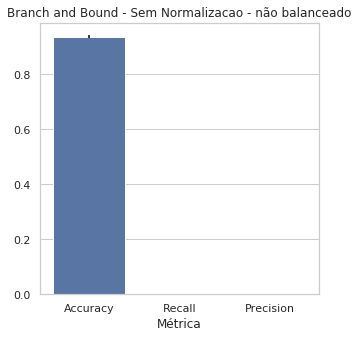

In [33]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_unbalanced = plt.figure(figsize=(5, 5))

# Medias dos melhores params
df_mean_unbalanced =  pd.DataFrame(mean_unbalanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

#plot
ax = sns.barplot(x="Métrica", y="Value", data=df_mean_unbalanced, ci = None)
plt.title('Branch and Bound - Sem Normalizacao - não balanceado')


plt.errorbar(x=[0],y=mean_unbalanced[0],yerr= (acc_max_unbalanced - mean_unbalanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_unbalanced[1],yerr= (rec_max_unbalanced - mean_unbalanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_unbalanced[2],yerr= (pre_max_unbalanced - mean_unbalanced[2]) , fmt='none', color = 'black')

fig_unbalanced.savefig('Branch_and_Bound-Sem_Normalizacao-nao_balanceado-SVC', bbox_inches='tight', dpi=600)

ax.set(ylabel='')

### Dataset Balanceado

[Text(157.00000000000003, 0.5, '')]

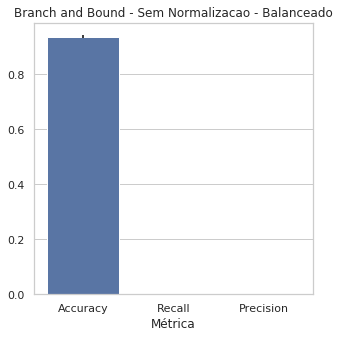

In [34]:
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 15})
fig_balanced = plt.figure(figsize=(5, 5))

# Medias dos melhores params
df_mean_balanced =  pd.DataFrame(mean_balanced).rename_axis('Métrica').reset_index().rename(columns = {0: 'Value'}) 

#plot
ax = sns.barplot(x="Métrica", y="Value", data=df_mean_balanced, ci = None)
plt.title('Branch and Bound - Sem Normalizacao - Balanceado')


plt.errorbar(x=[0],y=mean_balanced[0],yerr= (acc_max_balanced - mean_balanced[0]) , fmt='none', color = 'black')
plt.errorbar(x=[1],y=mean_balanced[1],yerr= (rec_max_balanced - mean_balanced[1]) , fmt='none', color = 'black')
plt.errorbar(x=[2],y=mean_balanced[2],yerr= (pre_max_balanced - mean_balanced[2]) , fmt='none', color = 'black')

fig_balanced.savefig('Branch_and_Bound-Sem_Normalizacao-balanceado-SVC', bbox_inches='tight', dpi=600)

ax.set(ylabel='')

## Armazena os Resultados para Gráfico Comparativo

In [35]:
path_to_save = '../../model_results/'

# Leitura dos resultados anteriores
all_models_results = pd.read_excel(path_to_save+'all_models_results.xlsx')

for metrica in df_mean_unbalanced.index:
    result = [
    '7',
    'MLPClassifier',
    'Branch and Bound - Sem Normalização - Desbalanceado',
    max_alpha_unbalanced,
    df_mean_unbalanced.loc[metrica]['Métrica'],
    df_mean_unbalanced.loc[metrica]['Value'],
    
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0: 'Atividade', 1: 'Algoritmo', 2: 'Condicao',
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

# deleta da memoria
del result, aux_df

# Dataset Completo Balanceado
for metrica in df_mean_balanced.index:
    result = [
    '7',
    'MLPClassifier',
    'Branch and Bound - Sem Normalização - Balanceado',
    max_alpha_balanced,
    df_mean_balanced.loc[metrica]['Métrica'],
    df_mean_balanced.loc[metrica]['Value']
    ]
    aux_df = (pd.DataFrame(result).T).rename(columns = {0: 'Atividade', 1: 'Algoritmo', 2: 'Condicao', 
                                                        3: 'Melhores_Params', 4:'Metrica', 5: 'Valor'})
    all_models_results = all_models_results.append(aux_df, ignore_index=True)

display(all_models_results)

# salva os resultados novos
try:
    all_models_results.to_excel(path_to_save+'all_models_results.xlsx', index=False)
    print('Resultados salvos com sucesso')
except Exception as e:
    print('Erro {}'.format(e))

Atividade      Algoritmo                                           Condicao            Melhores_Params    Metrica       Valor
0          7            SVC   Dataset Completo Desbalanceado - Nao Normalizado     ('linear', 1, 'scale')   Accuracy    0.960383
1          7            SVC   Dataset Completo Desbalanceado - Nao Normalizado     ('linear', 1, 'scale')     Recall        0.86
2          7            SVC   Dataset Completo Desbalanceado - Nao Normalizado     ('linear', 1, 'scale')  Precision    0.677579
3          7            SVC      Dataset Completo Balanceado - Nao Normalizado     ('rbf', 100, '0.0001')   Accuracy    0.962709
4          7            SVC      Dataset Completo Balanceado - Nao Normalizado     ('rbf', 100, '0.0001')     Recall    0.876667
5          7            SVC      Dataset Completo Balanceado - Nao Normalizado     ('rbf', 100, '0.0001')  Precision    0.690079
6          7            SVC       Dataset Completo Desbalanceado - Normalizado     ('rbf', 100, '0.0001')   Accuracy    0.962709
7          7            SVC       Dataset Completo Desbalanceado - Normalizado     ('rbf', 100, '0.0001')     Recall    0.876667
8          7            SVC       Dataset Completo Desbalanceado - Normalizado     ('rbf', 100, '0.0001')  Precision    0.690079
9          7            SVC          Dataset Completo Balanceado - Normalizado     ('rbf', 100, '0.0001')   Accuracy    0.959193
10         7            SVC          Dataset Completo Balanceado - Normalizado     ('rbf', 100, '0.0001')     Recall        0.91
11         7            SVC          Dataset Completo Balanceado - Normalizado     ('rbf', 100, '0.0001')  Precision    0.673016
12         7            SVC                                  PCA Desbalanceado     ('rbf', 100, '0.0001')   Accuracy    0.963899
13         7            SVC                                  PCA Desbalanceado     ('rbf', 100, '0.0001')     Recall        0.64
14         7            SVC                                  PCA Desbalanceado     ('rbf', 100, '0.0001')  Precision    0.799524
15         7            SVC                                     PCA Balanceado   ('sigmoid', 1, '0.0001')   Accuracy    0.958057
16         7            SVC                                     PCA Balanceado   ('sigmoid', 1, '0.0001')     Recall    0.716667
17         7            SVC                                     PCA Balanceado   ('sigmoid', 1, '0.0001')  Precision     0.71381
18         6    Naive Bayes                     Branch and Bound Desbalanceado                        0.6   Accuracy    0.931245
19         6    Naive Bayes                     Branch and Bound Desbalanceado                        0.6     Recall           0
20         6    Naive Bayes                     Branch and Bound Desbalanceado                        0.6  Precision           0
21         6    Naive Bayes                        Branch and Bound Balanceado                        0.3   Accuracy    0.690109
22         6    Naive Bayes                        Branch and Bound Balanceado                        0.3     Recall    0.216667
23         6    Naive Bayes                        Branch and Bound Balanceado                        0.3  Precision   0.0492712
24         6    Naive Bayes                     Dataset Completo Desbalanceado                        0.6   Accuracy    0.955677
25         6    Naive Bayes                     Dataset Completo Desbalanceado                        0.6     Recall    0.716667
26         6    Naive Bayes                     Dataset Completo Desbalanceado                        0.6  Precision    0.675397
27         6    Naive Bayes                        Dataset Completo Balanceado                        0.8   Accuracy     0.93933
28         6    Naive Bayes                        Dataset Completo Balanceado                        0.8     Recall    0.876667
29         6    Naive Bayes                        Dataset Completo Balanceado                        0.8  Precision    0.547143
30  

Resultados salvos com sucesso
